In [1]:
import numpy as np
import random
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, SGD, AdamW, RMSprop
from tensorflow.keras.metrics import SparseCategoricalCrossentropy, Accuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GaussianDropout, GaussianNoise
import os

# Параметри для експериментів

Запропоновані в домашці:
- кількість шарів;
- кількість нейронів;
- функції активації;
- кількість епох;
- розмір батчу;
- вибір оптимізатора;
- різні техніки регуляризації і т.д.

Додатково слід розглянути вплив перемішування на результати роботи моделі:
- перемішування "з коробки";
- пакет (вибірка) має репрезентувати датасет (популяцію), тобто, якщо у нас в датасеті перший клас складає 10%, то і в кожному пакеті він має бути представленим 10%.

Для чистоти екперименту слід підготувати перемішані набори заздалегідь, а не перемішувати перед кожним прогоном

# ПОПЕРЕДЖЕННЯ

Ноутбук виконується декілька годин, тож або вірте написаному, або заплануйте якусь паралельну роботу


Перш за все отримаємо дані датасету та прикинемо, що там всередині

In [2]:
#from tensorflow.keras.datasets import fashion_mnist
(train_X, train_Y), (test_X, test_Y) = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
train_X.shape

(60000, 28, 28)

Text(0.5, 1.0, 'Глянемо, як виглядає картинка')

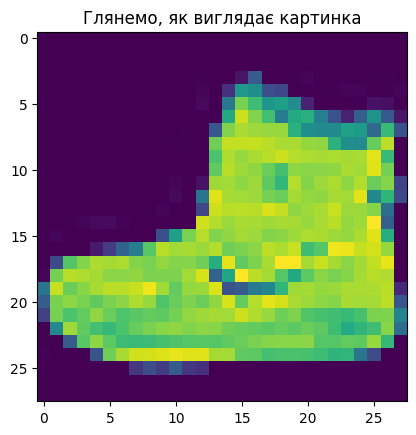

In [4]:
plt.imshow(train_X[0])
plt.title("Глянемо, як виглядає картинка")

In [5]:
print(test_Y.min())
print(test_Y.max())

0
9


Для навчання моделі змінимо форму нашого датасету

In [6]:
train_X = train_X.reshape((len(train_X), -1)).astype("float32")
test_X = test_X.reshape(len(test_X), -1).astype("float32")

train_X /= 255
test_X /=255

test_Y = tf.one_hot(test_Y, 10)
test_Y.shape

# тренувальні мітки будемо обробляти в класі датасету, пока так зручніше

TensorShape([10000, 10])

Створимо клас Dataset з такими особливостями:

- На вході клас приймає тренувальні датасети, розмір пакета та кількість епох
- На вході також визначається, чи будуть вихідні пакети стратифіковані



In [7]:
class MyDataset(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size = 256, stratyfy = False, seeds = [42, 24, 789, 351, 673, 12, 416, 456, 739, 182, 451, 375, 7895, 12, 15, 61, 17, 83, 911, 248]):
        self.X = X
        self.y = y
        self.batches = []
        self.batch_size = batch_size
        self.stratyfy = stratyfy
        self.current_epoch = -1 # стане нулем при першій підготовці даних для епохи
        self.seeds = seeds
        self.n_epochs = len(self.seeds)
        self.on_epoch_end()
    
    def __len__(self):
        return len(self.batches)
    
    def __getitem__(self, index):
        batch_x = []
        batch_y = []

        for i in self.batches[index]:
            #print(i)
            batch_x.append(self.X[i[0]])
            batch_y.append(self.y[i[0]])

        batch_y = tf.one_hot(batch_y, 10)

        return np.array(batch_x), batch_y
    
    def on_epoch_end(self):
        #print(f"stratyfy {self.stratyfy} batch {self.batch_size}")
        self.current_epoch += 1
        if self.current_epoch == self.n_epochs:
            self.current_epoch = 0
            # Заганяємо в цикл
        curr_seed = self.seeds[self.current_epoch]
        self.batches = []
        arr_to_split = np.array([[i, self.y[i]] for i in range(len(self.y))])

        while len(arr_to_split) > self.batch_size:
            if self.stratyfy:
                arr_to_split, curr_batch = train_test_split(arr_to_split, test_size=self.batch_size, random_state=curr_seed, shuffle=True, stratify=arr_to_split[::, 1:])
            else:
                arr_to_split, curr_batch = train_test_split(arr_to_split, test_size=self.batch_size, shuffle=True)
            
            self.batches.append(curr_batch[::, :1])
        
        self.batches.append(arr_to_split[::, :1])


In [8]:
SEEDS = [random.randint(-sys.maxsize - 1, sys.maxsize) for i in range(512)]
# В документації int, то й int, а виявляється невід'ємний і не більше 2**32-1

SEEDS = [random.randint(0, 2**32-1) for i in range(512)]
# Для чистоти експерименту зафіксуємо масив сидів в 512 елементів (епох)

In [9]:
# Глянемо, що зараз вийшло
ds = MyDataset(train_X, train_Y, batch_size=128, stratyfy=False)
cur_x, cur_y = ds[0]
cur_x.shape, cur_y.shape

((128, 784), TensorShape([128, 10]))

Створимо першу модель та спробуємо її навчити

In [10]:
model = Sequential()

model.add(Dense(512, activation="relu", input_shape=(28*28,)))
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(10, activation="softmax"))

model.compile(optimizer=Adam(learning_rate=0.01), loss="categorical_crossentropy", metrics=["accuracy", "categorical_crossentropy"])

history = model.fit(ds, validation_data=(test_X, test_Y), epochs=10, workers=os.cpu_count()) # Придушимо комп


Epoch 1/10
469/469 [==============================] - 9s 15ms/step - loss: 0.5815 - accuracy: 0.7974 - categorical_crossentropy: 0.5815 - val_loss: 0.4778 - val_accuracy: 0.8296 - val_categorical_crossentropy: 0.4778
Epoch 2/10
469/469 [==============================] - 6s 14ms/step - loss: 0.4013 - accuracy: 0.8531 - categorical_crossentropy: 0.4013 - val_loss: 0.4409 - val_accuracy: 0.8418 - val_categorical_crossentropy: 0.4409
Epoch 3/10
469/469 [==============================] - 6s 12ms/step - loss: 0.3716 - accuracy: 0.8658 - categorical_crossentropy: 0.3716 - val_loss: 0.4269 - val_accuracy: 0.8517 - val_categorical_crossentropy: 0.4269
Epoch 4/10
469/469 [==============================] - 6s 12ms/step - loss: 0.3576 - accuracy: 0.8702 - categorical_crossentropy: 0.3576 - val_loss: 0.3930 - val_accuracy: 0.8594 - val_categorical_crossentropy: 0.3930
Epoch 5/10
469/469 [==============================] - 6s 12ms/step - loss: 0.3512 - accuracy: 0.8738 - categorical_crossentropy: 0.3

Для презентації історії створимо допоміжну функцію

In [11]:
def present_histiry(title, history_data):
    figure, axis = plt.subplots(ncols=2, figsize=(15, 10))

    axis[0].plot(history_data.history["loss"], label="train loss")
    axis[0].plot(history_data.history["val_loss"], label="valid loss")
    axis[0].grid()
    axis[0].legend()
    #plt.show()

    axis[1].plot(history_data.history["accuracy"], label="train accuracy")
    axis[1].plot(history_data.history["val_accuracy"], label="valid accuracy")
    axis[1].grid()
    axis[1].legend()

    figure.suptitle(title + f" max val accuracy {max(history_data.history['val_accuracy'])}")
    
    plt.show()

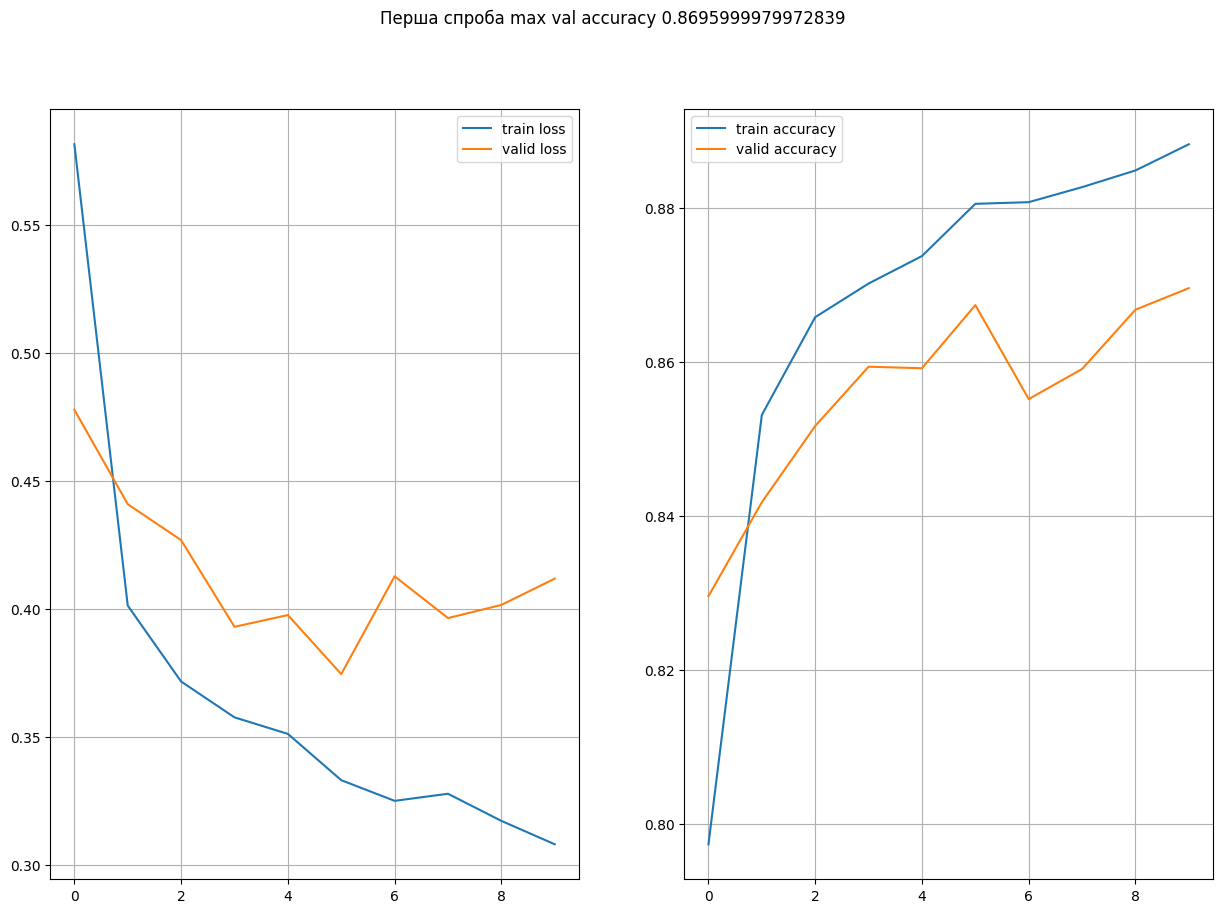

In [12]:
present_histiry("Перша спроба", history)

Отже, що ми маємо після першого експерименту:

1. Точність недостатня для виконання ДЗ
2. Рвані кардіограми валідаційних втрат та точності не дозволяють зробити висновок, чи має модель потенціал до навчання. Кількість епох необхідно однозначно збільшувати

In [13]:
# Визначимо перші набори параметрів для досліджень
def_batch_size = 256
batch_sizes = [128, 256, 512, 1024]

def_optimizer = Adam
optimizers = [SGD, Adam, AdamW, RMSprop]

def_strat = False
strats = [True, False]

def_n_e = 20
n_epochs = [20, 50, 100]

def_layers = [
    Dense(512, activation="relu", input_shape=(28*28,)),
    Dense(256, activation="relu"),
    Dense(128, activation="relu"),
    Dense(10, activation="softmax")
]


Ліричний відступ

Якщо створити шари у вигляді масиву, як показано вище, вилізе донавчання: скільки б ми не створювали модель з цими шарами, ваги вже в них прописані і далі відбувається донавчання. Тому обгорнемо це у функцію

In [14]:
def get_def_layers():
    return [
            Dense(512, activation="relu", input_shape=(28*28,)),
            Dense(256, activation="relu"),
            Dense(128, activation="relu"),
            Dense(10, activation="softmax")
        ]

In [15]:
# Щоб спростити собі життя, додамо пару сервісних функцій

def create_model(layers, optimizer):
    model = Sequential(layers)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    return model

def fit_and_present(model:tf.keras.models.Sequential, fit_dataset, val_dataset, description="", epochs=10):
    history = model.fit(fit_dataset, validation_data=val_dataset, epochs=epochs, workers=os.cpu_count()*2-1)
    present_histiry(description, history)

    return history



Epoch 1/20
469/469 [==============================] - 6s 12ms/step - loss: 0.4920 - accuracy: 0.8241 - val_loss: 0.4248 - val_accuracy: 0.8446
Epoch 2/20
469/469 [==============================] - 5s 12ms/step - loss: 0.3598 - accuracy: 0.8687 - val_loss: 0.3611 - val_accuracy: 0.8705
Epoch 3/20
469/469 [==============================] - 7s 14ms/step - loss: 0.3179 - accuracy: 0.8839 - val_loss: 0.3844 - val_accuracy: 0.8615
Epoch 4/20
469/469 [==============================] - 6s 12ms/step - loss: 0.2927 - accuracy: 0.8906 - val_loss: 0.3325 - val_accuracy: 0.8788
Epoch 5/20
469/469 [==============================] - 5s 12ms/step - loss: 0.2811 - accuracy: 0.8944 - val_loss: 0.3573 - val_accuracy: 0.8720
Epoch 6/20
469/469 [==============================] - 5s 11ms/step - loss: 0.2639 - accuracy: 0.9011 - val_loss: 0.3281 - val_accuracy: 0.8799
Epoch 7/20
469/469 [==============================] - 5s 11ms/step - loss: 0.2502 - accuracy: 0.9064 - val_loss: 0.3228 - val_accuracy: 0.8840

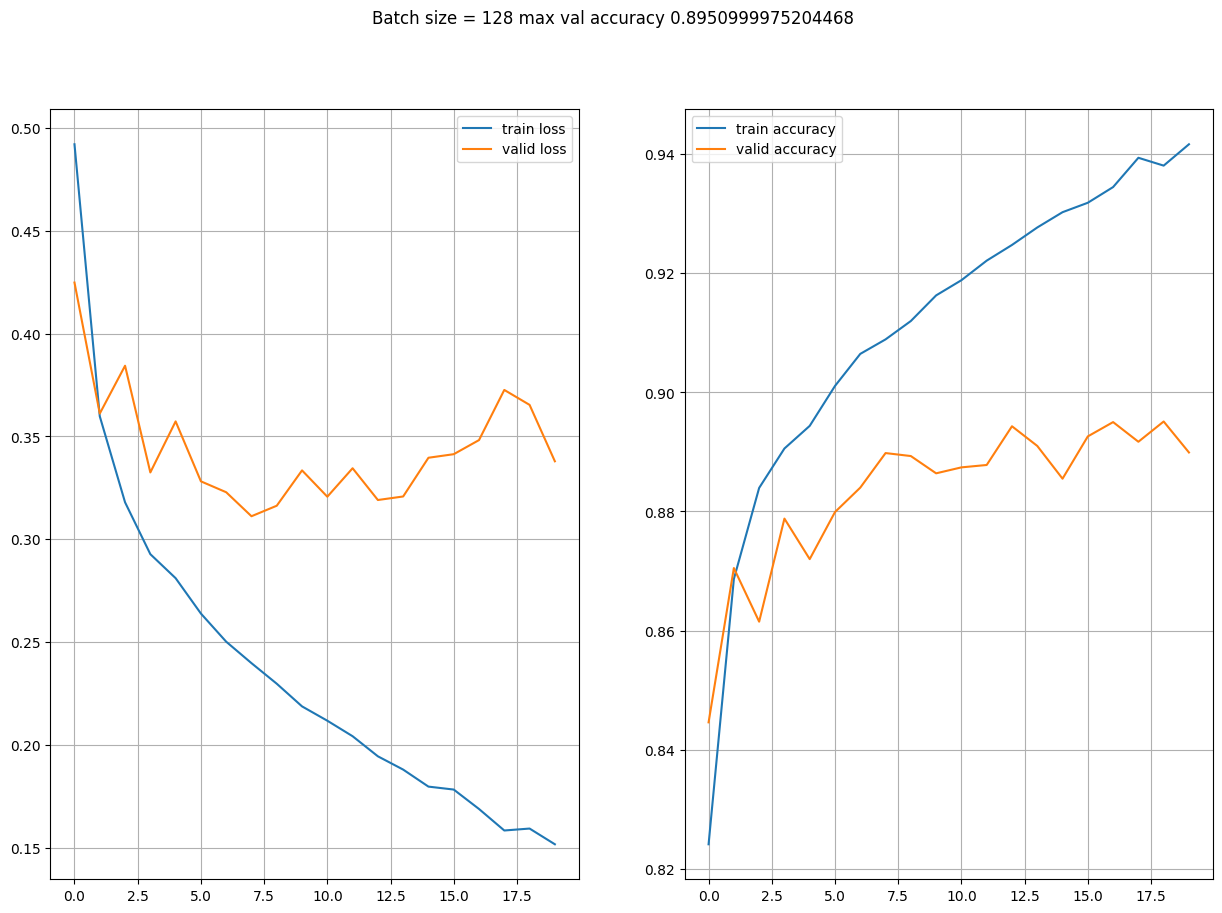

Epoch 1/20
235/235 [==============================] - 5s 17ms/step - loss: 0.5279 - accuracy: 0.8149 - val_loss: 0.4207 - val_accuracy: 0.8484
Epoch 2/20
235/235 [==============================] - 4s 16ms/step - loss: 0.3661 - accuracy: 0.8680 - val_loss: 0.3847 - val_accuracy: 0.8606
Epoch 3/20
235/235 [==============================] - 4s 17ms/step - loss: 0.3285 - accuracy: 0.8798 - val_loss: 0.3664 - val_accuracy: 0.8709
Epoch 4/20
235/235 [==============================] - 4s 16ms/step - loss: 0.2998 - accuracy: 0.8886 - val_loss: 0.3309 - val_accuracy: 0.8813
Epoch 5/20
235/235 [==============================] - 4s 16ms/step - loss: 0.2817 - accuracy: 0.8962 - val_loss: 0.3286 - val_accuracy: 0.8812
Epoch 6/20
235/235 [==============================] - 4s 16ms/step - loss: 0.2686 - accuracy: 0.9007 - val_loss: 0.3364 - val_accuracy: 0.8744
Epoch 7/20
235/235 [==============================] - 4s 16ms/step - loss: 0.2527 - accuracy: 0.9065 - val_loss: 0.3444 - val_accuracy: 0.8792

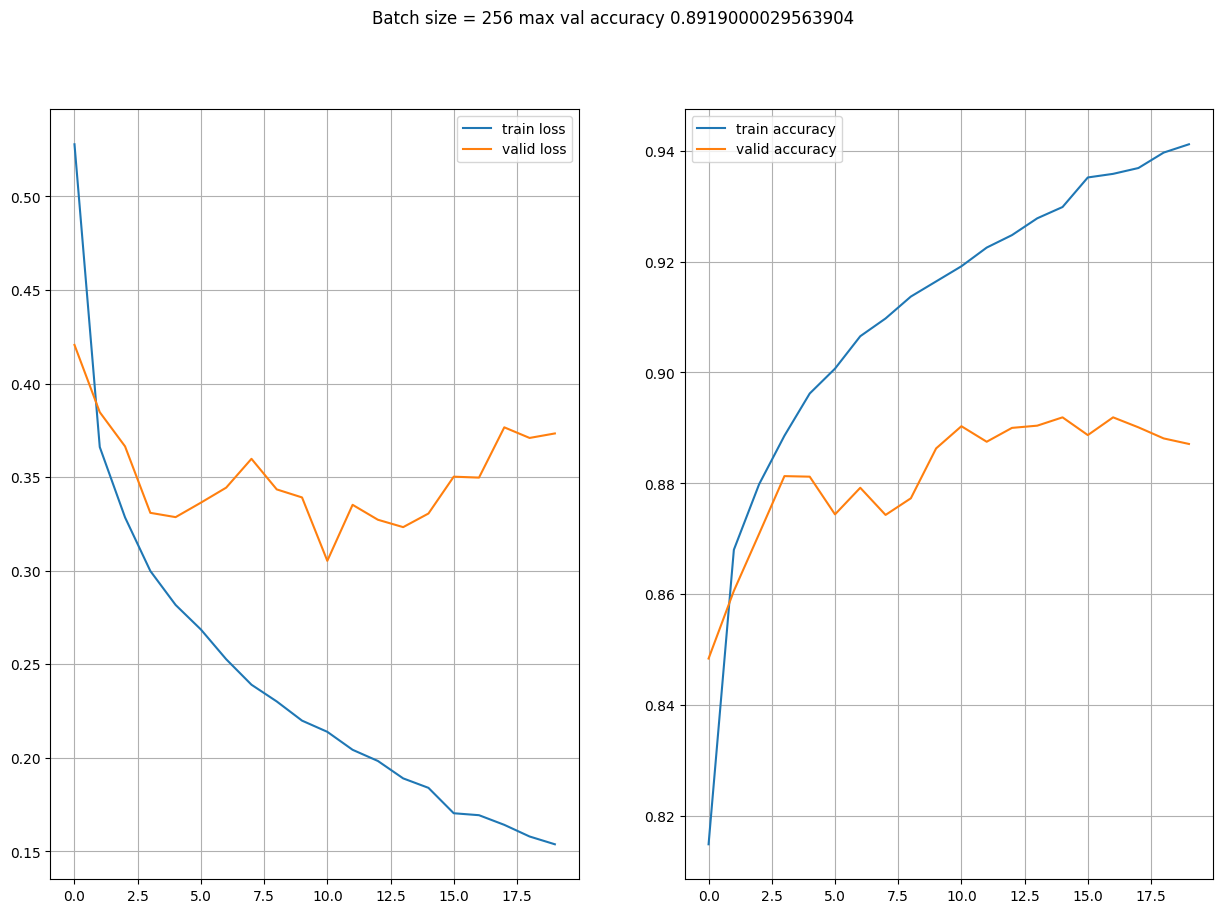

Epoch 1/20
118/118 [==============================] - 4s 27ms/step - loss: 0.5859 - accuracy: 0.7958 - val_loss: 0.4822 - val_accuracy: 0.8312
Epoch 2/20
118/118 [==============================] - 3s 26ms/step - loss: 0.3824 - accuracy: 0.8637 - val_loss: 0.4257 - val_accuracy: 0.8469
Epoch 3/20
118/118 [==============================] - 3s 26ms/step - loss: 0.3412 - accuracy: 0.8759 - val_loss: 0.3750 - val_accuracy: 0.8643
Epoch 4/20
118/118 [==============================] - 3s 27ms/step - loss: 0.3124 - accuracy: 0.8860 - val_loss: 0.3473 - val_accuracy: 0.8761
Epoch 5/20
118/118 [==============================] - 3s 26ms/step - loss: 0.2863 - accuracy: 0.8949 - val_loss: 0.3447 - val_accuracy: 0.8755
Epoch 6/20
118/118 [==============================] - 3s 26ms/step - loss: 0.2727 - accuracy: 0.8983 - val_loss: 0.3353 - val_accuracy: 0.8806
Epoch 7/20
118/118 [==============================] - 3s 27ms/step - loss: 0.2594 - accuracy: 0.9029 - val_loss: 0.3142 - val_accuracy: 0.8857

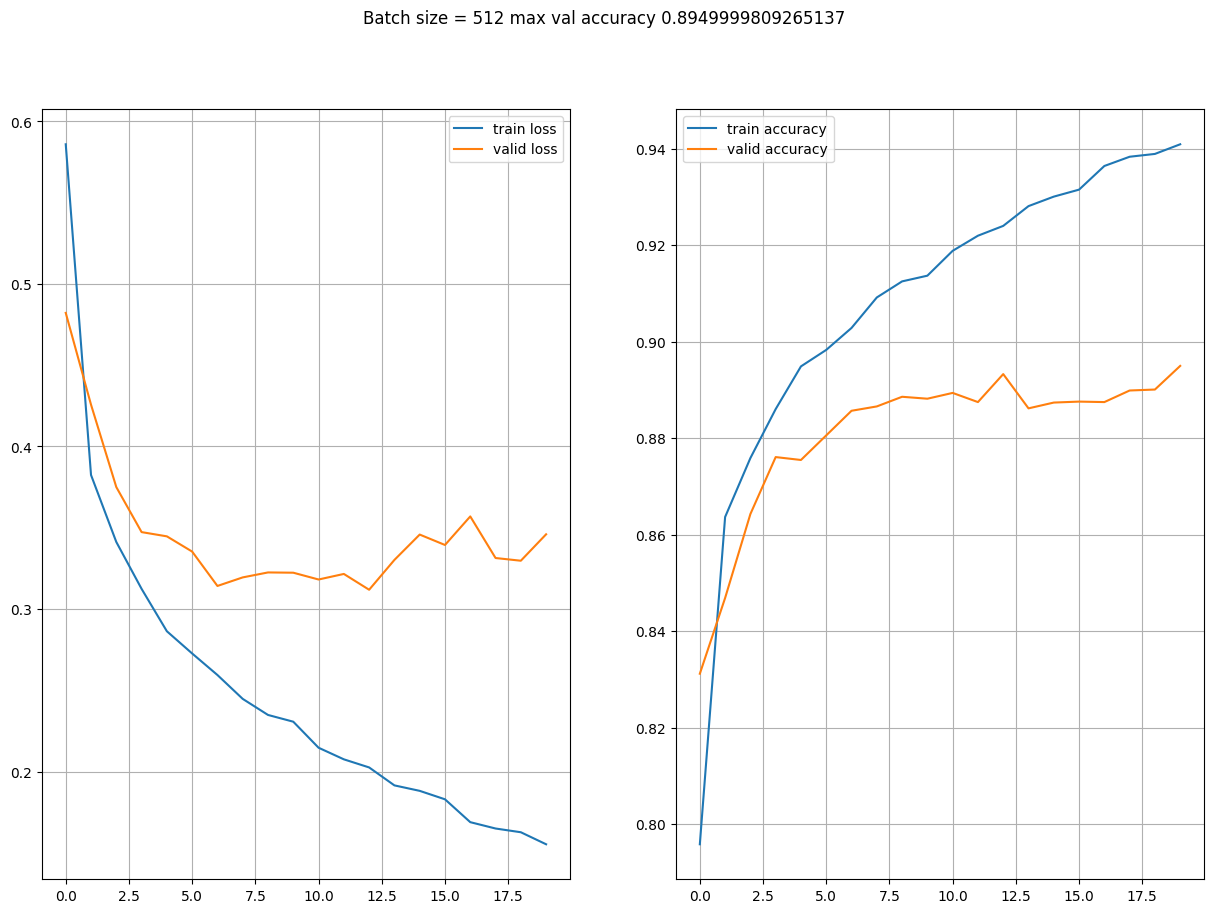

Epoch 1/20
59/59 [==============================] - 4s 47ms/step - loss: 0.6822 - accuracy: 0.7666 - val_loss: 0.4942 - val_accuracy: 0.8249
Epoch 2/20
59/59 [==============================] - 3s 44ms/step - loss: 0.4195 - accuracy: 0.8513 - val_loss: 0.4157 - val_accuracy: 0.8527
Epoch 3/20
59/59 [==============================] - 3s 44ms/step - loss: 0.3652 - accuracy: 0.8698 - val_loss: 0.3929 - val_accuracy: 0.8586
Epoch 4/20
59/59 [==============================] - 3s 46ms/step - loss: 0.3360 - accuracy: 0.8798 - val_loss: 0.3655 - val_accuracy: 0.8685
Epoch 5/20
59/59 [==============================] - 3s 46ms/step - loss: 0.3173 - accuracy: 0.8854 - val_loss: 0.3657 - val_accuracy: 0.8693
Epoch 6/20
59/59 [==============================] - 3s 46ms/step - loss: 0.2942 - accuracy: 0.8928 - val_loss: 0.3686 - val_accuracy: 0.8681
Epoch 7/20
59/59 [==============================] - 3s 46ms/step - loss: 0.2858 - accuracy: 0.8957 - val_loss: 0.3348 - val_accuracy: 0.8795
Epoch 8/20
59

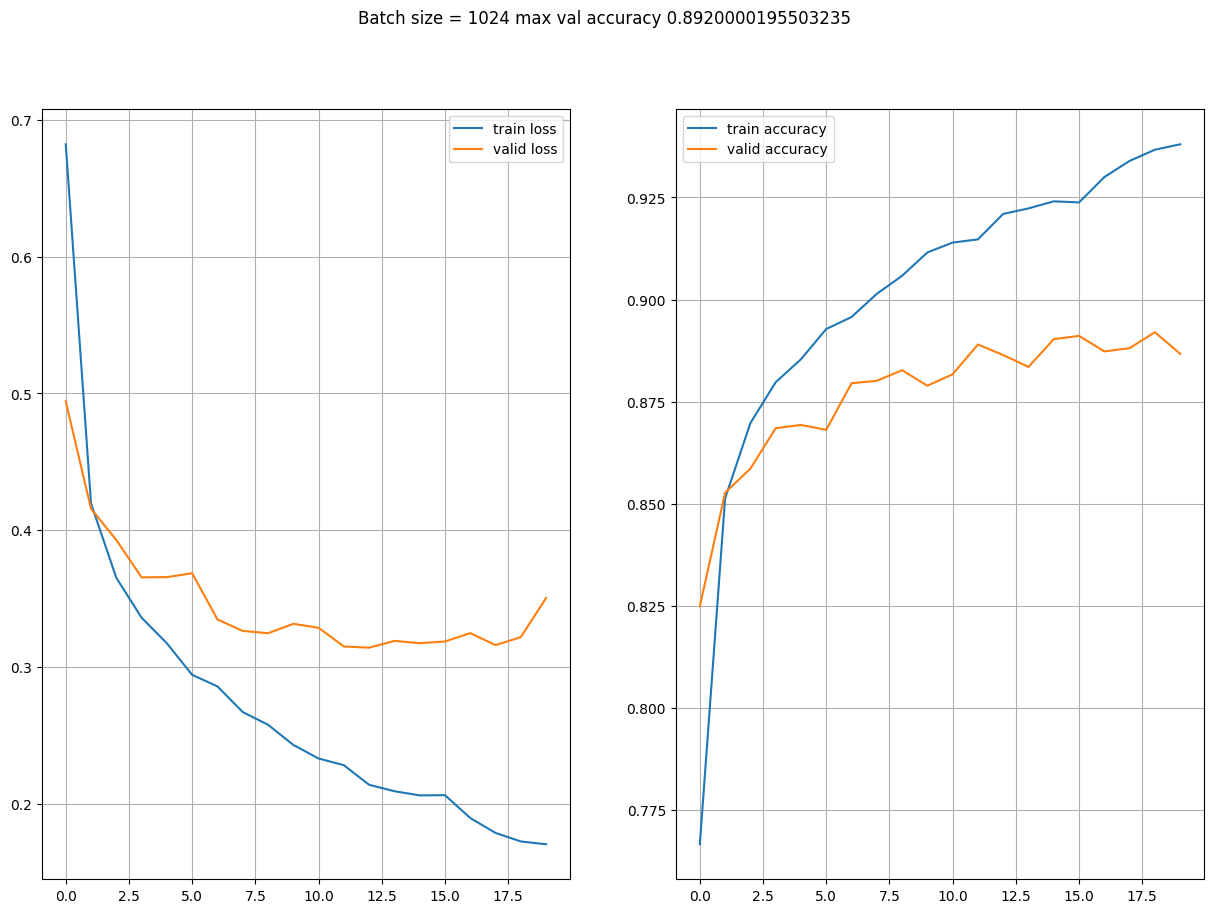

In [16]:
# Розмір батчу
for batch_size in batch_sizes:
    cur_model = create_model(get_def_layers(), def_optimizer())
    ds = MyDataset(train_X, train_Y, batch_size=batch_size, stratyfy=def_strat)
    history = fit_and_present(model=cur_model, fit_dataset=ds, val_dataset=(test_X, test_Y), epochs=def_n_e, description=f"Batch size = {batch_size}")

Стосовно розміру батчу в даній задачі важко зробити якісь висновки: для заданої базової моделі різниця в точності вийшла в десяті долі відсотка, і нема опуклої тенденції.

Однак зафіксуємо, що найкращий результат навчання спостерігався у розмірі батчу 128, однак і час на епоху був найбільший

Epoch 1/20
235/235 [==============================] - 4s 15ms/step - loss: 1.2306 - accuracy: 0.6560 - val_loss: 0.8197 - val_accuracy: 0.7297
Epoch 2/20
235/235 [==============================] - 3s 14ms/step - loss: 0.7054 - accuracy: 0.7707 - val_loss: 0.6570 - val_accuracy: 0.7800
Epoch 3/20
235/235 [==============================] - 3s 14ms/step - loss: 0.5992 - accuracy: 0.7991 - val_loss: 0.5844 - val_accuracy: 0.7995
Epoch 4/20
235/235 [==============================] - 3s 14ms/step - loss: 0.5479 - accuracy: 0.8149 - val_loss: 0.5535 - val_accuracy: 0.8088
Epoch 5/20
235/235 [==============================] - 3s 14ms/step - loss: 0.5157 - accuracy: 0.8235 - val_loss: 0.5307 - val_accuracy: 0.8163
Epoch 6/20
235/235 [==============================] - 3s 14ms/step - loss: 0.4961 - accuracy: 0.8301 - val_loss: 0.5229 - val_accuracy: 0.8149
Epoch 7/20
235/235 [==============================] - 3s 14ms/step - loss: 0.4817 - accuracy: 0.8333 - val_loss: 0.4967 - val_accuracy: 0.8239

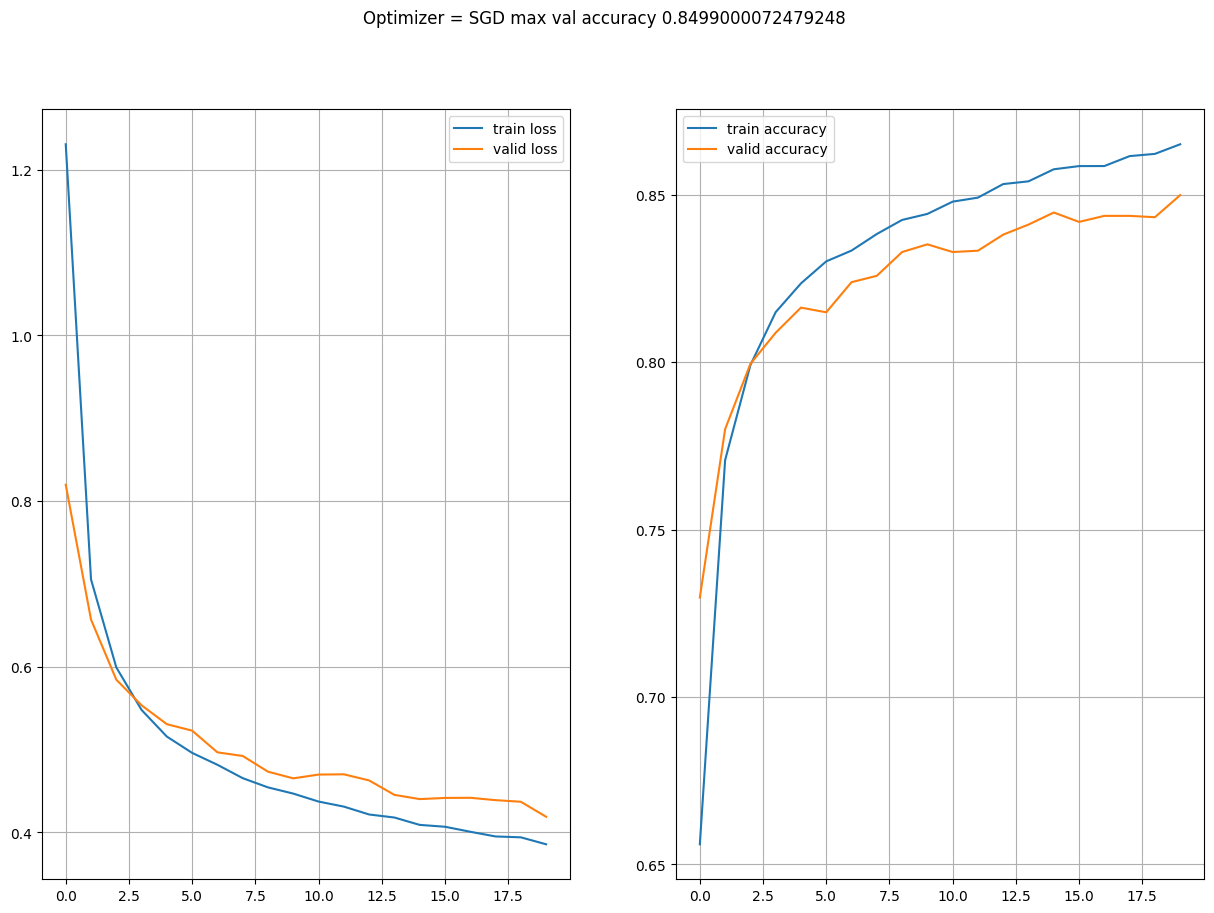

Epoch 1/20
235/235 [==============================] - 5s 18ms/step - loss: 0.5288 - accuracy: 0.8148 - val_loss: 0.4149 - val_accuracy: 0.8553
Epoch 2/20
235/235 [==============================] - 4s 17ms/step - loss: 0.3676 - accuracy: 0.8663 - val_loss: 0.3887 - val_accuracy: 0.8580
Epoch 3/20
235/235 [==============================] - 4s 17ms/step - loss: 0.3252 - accuracy: 0.8799 - val_loss: 0.3618 - val_accuracy: 0.8690
Epoch 4/20
235/235 [==============================] - 4s 17ms/step - loss: 0.2979 - accuracy: 0.8892 - val_loss: 0.3423 - val_accuracy: 0.8759
Epoch 5/20
235/235 [==============================] - 4s 16ms/step - loss: 0.2784 - accuracy: 0.8963 - val_loss: 0.3378 - val_accuracy: 0.8766
Epoch 6/20
235/235 [==============================] - 4s 17ms/step - loss: 0.2688 - accuracy: 0.8992 - val_loss: 0.3329 - val_accuracy: 0.8782
Epoch 7/20
235/235 [==============================] - 4s 17ms/step - loss: 0.2516 - accuracy: 0.9057 - val_loss: 0.3329 - val_accuracy: 0.8833

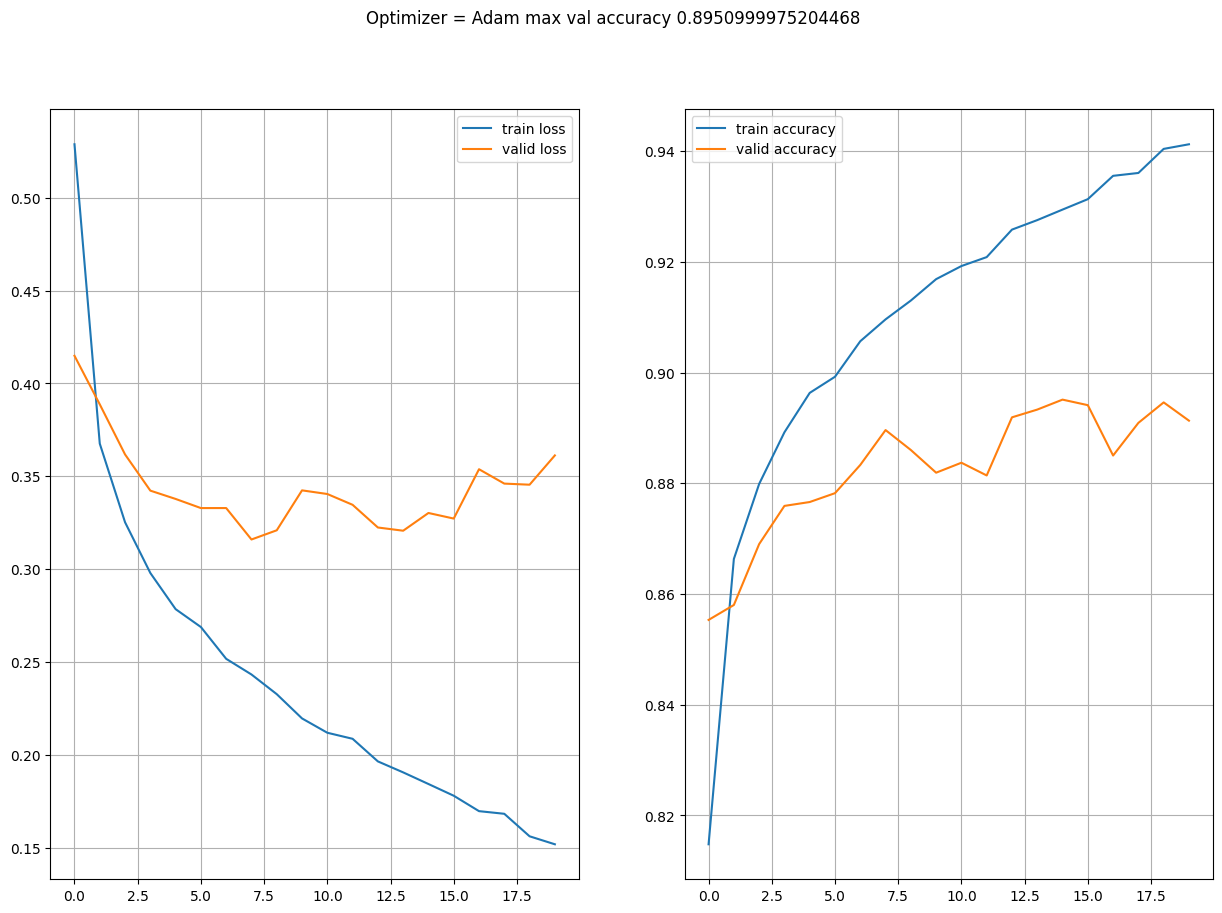

Epoch 1/20
235/235 [==============================] - 5s 17ms/step - loss: 0.5298 - accuracy: 0.8144 - val_loss: 0.4364 - val_accuracy: 0.8445
Epoch 2/20
235/235 [==============================] - 4s 17ms/step - loss: 0.3632 - accuracy: 0.8673 - val_loss: 0.3811 - val_accuracy: 0.8638
Epoch 3/20
235/235 [==============================] - 4s 17ms/step - loss: 0.3242 - accuracy: 0.8811 - val_loss: 0.3805 - val_accuracy: 0.8630
Epoch 4/20
235/235 [==============================] - 4s 17ms/step - loss: 0.2987 - accuracy: 0.8893 - val_loss: 0.3413 - val_accuracy: 0.8738
Epoch 5/20
235/235 [==============================] - 4s 17ms/step - loss: 0.2792 - accuracy: 0.8960 - val_loss: 0.3256 - val_accuracy: 0.8825
Epoch 6/20
235/235 [==============================] - 4s 17ms/step - loss: 0.2645 - accuracy: 0.9005 - val_loss: 0.3406 - val_accuracy: 0.8770
Epoch 7/20
235/235 [==============================] - 4s 18ms/step - loss: 0.2568 - accuracy: 0.9040 - val_loss: 0.3241 - val_accuracy: 0.8854

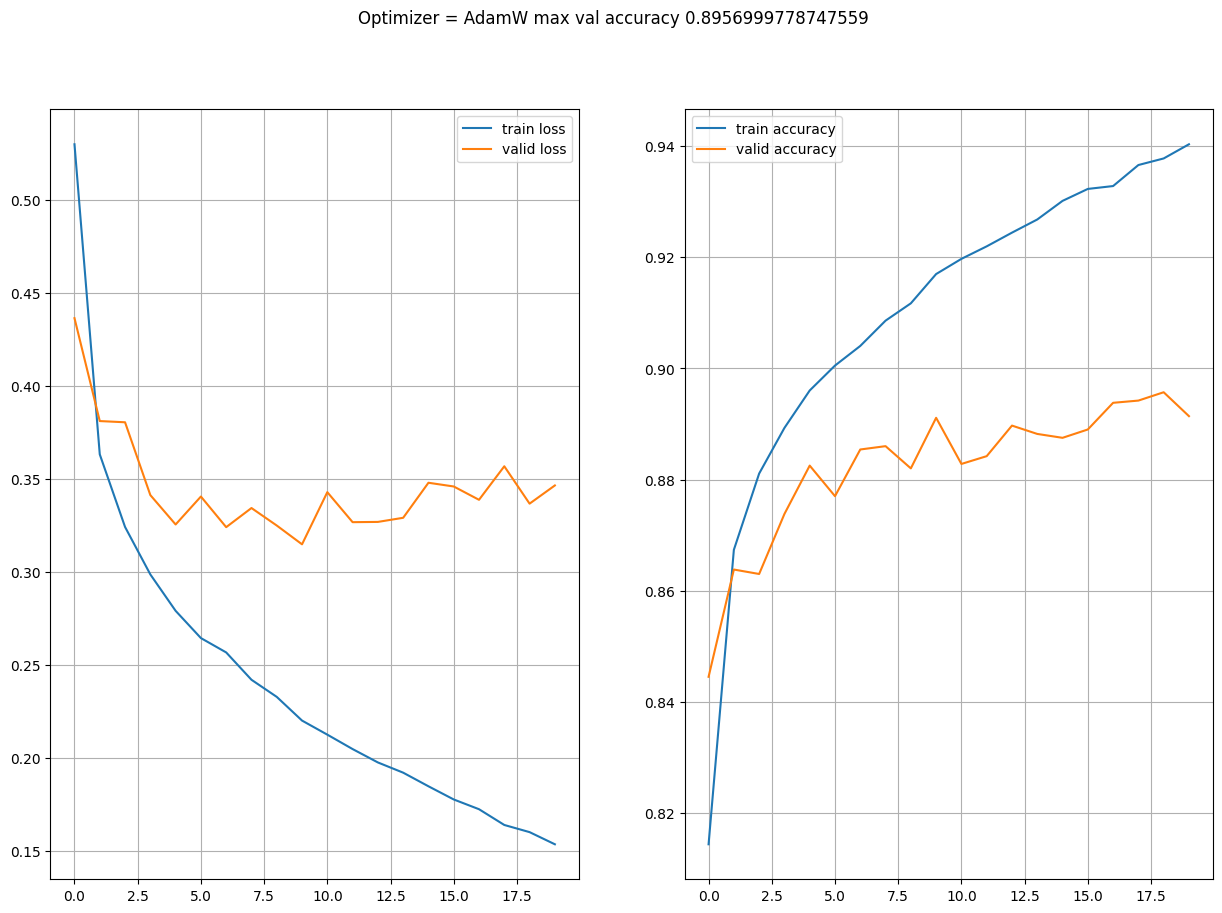

Epoch 1/20
235/235 [==============================] - 5s 17ms/step - loss: 0.6389 - accuracy: 0.7673 - val_loss: 0.4386 - val_accuracy: 0.8423
Epoch 2/20
235/235 [==============================] - 4s 16ms/step - loss: 0.4171 - accuracy: 0.8448 - val_loss: 0.4483 - val_accuracy: 0.8310
Epoch 3/20
235/235 [==============================] - 4s 16ms/step - loss: 0.3615 - accuracy: 0.8663 - val_loss: 0.3878 - val_accuracy: 0.8537
Epoch 4/20
235/235 [==============================] - 4s 17ms/step - loss: 0.3294 - accuracy: 0.8769 - val_loss: 0.3743 - val_accuracy: 0.8635
Epoch 5/20
235/235 [==============================] - 4s 16ms/step - loss: 0.3054 - accuracy: 0.8853 - val_loss: 0.3624 - val_accuracy: 0.8627
Epoch 6/20
235/235 [==============================] - 4s 16ms/step - loss: 0.2894 - accuracy: 0.8913 - val_loss: 0.3915 - val_accuracy: 0.8613
Epoch 7/20
235/235 [==============================] - 4s 16ms/step - loss: 0.2730 - accuracy: 0.8978 - val_loss: 0.3314 - val_accuracy: 0.8809

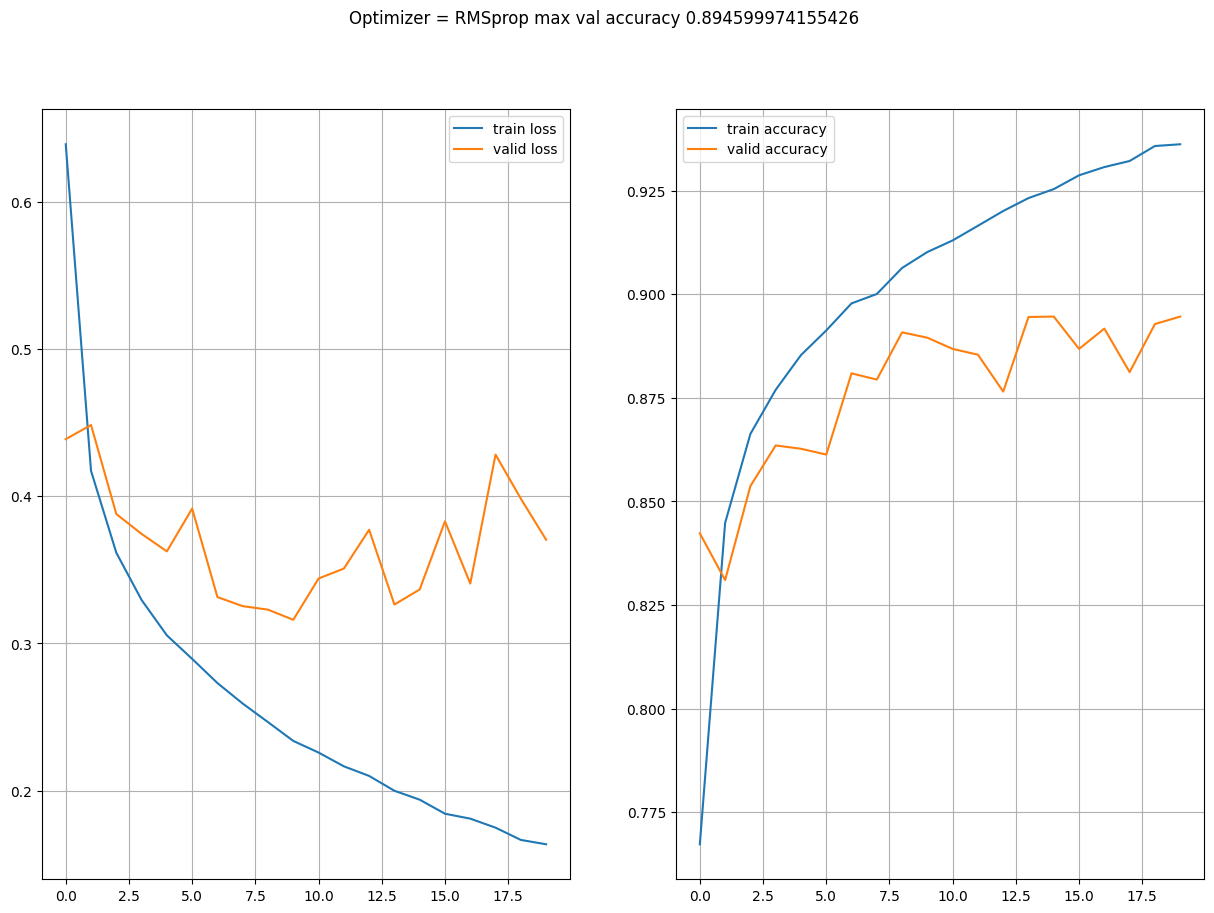

In [17]:
# Оптимізатор
for optimizer in optimizers:
    cur_optimizer = optimizer()
    model = create_model(get_def_layers(), cur_optimizer)
    ds = MyDataset(train_X, train_Y, batch_size=def_batch_size, stratyfy=def_strat)
    history = fit_and_present(model=model, fit_dataset=ds, val_dataset=(test_X, test_Y), epochs=def_n_e, description=f"Optimizer = {cur_optimizer.__class__.__name__}")

Серед оптимізаторів SGD показав себе найгірше. Adam, AdamW та RMSprop показали приблизно однакові результати по швидкості та результативності навчання. Щоправда, неможна однозначно сказати, чи перейшли ці моделі до перенавчання.

Отже, зупинимось на RMSprop і поганяємо його на більшій кількості епох

Epoch 1/20
235/235 [==============================] - 13s 52ms/step - loss: 0.5038 - accuracy: 0.8242 - val_loss: 0.4085 - val_accuracy: 0.8546
Epoch 2/20
235/235 [==============================] - 12s 50ms/step - loss: 0.3603 - accuracy: 0.8684 - val_loss: 0.3813 - val_accuracy: 0.8635
Epoch 3/20
235/235 [==============================] - 11s 47ms/step - loss: 0.3181 - accuracy: 0.8835 - val_loss: 0.3694 - val_accuracy: 0.8647
Epoch 4/20
235/235 [==============================] - 13s 56ms/step - loss: 0.2961 - accuracy: 0.8901 - val_loss: 0.3449 - val_accuracy: 0.8769
Epoch 5/20
235/235 [==============================] - 13s 57ms/step - loss: 0.2773 - accuracy: 0.8966 - val_loss: 0.3512 - val_accuracy: 0.8722
Epoch 6/20
235/235 [==============================] - 13s 55ms/step - loss: 0.2658 - accuracy: 0.8999 - val_loss: 0.3409 - val_accuracy: 0.8786
Epoch 7/20
235/235 [==============================] - 13s 55ms/step - loss: 0.2489 - accuracy: 0.9069 - val_loss: 0.3321 - val_accuracy:

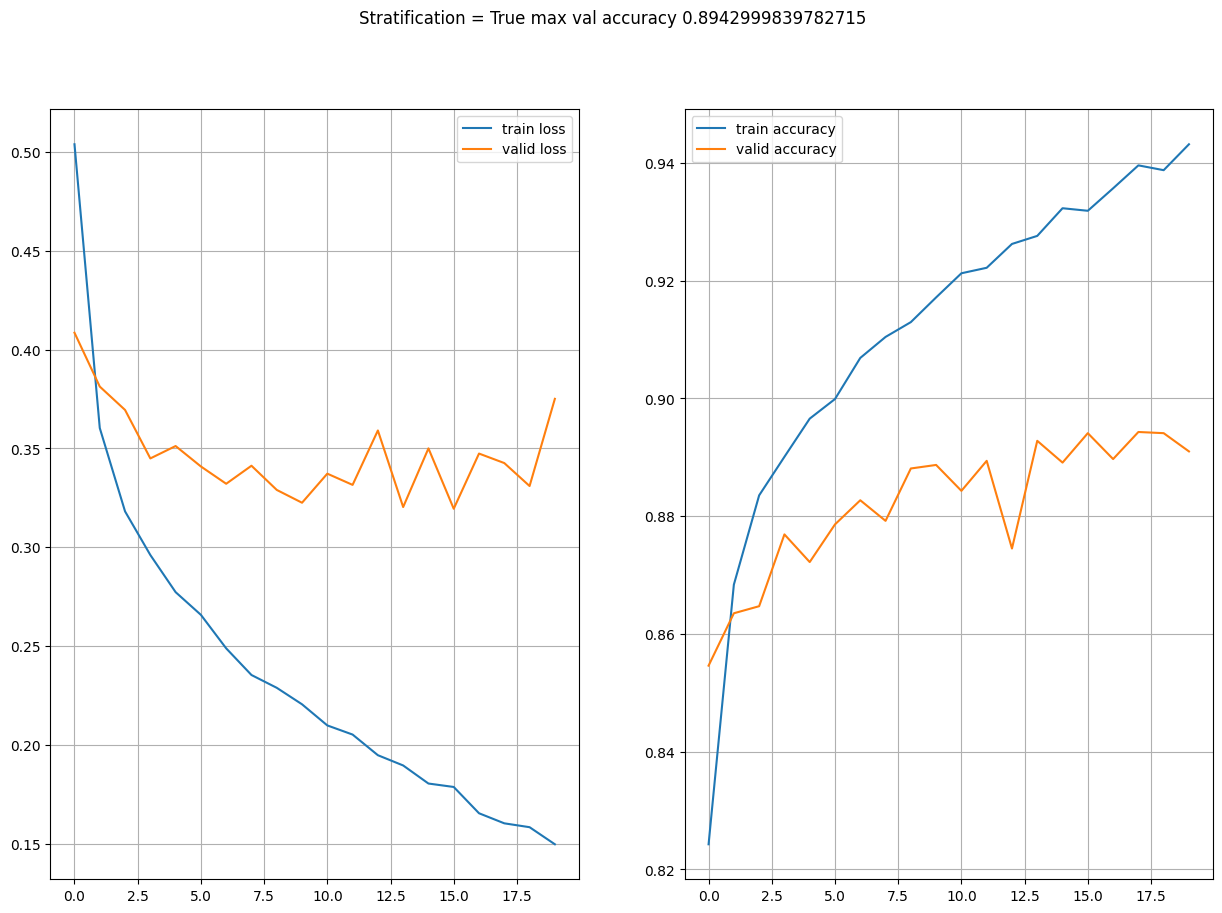

Epoch 1/20
235/235 [==============================] - 4s 15ms/step - loss: 0.5201 - accuracy: 0.8168 - val_loss: 0.4132 - val_accuracy: 0.8520
Epoch 2/20
235/235 [==============================] - 4s 17ms/step - loss: 0.3614 - accuracy: 0.8687 - val_loss: 0.3779 - val_accuracy: 0.8673
Epoch 3/20
235/235 [==============================] - 4s 17ms/step - loss: 0.3232 - accuracy: 0.8808 - val_loss: 0.3713 - val_accuracy: 0.8630
Epoch 4/20
235/235 [==============================] - 4s 17ms/step - loss: 0.2989 - accuracy: 0.8900 - val_loss: 0.3409 - val_accuracy: 0.8758
Epoch 5/20
235/235 [==============================] - 4s 17ms/step - loss: 0.2757 - accuracy: 0.8985 - val_loss: 0.3363 - val_accuracy: 0.8780
Epoch 6/20
235/235 [==============================] - 4s 17ms/step - loss: 0.2623 - accuracy: 0.9014 - val_loss: 0.3384 - val_accuracy: 0.8745
Epoch 7/20
235/235 [==============================] - 4s 17ms/step - loss: 0.2453 - accuracy: 0.9074 - val_loss: 0.3430 - val_accuracy: 0.8788

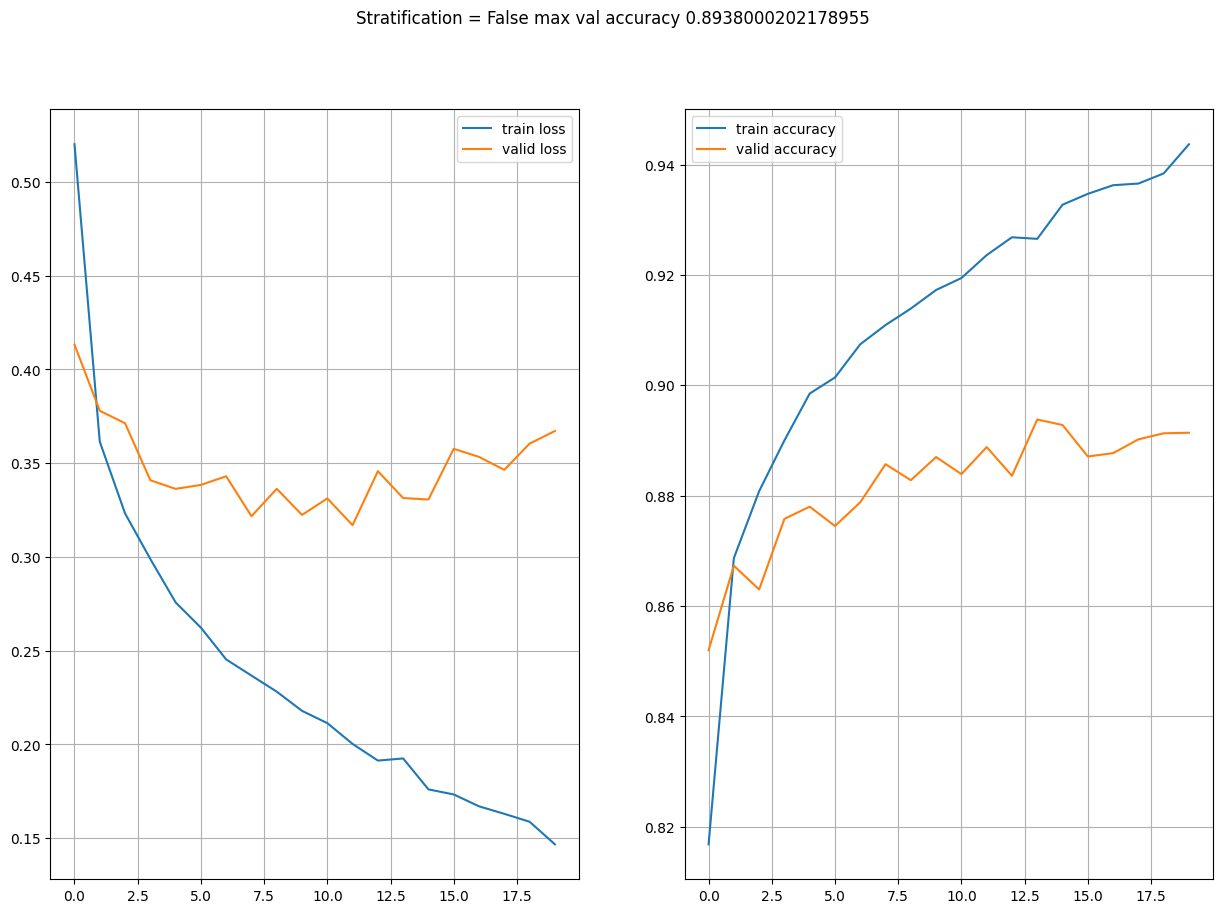

In [18]:
# Стратифікація
for use_strat in strats:
    model = create_model(get_def_layers(), def_optimizer())
    ds = MyDataset(train_X, train_Y, batch_size=def_batch_size, stratyfy=use_strat, seeds=SEEDS)
    history = fit_and_present(model=model, fit_dataset=ds, val_dataset=(test_X, test_Y), epochs=def_n_e, description=f"Stratification = {use_strat}")

Стосовно стратифікації батчів. З оптимізаторам Adam вона не дає жодного ефекту, з SGD вона давала кращі стартові (на перших епохах) результати по точності, але не впливала на кінцевий результат навчання моделі. В будь-якому разі алгоритм стратифікації, реалізований в моєму датасеті, є повільним, і він більше заважає, ніж приносить користь.

Підіб'ємо проміжні підсумки:

1. Оптимізатор RMSprop
2. Розмір батчу - 128
3. Від стратифікації відмовимось

Перейдемо до кількості епох навчання

Epoch 1/20
469/469 [==============================] - 6s 11ms/step - loss: 0.5649 - accuracy: 0.7925 - val_loss: 0.5338 - val_accuracy: 0.7956
Epoch 2/20
469/469 [==============================] - 5s 11ms/step - loss: 0.3830 - accuracy: 0.8572 - val_loss: 0.4335 - val_accuracy: 0.8434
Epoch 3/20
469/469 [==============================] - 5s 10ms/step - loss: 0.3410 - accuracy: 0.8716 - val_loss: 0.3556 - val_accuracy: 0.8698
Epoch 4/20
469/469 [==============================] - 5s 11ms/step - loss: 0.3109 - accuracy: 0.8833 - val_loss: 0.4132 - val_accuracy: 0.8440
Epoch 5/20
469/469 [==============================] - 5s 11ms/step - loss: 0.2943 - accuracy: 0.8899 - val_loss: 0.3902 - val_accuracy: 0.8578
Epoch 6/20
469/469 [==============================] - 5s 11ms/step - loss: 0.2798 - accuracy: 0.8946 - val_loss: 0.3678 - val_accuracy: 0.8747
Epoch 7/20
469/469 [==============================] - 5s 11ms/step - loss: 0.2643 - accuracy: 0.9011 - val_loss: 0.3669 - val_accuracy: 0.8754

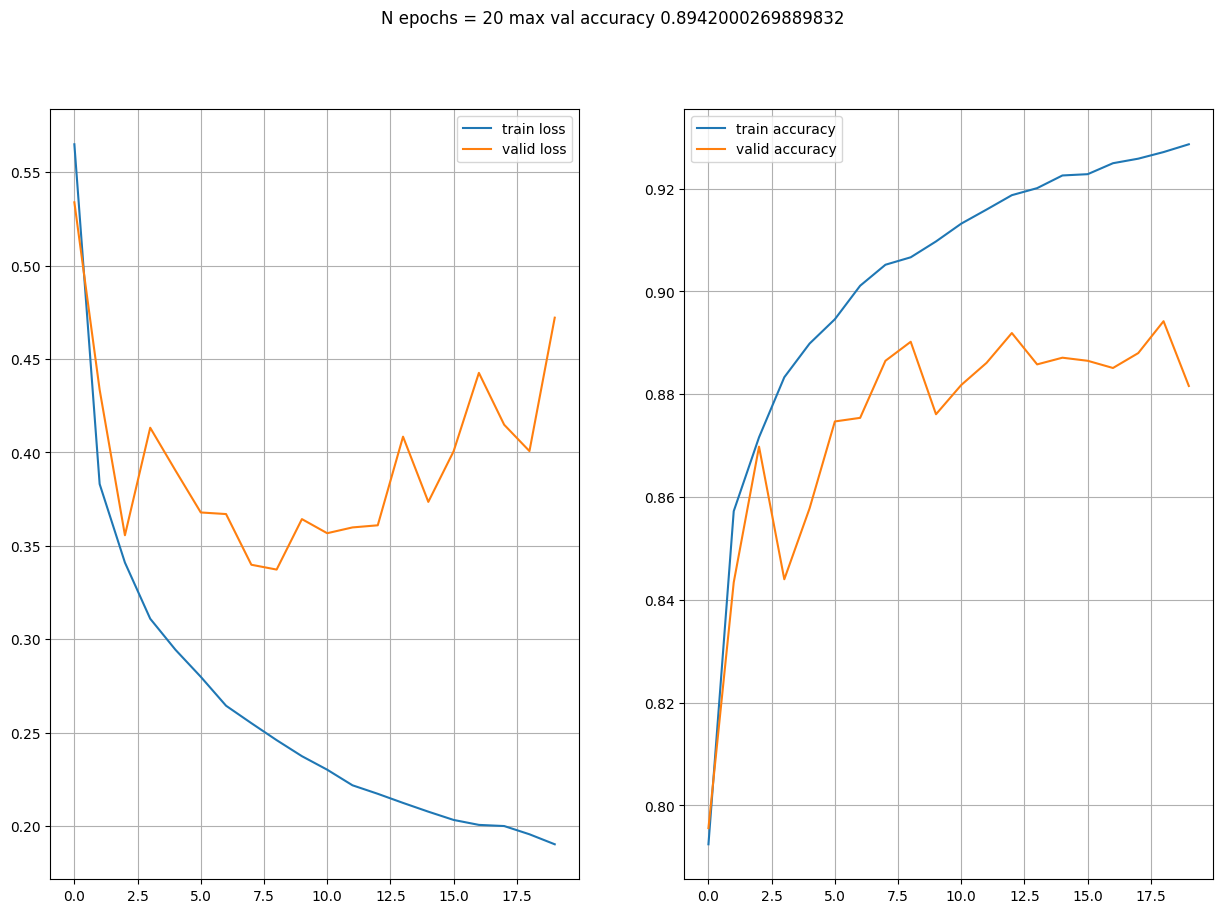

Epoch 1/50
469/469 [==============================] - 6s 11ms/step - loss: 0.5621 - accuracy: 0.7919 - val_loss: 0.4433 - val_accuracy: 0.8381
Epoch 2/50
469/469 [==============================] - 5s 11ms/step - loss: 0.3860 - accuracy: 0.8578 - val_loss: 0.3953 - val_accuracy: 0.8559
Epoch 3/50
469/469 [==============================] - 5s 11ms/step - loss: 0.3411 - accuracy: 0.8740 - val_loss: 0.3673 - val_accuracy: 0.8606
Epoch 4/50
469/469 [==============================] - 5s 11ms/step - loss: 0.3156 - accuracy: 0.8822 - val_loss: 0.3713 - val_accuracy: 0.8576
Epoch 5/50
469/469 [==============================] - 5s 11ms/step - loss: 0.2948 - accuracy: 0.8900 - val_loss: 0.3615 - val_accuracy: 0.8695
Epoch 6/50
469/469 [==============================] - 5s 11ms/step - loss: 0.2787 - accuracy: 0.8951 - val_loss: 0.3453 - val_accuracy: 0.8741
Epoch 7/50
469/469 [==============================] - 5s 11ms/step - loss: 0.2655 - accuracy: 0.8992 - val_loss: 0.3450 - val_accuracy: 0.8812

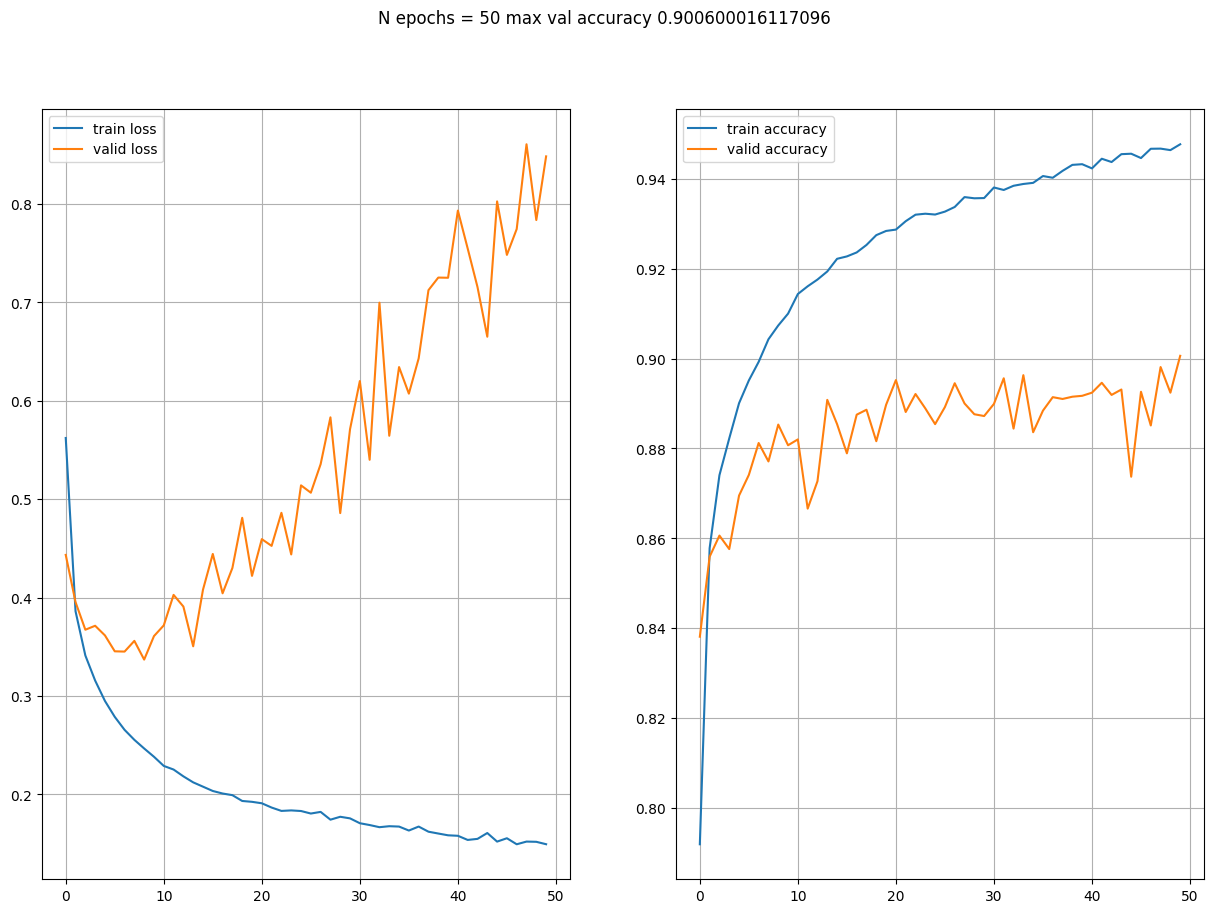

Epoch 1/100
469/469 [==============================] - 6s 12ms/step - loss: 0.5694 - accuracy: 0.7903 - val_loss: 0.4368 - val_accuracy: 0.8397
Epoch 2/100
469/469 [==============================] - 5s 11ms/step - loss: 0.3875 - accuracy: 0.8560 - val_loss: 0.3982 - val_accuracy: 0.8529
Epoch 3/100
469/469 [==============================] - 5s 11ms/step - loss: 0.3442 - accuracy: 0.8715 - val_loss: 0.3737 - val_accuracy: 0.8646
Epoch 4/100
469/469 [==============================] - 5s 11ms/step - loss: 0.3138 - accuracy: 0.8832 - val_loss: 0.3537 - val_accuracy: 0.8764
Epoch 5/100
469/469 [==============================] - 5s 11ms/step - loss: 0.2935 - accuracy: 0.8890 - val_loss: 0.3426 - val_accuracy: 0.8758
Epoch 6/100
469/469 [==============================] - 5s 11ms/step - loss: 0.2777 - accuracy: 0.8955 - val_loss: 0.3338 - val_accuracy: 0.8791
Epoch 7/100
469/469 [==============================] - 5s 11ms/step - loss: 0.2649 - accuracy: 0.8992 - val_loss: 0.3512 - val_accuracy:

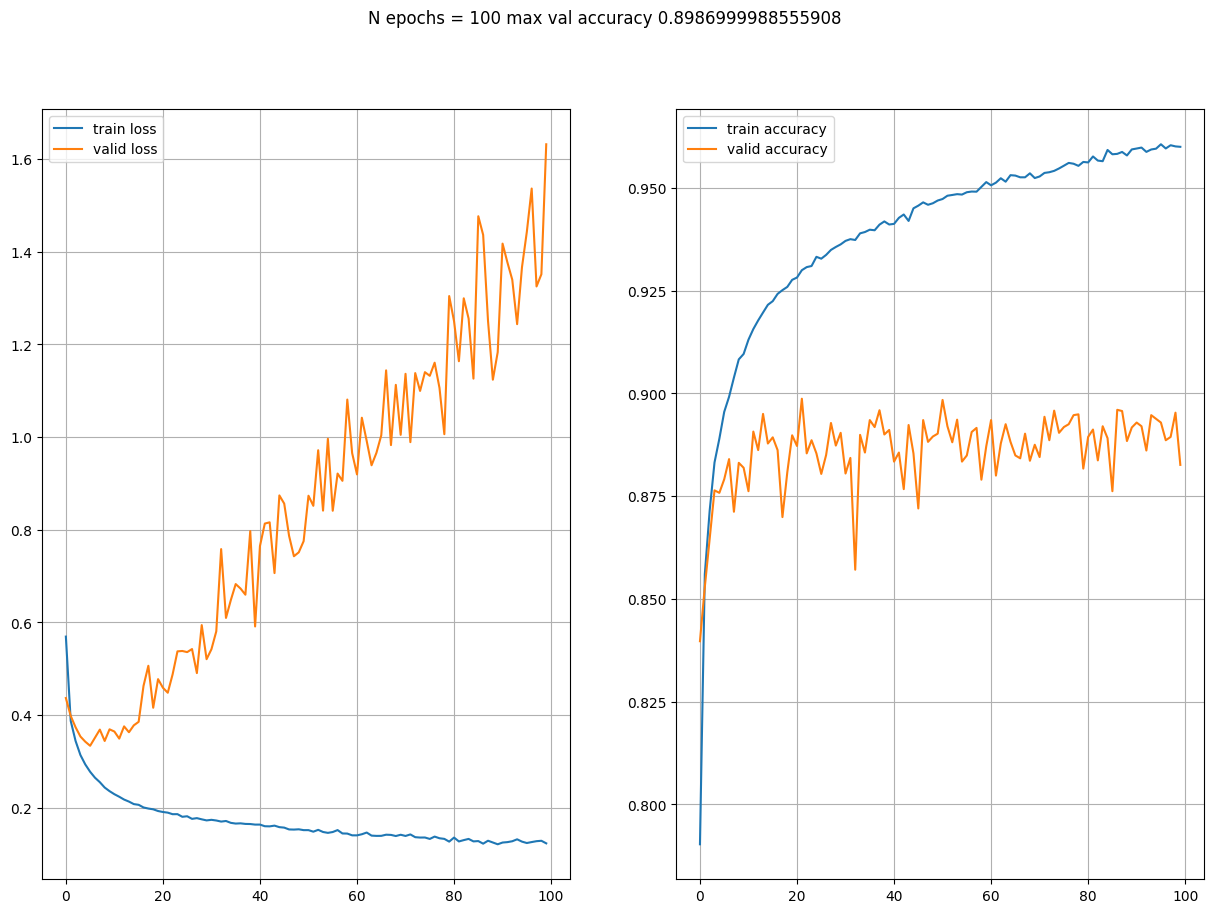

In [19]:
# Кількість епох
for n_e in n_epochs:
    model = create_model(get_def_layers(), RMSprop())
    ds = MyDataset(train_X, train_Y, batch_size=128, stratyfy=False)
    history = fit_and_present(model=model, fit_dataset=ds, val_dataset=(test_X, test_Y), epochs=n_e, description=f"N epochs = {n_e}")

З кількістю епох однозначно зростає точність на тренувальних даних, однак уже десь з 15 епохи видно, що модель входить у перенавчання: зростають втрати на валідаційних даних і чим далі тим більше. Прийшов час познайомитись з EarlyStopping.

Фіксуємо кількість епох в 100

Epoch 1/100
464/469 [============================>.] - ETA: 0s - loss: 0.5674 - accuracy: 0.7901 - categorical_crossentropy: 0.5674
Epoch 1: val_accuracy improved from -inf to 0.83420, saving model to checkpoints
INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


469/469 [==============================] - 8s 15ms/step - loss: 0.5655 - accuracy: 0.7908 - categorical_crossentropy: 0.5655 - val_loss: 0.4374 - val_accuracy: 0.8342 - val_categorical_crossentropy: 0.4374
Epoch 2/100
469/469 [==============================] - ETA: 0s - loss: 0.3891 - accuracy: 0.8561 - categorical_crossentropy: 0.3891
Epoch 2: val_accuracy improved from 0.83420 to 0.85290, saving model to checkpoints
INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


469/469 [==============================] - 6s 14ms/step - loss: 0.3891 - accuracy: 0.8561 - categorical_crossentropy: 0.3891 - val_loss: 0.3924 - val_accuracy: 0.8529 - val_categorical_crossentropy: 0.3924
Epoch 3/100
463/469 [============================>.] - ETA: 0s - loss: 0.3429 - accuracy: 0.8720 - categorical_crossentropy: 0.3429
Epoch 3: val_accuracy did not improve from 0.85290
469/469 [==============================] - 5s 11ms/step - loss: 0.3423 - accuracy: 0.8722 - categorical_crossentropy: 0.3423 - val_loss: 0.4403 - val_accuracy: 0.8349 - val_categorical_crossentropy: 0.4403
Epoch 4/100
466/469 [============================>.] - ETA: 0s - loss: 0.3154 - accuracy: 0.8826 - categorical_crossentropy: 0.3154
Epoch 4: val_accuracy improved from 0.85290 to 0.87220, saving model to checkpoints
INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


469/469 [==============================] - 6s 13ms/step - loss: 0.3155 - accuracy: 0.8827 - categorical_crossentropy: 0.3155 - val_loss: 0.3430 - val_accuracy: 0.8722 - val_categorical_crossentropy: 0.3430
Epoch 5/100
468/469 [============================>.] - ETA: 0s - loss: 0.2953 - accuracy: 0.8893 - categorical_crossentropy: 0.2953
Epoch 5: val_accuracy did not improve from 0.87220
469/469 [==============================] - 5s 11ms/step - loss: 0.2954 - accuracy: 0.8892 - categorical_crossentropy: 0.2954 - val_loss: 0.3655 - val_accuracy: 0.8663 - val_categorical_crossentropy: 0.3655
Epoch 6/100
469/469 [==============================] - ETA: 0s - loss: 0.2805 - accuracy: 0.8961 - categorical_crossentropy: 0.2805
Epoch 6: val_accuracy improved from 0.87220 to 0.87540, saving model to checkpoints
INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


469/469 [==============================] - 6s 13ms/step - loss: 0.2805 - accuracy: 0.8961 - categorical_crossentropy: 0.2805 - val_loss: 0.3445 - val_accuracy: 0.8754 - val_categorical_crossentropy: 0.3445
Epoch 7/100
468/469 [============================>.] - ETA: 0s - loss: 0.2650 - accuracy: 0.9003 - categorical_crossentropy: 0.2650
Epoch 7: val_accuracy improved from 0.87540 to 0.88140, saving model to checkpoints
INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


469/469 [==============================] - 6s 13ms/step - loss: 0.2650 - accuracy: 0.9003 - categorical_crossentropy: 0.2650 - val_loss: 0.3545 - val_accuracy: 0.8814 - val_categorical_crossentropy: 0.3545
Epoch 8/100
464/469 [============================>.] - ETA: 0s - loss: 0.2540 - accuracy: 0.9049 - categorical_crossentropy: 0.2540
Epoch 8: val_accuracy improved from 0.88140 to 0.88170, saving model to checkpoints
INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


469/469 [==============================] - 6s 13ms/step - loss: 0.2545 - accuracy: 0.9047 - categorical_crossentropy: 0.2545 - val_loss: 0.3491 - val_accuracy: 0.8817 - val_categorical_crossentropy: 0.3491
Epoch 9/100
465/469 [============================>.] - ETA: 0s - loss: 0.2442 - accuracy: 0.9087 - categorical_crossentropy: 0.2442
Epoch 9: val_accuracy did not improve from 0.88170
469/469 [==============================] - 5s 11ms/step - loss: 0.2447 - accuracy: 0.9086 - categorical_crossentropy: 0.2447 - val_loss: 0.3478 - val_accuracy: 0.8797 - val_categorical_crossentropy: 0.3478
Epoch 9: early stopping


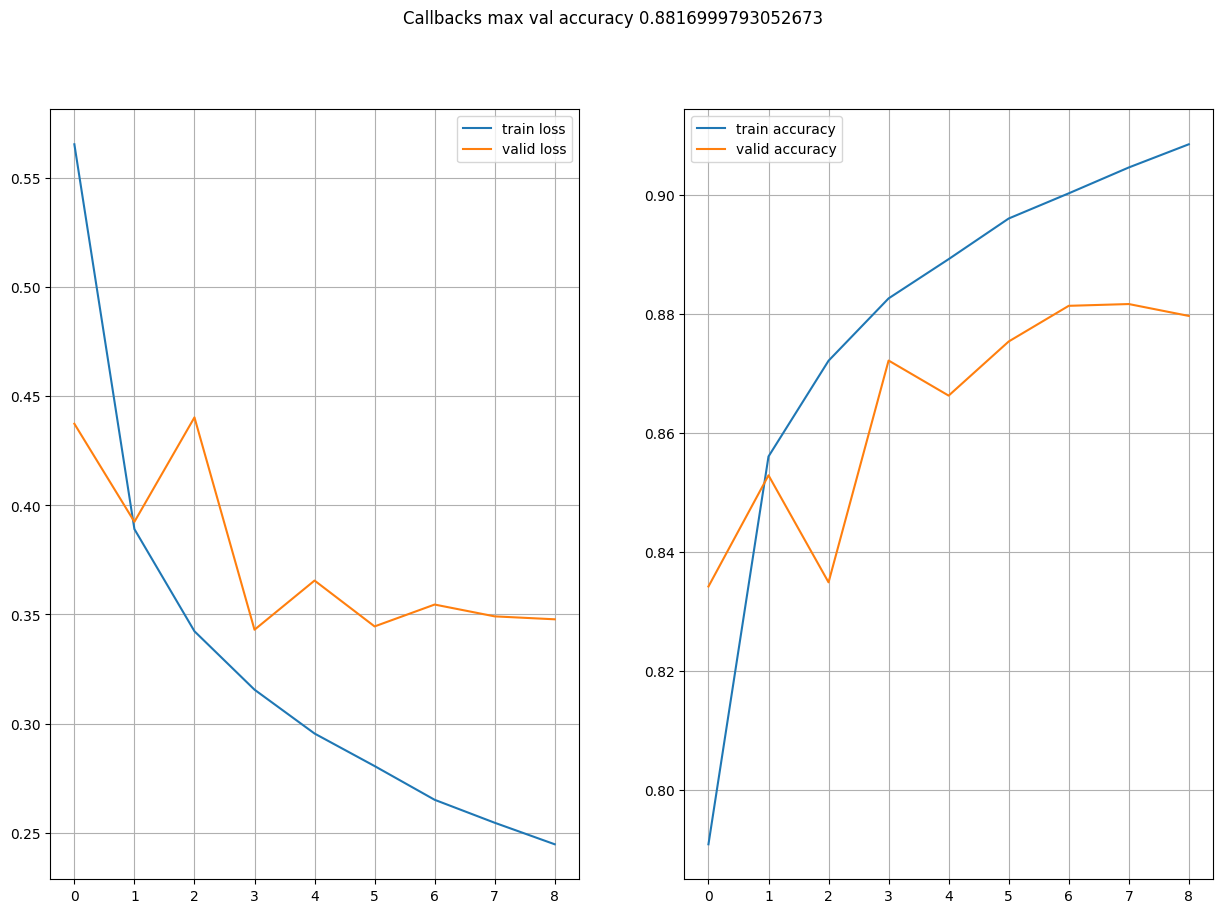

In [20]:
callback_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_categorical_crossentropy", mode="min", verbose=1, patience=5)
callback_save = tf.keras.callbacks.ModelCheckpoint(filepath="checkpoints", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

model = Sequential(get_def_layers())
model.compile(optimizer=RMSprop(), loss="categorical_crossentropy", metrics=["accuracy", "categorical_crossentropy"])

ds = MyDataset(train_X, train_Y, batch_size=128, stratyfy=False)

history = model.fit(ds, validation_data=(test_X, test_Y), epochs=100, workers=os.cpu_count()*2-1, callbacks=[callback_save, callback_early_stopping])
present_histiry("Callbacks", history)


Максимальна точність на валідаційних даних не така висока, як у попередніх експериментах, однак рання зупинка ловить початок процесу перенавчання, а чекпоінт зберігає найкращу модель. Разом вони економлять багато часу для експериментів. Тож перепишемо функцію навчання моделі і почнемо експерименти з шарами та регуляризацією

In [21]:
def create_model_2(layers, optimizer):
    model = Sequential(layers)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", "categorical_crossentropy"])

    return model

def fit_and_present_2(model:tf.keras.models.Sequential, fit_dataset, val_dataset, description="", epochs=100, filepath="checkpoints",patience=5):
    callback_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_categorical_crossentropy", mode="min", verbose=0, patience=patience)
    callback_save = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, save_best_only=True, monitor="val_accuracy", mode="max", verbose=0)
    history = model.fit(fit_dataset, validation_data=val_dataset, epochs=epochs, workers=os.cpu_count()*2-1, callbacks=[callback_save, callback_early_stopping])
    present_histiry(description, history)

    return history

def_ds = MyDataset(train_X, train_Y, batch_size=128, stratyfy=False)
val_dataset=(test_X, test_Y)




Epoch 1/100


467/469 [============================>.] - ETA: 0s - loss: 0.5788 - accuracy: 0.7879 - categorical_crossentropy: 0.5788INFO:tensorflow:Assets written to: big_la_cp\assets


INFO:tensorflow:Assets written to: big_la_cp\assets


469/469 [==============================] - 12s 24ms/step - loss: 0.5784 - accuracy: 0.7881 - categorical_crossentropy: 0.5784 - val_loss: 0.4273 - val_accuracy: 0.8427 - val_categorical_crossentropy: 0.4273
Epoch 2/100
467/469 [============================>.] - ETA: 0s - loss: 0.3879 - accuracy: 0.8566 - categorical_crossentropy: 0.3879INFO:tensorflow:Assets written to: big_la_cp\assets


INFO:tensorflow:Assets written to: big_la_cp\assets


469/469 [==============================] - 11s 23ms/step - loss: 0.3875 - accuracy: 0.8566 - categorical_crossentropy: 0.3875 - val_loss: 0.3860 - val_accuracy: 0.8567 - val_categorical_crossentropy: 0.3860
Epoch 3/100
469/469 [==============================] - 10s 21ms/step - loss: 0.3410 - accuracy: 0.8719 - categorical_crossentropy: 0.3410 - val_loss: 0.3898 - val_accuracy: 0.8546 - val_categorical_crossentropy: 0.3898
Epoch 4/100
469/469 [==============================] - ETA: 0s - loss: 0.3146 - accuracy: 0.8824 - categorical_crossentropy: 0.3146INFO:tensorflow:Assets written to: big_la_cp\assets


INFO:tensorflow:Assets written to: big_la_cp\assets


469/469 [==============================] - 11s 23ms/step - loss: 0.3146 - accuracy: 0.8824 - categorical_crossentropy: 0.3146 - val_loss: 0.3890 - val_accuracy: 0.8620 - val_categorical_crossentropy: 0.3890
Epoch 5/100
468/469 [============================>.] - ETA: 0s - loss: 0.2939 - accuracy: 0.8897 - categorical_crossentropy: 0.2939INFO:tensorflow:Assets written to: big_la_cp\assets


INFO:tensorflow:Assets written to: big_la_cp\assets


469/469 [==============================] - 11s 24ms/step - loss: 0.2938 - accuracy: 0.8898 - categorical_crossentropy: 0.2938 - val_loss: 0.3616 - val_accuracy: 0.8705 - val_categorical_crossentropy: 0.3616
Epoch 6/100
467/469 [============================>.] - ETA: 0s - loss: 0.2803 - accuracy: 0.8948 - categorical_crossentropy: 0.2803INFO:tensorflow:Assets written to: big_la_cp\assets


INFO:tensorflow:Assets written to: big_la_cp\assets


469/469 [==============================] - 11s 23ms/step - loss: 0.2807 - accuracy: 0.8947 - categorical_crossentropy: 0.2807 - val_loss: 0.3427 - val_accuracy: 0.8802 - val_categorical_crossentropy: 0.3427
Epoch 7/100
469/469 [==============================] - 10s 21ms/step - loss: 0.2655 - accuracy: 0.9003 - categorical_crossentropy: 0.2655 - val_loss: 0.3566 - val_accuracy: 0.8789 - val_categorical_crossentropy: 0.3566
Epoch 8/100
468/469 [============================>.] - ETA: 0s - loss: 0.2556 - accuracy: 0.9029 - categorical_crossentropy: 0.2556INFO:tensorflow:Assets written to: big_la_cp\assets


INFO:tensorflow:Assets written to: big_la_cp\assets


469/469 [==============================] - 11s 24ms/step - loss: 0.2555 - accuracy: 0.9029 - categorical_crossentropy: 0.2555 - val_loss: 0.3275 - val_accuracy: 0.8867 - val_categorical_crossentropy: 0.3275
Epoch 9/100
469/469 [==============================] - 10s 21ms/step - loss: 0.2479 - accuracy: 0.9059 - categorical_crossentropy: 0.2479 - val_loss: 0.3418 - val_accuracy: 0.8821 - val_categorical_crossentropy: 0.3418
Epoch 10/100
469/469 [==============================] - 10s 22ms/step - loss: 0.2390 - accuracy: 0.9099 - categorical_crossentropy: 0.2390 - val_loss: 0.3750 - val_accuracy: 0.8814 - val_categorical_crossentropy: 0.3750
Epoch 11/100
469/469 [==============================] - 10s 22ms/step - loss: 0.2326 - accuracy: 0.9127 - categorical_crossentropy: 0.2326 - val_loss: 0.3752 - val_accuracy: 0.8832 - val_categorical_crossentropy: 0.3752
Epoch 12/100
468/469 [============================>.] - ETA: 0s - loss: 0.2275 - accuracy: 0.9147 - categorical_crossentropy: 0.2275IN

INFO:tensorflow:Assets written to: big_la_cp\assets


469/469 [==============================] - 11s 24ms/step - loss: 0.2274 - accuracy: 0.9147 - categorical_crossentropy: 0.2274 - val_loss: 0.3499 - val_accuracy: 0.8892 - val_categorical_crossentropy: 0.3499
Epoch 13/100
469/469 [==============================] - 10s 21ms/step - loss: 0.2220 - accuracy: 0.9161 - categorical_crossentropy: 0.2220 - val_loss: 0.3406 - val_accuracy: 0.8879 - val_categorical_crossentropy: 0.3406


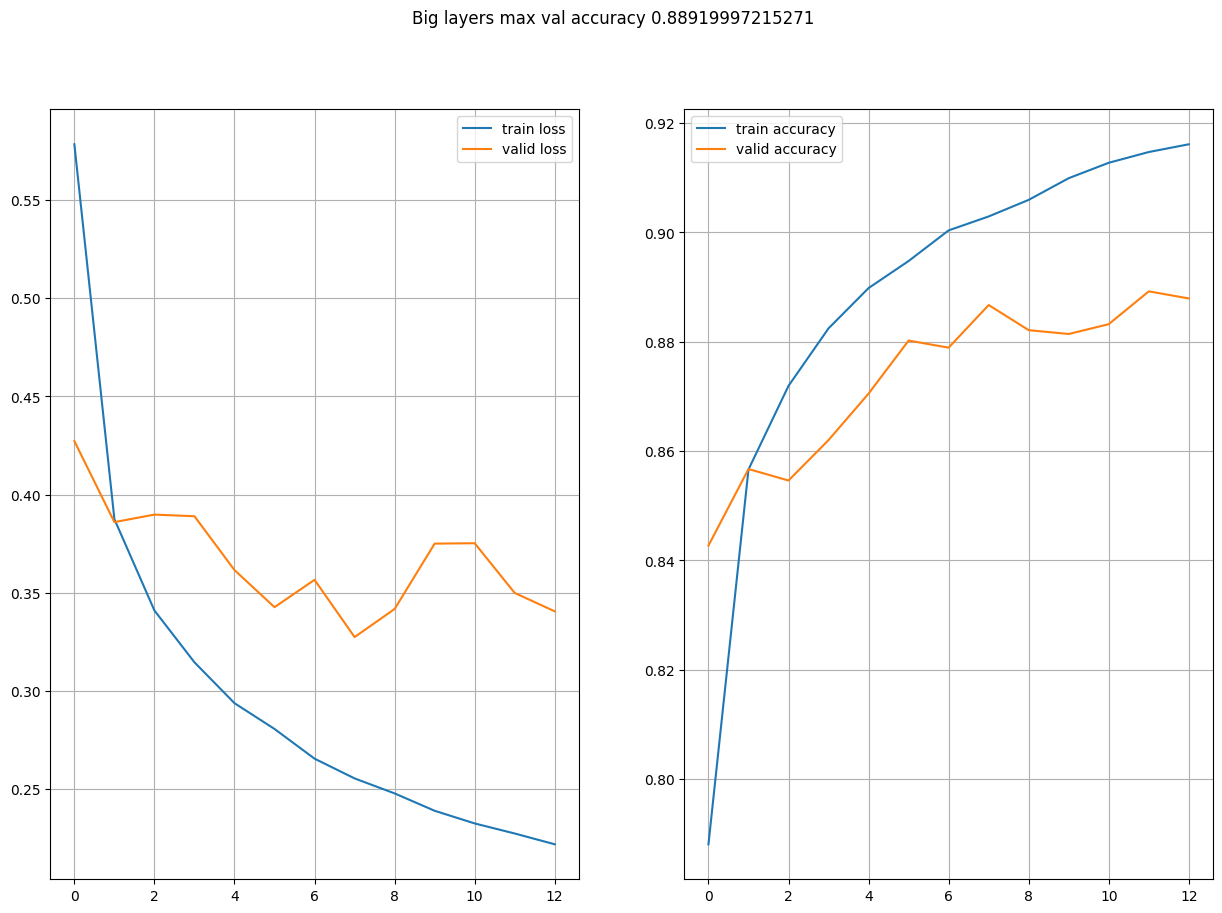

In [22]:
big_layers = [
    Dense(1024, activation="relu", input_shape=(28*28,)),
    Dense(512, activation="relu"),
    Dense(128, activation="relu"),
    Dense(10, activation="softmax"),
]

big_model = create_model_2(big_layers, RMSprop())
history = fit_and_present_2(big_model, def_ds, val_dataset, description="Big layers", filepath="big_la_cp")

Epoch 1/100


463/469 [============================>.] - ETA: 0s - loss: 0.5520 - accuracy: 0.7993 - categorical_crossentropy: 0.5520INFO:tensorflow:Assets written to: small_la_cp\assets


INFO:tensorflow:Assets written to: small_la_cp\assets


469/469 [==============================] - 5s 9ms/step - loss: 0.5500 - accuracy: 0.8001 - categorical_crossentropy: 0.5500 - val_loss: 0.4095 - val_accuracy: 0.8489 - val_categorical_crossentropy: 0.4095
Epoch 2/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3837 - accuracy: 0.8584 - categorical_crossentropy: 0.3837 - val_loss: 0.4845 - val_accuracy: 0.8308 - val_categorical_crossentropy: 0.4845
Epoch 3/100
469/469 [==============================] - ETA: 0s - loss: 0.3374 - accuracy: 0.8745 - categorical_crossentropy: 0.3374INFO:tensorflow:Assets written to: small_la_cp\assets


INFO:tensorflow:Assets written to: small_la_cp\assets


469/469 [==============================] - 3s 7ms/step - loss: 0.3374 - accuracy: 0.8745 - categorical_crossentropy: 0.3374 - val_loss: 0.3944 - val_accuracy: 0.8539 - val_categorical_crossentropy: 0.3944
Epoch 4/100
467/469 [============================>.] - ETA: 0s - loss: 0.3116 - accuracy: 0.8836 - categorical_crossentropy: 0.3116INFO:tensorflow:Assets written to: small_la_cp\assets


INFO:tensorflow:Assets written to: small_la_cp\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.3119 - accuracy: 0.8834 - categorical_crossentropy: 0.3119 - val_loss: 0.3880 - val_accuracy: 0.8545 - val_categorical_crossentropy: 0.3880
Epoch 5/100
469/469 [==============================] - ETA: 0s - loss: 0.2934 - accuracy: 0.8913 - categorical_crossentropy: 0.2934INFO:tensorflow:Assets written to: small_la_cp\assets


INFO:tensorflow:Assets written to: small_la_cp\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2934 - accuracy: 0.8913 - categorical_crossentropy: 0.2934 - val_loss: 0.3356 - val_accuracy: 0.8807 - val_categorical_crossentropy: 0.3356
Epoch 6/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2764 - accuracy: 0.8972 - categorical_crossentropy: 0.2764 - val_loss: 0.3688 - val_accuracy: 0.8640 - val_categorical_crossentropy: 0.3688
Epoch 7/100
469/469 [==============================] - 2s 5ms/step - loss: 0.2630 - accuracy: 0.9014 - categorical_crossentropy: 0.2630 - val_loss: 0.3490 - val_accuracy: 0.8773 - val_categorical_crossentropy: 0.3490
Epoch 8/100
465/469 [============================>.] - ETA: 0s - loss: 0.2511 - accuracy: 0.9051 - categorical_crossentropy: 0.2511INFO:tensorflow:Assets written to: small_la_cp\assets


INFO:tensorflow:Assets written to: small_la_cp\assets


469/469 [==============================] - 3s 7ms/step - loss: 0.2508 - accuracy: 0.9053 - categorical_crossentropy: 0.2508 - val_loss: 0.3366 - val_accuracy: 0.8834 - val_categorical_crossentropy: 0.3366
Epoch 9/100
469/469 [==============================] - 3s 5ms/step - loss: 0.2412 - accuracy: 0.9098 - categorical_crossentropy: 0.2412 - val_loss: 0.3416 - val_accuracy: 0.8830 - val_categorical_crossentropy: 0.3416
Epoch 10/100
459/469 [============================>.] - ETA: 0s - loss: 0.2326 - accuracy: 0.9128 - categorical_crossentropy: 0.2326INFO:tensorflow:Assets written to: small_la_cp\assets


INFO:tensorflow:Assets written to: small_la_cp\assets


469/469 [==============================] - 3s 7ms/step - loss: 0.2321 - accuracy: 0.9129 - categorical_crossentropy: 0.2321 - val_loss: 0.3351 - val_accuracy: 0.8868 - val_categorical_crossentropy: 0.3351
Epoch 11/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2244 - accuracy: 0.9158 - categorical_crossentropy: 0.2244 - val_loss: 0.3562 - val_accuracy: 0.8820 - val_categorical_crossentropy: 0.3562
Epoch 12/100
461/469 [============================>.] - ETA: 0s - loss: 0.2164 - accuracy: 0.9184 - categorical_crossentropy: 0.2164INFO:tensorflow:Assets written to: small_la_cp\assets


INFO:tensorflow:Assets written to: small_la_cp\assets


469/469 [==============================] - 3s 7ms/step - loss: 0.2166 - accuracy: 0.9184 - categorical_crossentropy: 0.2166 - val_loss: 0.3359 - val_accuracy: 0.8872 - val_categorical_crossentropy: 0.3359
Epoch 13/100
465/469 [============================>.] - ETA: 0s - loss: 0.2106 - accuracy: 0.9204 - categorical_crossentropy: 0.2106INFO:tensorflow:Assets written to: small_la_cp\assets


INFO:tensorflow:Assets written to: small_la_cp\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2105 - accuracy: 0.9204 - categorical_crossentropy: 0.2105 - val_loss: 0.3596 - val_accuracy: 0.8888 - val_categorical_crossentropy: 0.3596
Epoch 14/100
458/469 [============================>.] - ETA: 0s - loss: 0.2027 - accuracy: 0.9239 - categorical_crossentropy: 0.2027INFO:tensorflow:Assets written to: small_la_cp\assets


INFO:tensorflow:Assets written to: small_la_cp\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2027 - accuracy: 0.9239 - categorical_crossentropy: 0.2027 - val_loss: 0.3427 - val_accuracy: 0.8898 - val_categorical_crossentropy: 0.3427
Epoch 15/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1966 - accuracy: 0.9258 - categorical_crossentropy: 0.1966 - val_loss: 0.3650 - val_accuracy: 0.8884 - val_categorical_crossentropy: 0.3650


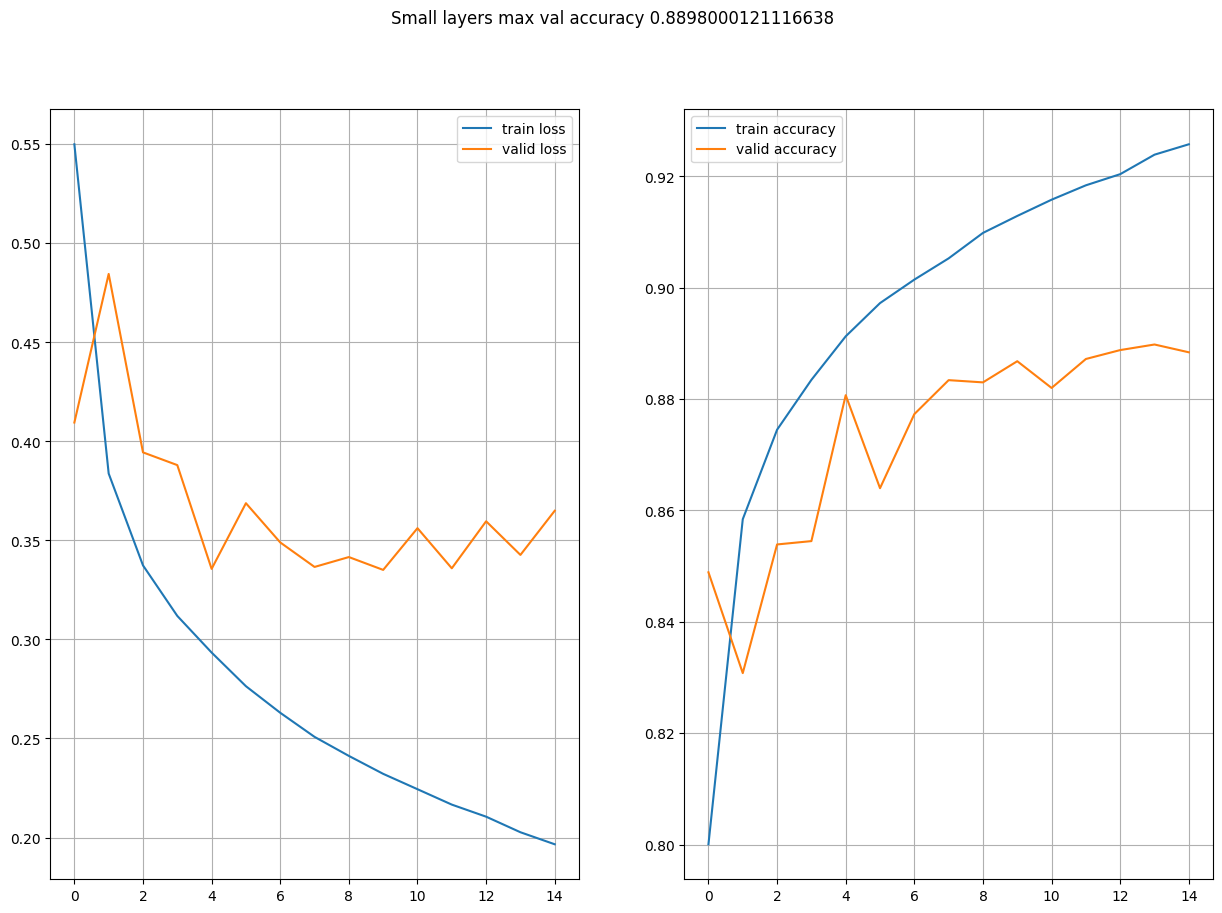

In [23]:
small_layers = [
    Dense(128, activation="relu", input_shape=(28*28,)),
    Dense(512, activation="relu"),
    Dense(10, activation="softmax"),
]

small_model = create_model_2(small_layers, RMSprop())
history = fit_and_present_2(small_model, def_ds, val_dataset, description="Small layers", filepath="small_la_cp")


Наразі важко зробити висновки по моделям: з одного боку, модель з більшою кількістю шарів і нейронів дала кращі результати по точності, однак вона програє по втратам і швидше переходить до перенавчання. Для обох моделей характерні "рвані" графіки втрат.

Отже, залишимо для подальшого дослідження обидві моделі і додамо регуляризацію Dropout

Epoch 1/100


469/469 [==============================] - ETA: 0s - loss: 0.5937 - accuracy: 0.7826 - categorical_crossentropy: 0.5937INFO:tensorflow:Assets written to: big_la_do_cp\assets


INFO:tensorflow:Assets written to: big_la_do_cp\assets


469/469 [==============================] - 13s 27ms/step - loss: 0.5937 - accuracy: 0.7826 - categorical_crossentropy: 0.5937 - val_loss: 0.4166 - val_accuracy: 0.8454 - val_categorical_crossentropy: 0.4166
Epoch 2/100
469/469 [==============================] - ETA: 0s - loss: 0.4132 - accuracy: 0.8477 - categorical_crossentropy: 0.4132INFO:tensorflow:Assets written to: big_la_do_cp\assets


INFO:tensorflow:Assets written to: big_la_do_cp\assets


469/469 [==============================] - 12s 26ms/step - loss: 0.4132 - accuracy: 0.8477 - categorical_crossentropy: 0.4132 - val_loss: 0.4114 - val_accuracy: 0.8523 - val_categorical_crossentropy: 0.4114
Epoch 3/100
468/469 [============================>.] - ETA: 0s - loss: 0.3700 - accuracy: 0.8640 - categorical_crossentropy: 0.3700INFO:tensorflow:Assets written to: big_la_do_cp\assets


INFO:tensorflow:Assets written to: big_la_do_cp\assets


469/469 [==============================] - 12s 26ms/step - loss: 0.3702 - accuracy: 0.8640 - categorical_crossentropy: 0.3702 - val_loss: 0.3545 - val_accuracy: 0.8726 - val_categorical_crossentropy: 0.3545
Epoch 4/100
469/469 [==============================] - 11s 24ms/step - loss: 0.3437 - accuracy: 0.8736 - categorical_crossentropy: 0.3437 - val_loss: 0.4192 - val_accuracy: 0.8473 - val_categorical_crossentropy: 0.4192
Epoch 5/100
468/469 [============================>.] - ETA: 0s - loss: 0.3293 - accuracy: 0.8777 - categorical_crossentropy: 0.3293INFO:tensorflow:Assets written to: big_la_do_cp\assets


INFO:tensorflow:Assets written to: big_la_do_cp\assets


469/469 [==============================] - 12s 26ms/step - loss: 0.3291 - accuracy: 0.8778 - categorical_crossentropy: 0.3291 - val_loss: 0.3506 - val_accuracy: 0.8770 - val_categorical_crossentropy: 0.3506
Epoch 6/100
469/469 [==============================] - 11s 24ms/step - loss: 0.3170 - accuracy: 0.8831 - categorical_crossentropy: 0.3170 - val_loss: 0.3480 - val_accuracy: 0.8723 - val_categorical_crossentropy: 0.3480
Epoch 7/100
468/469 [============================>.] - ETA: 0s - loss: 0.3076 - accuracy: 0.8859 - categorical_crossentropy: 0.3076INFO:tensorflow:Assets written to: big_la_do_cp\assets


INFO:tensorflow:Assets written to: big_la_do_cp\assets


469/469 [==============================] - 13s 27ms/step - loss: 0.3077 - accuracy: 0.8859 - categorical_crossentropy: 0.3077 - val_loss: 0.3469 - val_accuracy: 0.8786 - val_categorical_crossentropy: 0.3469
Epoch 8/100
469/469 [==============================] - 11s 24ms/step - loss: 0.2969 - accuracy: 0.8895 - categorical_crossentropy: 0.2969 - val_loss: 0.3377 - val_accuracy: 0.8764 - val_categorical_crossentropy: 0.3377
Epoch 9/100
469/469 [==============================] - 11s 24ms/step - loss: 0.2911 - accuracy: 0.8935 - categorical_crossentropy: 0.2911 - val_loss: 0.3555 - val_accuracy: 0.8774 - val_categorical_crossentropy: 0.3555
Epoch 10/100
469/469 [==============================] - ETA: 0s - loss: 0.2863 - accuracy: 0.8960 - categorical_crossentropy: 0.2863INFO:tensorflow:Assets written to: big_la_do_cp\assets


INFO:tensorflow:Assets written to: big_la_do_cp\assets


469/469 [==============================] - 13s 27ms/step - loss: 0.2863 - accuracy: 0.8960 - categorical_crossentropy: 0.2863 - val_loss: 0.3320 - val_accuracy: 0.8847 - val_categorical_crossentropy: 0.3320
Epoch 11/100
469/469 [==============================] - 11s 24ms/step - loss: 0.2825 - accuracy: 0.8957 - categorical_crossentropy: 0.2825 - val_loss: 0.3533 - val_accuracy: 0.8736 - val_categorical_crossentropy: 0.3533
Epoch 12/100
468/469 [============================>.] - ETA: 0s - loss: 0.2751 - accuracy: 0.8972 - categorical_crossentropy: 0.2751INFO:tensorflow:Assets written to: big_la_do_cp\assets


INFO:tensorflow:Assets written to: big_la_do_cp\assets


469/469 [==============================] - 12s 26ms/step - loss: 0.2750 - accuracy: 0.8972 - categorical_crossentropy: 0.2750 - val_loss: 0.3384 - val_accuracy: 0.8882 - val_categorical_crossentropy: 0.3384
Epoch 13/100
469/469 [==============================] - 11s 24ms/step - loss: 0.2730 - accuracy: 0.8990 - categorical_crossentropy: 0.2730 - val_loss: 0.3533 - val_accuracy: 0.8798 - val_categorical_crossentropy: 0.3533
Epoch 14/100
469/469 [==============================] - ETA: 0s - loss: 0.2678 - accuracy: 0.9020 - categorical_crossentropy: 0.2678INFO:tensorflow:Assets written to: big_la_do_cp\assets


INFO:tensorflow:Assets written to: big_la_do_cp\assets


469/469 [==============================] - 12s 26ms/step - loss: 0.2678 - accuracy: 0.9020 - categorical_crossentropy: 0.2678 - val_loss: 0.3274 - val_accuracy: 0.8886 - val_categorical_crossentropy: 0.3274
Epoch 15/100
469/469 [==============================] - 11s 24ms/step - loss: 0.2664 - accuracy: 0.9021 - categorical_crossentropy: 0.2664 - val_loss: 0.3561 - val_accuracy: 0.8718 - val_categorical_crossentropy: 0.3561
Epoch 16/100
469/469 [==============================] - 11s 24ms/step - loss: 0.2637 - accuracy: 0.9033 - categorical_crossentropy: 0.2637 - val_loss: 0.3438 - val_accuracy: 0.8860 - val_categorical_crossentropy: 0.3438
Epoch 17/100
469/469 [==============================] - 11s 24ms/step - loss: 0.2564 - accuracy: 0.9054 - categorical_crossentropy: 0.2564 - val_loss: 0.3505 - val_accuracy: 0.8877 - val_categorical_crossentropy: 0.3505
Epoch 18/100
469/469 [==============================] - 11s 24ms/step - loss: 0.2582 - accuracy: 0.9060 - categorical_crossentropy: 0

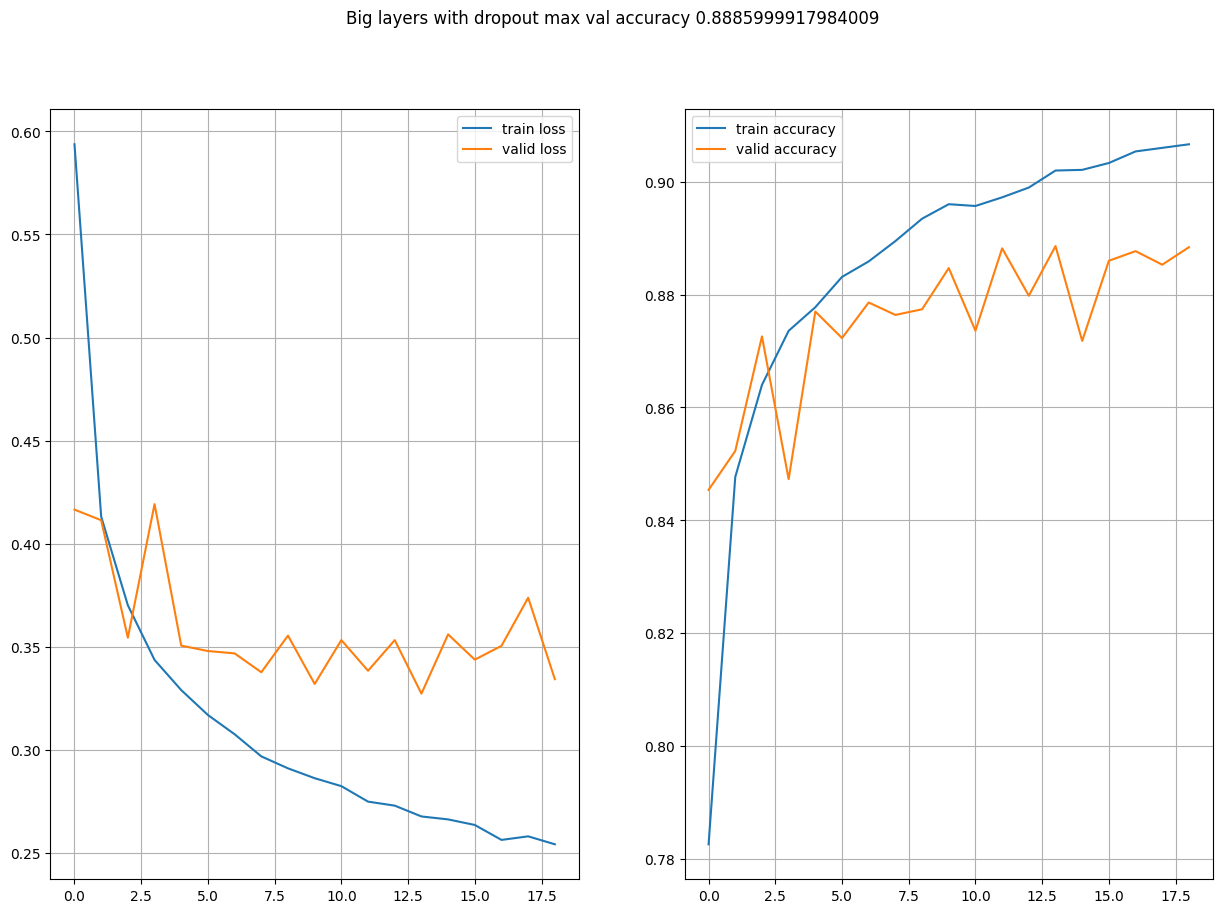

In [24]:
big_layers_DO = [
    Dense(1024, activation="relu", input_shape=(28*28,)),
    Dropout(0.2),
    Dense(512, activation="relu"),
    Dropout(0.2),
    Dense(128, activation="relu"),
    Dense(10, activation="softmax"),
]

big_model_DO = create_model_2(big_layers_DO, RMSprop())
history = fit_and_present_2(big_model_DO, def_ds, val_dataset, description="Big layers with dropout", filepath="big_la_do_cp")

Epoch 1/100


460/469 [============================>.] - ETA: 0s - loss: 0.5905 - accuracy: 0.7847 - categorical_crossentropy: 0.5905INFO:tensorflow:Assets written to: small_la_do_cp\assets


INFO:tensorflow:Assets written to: small_la_do_cp\assets


469/469 [==============================] - 6s 11ms/step - loss: 0.5887 - accuracy: 0.7854 - categorical_crossentropy: 0.5887 - val_loss: 0.4224 - val_accuracy: 0.8441 - val_categorical_crossentropy: 0.4224
Epoch 2/100
469/469 [==============================] - 3s 7ms/step - loss: 0.4181 - accuracy: 0.8482 - categorical_crossentropy: 0.4181 - val_loss: 0.4377 - val_accuracy: 0.8391 - val_categorical_crossentropy: 0.4377
Epoch 3/100
462/469 [============================>.] - ETA: 0s - loss: 0.3765 - accuracy: 0.8619 - categorical_crossentropy: 0.3765INFO:tensorflow:Assets written to: small_la_do_cp\assets


INFO:tensorflow:Assets written to: small_la_do_cp\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3762 - accuracy: 0.8619 - categorical_crossentropy: 0.3762 - val_loss: 0.3692 - val_accuracy: 0.8669 - val_categorical_crossentropy: 0.3692
Epoch 4/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3545 - accuracy: 0.8712 - categorical_crossentropy: 0.3545 - val_loss: 0.3888 - val_accuracy: 0.8639 - val_categorical_crossentropy: 0.3888
Epoch 5/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3389 - accuracy: 0.8745 - categorical_crossentropy: 0.3389 - val_loss: 0.3725 - val_accuracy: 0.8663 - val_categorical_crossentropy: 0.3725
Epoch 6/100
465/469 [============================>.] - ETA: 0s - loss: 0.3254 - accuracy: 0.8808 - categorical_crossentropy: 0.3254INFO:tensorflow:Assets written to: small_la_do_cp\assets


INFO:tensorflow:Assets written to: small_la_do_cp\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3257 - accuracy: 0.8806 - categorical_crossentropy: 0.3257 - val_loss: 0.3515 - val_accuracy: 0.8707 - val_categorical_crossentropy: 0.3515
Epoch 7/100
460/469 [============================>.] - ETA: 0s - loss: 0.3150 - accuracy: 0.8837 - categorical_crossentropy: 0.3150INFO:tensorflow:Assets written to: small_la_do_cp\assets


INFO:tensorflow:Assets written to: small_la_do_cp\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3150 - accuracy: 0.8835 - categorical_crossentropy: 0.3150 - val_loss: 0.3466 - val_accuracy: 0.8737 - val_categorical_crossentropy: 0.3466
Epoch 8/100
463/469 [============================>.] - ETA: 0s - loss: 0.3081 - accuracy: 0.8872 - categorical_crossentropy: 0.3081INFO:tensorflow:Assets written to: small_la_do_cp\assets


INFO:tensorflow:Assets written to: small_la_do_cp\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3079 - accuracy: 0.8874 - categorical_crossentropy: 0.3079 - val_loss: 0.3549 - val_accuracy: 0.8739 - val_categorical_crossentropy: 0.3549
Epoch 9/100
464/469 [============================>.] - ETA: 0s - loss: 0.2998 - accuracy: 0.8896 - categorical_crossentropy: 0.2998INFO:tensorflow:Assets written to: small_la_do_cp\assets


INFO:tensorflow:Assets written to: small_la_do_cp\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3004 - accuracy: 0.8893 - categorical_crossentropy: 0.3004 - val_loss: 0.3451 - val_accuracy: 0.8760 - val_categorical_crossentropy: 0.3451
Epoch 10/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2938 - accuracy: 0.8913 - categorical_crossentropy: 0.2938 - val_loss: 0.3622 - val_accuracy: 0.8729 - val_categorical_crossentropy: 0.3622
Epoch 11/100
460/469 [============================>.] - ETA: 0s - loss: 0.2880 - accuracy: 0.8944 - categorical_crossentropy: 0.2880INFO:tensorflow:Assets written to: small_la_do_cp\assets


INFO:tensorflow:Assets written to: small_la_do_cp\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2886 - accuracy: 0.8941 - categorical_crossentropy: 0.2886 - val_loss: 0.3450 - val_accuracy: 0.8765 - val_categorical_crossentropy: 0.3450
Epoch 12/100
468/469 [============================>.] - ETA: 0s - loss: 0.2829 - accuracy: 0.8954 - categorical_crossentropy: 0.2829INFO:tensorflow:Assets written to: small_la_do_cp\assets


INFO:tensorflow:Assets written to: small_la_do_cp\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.2829 - accuracy: 0.8954 - categorical_crossentropy: 0.2829 - val_loss: 0.3416 - val_accuracy: 0.8827 - val_categorical_crossentropy: 0.3416
Epoch 13/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2796 - accuracy: 0.8976 - categorical_crossentropy: 0.2796 - val_loss: 0.3610 - val_accuracy: 0.8795 - val_categorical_crossentropy: 0.3610
Epoch 14/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2732 - accuracy: 0.8984 - categorical_crossentropy: 0.2732 - val_loss: 0.3664 - val_accuracy: 0.8727 - val_categorical_crossentropy: 0.3664
Epoch 15/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2693 - accuracy: 0.8998 - categorical_crossentropy: 0.2693 - val_loss: 0.3480 - val_accuracy: 0.8780 - val_categorical_crossentropy: 0.3480
Epoch 16/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2681 - accuracy: 0.9018 - categorical_crossentropy: 0.2681 - v

INFO:tensorflow:Assets written to: small_la_do_cp\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2627 - accuracy: 0.9024 - categorical_crossentropy: 0.2627 - val_loss: 0.3390 - val_accuracy: 0.8834 - val_categorical_crossentropy: 0.3390
Epoch 18/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2580 - accuracy: 0.9040 - categorical_crossentropy: 0.2580 - val_loss: 0.3526 - val_accuracy: 0.8764 - val_categorical_crossentropy: 0.3526
Epoch 19/100
469/469 [==============================] - ETA: 0s - loss: 0.2582 - accuracy: 0.9054 - categorical_crossentropy: 0.2582INFO:tensorflow:Assets written to: small_la_do_cp\assets


INFO:tensorflow:Assets written to: small_la_do_cp\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2582 - accuracy: 0.9054 - categorical_crossentropy: 0.2582 - val_loss: 0.3419 - val_accuracy: 0.8882 - val_categorical_crossentropy: 0.3419
Epoch 20/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2534 - accuracy: 0.9062 - categorical_crossentropy: 0.2534 - val_loss: 0.3356 - val_accuracy: 0.8845 - val_categorical_crossentropy: 0.3356
Epoch 21/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2502 - accuracy: 0.9071 - categorical_crossentropy: 0.2502 - val_loss: 0.3666 - val_accuracy: 0.8864 - val_categorical_crossentropy: 0.3666


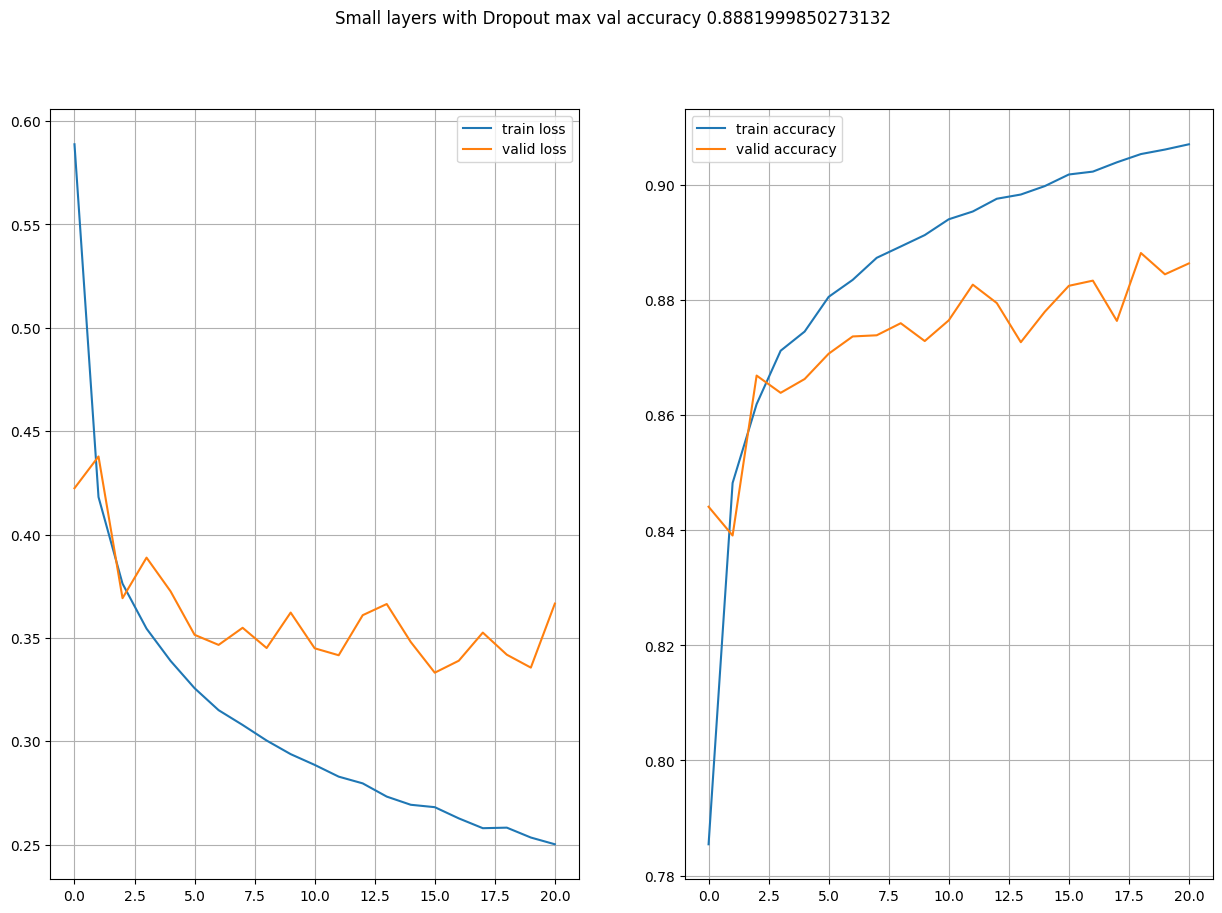

In [25]:
small_layers_DO = [
    Dense(128, activation="relu", input_shape=(28*28,)),
    Dropout(0.2),
    Dense(512, activation="relu"),
    Dropout(.2),
    Dense(10, activation="softmax"),
]

small_model_DO = create_model_2(small_layers_DO, RMSprop())
history = fit_and_present_2(small_model_DO, def_ds, val_dataset, description="Small layers with Dropout", filepath="small_la_do_cp")

Знову важко зробити однозначні висновки: для моделі з великою кількістю шарів/нейронів результат погіршився, для маленької моделі результат покращився, але все одно необхідні 91% поки недосяжні.

Змінимо шари регуляризації на GaussianDropout

Epoch 1/100


469/469 [==============================] - ETA: 0s - loss: 0.5885 - accuracy: 0.7827 - categorical_crossentropy: 0.5885INFO:tensorflow:Assets written to: big_la_gdo_cp\assets


INFO:tensorflow:Assets written to: big_la_gdo_cp\assets


469/469 [==============================] - 14s 27ms/step - loss: 0.5885 - accuracy: 0.7827 - categorical_crossentropy: 0.5885 - val_loss: 0.4263 - val_accuracy: 0.8410 - val_categorical_crossentropy: 0.4263
Epoch 2/100
469/469 [==============================] - ETA: 0s - loss: 0.4134 - accuracy: 0.8475 - categorical_crossentropy: 0.4134INFO:tensorflow:Assets written to: big_la_gdo_cp\assets


INFO:tensorflow:Assets written to: big_la_gdo_cp\assets


469/469 [==============================] - 12s 26ms/step - loss: 0.4134 - accuracy: 0.8475 - categorical_crossentropy: 0.4134 - val_loss: 0.3853 - val_accuracy: 0.8598 - val_categorical_crossentropy: 0.3853
Epoch 3/100
469/469 [==============================] - 11s 24ms/step - loss: 0.3690 - accuracy: 0.8648 - categorical_crossentropy: 0.3690 - val_loss: 0.3817 - val_accuracy: 0.8580 - val_categorical_crossentropy: 0.3817
Epoch 4/100
469/469 [==============================] - ETA: 0s - loss: 0.3450 - accuracy: 0.8734 - categorical_crossentropy: 0.3450INFO:tensorflow:Assets written to: big_la_gdo_cp\assets


INFO:tensorflow:Assets written to: big_la_gdo_cp\assets


469/469 [==============================] - 13s 27ms/step - loss: 0.3450 - accuracy: 0.8734 - categorical_crossentropy: 0.3450 - val_loss: 0.3788 - val_accuracy: 0.8641 - val_categorical_crossentropy: 0.3788
Epoch 5/100
468/469 [============================>.] - ETA: 0s - loss: 0.3279 - accuracy: 0.8786 - categorical_crossentropy: 0.3279INFO:tensorflow:Assets written to: big_la_gdo_cp\assets


INFO:tensorflow:Assets written to: big_la_gdo_cp\assets


469/469 [==============================] - 12s 26ms/step - loss: 0.3281 - accuracy: 0.8785 - categorical_crossentropy: 0.3281 - val_loss: 0.3498 - val_accuracy: 0.8708 - val_categorical_crossentropy: 0.3498
Epoch 6/100
469/469 [==============================] - 11s 24ms/step - loss: 0.3134 - accuracy: 0.8852 - categorical_crossentropy: 0.3134 - val_loss: 0.3577 - val_accuracy: 0.8700 - val_categorical_crossentropy: 0.3577
Epoch 7/100
469/469 [==============================] - ETA: 0s - loss: 0.3036 - accuracy: 0.8880 - categorical_crossentropy: 0.3036INFO:tensorflow:Assets written to: big_la_gdo_cp\assets


INFO:tensorflow:Assets written to: big_la_gdo_cp\assets


469/469 [==============================] - 12s 26ms/step - loss: 0.3036 - accuracy: 0.8880 - categorical_crossentropy: 0.3036 - val_loss: 0.3310 - val_accuracy: 0.8838 - val_categorical_crossentropy: 0.3310
Epoch 8/100
469/469 [==============================] - 11s 24ms/step - loss: 0.2956 - accuracy: 0.8911 - categorical_crossentropy: 0.2956 - val_loss: 0.3435 - val_accuracy: 0.8805 - val_categorical_crossentropy: 0.3435
Epoch 9/100
469/469 [==============================] - 12s 25ms/step - loss: 0.2886 - accuracy: 0.8932 - categorical_crossentropy: 0.2886 - val_loss: 0.3879 - val_accuracy: 0.8612 - val_categorical_crossentropy: 0.3879
Epoch 10/100
469/469 [==============================] - 11s 24ms/step - loss: 0.2840 - accuracy: 0.8964 - categorical_crossentropy: 0.2840 - val_loss: 0.3502 - val_accuracy: 0.8733 - val_categorical_crossentropy: 0.3502
Epoch 11/100
469/469 [==============================] - 11s 24ms/step - loss: 0.2781 - accuracy: 0.8980 - categorical_crossentropy: 0.2

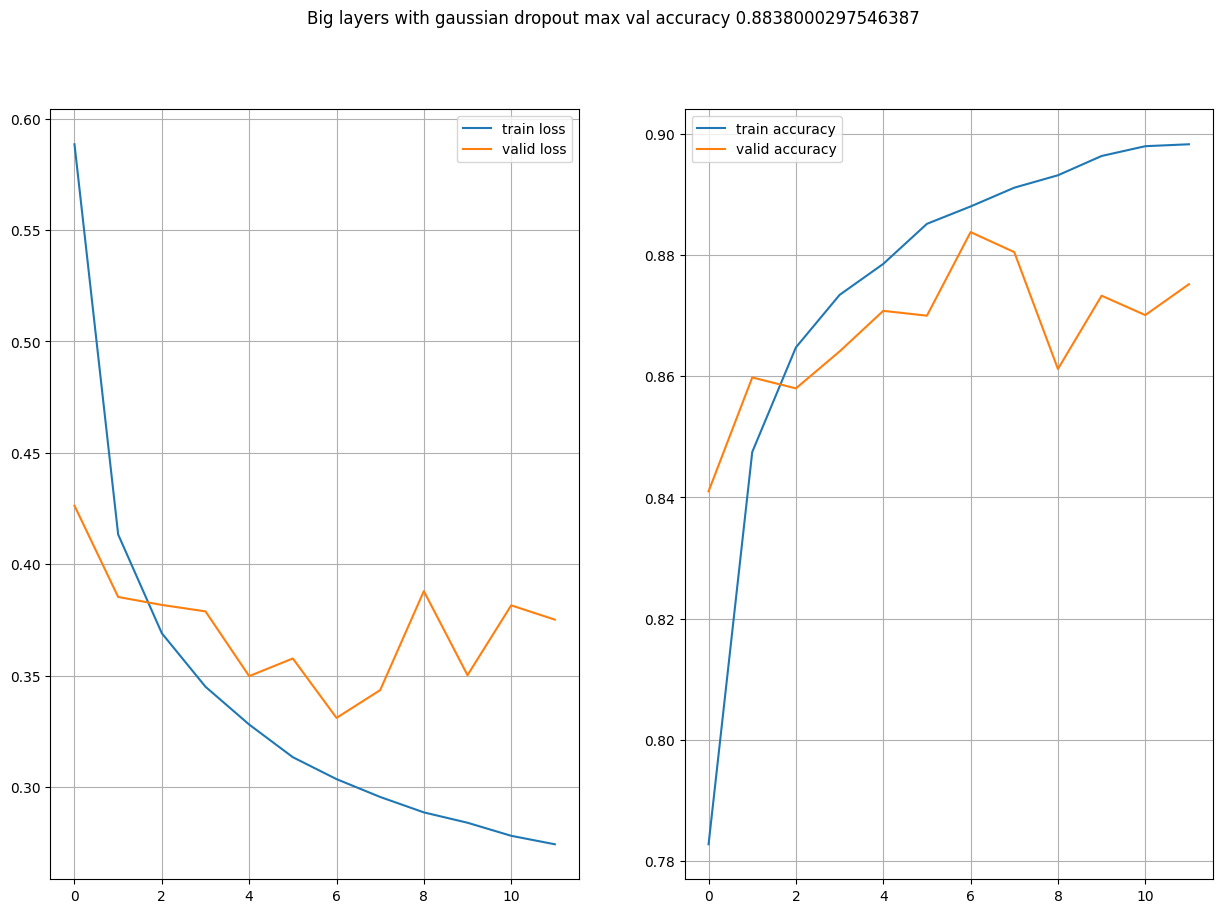

In [26]:
big_layers_GDO = [
    Dense(1024, activation="relu", input_shape=(28*28,)),
    GaussianDropout(0.2),
    Dense(512, activation="relu"),
    GaussianDropout(0.2),
    Dense(128, activation="relu"),
    Dense(10, activation="softmax"),
]

big_model_GDO = create_model_2(big_layers_GDO, RMSprop())
history = fit_and_present_2(big_model_GDO, def_ds, val_dataset, description="Big layers with gaussian dropout", filepath="big_la_gdo_cp")

Epoch 1/100


468/469 [============================>.] - ETA: 0s - loss: 0.5836 - accuracy: 0.7889 - categorical_crossentropy: 0.5836INFO:tensorflow:Assets written to: small_la_gdo_cp\assets


INFO:tensorflow:Assets written to: small_la_gdo_cp\assets


469/469 [==============================] - 6s 11ms/step - loss: 0.5833 - accuracy: 0.7890 - categorical_crossentropy: 0.5833 - val_loss: 0.4588 - val_accuracy: 0.8291 - val_categorical_crossentropy: 0.4588
Epoch 2/100
462/469 [============================>.] - ETA: 0s - loss: 0.4143 - accuracy: 0.8481 - categorical_crossentropy: 0.4143INFO:tensorflow:Assets written to: small_la_gdo_cp\assets


INFO:tensorflow:Assets written to: small_la_gdo_cp\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4135 - accuracy: 0.8483 - categorical_crossentropy: 0.4135 - val_loss: 0.3904 - val_accuracy: 0.8594 - val_categorical_crossentropy: 0.3904
Epoch 3/100
464/469 [============================>.] - ETA: 0s - loss: 0.3754 - accuracy: 0.8633 - categorical_crossentropy: 0.3754INFO:tensorflow:Assets written to: small_la_gdo_cp\assets


INFO:tensorflow:Assets written to: small_la_gdo_cp\assets


469/469 [==============================] - 4s 10ms/step - loss: 0.3754 - accuracy: 0.8632 - categorical_crossentropy: 0.3754 - val_loss: 0.3824 - val_accuracy: 0.8599 - val_categorical_crossentropy: 0.3824
Epoch 4/100
467/469 [============================>.] - ETA: 0s - loss: 0.3523 - accuracy: 0.8709 - categorical_crossentropy: 0.3523INFO:tensorflow:Assets written to: small_la_gdo_cp\assets


INFO:tensorflow:Assets written to: small_la_gdo_cp\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3521 - accuracy: 0.8710 - categorical_crossentropy: 0.3521 - val_loss: 0.3704 - val_accuracy: 0.8661 - val_categorical_crossentropy: 0.3704
Epoch 5/100
466/469 [============================>.] - ETA: 0s - loss: 0.3354 - accuracy: 0.8775 - categorical_crossentropy: 0.3354INFO:tensorflow:Assets written to: small_la_gdo_cp\assets


INFO:tensorflow:Assets written to: small_la_gdo_cp\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3355 - accuracy: 0.8775 - categorical_crossentropy: 0.3355 - val_loss: 0.3534 - val_accuracy: 0.8741 - val_categorical_crossentropy: 0.3534
Epoch 6/100
465/469 [============================>.] - ETA: 0s - loss: 0.3217 - accuracy: 0.8818 - categorical_crossentropy: 0.3217INFO:tensorflow:Assets written to: small_la_gdo_cp\assets


INFO:tensorflow:Assets written to: small_la_gdo_cp\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3215 - accuracy: 0.8819 - categorical_crossentropy: 0.3215 - val_loss: 0.3503 - val_accuracy: 0.8744 - val_categorical_crossentropy: 0.3503
Epoch 7/100
469/469 [==============================] - ETA: 0s - loss: 0.3121 - accuracy: 0.8862 - categorical_crossentropy: 0.3121INFO:tensorflow:Assets written to: small_la_gdo_cp\assets


INFO:tensorflow:Assets written to: small_la_gdo_cp\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3121 - accuracy: 0.8862 - categorical_crossentropy: 0.3121 - val_loss: 0.3388 - val_accuracy: 0.8782 - val_categorical_crossentropy: 0.3388
Epoch 8/100
461/469 [============================>.] - ETA: 0s - loss: 0.3013 - accuracy: 0.8895 - categorical_crossentropy: 0.3013INFO:tensorflow:Assets written to: small_la_gdo_cp\assets


INFO:tensorflow:Assets written to: small_la_gdo_cp\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3012 - accuracy: 0.8895 - categorical_crossentropy: 0.3012 - val_loss: 0.3577 - val_accuracy: 0.8799 - val_categorical_crossentropy: 0.3577
Epoch 9/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2956 - accuracy: 0.8921 - categorical_crossentropy: 0.2956 - val_loss: 0.3255 - val_accuracy: 0.8796 - val_categorical_crossentropy: 0.3255
Epoch 10/100
467/469 [============================>.] - ETA: 0s - loss: 0.2906 - accuracy: 0.8938 - categorical_crossentropy: 0.2906INFO:tensorflow:Assets written to: small_la_gdo_cp\assets


INFO:tensorflow:Assets written to: small_la_gdo_cp\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2905 - accuracy: 0.8938 - categorical_crossentropy: 0.2905 - val_loss: 0.3287 - val_accuracy: 0.8844 - val_categorical_crossentropy: 0.3287
Epoch 11/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2804 - accuracy: 0.8964 - categorical_crossentropy: 0.2804 - val_loss: 0.3463 - val_accuracy: 0.8768 - val_categorical_crossentropy: 0.3463
Epoch 12/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2749 - accuracy: 0.9003 - categorical_crossentropy: 0.2749 - val_loss: 0.3511 - val_accuracy: 0.8783 - val_categorical_crossentropy: 0.3511
Epoch 13/100
466/469 [============================>.] - ETA: 0s - loss: 0.2738 - accuracy: 0.9004 - categorical_crossentropy: 0.2738INFO:tensorflow:Assets written to: small_la_gdo_cp\assets


INFO:tensorflow:Assets written to: small_la_gdo_cp\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2737 - accuracy: 0.9004 - categorical_crossentropy: 0.2737 - val_loss: 0.3373 - val_accuracy: 0.8847 - val_categorical_crossentropy: 0.3373
Epoch 14/100
465/469 [============================>.] - ETA: 0s - loss: 0.2693 - accuracy: 0.9007 - categorical_crossentropy: 0.2693INFO:tensorflow:Assets written to: small_la_gdo_cp\assets


INFO:tensorflow:Assets written to: small_la_gdo_cp\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.2690 - accuracy: 0.9009 - categorical_crossentropy: 0.2690 - val_loss: 0.3280 - val_accuracy: 0.8892 - val_categorical_crossentropy: 0.3280


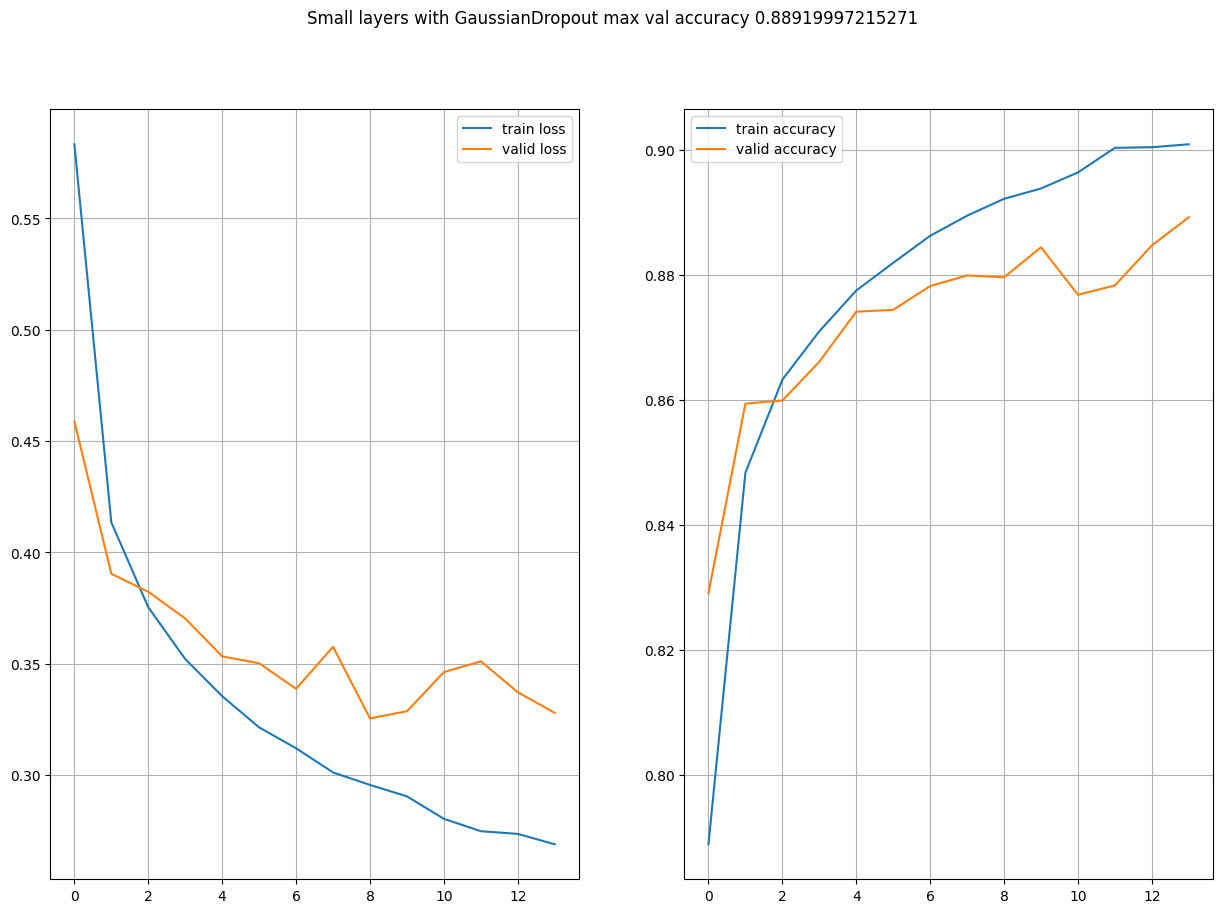

In [27]:
small_layers_GDO = [
    Dense(128, activation="relu", input_shape=(28*28,)),
    GaussianDropout(0.2),
    Dense(512, activation="relu"),
    GaussianDropout(.2),
    Dense(10, activation="softmax"),
]

small_model_GDO = create_model_2(small_layers_GDO, RMSprop())
history = fit_and_present_2(small_model_GDO, def_ds, val_dataset, description="Small layers with GaussianDropout", filepath="small_la_gdo_cp")

Результати покращились для двох моделей, але все ще не є прийнятними. Спробуємо ще й GaussianNoise 

Epoch 1/100


468/469 [============================>.] - ETA: 0s - loss: 0.5999 - accuracy: 0.7782 - categorical_crossentropy: 0.5999INFO:tensorflow:Assets written to: big_la_gn_cp\assets


INFO:tensorflow:Assets written to: big_la_gn_cp\assets


469/469 [==============================] - 14s 27ms/step - loss: 0.5996 - accuracy: 0.7782 - categorical_crossentropy: 0.5996 - val_loss: 0.4798 - val_accuracy: 0.8243 - val_categorical_crossentropy: 0.4798
Epoch 2/100
467/469 [============================>.] - ETA: 0s - loss: 0.4068 - accuracy: 0.8491 - categorical_crossentropy: 0.4068INFO:tensorflow:Assets written to: big_la_gn_cp\assets


INFO:tensorflow:Assets written to: big_la_gn_cp\assets


469/469 [==============================] - 12s 26ms/step - loss: 0.4064 - accuracy: 0.8492 - categorical_crossentropy: 0.4064 - val_loss: 0.4315 - val_accuracy: 0.8452 - val_categorical_crossentropy: 0.4315
Epoch 3/100
469/469 [==============================] - ETA: 0s - loss: 0.3612 - accuracy: 0.8653 - categorical_crossentropy: 0.3612INFO:tensorflow:Assets written to: big_la_gn_cp\assets


INFO:tensorflow:Assets written to: big_la_gn_cp\assets


469/469 [==============================] - 13s 27ms/step - loss: 0.3612 - accuracy: 0.8653 - categorical_crossentropy: 0.3612 - val_loss: 0.3654 - val_accuracy: 0.8687 - val_categorical_crossentropy: 0.3654
Epoch 4/100
469/469 [==============================] - 11s 24ms/step - loss: 0.3340 - accuracy: 0.8753 - categorical_crossentropy: 0.3340 - val_loss: 0.3603 - val_accuracy: 0.8663 - val_categorical_crossentropy: 0.3603
Epoch 5/100
469/469 [==============================] - ETA: 0s - loss: 0.3174 - accuracy: 0.8807 - categorical_crossentropy: 0.3174INFO:tensorflow:Assets written to: big_la_gn_cp\assets


INFO:tensorflow:Assets written to: big_la_gn_cp\assets


469/469 [==============================] - 13s 27ms/step - loss: 0.3174 - accuracy: 0.8807 - categorical_crossentropy: 0.3174 - val_loss: 0.3380 - val_accuracy: 0.8772 - val_categorical_crossentropy: 0.3380
Epoch 6/100
469/469 [==============================] - 11s 24ms/step - loss: 0.3018 - accuracy: 0.8867 - categorical_crossentropy: 0.3018 - val_loss: 0.3619 - val_accuracy: 0.8707 - val_categorical_crossentropy: 0.3619
Epoch 7/100
467/469 [============================>.] - ETA: 0s - loss: 0.2926 - accuracy: 0.8900 - categorical_crossentropy: 0.2926INFO:tensorflow:Assets written to: big_la_gn_cp\assets


INFO:tensorflow:Assets written to: big_la_gn_cp\assets


469/469 [==============================] - 12s 26ms/step - loss: 0.2923 - accuracy: 0.8901 - categorical_crossentropy: 0.2923 - val_loss: 0.3506 - val_accuracy: 0.8809 - val_categorical_crossentropy: 0.3506
Epoch 8/100
469/469 [==============================] - 11s 24ms/step - loss: 0.2814 - accuracy: 0.8945 - categorical_crossentropy: 0.2814 - val_loss: 0.3627 - val_accuracy: 0.8689 - val_categorical_crossentropy: 0.3627
Epoch 9/100
469/469 [==============================] - 11s 24ms/step - loss: 0.2727 - accuracy: 0.8978 - categorical_crossentropy: 0.2727 - val_loss: 0.3790 - val_accuracy: 0.8702 - val_categorical_crossentropy: 0.3790
Epoch 10/100
469/469 [==============================] - ETA: 0s - loss: 0.2664 - accuracy: 0.9000 - categorical_crossentropy: 0.2664INFO:tensorflow:Assets written to: big_la_gn_cp\assets


INFO:tensorflow:Assets written to: big_la_gn_cp\assets


469/469 [==============================] - 13s 27ms/step - loss: 0.2664 - accuracy: 0.9000 - categorical_crossentropy: 0.2664 - val_loss: 0.3565 - val_accuracy: 0.8819 - val_categorical_crossentropy: 0.3565


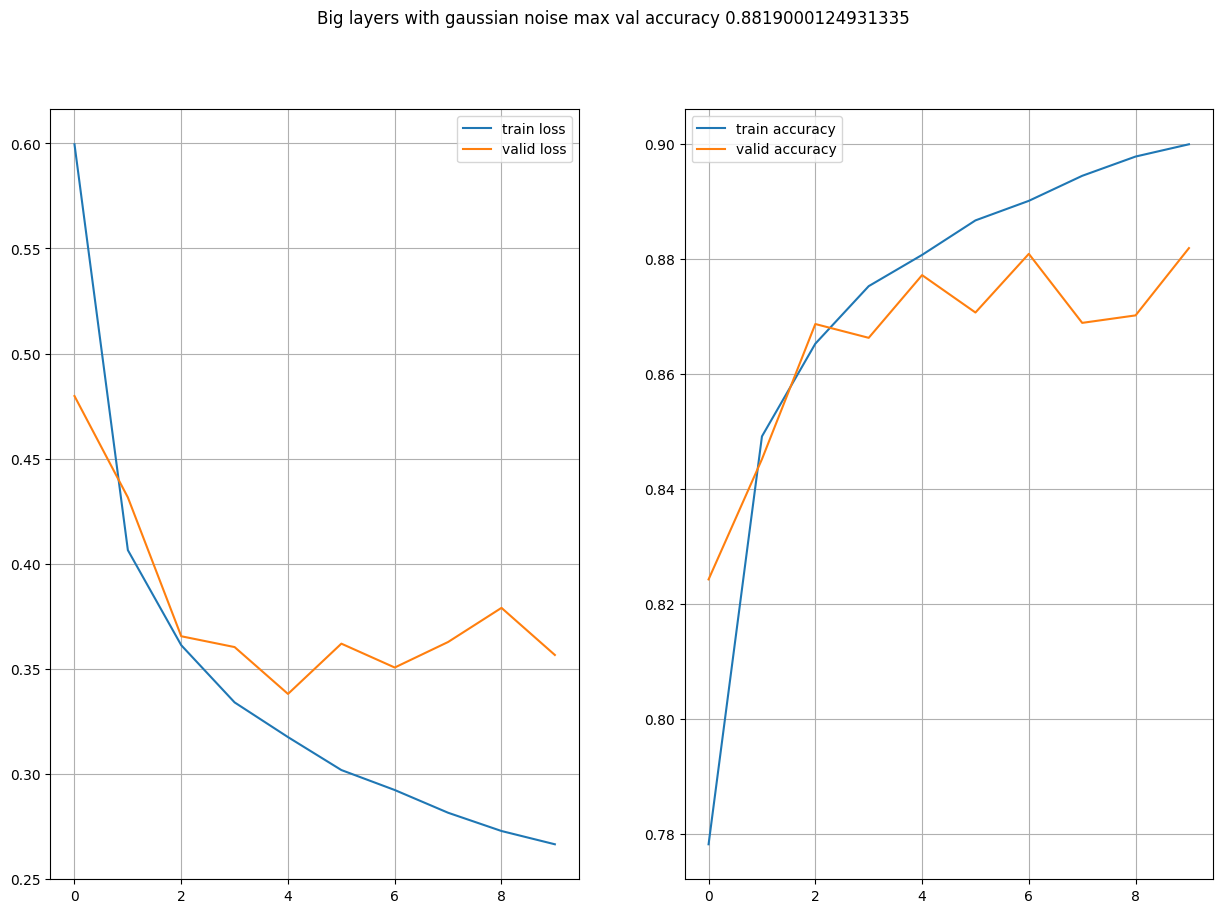

In [28]:
big_layers_GN = [
    Dense(1024, activation="relu", input_shape=(28*28,)),
    GaussianNoise(0.2),
    Dense(512, activation="relu"),
    GaussianNoise(0.2),
    Dense(128, activation="relu"),
    Dense(10, activation="softmax"),
]

big_model_GN = create_model_2(big_layers_GN, RMSprop())
history = fit_and_present_2(big_model_GN, def_ds, val_dataset, description="Big layers with gaussian noise", filepath="big_la_gn_cp")

Epoch 1/100
 24/469 [>.............................] - ETA: 2s - loss: 1.2444 - accuracy: 0.5661 - categorical_crossentropy: 1.2444 

466/469 [============================>.] - ETA: 0s - loss: 0.5813 - accuracy: 0.7875 - categorical_crossentropy: 0.5813INFO:tensorflow:Assets written to: small_la_gn_cp\assets


INFO:tensorflow:Assets written to: small_la_gn_cp\assets


469/469 [==============================] - 5s 9ms/step - loss: 0.5810 - accuracy: 0.7876 - categorical_crossentropy: 0.5810 - val_loss: 0.5107 - val_accuracy: 0.7998 - val_categorical_crossentropy: 0.5107
Epoch 2/100
462/469 [============================>.] - ETA: 0s - loss: 0.4116 - accuracy: 0.8480 - categorical_crossentropy: 0.4116INFO:tensorflow:Assets written to: small_la_gn_cp\assets


INFO:tensorflow:Assets written to: small_la_gn_cp\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4112 - accuracy: 0.8480 - categorical_crossentropy: 0.4112 - val_loss: 0.4044 - val_accuracy: 0.8517 - val_categorical_crossentropy: 0.4044
Epoch 3/100
461/469 [============================>.] - ETA: 0s - loss: 0.3682 - accuracy: 0.8640 - categorical_crossentropy: 0.3682INFO:tensorflow:Assets written to: small_la_gn_cp\assets


INFO:tensorflow:Assets written to: small_la_gn_cp\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3682 - accuracy: 0.8640 - categorical_crossentropy: 0.3682 - val_loss: 0.3767 - val_accuracy: 0.8636 - val_categorical_crossentropy: 0.3767
Epoch 4/100
461/469 [============================>.] - ETA: 0s - loss: 0.3386 - accuracy: 0.8756 - categorical_crossentropy: 0.3386INFO:tensorflow:Assets written to: small_la_gn_cp\assets


INFO:tensorflow:Assets written to: small_la_gn_cp\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3387 - accuracy: 0.8755 - categorical_crossentropy: 0.3387 - val_loss: 0.3491 - val_accuracy: 0.8730 - val_categorical_crossentropy: 0.3491
Epoch 5/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3227 - accuracy: 0.8799 - categorical_crossentropy: 0.3227 - val_loss: 0.3601 - val_accuracy: 0.8679 - val_categorical_crossentropy: 0.3601
Epoch 6/100
461/469 [============================>.] - ETA: 0s - loss: 0.3076 - accuracy: 0.8842 - categorical_crossentropy: 0.3076INFO:tensorflow:Assets written to: small_la_gn_cp\assets


INFO:tensorflow:Assets written to: small_la_gn_cp\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.3071 - accuracy: 0.8845 - categorical_crossentropy: 0.3071 - val_loss: 0.3442 - val_accuracy: 0.8737 - val_categorical_crossentropy: 0.3442
Epoch 7/100
468/469 [============================>.] - ETA: 0s - loss: 0.2945 - accuracy: 0.8891 - categorical_crossentropy: 0.2945INFO:tensorflow:Assets written to: small_la_gn_cp\assets


INFO:tensorflow:Assets written to: small_la_gn_cp\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.2945 - accuracy: 0.8891 - categorical_crossentropy: 0.2945 - val_loss: 0.3486 - val_accuracy: 0.8771 - val_categorical_crossentropy: 0.3486
Epoch 8/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2811 - accuracy: 0.8943 - categorical_crossentropy: 0.2811 - val_loss: 0.3413 - val_accuracy: 0.8738 - val_categorical_crossentropy: 0.3413
Epoch 9/100
457/469 [============================>.] - ETA: 0s - loss: 0.2724 - accuracy: 0.8977 - categorical_crossentropy: 0.2724INFO:tensorflow:Assets written to: small_la_gn_cp\assets


INFO:tensorflow:Assets written to: small_la_gn_cp\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2725 - accuracy: 0.8978 - categorical_crossentropy: 0.2725 - val_loss: 0.3187 - val_accuracy: 0.8836 - val_categorical_crossentropy: 0.3187
Epoch 10/100
466/469 [============================>.] - ETA: 0s - loss: 0.2663 - accuracy: 0.9000 - categorical_crossentropy: 0.2663INFO:tensorflow:Assets written to: small_la_gn_cp\assets


INFO:tensorflow:Assets written to: small_la_gn_cp\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.2663 - accuracy: 0.9000 - categorical_crossentropy: 0.2663 - val_loss: 0.3206 - val_accuracy: 0.8878 - val_categorical_crossentropy: 0.3206
Epoch 11/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2569 - accuracy: 0.9027 - categorical_crossentropy: 0.2569 - val_loss: 0.3256 - val_accuracy: 0.8840 - val_categorical_crossentropy: 0.3256
Epoch 12/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2489 - accuracy: 0.9058 - categorical_crossentropy: 0.2489 - val_loss: 0.3380 - val_accuracy: 0.8847 - val_categorical_crossentropy: 0.3380
Epoch 13/100
467/469 [============================>.] - ETA: 0s - loss: 0.2430 - accuracy: 0.9072 - categorical_crossentropy: 0.2430INFO:tensorflow:Assets written to: small_la_gn_cp\assets


INFO:tensorflow:Assets written to: small_la_gn_cp\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2431 - accuracy: 0.9071 - categorical_crossentropy: 0.2431 - val_loss: 0.3139 - val_accuracy: 0.8899 - val_categorical_crossentropy: 0.3139
Epoch 14/100
464/469 [============================>.] - ETA: 0s - loss: 0.2368 - accuracy: 0.9105 - categorical_crossentropy: 0.2368INFO:tensorflow:Assets written to: small_la_gn_cp\assets


INFO:tensorflow:Assets written to: small_la_gn_cp\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2368 - accuracy: 0.9105 - categorical_crossentropy: 0.2368 - val_loss: 0.3176 - val_accuracy: 0.8933 - val_categorical_crossentropy: 0.3176
Epoch 15/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2300 - accuracy: 0.9132 - categorical_crossentropy: 0.2300 - val_loss: 0.3794 - val_accuracy: 0.8755 - val_categorical_crossentropy: 0.3794
Epoch 16/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2253 - accuracy: 0.9150 - categorical_crossentropy: 0.2253 - val_loss: 0.3282 - val_accuracy: 0.8917 - val_categorical_crossentropy: 0.3282
Epoch 17/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2192 - accuracy: 0.9161 - categorical_crossentropy: 0.2192 - val_loss: 0.3334 - val_accuracy: 0.8922 - val_categorical_crossentropy: 0.3334
Epoch 18/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2166 - accuracy: 0.9176 - categorical_crossentropy: 0.2166 - va

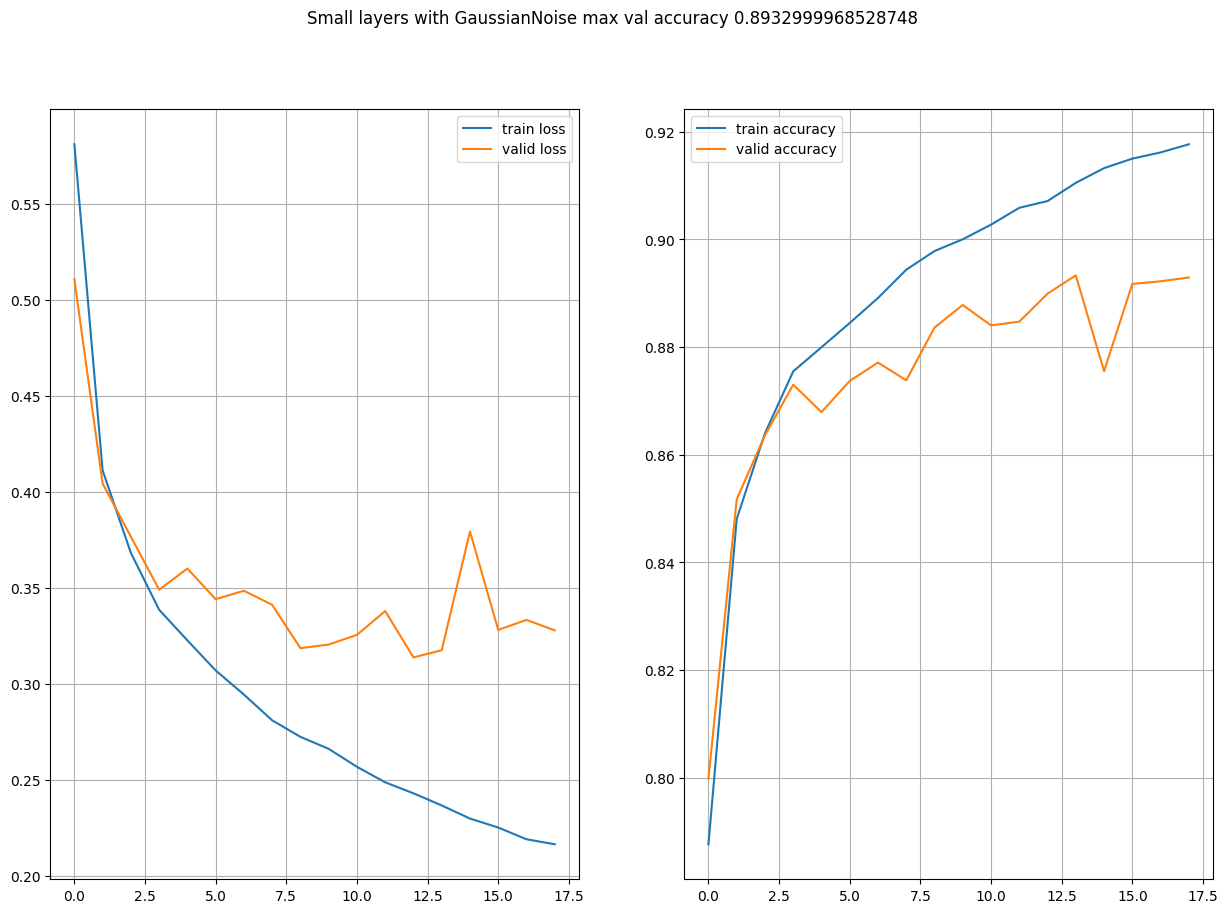

In [29]:
small_layers_GN = [
    Dense(128, activation="relu", input_shape=(28*28,)),
    GaussianNoise(0.2),
    Dense(512, activation="relu"),
    GaussianNoise(.2),
    Dense(10, activation="softmax"),
]

small_model_GN = create_model_2(small_layers_GN, RMSprop())
history = fit_and_present_2(small_model_GN, def_ds, val_dataset, description="Small layers with GaussianNoise", filepath="small_la_gn_cp")

Краще, але все одно мало. Можемо ще додати ругуляризацію в шари Dense. З огляду на те, що досвіду нема, візьмемо приклад з документації Keras

Epoch 1/100


469/469 [==============================] - ETA: 0s - loss: 1.0945 - accuracy: 0.7769 - categorical_crossentropy: 0.5993INFO:tensorflow:Assets written to: big_la_gn_dn_cp\assets


INFO:tensorflow:Assets written to: big_la_gn_dn_cp\assets


469/469 [==============================] - 18s 36ms/step - loss: 1.0945 - accuracy: 0.7769 - categorical_crossentropy: 0.5993 - val_loss: 0.8606 - val_accuracy: 0.8331 - val_categorical_crossentropy: 0.4702
Epoch 2/100
468/469 [============================>.] - ETA: 0s - loss: 0.7461 - accuracy: 0.8406 - categorical_crossentropy: 0.4294INFO:tensorflow:Assets written to: big_la_gn_dn_cp\assets


INFO:tensorflow:Assets written to: big_la_gn_dn_cp\assets


469/469 [==============================] - 16s 34ms/step - loss: 0.7457 - accuracy: 0.8406 - categorical_crossentropy: 0.4292 - val_loss: 0.6702 - val_accuracy: 0.8492 - val_categorical_crossentropy: 0.4120
Epoch 3/100
469/469 [==============================] - ETA: 0s - loss: 0.6144 - accuracy: 0.8556 - categorical_crossentropy: 0.3907INFO:tensorflow:Assets written to: big_la_gn_dn_cp\assets


INFO:tensorflow:Assets written to: big_la_gn_dn_cp\assets


469/469 [==============================] - 16s 34ms/step - loss: 0.6144 - accuracy: 0.8556 - categorical_crossentropy: 0.3907 - val_loss: 0.5836 - val_accuracy: 0.8603 - val_categorical_crossentropy: 0.3851
Epoch 4/100
469/469 [==============================] - 15s 31ms/step - loss: 0.5573 - accuracy: 0.8612 - categorical_crossentropy: 0.3739 - val_loss: 0.5628 - val_accuracy: 0.8584 - val_categorical_crossentropy: 0.3917
Epoch 5/100
469/469 [==============================] - 15s 31ms/step - loss: 0.5217 - accuracy: 0.8666 - categorical_crossentropy: 0.3594 - val_loss: 0.5644 - val_accuracy: 0.8548 - val_categorical_crossentropy: 0.4098
Epoch 6/100
469/469 [==============================] - 15s 31ms/step - loss: 0.4983 - accuracy: 0.8712 - categorical_crossentropy: 0.3493 - val_loss: 0.5778 - val_accuracy: 0.8310 - val_categorical_crossentropy: 0.4338
Epoch 7/100
468/469 [============================>.] - ETA: 0s - loss: 0.4785 - accuracy: 0.8747 - categorical_crossentropy: 0.3384INFO:

INFO:tensorflow:Assets written to: big_la_gn_dn_cp\assets


469/469 [==============================] - 16s 35ms/step - loss: 0.4783 - accuracy: 0.8748 - categorical_crossentropy: 0.3382 - val_loss: 0.4979 - val_accuracy: 0.8672 - val_categorical_crossentropy: 0.3610
Epoch 8/100
468/469 [============================>.] - ETA: 0s - loss: 0.4635 - accuracy: 0.8780 - categorical_crossentropy: 0.3292INFO:tensorflow:Assets written to: big_la_gn_dn_cp\assets


INFO:tensorflow:Assets written to: big_la_gn_dn_cp\assets


469/469 [==============================] - 16s 34ms/step - loss: 0.4634 - accuracy: 0.8781 - categorical_crossentropy: 0.3291 - val_loss: 0.4951 - val_accuracy: 0.8678 - val_categorical_crossentropy: 0.3629
Epoch 9/100
468/469 [============================>.] - ETA: 0s - loss: 0.4547 - accuracy: 0.8795 - categorical_crossentropy: 0.3244INFO:tensorflow:Assets written to: big_la_gn_dn_cp\assets


INFO:tensorflow:Assets written to: big_la_gn_dn_cp\assets


469/469 [==============================] - 16s 35ms/step - loss: 0.4545 - accuracy: 0.8795 - categorical_crossentropy: 0.3242 - val_loss: 0.4718 - val_accuracy: 0.8750 - val_categorical_crossentropy: 0.3436
Epoch 10/100
469/469 [==============================] - 15s 32ms/step - loss: 0.4456 - accuracy: 0.8825 - categorical_crossentropy: 0.3182 - val_loss: 0.4952 - val_accuracy: 0.8622 - val_categorical_crossentropy: 0.3692
Epoch 11/100
469/469 [==============================] - 15s 31ms/step - loss: 0.4386 - accuracy: 0.8847 - categorical_crossentropy: 0.3134 - val_loss: 0.4946 - val_accuracy: 0.8704 - val_categorical_crossentropy: 0.3700
Epoch 12/100
469/469 [==============================] - ETA: 0s - loss: 0.4336 - accuracy: 0.8842 - categorical_crossentropy: 0.3098INFO:tensorflow:Assets written to: big_la_gn_dn_cp\assets


INFO:tensorflow:Assets written to: big_la_gn_dn_cp\assets


469/469 [==============================] - 17s 35ms/step - loss: 0.4336 - accuracy: 0.8842 - categorical_crossentropy: 0.3098 - val_loss: 0.4501 - val_accuracy: 0.8791 - val_categorical_crossentropy: 0.3277
Epoch 13/100
469/469 [==============================] - 15s 31ms/step - loss: 0.4261 - accuracy: 0.8858 - categorical_crossentropy: 0.3039 - val_loss: 0.4559 - val_accuracy: 0.8789 - val_categorical_crossentropy: 0.3342
Epoch 14/100
469/469 [==============================] - 14s 31ms/step - loss: 0.4230 - accuracy: 0.8872 - categorical_crossentropy: 0.3019 - val_loss: 0.4694 - val_accuracy: 0.8722 - val_categorical_crossentropy: 0.3487
Epoch 15/100
469/469 [==============================] - ETA: 0s - loss: 0.4189 - accuracy: 0.8887 - categorical_crossentropy: 0.2984INFO:tensorflow:Assets written to: big_la_gn_dn_cp\assets


INFO:tensorflow:Assets written to: big_la_gn_dn_cp\assets


469/469 [==============================] - 16s 34ms/step - loss: 0.4189 - accuracy: 0.8887 - categorical_crossentropy: 0.2984 - val_loss: 0.4465 - val_accuracy: 0.8802 - val_categorical_crossentropy: 0.3264
Epoch 16/100
469/469 [==============================] - 15s 31ms/step - loss: 0.4153 - accuracy: 0.8905 - categorical_crossentropy: 0.2952 - val_loss: 0.4763 - val_accuracy: 0.8733 - val_categorical_crossentropy: 0.3566
Epoch 17/100
469/469 [==============================] - 15s 31ms/step - loss: 0.4146 - accuracy: 0.8907 - categorical_crossentropy: 0.2948 - val_loss: 0.4960 - val_accuracy: 0.8730 - val_categorical_crossentropy: 0.3764
Epoch 18/100
469/469 [==============================] - ETA: 0s - loss: 0.4105 - accuracy: 0.8917 - categorical_crossentropy: 0.2909INFO:tensorflow:Assets written to: big_la_gn_dn_cp\assets


INFO:tensorflow:Assets written to: big_la_gn_dn_cp\assets


469/469 [==============================] - 16s 35ms/step - loss: 0.4105 - accuracy: 0.8917 - categorical_crossentropy: 0.2909 - val_loss: 0.4473 - val_accuracy: 0.8808 - val_categorical_crossentropy: 0.3278
Epoch 19/100
469/469 [==============================] - 14s 31ms/step - loss: 0.4092 - accuracy: 0.8913 - categorical_crossentropy: 0.2899 - val_loss: 0.4728 - val_accuracy: 0.8751 - val_categorical_crossentropy: 0.3533
Epoch 20/100
469/469 [==============================] - 15s 31ms/step - loss: 0.4049 - accuracy: 0.8937 - categorical_crossentropy: 0.2853 - val_loss: 0.4551 - val_accuracy: 0.8786 - val_categorical_crossentropy: 0.3355


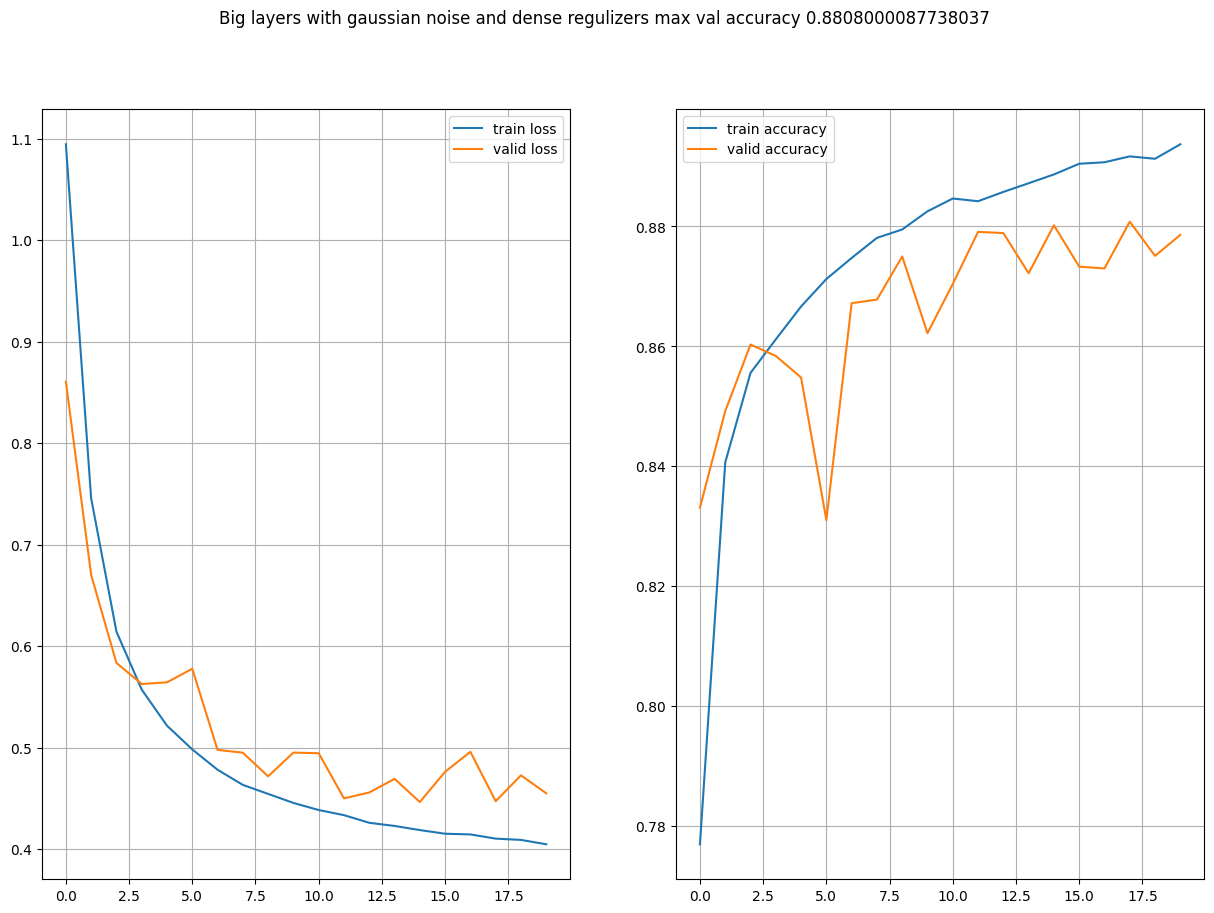

In [30]:
big_layers_GN_DR = [
    Dense(1024, activation="relu", input_shape=(28*28,), kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=tf.keras.regularizers.L2(1e-4)),
    GaussianNoise(0.2),
    Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=tf.keras.regularizers.L2(1e-4)),
    GaussianNoise(0.2),
    Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=tf.keras.regularizers.L2(1e-4)),
    Dense(10, activation="softmax"),
]

big_model_GN_DR = create_model_2(big_layers_GN_DR, RMSprop())
history = fit_and_present_2(big_model_GN_DR, def_ds, val_dataset, description="Big layers with gaussian noise and dense regulizers", filepath="big_la_gn_dn_cp")

Epoch 1/100


462/469 [============================>.] - ETA: 0s - loss: 0.7029 - accuracy: 0.7845 - categorical_crossentropy: 0.5910INFO:tensorflow:Assets written to: small_la_gn_dr_cp\assets


INFO:tensorflow:Assets written to: small_la_gn_dr_cp\assets


469/469 [==============================] - 6s 11ms/step - loss: 0.7008 - accuracy: 0.7852 - categorical_crossentropy: 0.5889 - val_loss: 0.5470 - val_accuracy: 0.8416 - val_categorical_crossentropy: 0.4401
Epoch 2/100
462/469 [============================>.] - ETA: 0s - loss: 0.5206 - accuracy: 0.8454 - categorical_crossentropy: 0.4183INFO:tensorflow:Assets written to: small_la_gn_dr_cp\assets


INFO:tensorflow:Assets written to: small_la_gn_dr_cp\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.5202 - accuracy: 0.8455 - categorical_crossentropy: 0.4179 - val_loss: 0.5025 - val_accuracy: 0.8547 - val_categorical_crossentropy: 0.4045
Epoch 3/100
469/469 [==============================] - 3s 7ms/step - loss: 0.4718 - accuracy: 0.8606 - categorical_crossentropy: 0.3768 - val_loss: 0.5970 - val_accuracy: 0.8181 - val_categorical_crossentropy: 0.5046
Epoch 4/100
464/469 [============================>.] - ETA: 0s - loss: 0.4468 - accuracy: 0.8696 - categorical_crossentropy: 0.3564INFO:tensorflow:Assets written to: small_la_gn_dr_cp\assets


INFO:tensorflow:Assets written to: small_la_gn_dr_cp\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4467 - accuracy: 0.8695 - categorical_crossentropy: 0.3563 - val_loss: 0.4806 - val_accuracy: 0.8561 - val_categorical_crossentropy: 0.3918
Epoch 5/100
467/469 [============================>.] - ETA: 0s - loss: 0.4266 - accuracy: 0.8747 - categorical_crossentropy: 0.3390INFO:tensorflow:Assets written to: small_la_gn_dr_cp\assets


INFO:tensorflow:Assets written to: small_la_gn_dr_cp\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.4266 - accuracy: 0.8747 - categorical_crossentropy: 0.3390 - val_loss: 0.4418 - val_accuracy: 0.8717 - val_categorical_crossentropy: 0.3554
Epoch 6/100
469/469 [==============================] - 4s 8ms/step - loss: 0.4147 - accuracy: 0.8770 - categorical_crossentropy: 0.3291 - val_loss: 0.4702 - val_accuracy: 0.8552 - val_categorical_crossentropy: 0.3855
Epoch 7/100
464/469 [============================>.] - ETA: 0s - loss: 0.4040 - accuracy: 0.8810 - categorical_crossentropy: 0.3199INFO:tensorflow:Assets written to: small_la_gn_dr_cp\assets


INFO:tensorflow:Assets written to: small_la_gn_dr_cp\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4045 - accuracy: 0.8808 - categorical_crossentropy: 0.3204 - val_loss: 0.4265 - val_accuracy: 0.8771 - val_categorical_crossentropy: 0.3429
Epoch 8/100
469/469 [==============================] - 4s 7ms/step - loss: 0.3969 - accuracy: 0.8813 - categorical_crossentropy: 0.3139 - val_loss: 0.4331 - val_accuracy: 0.8727 - val_categorical_crossentropy: 0.3507
Epoch 9/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3913 - accuracy: 0.8853 - categorical_crossentropy: 0.3092 - val_loss: 0.4231 - val_accuracy: 0.8768 - val_categorical_crossentropy: 0.3416
Epoch 10/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3843 - accuracy: 0.8864 - categorical_crossentropy: 0.3031 - val_loss: 0.4704 - val_accuracy: 0.8572 - val_categorical_crossentropy: 0.3899
Epoch 11/100
461/469 [============================>.] - ETA: 0s - loss: 0.3787 - accuracy: 0.8882 - categorical_crossentropy: 0.2985INFO:tensor

INFO:tensorflow:Assets written to: small_la_gn_dr_cp\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3786 - accuracy: 0.8884 - categorical_crossentropy: 0.2983 - val_loss: 0.4032 - val_accuracy: 0.8866 - val_categorical_crossentropy: 0.3232
Epoch 12/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3732 - accuracy: 0.8897 - categorical_crossentropy: 0.2933 - val_loss: 0.4169 - val_accuracy: 0.8780 - val_categorical_crossentropy: 0.3372
Epoch 13/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3707 - accuracy: 0.8904 - categorical_crossentropy: 0.2911 - val_loss: 0.4575 - val_accuracy: 0.8650 - val_categorical_crossentropy: 0.3782
Epoch 14/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3672 - accuracy: 0.8923 - categorical_crossentropy: 0.2880 - val_loss: 0.3965 - val_accuracy: 0.8855 - val_categorical_crossentropy: 0.3174
Epoch 15/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3623 - accuracy: 0.8943 - categorical_crossentropy: 0.2830 - va

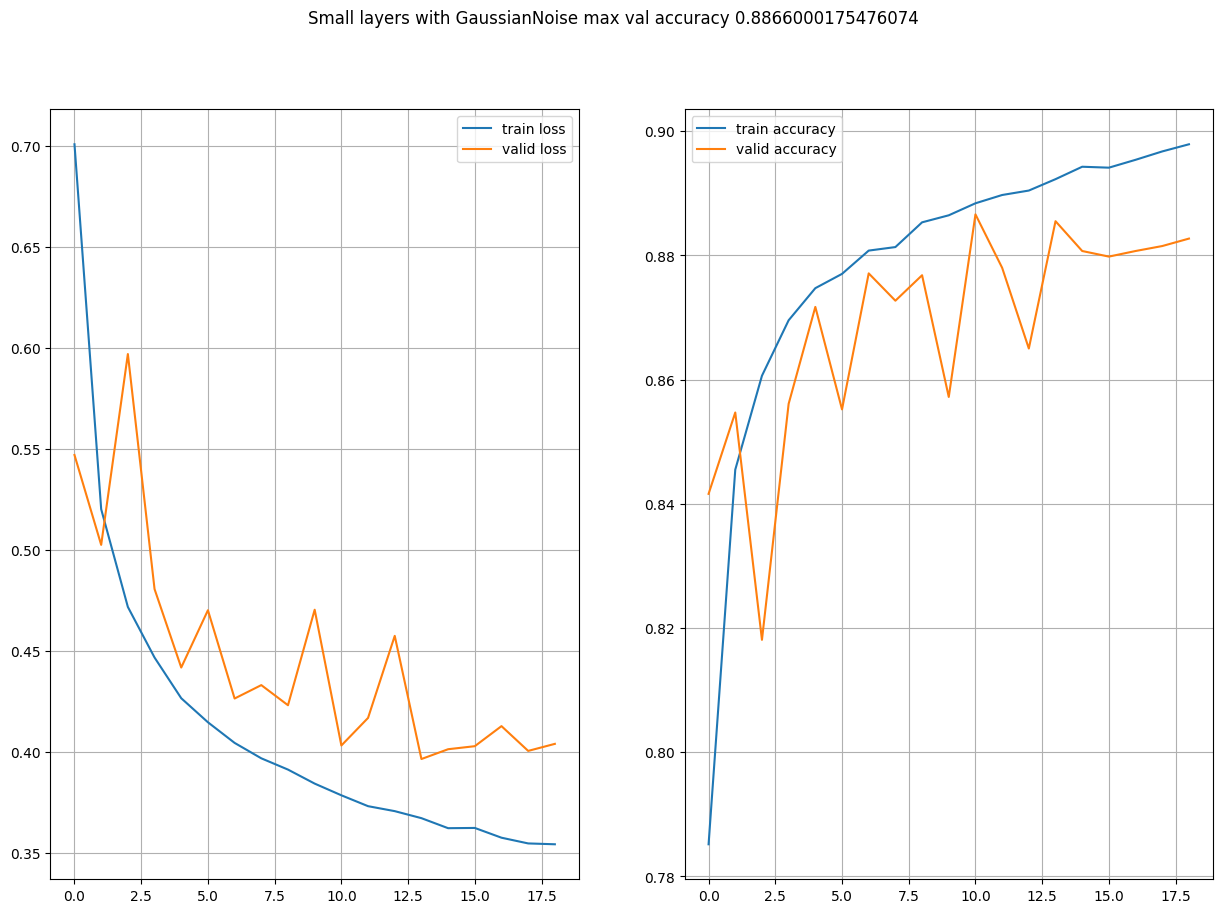

In [31]:
small_layers_GN_DR = [
    Dense(128, activation="relu", input_shape=(28*28,), kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=tf.keras.regularizers.L2(1e-4)),
    GaussianNoise(0.2),
    Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=tf.keras.regularizers.L2(1e-4)),
    GaussianNoise(.2),
    Dense(10, activation="softmax"),
]

small_model_GN_DR = create_model_2(small_layers_GN_DR, RMSprop())
history = fit_and_present_2(small_model_GN_DR, def_ds, val_dataset, description="Small layers with GaussianNoise", filepath="small_la_gn_dr_cp")

Багато регуляризації не пішло на користь, спробуємо відмовитись від GussianNoise

Epoch 1/100


468/469 [============================>.] - ETA: 0s - loss: 1.0620 - accuracy: 0.7826 - categorical_crossentropy: 0.5869INFO:tensorflow:Assets written to: big_la_dn_cp\assets


INFO:tensorflow:Assets written to: big_la_dn_cp\assets


469/469 [==============================] - 16s 33ms/step - loss: 1.0614 - accuracy: 0.7828 - categorical_crossentropy: 0.5865 - val_loss: 0.8216 - val_accuracy: 0.8256 - val_categorical_crossentropy: 0.4670
Epoch 2/100
469/469 [==============================] - ETA: 0s - loss: 0.6791 - accuracy: 0.8486 - categorical_crossentropy: 0.4066INFO:tensorflow:Assets written to: big_la_dn_cp\assets


INFO:tensorflow:Assets written to: big_la_dn_cp\assets


469/469 [==============================] - 15s 31ms/step - loss: 0.6791 - accuracy: 0.8486 - categorical_crossentropy: 0.4066 - val_loss: 0.6468 - val_accuracy: 0.8392 - val_categorical_crossentropy: 0.4388
Epoch 3/100
469/469 [==============================] - ETA: 0s - loss: 0.5444 - accuracy: 0.8620 - categorical_crossentropy: 0.3712INFO:tensorflow:Assets written to: big_la_dn_cp\assets


INFO:tensorflow:Assets written to: big_la_dn_cp\assets


469/469 [==============================] - 15s 32ms/step - loss: 0.5444 - accuracy: 0.8620 - categorical_crossentropy: 0.3712 - val_loss: 0.5659 - val_accuracy: 0.8414 - val_categorical_crossentropy: 0.4177
Epoch 4/100
467/469 [============================>.] - ETA: 0s - loss: 0.4783 - accuracy: 0.8721 - categorical_crossentropy: 0.3446INFO:tensorflow:Assets written to: big_la_dn_cp\assets


INFO:tensorflow:Assets written to: big_la_dn_cp\assets


469/469 [==============================] - 15s 32ms/step - loss: 0.4786 - accuracy: 0.8720 - categorical_crossentropy: 0.3450 - val_loss: 0.4805 - val_accuracy: 0.8701 - val_categorical_crossentropy: 0.3588
Epoch 5/100
469/469 [==============================] - 13s 29ms/step - loss: 0.4450 - accuracy: 0.8773 - categorical_crossentropy: 0.3312 - val_loss: 0.5461 - val_accuracy: 0.8370 - val_categorical_crossentropy: 0.4394
Epoch 6/100
469/469 [==============================] - 14s 29ms/step - loss: 0.4193 - accuracy: 0.8825 - categorical_crossentropy: 0.3174 - val_loss: 0.4455 - val_accuracy: 0.8680 - val_categorical_crossentropy: 0.3477
Epoch 7/100
469/469 [==============================] - 14s 29ms/step - loss: 0.4013 - accuracy: 0.8856 - categorical_crossentropy: 0.3069 - val_loss: 0.4576 - val_accuracy: 0.8620 - val_categorical_crossentropy: 0.3663
Epoch 8/100
469/469 [==============================] - 14s 29ms/step - loss: 0.3853 - accuracy: 0.8890 - categorical_crossentropy: 0.295

INFO:tensorflow:Assets written to: big_la_dn_cp\assets


469/469 [==============================] - 15s 33ms/step - loss: 0.3753 - accuracy: 0.8917 - categorical_crossentropy: 0.2896 - val_loss: 0.4123 - val_accuracy: 0.8774 - val_categorical_crossentropy: 0.3284
Epoch 10/100
469/469 [==============================] - 19s 40ms/step - loss: 0.3658 - accuracy: 0.8936 - categorical_crossentropy: 0.2832 - val_loss: 0.4273 - val_accuracy: 0.8770 - val_categorical_crossentropy: 0.3458
Epoch 11/100
469/469 [==============================] - ETA: 0s - loss: 0.3561 - accuracy: 0.8953 - categorical_crossentropy: 0.2756INFO:tensorflow:Assets written to: big_la_dn_cp\assets


INFO:tensorflow:Assets written to: big_la_dn_cp\assets


469/469 [==============================] - 18s 38ms/step - loss: 0.3561 - accuracy: 0.8953 - categorical_crossentropy: 0.2756 - val_loss: 0.4124 - val_accuracy: 0.8811 - val_categorical_crossentropy: 0.3327
Epoch 12/100
469/469 [==============================] - 17s 36ms/step - loss: 0.3499 - accuracy: 0.8986 - categorical_crossentropy: 0.2707 - val_loss: 0.4323 - val_accuracy: 0.8772 - val_categorical_crossentropy: 0.3540
Epoch 13/100
469/469 [==============================] - 17s 36ms/step - loss: 0.3451 - accuracy: 0.8995 - categorical_crossentropy: 0.2671 - val_loss: 0.4318 - val_accuracy: 0.8668 - val_categorical_crossentropy: 0.3544
Epoch 14/100
469/469 [==============================] - 16s 34ms/step - loss: 0.3398 - accuracy: 0.9008 - categorical_crossentropy: 0.2625 - val_loss: 0.4044 - val_accuracy: 0.8809 - val_categorical_crossentropy: 0.3273
Epoch 15/100
469/469 [==============================] - ETA: 0s - loss: 0.3350 - accuracy: 0.9036 - categorical_crossentropy: 0.2583I

INFO:tensorflow:Assets written to: big_la_dn_cp\assets


469/469 [==============================] - 18s 38ms/step - loss: 0.3350 - accuracy: 0.9036 - categorical_crossentropy: 0.2583 - val_loss: 0.4139 - val_accuracy: 0.8820 - val_categorical_crossentropy: 0.3376
Epoch 16/100
469/469 [==============================] - 17s 35ms/step - loss: 0.3306 - accuracy: 0.9041 - categorical_crossentropy: 0.2544 - val_loss: 0.4309 - val_accuracy: 0.8679 - val_categorical_crossentropy: 0.3548
Epoch 17/100
469/469 [==============================] - 16s 34ms/step - loss: 0.3257 - accuracy: 0.9061 - categorical_crossentropy: 0.2497 - val_loss: 0.4170 - val_accuracy: 0.8754 - val_categorical_crossentropy: 0.3412
Epoch 18/100
468/469 [============================>.] - ETA: 0s - loss: 0.3216 - accuracy: 0.9081 - categorical_crossentropy: 0.2458INFO:tensorflow:Assets written to: big_la_dn_cp\assets


INFO:tensorflow:Assets written to: big_la_dn_cp\assets


469/469 [==============================] - 17s 36ms/step - loss: 0.3217 - accuracy: 0.9080 - categorical_crossentropy: 0.2459 - val_loss: 0.3982 - val_accuracy: 0.8841 - val_categorical_crossentropy: 0.3227
Epoch 19/100
469/469 [==============================] - 16s 33ms/step - loss: 0.3198 - accuracy: 0.9071 - categorical_crossentropy: 0.2442 - val_loss: 0.3966 - val_accuracy: 0.8825 - val_categorical_crossentropy: 0.3211
Epoch 20/100
469/469 [==============================] - 16s 35ms/step - loss: 0.3147 - accuracy: 0.9098 - categorical_crossentropy: 0.2390 - val_loss: 0.4551 - val_accuracy: 0.8777 - val_categorical_crossentropy: 0.3795
Epoch 21/100
469/469 [==============================] - 17s 35ms/step - loss: 0.3133 - accuracy: 0.9104 - categorical_crossentropy: 0.2377 - val_loss: 0.4155 - val_accuracy: 0.8787 - val_categorical_crossentropy: 0.3400
Epoch 22/100
468/469 [============================>.] - ETA: 0s - loss: 0.3116 - accuracy: 0.9111 - categorical_crossentropy: 0.2361I

INFO:tensorflow:Assets written to: big_la_dn_cp\assets


469/469 [==============================] - 17s 37ms/step - loss: 0.3114 - accuracy: 0.9112 - categorical_crossentropy: 0.2358 - val_loss: 0.4109 - val_accuracy: 0.8877 - val_categorical_crossentropy: 0.3353
Epoch 23/100
469/469 [==============================] - 17s 36ms/step - loss: 0.3087 - accuracy: 0.9128 - categorical_crossentropy: 0.2328 - val_loss: 0.4250 - val_accuracy: 0.8782 - val_categorical_crossentropy: 0.3491
Epoch 24/100
469/469 [==============================] - 15s 33ms/step - loss: 0.3065 - accuracy: 0.9119 - categorical_crossentropy: 0.2304 - val_loss: 0.4382 - val_accuracy: 0.8786 - val_categorical_crossentropy: 0.3622


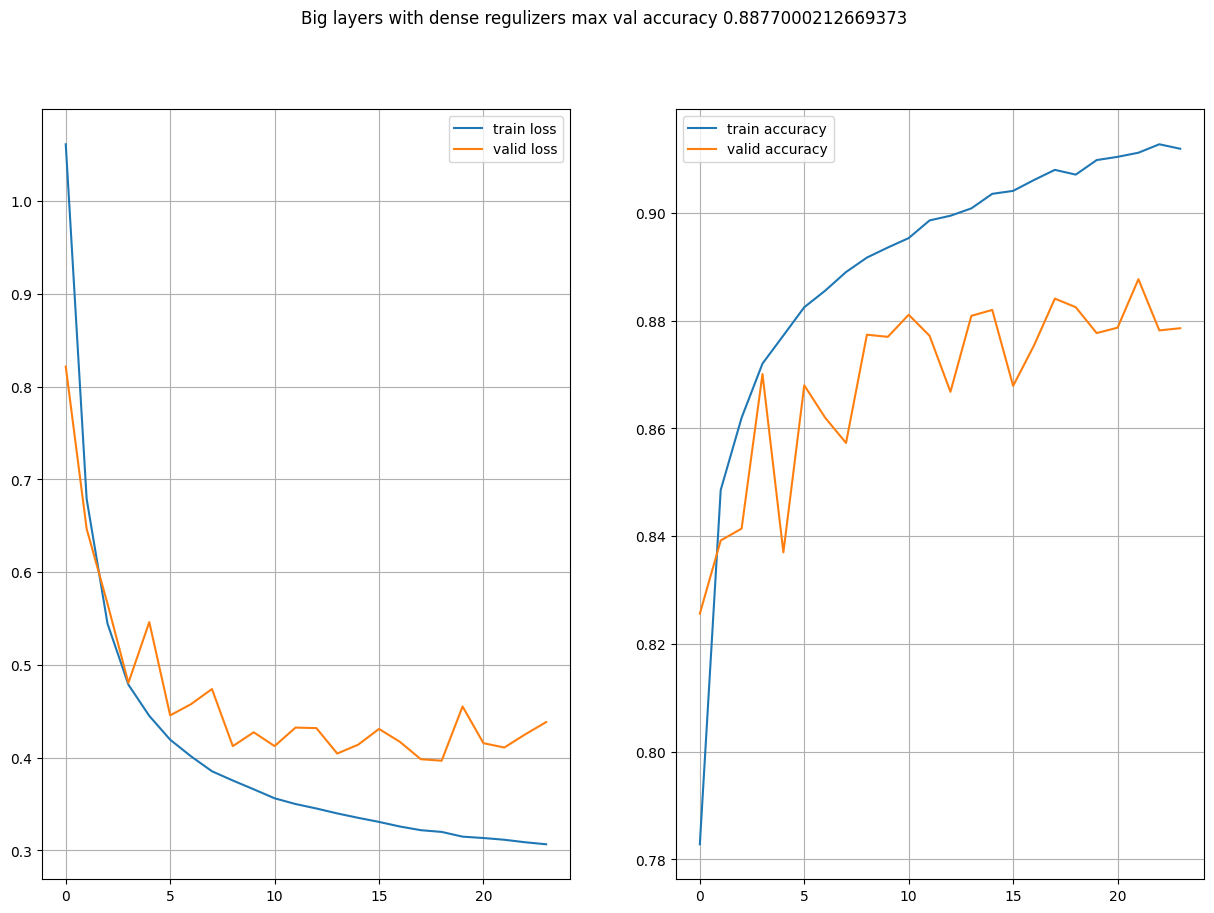

In [32]:
big_layers_DR = [
    Dense(1024, activation="relu", input_shape=(28*28,), kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=tf.keras.regularizers.L2(1e-4)),
    #GaussianNoise(0.2),
    Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=tf.keras.regularizers.L2(1e-4)),
    #GaussianNoise(0.2),
    Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=tf.keras.regularizers.L2(1e-4)),
    Dense(10, activation="softmax"),
]

big_model_DR = create_model_2(big_layers_DR, RMSprop())
history = fit_and_present_2(big_model_DR, def_ds, val_dataset, description="Big layers with dense regulizers", filepath="big_la_dn_cp")

Epoch 1/100


467/469 [============================>.] - ETA: 0s - loss: 0.6610 - accuracy: 0.7991 - categorical_crossentropy: 0.5503INFO:tensorflow:Assets written to: small_la_dr_cp\assets


INFO:tensorflow:Assets written to: small_la_dr_cp\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.6603 - accuracy: 0.7993 - categorical_crossentropy: 0.5496 - val_loss: 0.5535 - val_accuracy: 0.8390 - val_categorical_crossentropy: 0.4491
Epoch 2/100
467/469 [============================>.] - ETA: 0s - loss: 0.4863 - accuracy: 0.8563 - categorical_crossentropy: 0.3876INFO:tensorflow:Assets written to: small_la_dr_cp\assets


INFO:tensorflow:Assets written to: small_la_dr_cp\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4864 - accuracy: 0.8563 - categorical_crossentropy: 0.3877 - val_loss: 0.5026 - val_accuracy: 0.8491 - val_categorical_crossentropy: 0.4095
Epoch 3/100
467/469 [============================>.] - ETA: 0s - loss: 0.4387 - accuracy: 0.8701 - categorical_crossentropy: 0.3492INFO:tensorflow:Assets written to: small_la_dr_cp\assets


INFO:tensorflow:Assets written to: small_la_dr_cp\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4388 - accuracy: 0.8701 - categorical_crossentropy: 0.3493 - val_loss: 0.4600 - val_accuracy: 0.8617 - val_categorical_crossentropy: 0.3740
Epoch 4/100
469/469 [==============================] - 3s 7ms/step - loss: 0.4103 - accuracy: 0.8785 - categorical_crossentropy: 0.3268 - val_loss: 0.5390 - val_accuracy: 0.8372 - val_categorical_crossentropy: 0.4575
Epoch 5/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3922 - accuracy: 0.8832 - categorical_crossentropy: 0.3122 - val_loss: 0.4640 - val_accuracy: 0.8582 - val_categorical_crossentropy: 0.3856
Epoch 6/100
469/469 [==============================] - 3s 5ms/step - loss: 0.3763 - accuracy: 0.8890 - categorical_crossentropy: 0.2989 - val_loss: 0.4906 - val_accuracy: 0.8539 - val_categorical_crossentropy: 0.4141
Epoch 7/100
466/469 [============================>.] - ETA: 0s - loss: 0.3660 - accuracy: 0.8917 - categorical_crossentropy: 0.2901INFO:tensorfl

INFO:tensorflow:Assets written to: small_la_dr_cp\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.3661 - accuracy: 0.8916 - categorical_crossentropy: 0.2902 - val_loss: 0.4342 - val_accuracy: 0.8698 - val_categorical_crossentropy: 0.3592
Epoch 8/100
464/469 [============================>.] - ETA: 0s - loss: 0.3558 - accuracy: 0.8955 - categorical_crossentropy: 0.2815INFO:tensorflow:Assets written to: small_la_dr_cp\assets


INFO:tensorflow:Assets written to: small_la_dr_cp\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3552 - accuracy: 0.8959 - categorical_crossentropy: 0.2808 - val_loss: 0.3999 - val_accuracy: 0.8798 - val_categorical_crossentropy: 0.3261
Epoch 9/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3476 - accuracy: 0.8981 - categorical_crossentropy: 0.2740 - val_loss: 0.4725 - val_accuracy: 0.8587 - val_categorical_crossentropy: 0.3993
Epoch 10/100
469/469 [==============================] - 2s 5ms/step - loss: 0.3411 - accuracy: 0.9000 - categorical_crossentropy: 0.2683 - val_loss: 0.4441 - val_accuracy: 0.8678 - val_categorical_crossentropy: 0.3717
Epoch 11/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3339 - accuracy: 0.9020 - categorical_crossentropy: 0.2617 - val_loss: 0.4126 - val_accuracy: 0.8771 - val_categorical_crossentropy: 0.3406
Epoch 12/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3271 - accuracy: 0.9054 - categorical_crossentropy: 0.2551 - val

INFO:tensorflow:Assets written to: small_la_dr_cp\assets


469/469 [==============================] - 3s 7ms/step - loss: 0.3242 - accuracy: 0.9053 - categorical_crossentropy: 0.2523 - val_loss: 0.3864 - val_accuracy: 0.8884 - val_categorical_crossentropy: 0.3147
Epoch 14/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3191 - accuracy: 0.9078 - categorical_crossentropy: 0.2473 - val_loss: 0.4201 - val_accuracy: 0.8756 - val_categorical_crossentropy: 0.3482
Epoch 15/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3130 - accuracy: 0.9102 - categorical_crossentropy: 0.2410 - val_loss: 0.4024 - val_accuracy: 0.8781 - val_categorical_crossentropy: 0.3303
Epoch 16/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3117 - accuracy: 0.9108 - categorical_crossentropy: 0.2395 - val_loss: 0.4353 - val_accuracy: 0.8739 - val_categorical_crossentropy: 0.3630
Epoch 17/100
469/469 [==============================] - 3s 5ms/step - loss: 0.3094 - accuracy: 0.9112 - categorical_crossentropy: 0.2369 - va

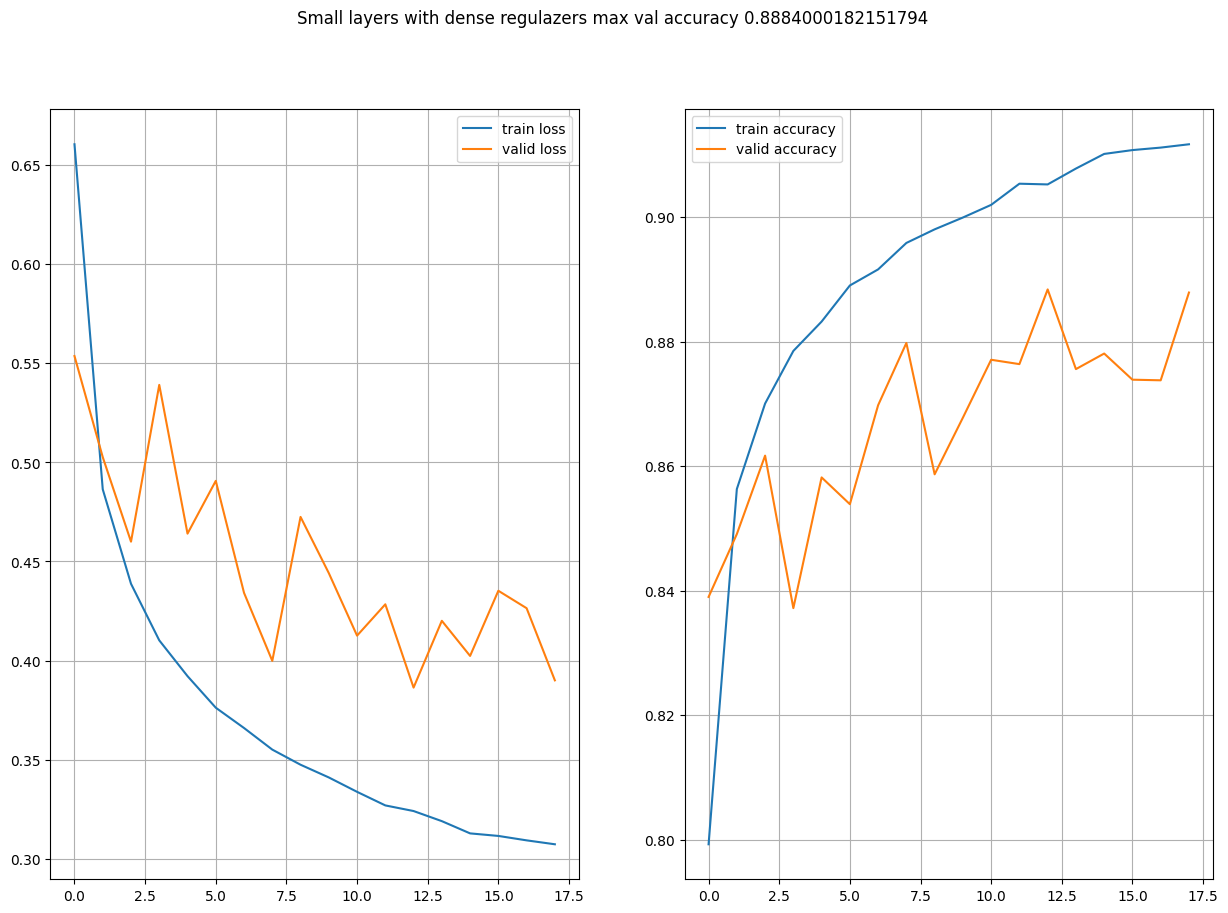

In [33]:
small_layers_DR = [
    Dense(128, activation="relu", input_shape=(28*28,), kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=tf.keras.regularizers.L2(1e-4)),
    #GaussianNoise(0.2),
    Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=tf.keras.regularizers.L2(1e-4)),
    #GaussianNoise(.2),
    Dense(10, activation="softmax"),
]

small_model_DR = create_model_2(small_layers_DR, RMSprop())
history = fit_and_present_2(small_model_DR, def_ds, val_dataset, description="Small layers with dense regulazers", filepath="small_la_dr_cp")

Чуда знову не сталося. 

Наразі, найефективніша модель з невеликим набором шарів і регуляризаторами GaussianNoise. Візьмемо її за основу і спробуємо побавитись з lr оптимізатора

Epoch 1/100


463/469 [============================>.] - ETA: 0s - loss: 0.8398 - accuracy: 0.7202 - categorical_crossentropy: 0.8398INFO:tensorflow:Assets written to: small_la_gn_cp_0\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_0\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.8371 - accuracy: 0.7205 - categorical_crossentropy: 0.8371 - val_loss: 0.5802 - val_accuracy: 0.7910 - val_categorical_crossentropy: 0.5802
Epoch 2/100
463/469 [============================>.] - ETA: 0s - loss: 0.5197 - accuracy: 0.8130 - categorical_crossentropy: 0.5197INFO:tensorflow:Assets written to: small_la_gn_cp_0\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_0\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.5191 - accuracy: 0.8131 - categorical_crossentropy: 0.5191 - val_loss: 0.4878 - val_accuracy: 0.8330 - val_categorical_crossentropy: 0.4878
Epoch 3/100
469/469 [==============================] - 3s 7ms/step - loss: 0.4808 - accuracy: 0.8293 - categorical_crossentropy: 0.4808 - val_loss: 0.5431 - val_accuracy: 0.8279 - val_categorical_crossentropy: 0.5431
Epoch 4/100
463/469 [============================>.] - ETA: 0s - loss: 0.4531 - accuracy: 0.8389 - categorical_crossentropy: 0.4531INFO:tensorflow:Assets written to: small_la_gn_cp_0\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_0\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.4538 - accuracy: 0.8388 - categorical_crossentropy: 0.4538 - val_loss: 0.4596 - val_accuracy: 0.8338 - val_categorical_crossentropy: 0.4596
Epoch 5/100
465/469 [============================>.] - ETA: 0s - loss: 0.4379 - accuracy: 0.8444 - categorical_crossentropy: 0.4379INFO:tensorflow:Assets written to: small_la_gn_cp_0\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_0\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4381 - accuracy: 0.8444 - categorical_crossentropy: 0.4381 - val_loss: 0.4846 - val_accuracy: 0.8368 - val_categorical_crossentropy: 0.4846
Epoch 6/100
468/469 [============================>.] - ETA: 0s - loss: 0.4260 - accuracy: 0.8498 - categorical_crossentropy: 0.4260INFO:tensorflow:Assets written to: small_la_gn_cp_0\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_0\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.4258 - accuracy: 0.8498 - categorical_crossentropy: 0.4258 - val_loss: 0.4196 - val_accuracy: 0.8503 - val_categorical_crossentropy: 0.4196
Epoch 7/100
469/469 [==============================] - 3s 7ms/step - loss: 0.4195 - accuracy: 0.8537 - categorical_crossentropy: 0.4195 - val_loss: 0.5036 - val_accuracy: 0.8363 - val_categorical_crossentropy: 0.5036
Epoch 8/100
467/469 [============================>.] - ETA: 0s - loss: 0.4163 - accuracy: 0.8540 - categorical_crossentropy: 0.4163INFO:tensorflow:Assets written to: small_la_gn_cp_0\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_0\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.4156 - accuracy: 0.8541 - categorical_crossentropy: 0.4156 - val_loss: 0.4522 - val_accuracy: 0.8533 - val_categorical_crossentropy: 0.4522
Epoch 9/100
469/469 [==============================] - 3s 7ms/step - loss: 0.4044 - accuracy: 0.8594 - categorical_crossentropy: 0.4044 - val_loss: 0.4344 - val_accuracy: 0.8497 - val_categorical_crossentropy: 0.4344
Epoch 10/100
462/469 [============================>.] - ETA: 0s - loss: 0.3969 - accuracy: 0.8607 - categorical_crossentropy: 0.3969INFO:tensorflow:Assets written to: small_la_gn_cp_0\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_0\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3967 - accuracy: 0.8606 - categorical_crossentropy: 0.3967 - val_loss: 0.4430 - val_accuracy: 0.8654 - val_categorical_crossentropy: 0.4430
Epoch 11/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3987 - accuracy: 0.8604 - categorical_crossentropy: 0.3987 - val_loss: 0.4538 - val_accuracy: 0.8591 - val_categorical_crossentropy: 0.4538


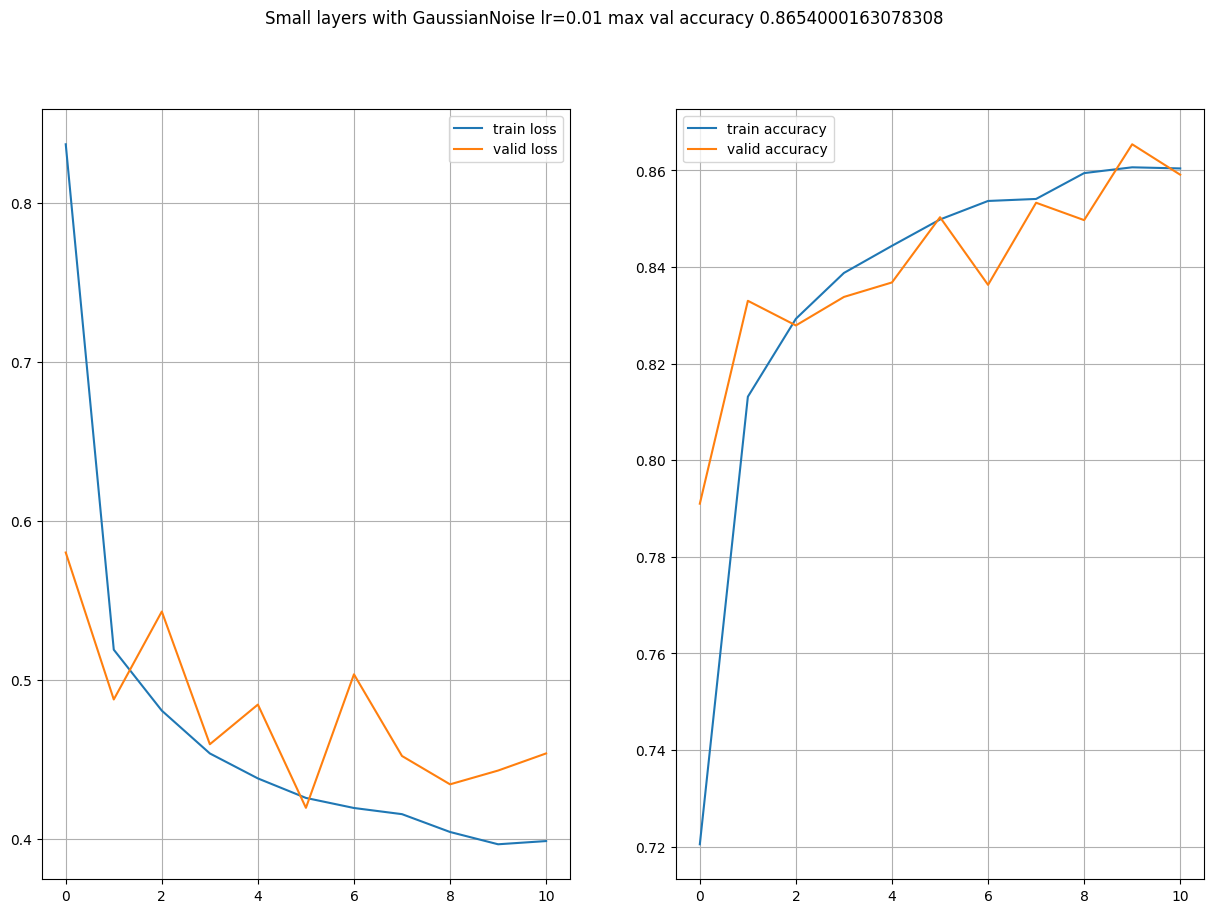

Epoch 1/100
462/469 [============================>.] - ETA: 0s - loss: 0.6672 - accuracy: 0.7595 - categorical_crossentropy: 0.6672INFO:tensorflow:Assets written to: small_la_gn_cp_1\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_1\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.6644 - accuracy: 0.7604 - categorical_crossentropy: 0.6644 - val_loss: 0.4568 - val_accuracy: 0.8355 - val_categorical_crossentropy: 0.4568
Epoch 2/100
469/469 [==============================] - 3s 7ms/step - loss: 0.4461 - accuracy: 0.8355 - categorical_crossentropy: 0.4461 - val_loss: 0.4909 - val_accuracy: 0.8243 - val_categorical_crossentropy: 0.4909
Epoch 3/100
461/469 [============================>.] - ETA: 0s - loss: 0.4093 - accuracy: 0.8502 - categorical_crossentropy: 0.4093INFO:tensorflow:Assets written to: small_la_gn_cp_1\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_1\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.4083 - accuracy: 0.8507 - categorical_crossentropy: 0.4083 - val_loss: 0.4030 - val_accuracy: 0.8578 - val_categorical_crossentropy: 0.4030
Epoch 4/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3854 - accuracy: 0.8595 - categorical_crossentropy: 0.3854 - val_loss: 0.3977 - val_accuracy: 0.8576 - val_categorical_crossentropy: 0.3977
Epoch 5/100
463/469 [============================>.] - ETA: 0s - loss: 0.3694 - accuracy: 0.8656 - categorical_crossentropy: 0.3694INFO:tensorflow:Assets written to: small_la_gn_cp_1\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_1\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.3702 - accuracy: 0.8654 - categorical_crossentropy: 0.3702 - val_loss: 0.4003 - val_accuracy: 0.8609 - val_categorical_crossentropy: 0.4003
Epoch 6/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3569 - accuracy: 0.8701 - categorical_crossentropy: 0.3569 - val_loss: 0.4286 - val_accuracy: 0.8541 - val_categorical_crossentropy: 0.4286
Epoch 7/100
463/469 [============================>.] - ETA: 0s - loss: 0.3514 - accuracy: 0.8732 - categorical_crossentropy: 0.3514INFO:tensorflow:Assets written to: small_la_gn_cp_1\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_1\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.3518 - accuracy: 0.8730 - categorical_crossentropy: 0.3518 - val_loss: 0.3681 - val_accuracy: 0.8640 - val_categorical_crossentropy: 0.3681
Epoch 8/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3426 - accuracy: 0.8762 - categorical_crossentropy: 0.3426 - val_loss: 0.3971 - val_accuracy: 0.8577 - val_categorical_crossentropy: 0.3971
Epoch 9/100
468/469 [============================>.] - ETA: 0s - loss: 0.3381 - accuracy: 0.8768 - categorical_crossentropy: 0.3381INFO:tensorflow:Assets written to: small_la_gn_cp_1\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_1\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.3380 - accuracy: 0.8768 - categorical_crossentropy: 0.3380 - val_loss: 0.3802 - val_accuracy: 0.8750 - val_categorical_crossentropy: 0.3802
Epoch 10/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3296 - accuracy: 0.8804 - categorical_crossentropy: 0.3296 - val_loss: 0.3925 - val_accuracy: 0.8726 - val_categorical_crossentropy: 0.3925
Epoch 11/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3272 - accuracy: 0.8810 - categorical_crossentropy: 0.3272 - val_loss: 0.4664 - val_accuracy: 0.8482 - val_categorical_crossentropy: 0.4664
Epoch 12/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3220 - accuracy: 0.8833 - categorical_crossentropy: 0.3220 - val_loss: 0.4175 - val_accuracy: 0.8666 - val_categorical_crossentropy: 0.4175


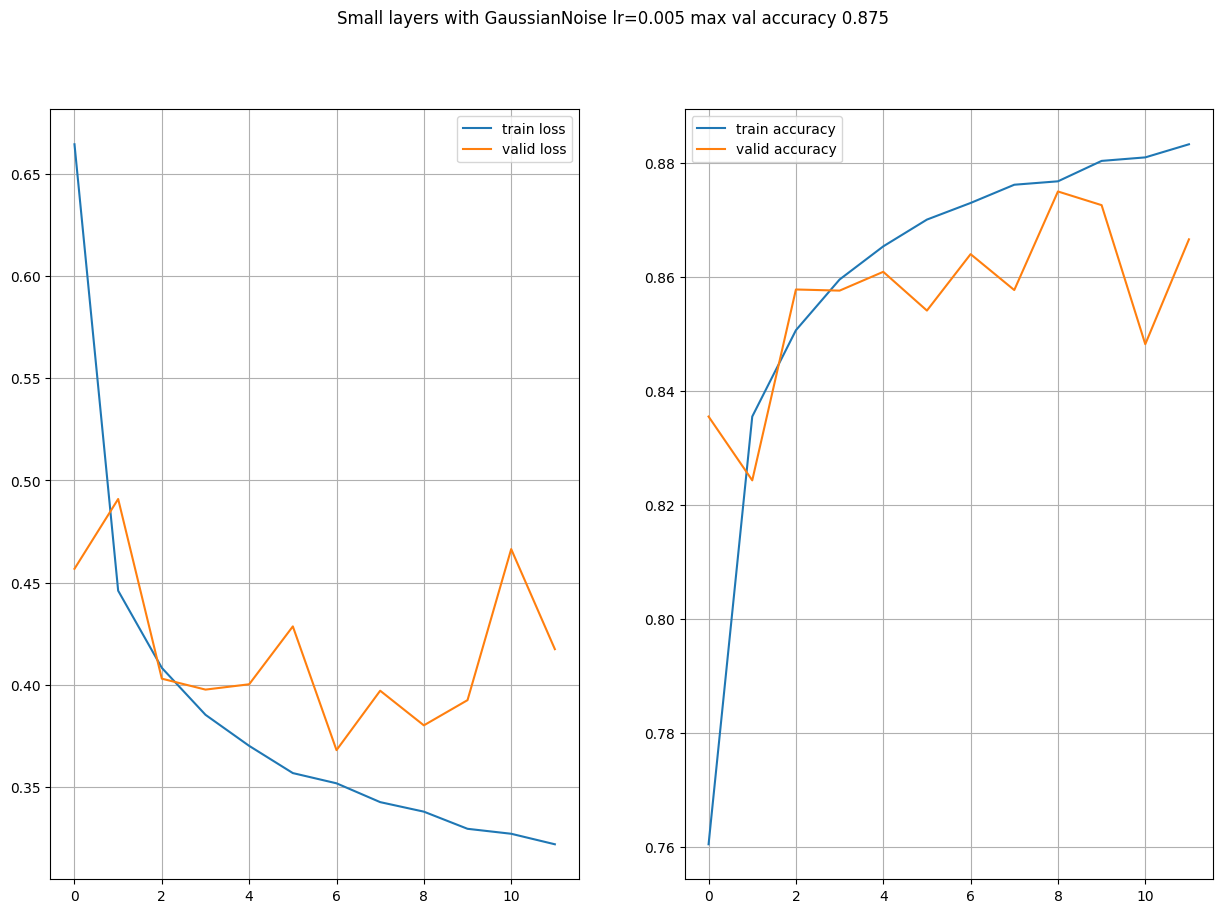

Epoch 1/100
465/469 [============================>.] - ETA: 0s - loss: 0.5851 - accuracy: 0.7853 - categorical_crossentropy: 0.5851INFO:tensorflow:Assets written to: small_la_gn_cp_2\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_2\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.5838 - accuracy: 0.7857 - categorical_crossentropy: 0.5838 - val_loss: 0.4262 - val_accuracy: 0.8454 - val_categorical_crossentropy: 0.4262
Epoch 2/100
462/469 [============================>.] - ETA: 0s - loss: 0.4129 - accuracy: 0.8456 - categorical_crossentropy: 0.4129INFO:tensorflow:Assets written to: small_la_gn_cp_2\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_2\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4130 - accuracy: 0.8456 - categorical_crossentropy: 0.4130 - val_loss: 0.4011 - val_accuracy: 0.8531 - val_categorical_crossentropy: 0.4011
Epoch 3/100
465/469 [============================>.] - ETA: 0s - loss: 0.3692 - accuracy: 0.8627 - categorical_crossentropy: 0.3692INFO:tensorflow:Assets written to: small_la_gn_cp_2\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_2\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3691 - accuracy: 0.8627 - categorical_crossentropy: 0.3691 - val_loss: 0.3679 - val_accuracy: 0.8642 - val_categorical_crossentropy: 0.3679
Epoch 4/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3410 - accuracy: 0.8726 - categorical_crossentropy: 0.3410 - val_loss: 0.3876 - val_accuracy: 0.8620 - val_categorical_crossentropy: 0.3876
Epoch 5/100
469/469 [==============================] - ETA: 0s - loss: 0.3211 - accuracy: 0.8795 - categorical_crossentropy: 0.3211INFO:tensorflow:Assets written to: small_la_gn_cp_2\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_2\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.3211 - accuracy: 0.8795 - categorical_crossentropy: 0.3211 - val_loss: 0.3437 - val_accuracy: 0.8766 - val_categorical_crossentropy: 0.3437
Epoch 6/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3032 - accuracy: 0.8851 - categorical_crossentropy: 0.3032 - val_loss: 0.3963 - val_accuracy: 0.8680 - val_categorical_crossentropy: 0.3963
Epoch 7/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2933 - accuracy: 0.8898 - categorical_crossentropy: 0.2933 - val_loss: 0.3662 - val_accuracy: 0.8732 - val_categorical_crossentropy: 0.3662
Epoch 8/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2812 - accuracy: 0.8929 - categorical_crossentropy: 0.2812 - val_loss: 0.3715 - val_accuracy: 0.8708 - val_categorical_crossentropy: 0.3715
Epoch 9/100
460/469 [============================>.] - ETA: 0s - loss: 0.2720 - accuracy: 0.8976 - categorical_crossentropy: 0.2720INFO:tensorfl

INFO:tensorflow:Assets written to: small_la_gn_cp_2\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2723 - accuracy: 0.8976 - categorical_crossentropy: 0.2723 - val_loss: 0.3328 - val_accuracy: 0.8814 - val_categorical_crossentropy: 0.3328
Epoch 10/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2619 - accuracy: 0.9018 - categorical_crossentropy: 0.2619 - val_loss: 0.3408 - val_accuracy: 0.8808 - val_categorical_crossentropy: 0.3408
Epoch 11/100
459/469 [============================>.] - ETA: 0s - loss: 0.2529 - accuracy: 0.9044 - categorical_crossentropy: 0.2529INFO:tensorflow:Assets written to: small_la_gn_cp_2\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_2\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2534 - accuracy: 0.9042 - categorical_crossentropy: 0.2534 - val_loss: 0.3159 - val_accuracy: 0.8881 - val_categorical_crossentropy: 0.3159
Epoch 12/100
469/469 [==============================] - ETA: 0s - loss: 0.2469 - accuracy: 0.9062 - categorical_crossentropy: 0.2469INFO:tensorflow:Assets written to: small_la_gn_cp_2\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_2\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2469 - accuracy: 0.9062 - categorical_crossentropy: 0.2469 - val_loss: 0.3175 - val_accuracy: 0.8898 - val_categorical_crossentropy: 0.3175
Epoch 13/100
469/469 [==============================] - ETA: 0s - loss: 0.2395 - accuracy: 0.9094 - categorical_crossentropy: 0.2395INFO:tensorflow:Assets written to: small_la_gn_cp_2\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_2\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2395 - accuracy: 0.9094 - categorical_crossentropy: 0.2395 - val_loss: 0.3203 - val_accuracy: 0.8911 - val_categorical_crossentropy: 0.3203
Epoch 14/100
469/469 [==============================] - 4s 8ms/step - loss: 0.2348 - accuracy: 0.9123 - categorical_crossentropy: 0.2348 - val_loss: 0.3356 - val_accuracy: 0.8909 - val_categorical_crossentropy: 0.3356
Epoch 15/100
466/469 [============================>.] - ETA: 0s - loss: 0.2255 - accuracy: 0.9132 - categorical_crossentropy: 0.2255INFO:tensorflow:Assets written to: small_la_gn_cp_2\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_2\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2254 - accuracy: 0.9133 - categorical_crossentropy: 0.2254 - val_loss: 0.3336 - val_accuracy: 0.8917 - val_categorical_crossentropy: 0.3336
Epoch 16/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2234 - accuracy: 0.9153 - categorical_crossentropy: 0.2234 - val_loss: 0.3285 - val_accuracy: 0.8900 - val_categorical_crossentropy: 0.3285


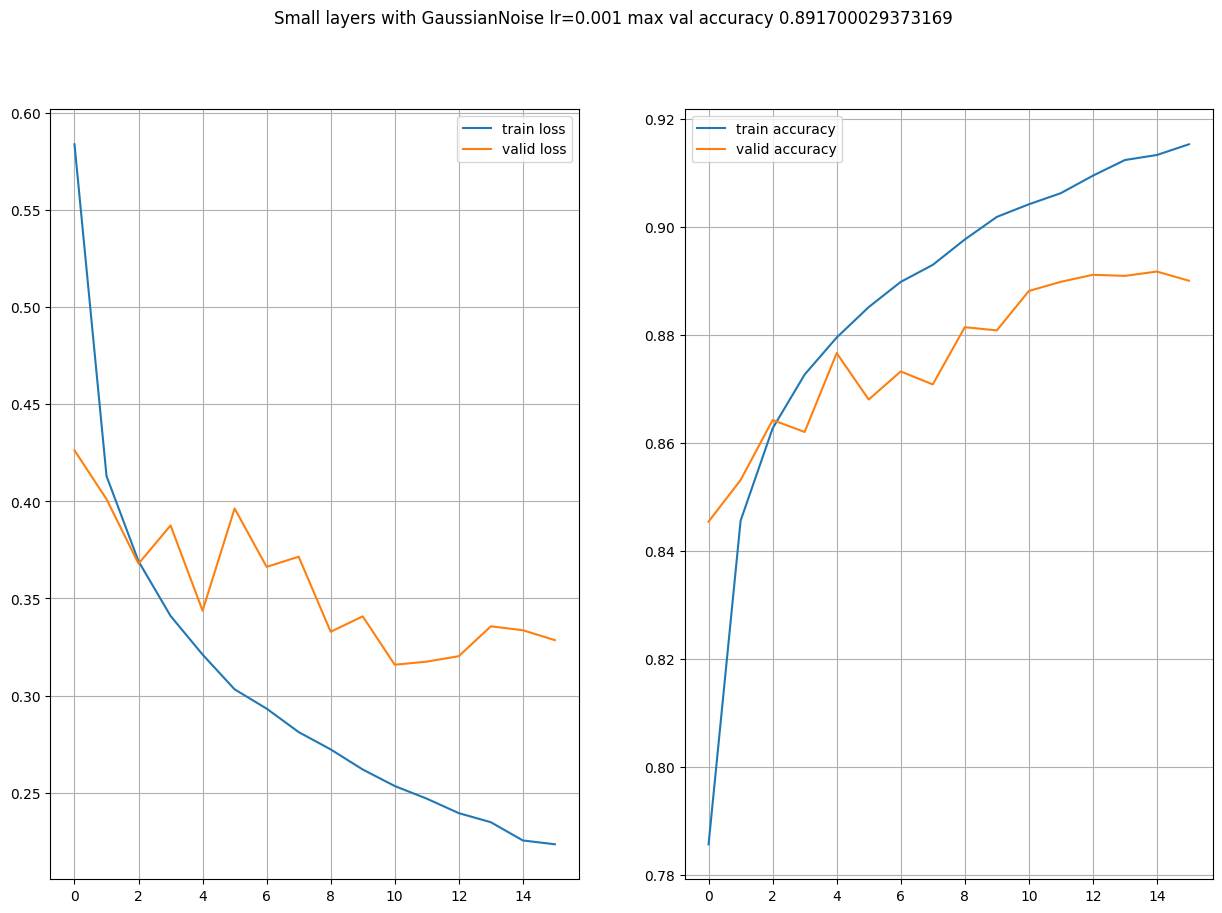

Epoch 1/100
468/469 [============================>.] - ETA: 0s - loss: 0.6206 - accuracy: 0.7773 - categorical_crossentropy: 0.6206INFO:tensorflow:Assets written to: small_la_gn_cp_3\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_3\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.6202 - accuracy: 0.7773 - categorical_crossentropy: 0.6202 - val_loss: 0.4843 - val_accuracy: 0.8223 - val_categorical_crossentropy: 0.4843
Epoch 2/100
469/469 [==============================] - ETA: 0s - loss: 0.4405 - accuracy: 0.8396 - categorical_crossentropy: 0.4405INFO:tensorflow:Assets written to: small_la_gn_cp_3\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_3\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.4405 - accuracy: 0.8396 - categorical_crossentropy: 0.4405 - val_loss: 0.4147 - val_accuracy: 0.8496 - val_categorical_crossentropy: 0.4147
Epoch 3/100
463/469 [============================>.] - ETA: 0s - loss: 0.3950 - accuracy: 0.8546 - categorical_crossentropy: 0.3950INFO:tensorflow:Assets written to: small_la_gn_cp_3\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_3\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3950 - accuracy: 0.8547 - categorical_crossentropy: 0.3950 - val_loss: 0.4079 - val_accuracy: 0.8528 - val_categorical_crossentropy: 0.4079
Epoch 4/100
469/469 [==============================] - ETA: 0s - loss: 0.3653 - accuracy: 0.8668 - categorical_crossentropy: 0.3653INFO:tensorflow:Assets written to: small_la_gn_cp_3\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_3\assets


469/469 [==============================] - 4s 10ms/step - loss: 0.3653 - accuracy: 0.8668 - categorical_crossentropy: 0.3653 - val_loss: 0.3912 - val_accuracy: 0.8576 - val_categorical_crossentropy: 0.3912
Epoch 5/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3459 - accuracy: 0.8724 - categorical_crossentropy: 0.3459 - val_loss: 0.4028 - val_accuracy: 0.8544 - val_categorical_crossentropy: 0.4028
Epoch 6/100
466/469 [============================>.] - ETA: 0s - loss: 0.3290 - accuracy: 0.8772 - categorical_crossentropy: 0.3290INFO:tensorflow:Assets written to: small_la_gn_cp_3\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_3\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.3288 - accuracy: 0.8774 - categorical_crossentropy: 0.3288 - val_loss: 0.3521 - val_accuracy: 0.8735 - val_categorical_crossentropy: 0.3521
Epoch 7/100
466/469 [============================>.] - ETA: 0s - loss: 0.3180 - accuracy: 0.8832 - categorical_crossentropy: 0.3180INFO:tensorflow:Assets written to: small_la_gn_cp_3\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_3\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3181 - accuracy: 0.8831 - categorical_crossentropy: 0.3181 - val_loss: 0.3429 - val_accuracy: 0.8775 - val_categorical_crossentropy: 0.3429
Epoch 8/100
460/469 [============================>.] - ETA: 0s - loss: 0.3074 - accuracy: 0.8861 - categorical_crossentropy: 0.3074INFO:tensorflow:Assets written to: small_la_gn_cp_3\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_3\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3065 - accuracy: 0.8864 - categorical_crossentropy: 0.3065 - val_loss: 0.3464 - val_accuracy: 0.8782 - val_categorical_crossentropy: 0.3464
Epoch 9/100
469/469 [==============================] - ETA: 0s - loss: 0.2973 - accuracy: 0.8910 - categorical_crossentropy: 0.2973INFO:tensorflow:Assets written to: small_la_gn_cp_3\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_3\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.2973 - accuracy: 0.8910 - categorical_crossentropy: 0.2973 - val_loss: 0.3344 - val_accuracy: 0.8805 - val_categorical_crossentropy: 0.3344
Epoch 10/100
462/469 [============================>.] - ETA: 0s - loss: 0.2892 - accuracy: 0.8931 - categorical_crossentropy: 0.2892INFO:tensorflow:Assets written to: small_la_gn_cp_3\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_3\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2897 - accuracy: 0.8928 - categorical_crossentropy: 0.2897 - val_loss: 0.3334 - val_accuracy: 0.8812 - val_categorical_crossentropy: 0.3334
Epoch 11/100
463/469 [============================>.] - ETA: 0s - loss: 0.2808 - accuracy: 0.8951 - categorical_crossentropy: 0.2808INFO:tensorflow:Assets written to: small_la_gn_cp_3\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_3\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.2807 - accuracy: 0.8951 - categorical_crossentropy: 0.2807 - val_loss: 0.3213 - val_accuracy: 0.8839 - val_categorical_crossentropy: 0.3213
Epoch 12/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2741 - accuracy: 0.8978 - categorical_crossentropy: 0.2741 - val_loss: 0.3323 - val_accuracy: 0.8837 - val_categorical_crossentropy: 0.3323
Epoch 13/100
469/469 [==============================] - ETA: 0s - loss: 0.2669 - accuracy: 0.9006 - categorical_crossentropy: 0.2669INFO:tensorflow:Assets written to: small_la_gn_cp_3\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_3\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2669 - accuracy: 0.9006 - categorical_crossentropy: 0.2669 - val_loss: 0.3251 - val_accuracy: 0.8845 - val_categorical_crossentropy: 0.3251
Epoch 14/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2618 - accuracy: 0.9020 - categorical_crossentropy: 0.2618 - val_loss: 0.3256 - val_accuracy: 0.8841 - val_categorical_crossentropy: 0.3256
Epoch 15/100
468/469 [============================>.] - ETA: 0s - loss: 0.2555 - accuracy: 0.9036 - categorical_crossentropy: 0.2555INFO:tensorflow:Assets written to: small_la_gn_cp_3\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_3\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2553 - accuracy: 0.9037 - categorical_crossentropy: 0.2553 - val_loss: 0.3215 - val_accuracy: 0.8858 - val_categorical_crossentropy: 0.3215
Epoch 16/100
461/469 [============================>.] - ETA: 0s - loss: 0.2489 - accuracy: 0.9063 - categorical_crossentropy: 0.2489INFO:tensorflow:Assets written to: small_la_gn_cp_3\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_3\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.2491 - accuracy: 0.9062 - categorical_crossentropy: 0.2491 - val_loss: 0.3244 - val_accuracy: 0.8883 - val_categorical_crossentropy: 0.3244


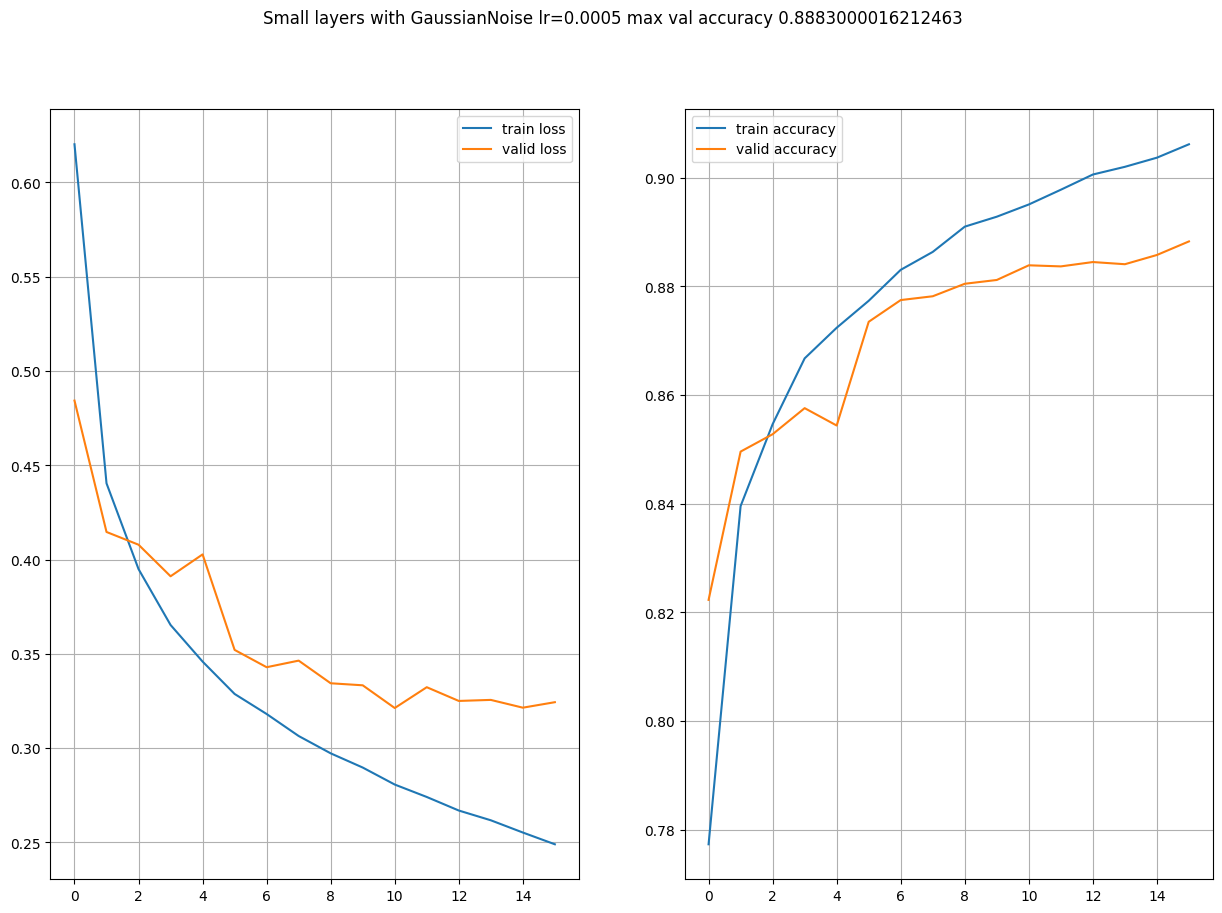

In [34]:

lrs = [.01, .005, .001, .0005]
idx = 0

for lr in lrs:
    small_layers_GN = [
        Dense(128, activation="relu", input_shape=(28*28,)),
        GaussianNoise(0.2),
        Dense(512, activation="relu"),
        GaussianNoise(.2),
        Dense(10, activation="softmax"),
    ]

    small_model_GN = create_model_2(small_layers_GN, RMSprop(learning_rate=lr))
    history = fit_and_present_2(small_model_GN, def_ds, val_dataset, description=f"Small layers with GaussianNoise lr={lr}", filepath=f"small_la_gn_cp_{idx}")

    idx+=1

OK, ще пограємось з lr

Epoch 1/100


469/469 [==============================] - ETA: 0s - loss: 0.6251 - accuracy: 0.7773 - categorical_crossentropy: 0.6251INFO:tensorflow:Assets written to: small_la_gn_cp_10\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_10\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.6251 - accuracy: 0.7773 - categorical_crossentropy: 0.6251 - val_loss: 0.4756 - val_accuracy: 0.8251 - val_categorical_crossentropy: 0.4756
Epoch 2/100
469/469 [==============================] - ETA: 0s - loss: 0.4416 - accuracy: 0.8416 - categorical_crossentropy: 0.4416INFO:tensorflow:Assets written to: small_la_gn_cp_10\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_10\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.4416 - accuracy: 0.8416 - categorical_crossentropy: 0.4416 - val_loss: 0.4215 - val_accuracy: 0.8463 - val_categorical_crossentropy: 0.4215
Epoch 3/100
463/469 [============================>.] - ETA: 0s - loss: 0.3930 - accuracy: 0.8558 - categorical_crossentropy: 0.3930INFO:tensorflow:Assets written to: small_la_gn_cp_10\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_10\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3932 - accuracy: 0.8558 - categorical_crossentropy: 0.3932 - val_loss: 0.4115 - val_accuracy: 0.8497 - val_categorical_crossentropy: 0.4115
Epoch 4/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3646 - accuracy: 0.8660 - categorical_crossentropy: 0.3646 - val_loss: 0.3989 - val_accuracy: 0.8482 - val_categorical_crossentropy: 0.3989
Epoch 5/100
466/469 [============================>.] - ETA: 0s - loss: 0.3461 - accuracy: 0.8710 - categorical_crossentropy: 0.3461INFO:tensorflow:Assets written to: small_la_gn_cp_10\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_10\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3456 - accuracy: 0.8711 - categorical_crossentropy: 0.3456 - val_loss: 0.4030 - val_accuracy: 0.8558 - val_categorical_crossentropy: 0.4030
Epoch 6/100
463/469 [============================>.] - ETA: 0s - loss: 0.3293 - accuracy: 0.8785 - categorical_crossentropy: 0.3293INFO:tensorflow:Assets written to: small_la_gn_cp_10\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_10\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3295 - accuracy: 0.8786 - categorical_crossentropy: 0.3295 - val_loss: 0.3486 - val_accuracy: 0.8736 - val_categorical_crossentropy: 0.3486
Epoch 7/100
464/469 [============================>.] - ETA: 0s - loss: 0.3166 - accuracy: 0.8815 - categorical_crossentropy: 0.3166INFO:tensorflow:Assets written to: small_la_gn_cp_10\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_10\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3169 - accuracy: 0.8814 - categorical_crossentropy: 0.3169 - val_loss: 0.3457 - val_accuracy: 0.8764 - val_categorical_crossentropy: 0.3457
Epoch 8/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3048 - accuracy: 0.8862 - categorical_crossentropy: 0.3048 - val_loss: 0.3553 - val_accuracy: 0.8729 - val_categorical_crossentropy: 0.3553
Epoch 9/100
457/469 [============================>.] - ETA: 0s - loss: 0.2950 - accuracy: 0.8894 - categorical_crossentropy: 0.2950INFO:tensorflow:Assets written to: small_la_gn_cp_10\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_10\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2962 - accuracy: 0.8890 - categorical_crossentropy: 0.2962 - val_loss: 0.3387 - val_accuracy: 0.8800 - val_categorical_crossentropy: 0.3387
Epoch 10/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2858 - accuracy: 0.8936 - categorical_crossentropy: 0.2858 - val_loss: 0.3423 - val_accuracy: 0.8796 - val_categorical_crossentropy: 0.3423
Epoch 11/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2794 - accuracy: 0.8962 - categorical_crossentropy: 0.2794 - val_loss: 0.3319 - val_accuracy: 0.8799 - val_categorical_crossentropy: 0.3319
Epoch 12/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2717 - accuracy: 0.8987 - categorical_crossentropy: 0.2717 - val_loss: 0.3437 - val_accuracy: 0.8789 - val_categorical_crossentropy: 0.3437
Epoch 13/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2650 - accuracy: 0.9013 - categorical_crossentropy: 0.2650 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_10\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2596 - accuracy: 0.9027 - categorical_crossentropy: 0.2596 - val_loss: 0.3261 - val_accuracy: 0.8845 - val_categorical_crossentropy: 0.3261
Epoch 15/100
466/469 [============================>.] - ETA: 0s - loss: 0.2523 - accuracy: 0.9051 - categorical_crossentropy: 0.2523INFO:tensorflow:Assets written to: small_la_gn_cp_10\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_10\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2530 - accuracy: 0.9049 - categorical_crossentropy: 0.2530 - val_loss: 0.3179 - val_accuracy: 0.8853 - val_categorical_crossentropy: 0.3179
Epoch 16/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2486 - accuracy: 0.9058 - categorical_crossentropy: 0.2486 - val_loss: 0.3426 - val_accuracy: 0.8840 - val_categorical_crossentropy: 0.3426
Epoch 17/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2443 - accuracy: 0.9094 - categorical_crossentropy: 0.2443 - val_loss: 0.3247 - val_accuracy: 0.8843 - val_categorical_crossentropy: 0.3247
Epoch 18/100
469/469 [==============================] - ETA: 0s - loss: 0.2349 - accuracy: 0.9114 - categorical_crossentropy: 0.2349INFO:tensorflow:Assets written to: small_la_gn_cp_10\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_10\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2349 - accuracy: 0.9114 - categorical_crossentropy: 0.2349 - val_loss: 0.3146 - val_accuracy: 0.8918 - val_categorical_crossentropy: 0.3146
Epoch 19/100
468/469 [============================>.] - ETA: 0s - loss: 0.2302 - accuracy: 0.9134 - categorical_crossentropy: 0.2302INFO:tensorflow:Assets written to: small_la_gn_cp_10\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_10\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2306 - accuracy: 0.9133 - categorical_crossentropy: 0.2306 - val_loss: 0.3110 - val_accuracy: 0.8931 - val_categorical_crossentropy: 0.3110
Epoch 20/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2279 - accuracy: 0.9129 - categorical_crossentropy: 0.2279 - val_loss: 0.3263 - val_accuracy: 0.8878 - val_categorical_crossentropy: 0.3263
Epoch 21/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2237 - accuracy: 0.9155 - categorical_crossentropy: 0.2237 - val_loss: 0.3204 - val_accuracy: 0.8892 - val_categorical_crossentropy: 0.3204
Epoch 22/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2194 - accuracy: 0.9168 - categorical_crossentropy: 0.2194 - val_loss: 0.3152 - val_accuracy: 0.8931 - val_categorical_crossentropy: 0.3152
Epoch 23/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2137 - accuracy: 0.9193 - categorical_crossentropy: 0.2137 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_10\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2094 - accuracy: 0.9194 - categorical_crossentropy: 0.2094 - val_loss: 0.3091 - val_accuracy: 0.8966 - val_categorical_crossentropy: 0.3091
Epoch 25/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2076 - accuracy: 0.9225 - categorical_crossentropy: 0.2076 - val_loss: 0.3337 - val_accuracy: 0.8884 - val_categorical_crossentropy: 0.3337
Epoch 26/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2014 - accuracy: 0.9242 - categorical_crossentropy: 0.2014 - val_loss: 0.3300 - val_accuracy: 0.8932 - val_categorical_crossentropy: 0.3300
Epoch 27/100
464/469 [============================>.] - ETA: 0s - loss: 0.1997 - accuracy: 0.9239 - categorical_crossentropy: 0.1997INFO:tensorflow:Assets written to: small_la_gn_cp_10\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_10\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.1993 - accuracy: 0.9240 - categorical_crossentropy: 0.1993 - val_loss: 0.3103 - val_accuracy: 0.8976 - val_categorical_crossentropy: 0.3103
Epoch 28/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1947 - accuracy: 0.9265 - categorical_crossentropy: 0.1947 - val_loss: 0.3140 - val_accuracy: 0.8936 - val_categorical_crossentropy: 0.3140
Epoch 29/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1937 - accuracy: 0.9266 - categorical_crossentropy: 0.1937 - val_loss: 0.3292 - val_accuracy: 0.8952 - val_categorical_crossentropy: 0.3292


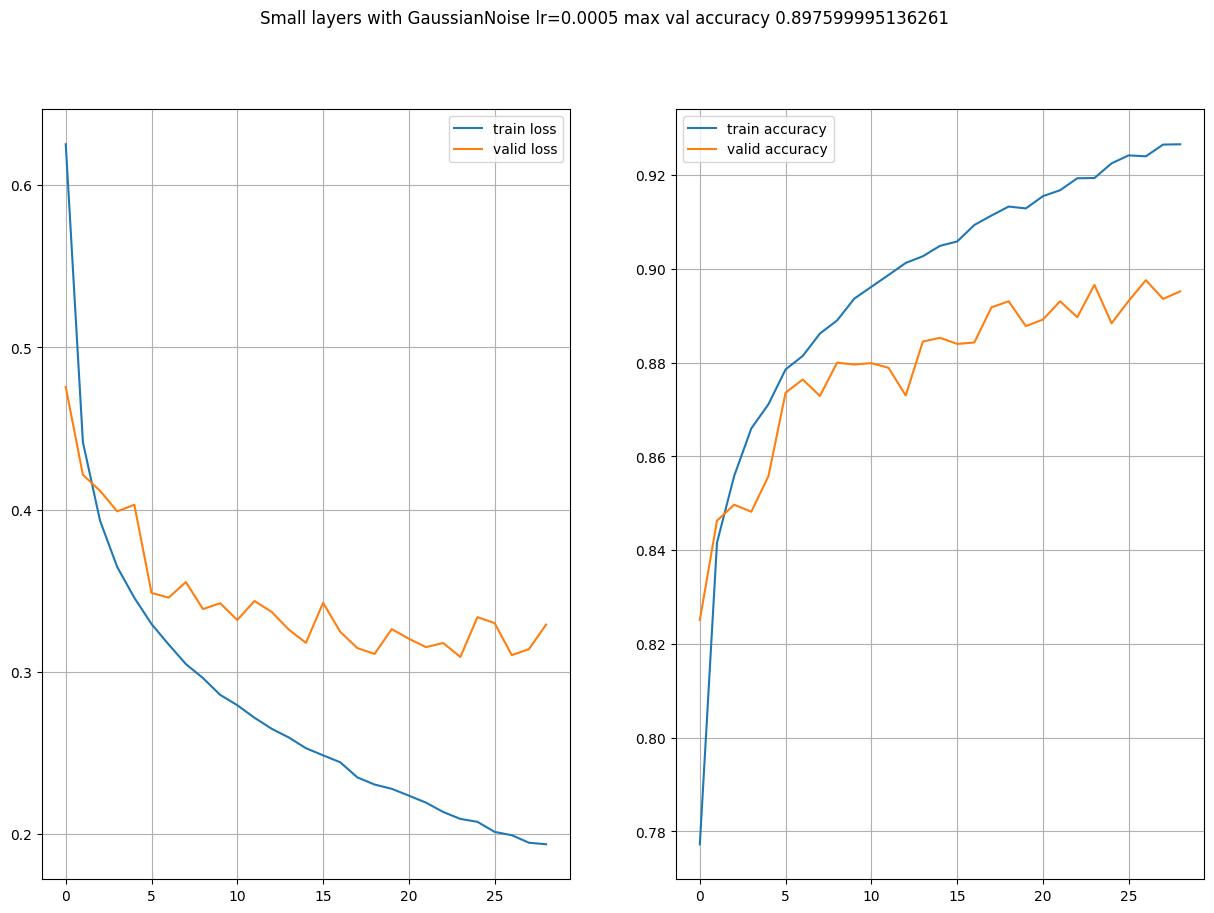

Epoch 1/100
466/469 [============================>.] - ETA: 0s - loss: 0.8693 - accuracy: 0.7055 - categorical_crossentropy: 0.8693INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


469/469 [==============================] - 5s 9ms/step - loss: 0.8668 - accuracy: 0.7062 - categorical_crossentropy: 0.8668 - val_loss: 0.5854 - val_accuracy: 0.7931 - val_categorical_crossentropy: 0.5854
Epoch 2/100
467/469 [============================>.] - ETA: 0s - loss: 0.5370 - accuracy: 0.8103 - categorical_crossentropy: 0.5370INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.5369 - accuracy: 0.8103 - categorical_crossentropy: 0.5369 - val_loss: 0.5004 - val_accuracy: 0.8280 - val_categorical_crossentropy: 0.5004
Epoch 3/100
466/469 [============================>.] - ETA: 0s - loss: 0.4870 - accuracy: 0.8272 - categorical_crossentropy: 0.4870INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4870 - accuracy: 0.8272 - categorical_crossentropy: 0.4870 - val_loss: 0.4748 - val_accuracy: 0.8350 - val_categorical_crossentropy: 0.4748
Epoch 4/100
466/469 [============================>.] - ETA: 0s - loss: 0.4581 - accuracy: 0.8379 - categorical_crossentropy: 0.4581INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4580 - accuracy: 0.8378 - categorical_crossentropy: 0.4580 - val_loss: 0.4469 - val_accuracy: 0.8418 - val_categorical_crossentropy: 0.4469
Epoch 5/100
463/469 [============================>.] - ETA: 0s - loss: 0.4385 - accuracy: 0.8444 - categorical_crossentropy: 0.4385INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4385 - accuracy: 0.8444 - categorical_crossentropy: 0.4385 - val_loss: 0.4452 - val_accuracy: 0.8443 - val_categorical_crossentropy: 0.4452
Epoch 6/100
467/469 [============================>.] - ETA: 0s - loss: 0.4254 - accuracy: 0.8491 - categorical_crossentropy: 0.4254INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4251 - accuracy: 0.8492 - categorical_crossentropy: 0.4251 - val_loss: 0.4297 - val_accuracy: 0.8497 - val_categorical_crossentropy: 0.4297
Epoch 7/100
463/469 [============================>.] - ETA: 0s - loss: 0.4115 - accuracy: 0.8532 - categorical_crossentropy: 0.4115INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4122 - accuracy: 0.8530 - categorical_crossentropy: 0.4122 - val_loss: 0.4204 - val_accuracy: 0.8500 - val_categorical_crossentropy: 0.4204
Epoch 8/100
461/469 [============================>.] - ETA: 0s - loss: 0.4045 - accuracy: 0.8566 - categorical_crossentropy: 0.4045INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4040 - accuracy: 0.8569 - categorical_crossentropy: 0.4040 - val_loss: 0.4135 - val_accuracy: 0.8541 - val_categorical_crossentropy: 0.4135
Epoch 9/100
461/469 [============================>.] - ETA: 0s - loss: 0.3941 - accuracy: 0.8593 - categorical_crossentropy: 0.3941INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


469/469 [==============================] - 5s 11ms/step - loss: 0.3941 - accuracy: 0.8594 - categorical_crossentropy: 0.3941 - val_loss: 0.3994 - val_accuracy: 0.8572 - val_categorical_crossentropy: 0.3994
Epoch 10/100
467/469 [============================>.] - ETA: 0s - loss: 0.3849 - accuracy: 0.8637 - categorical_crossentropy: 0.3849INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3850 - accuracy: 0.8636 - categorical_crossentropy: 0.3850 - val_loss: 0.4024 - val_accuracy: 0.8581 - val_categorical_crossentropy: 0.4024
Epoch 11/100
465/469 [============================>.] - ETA: 0s - loss: 0.3776 - accuracy: 0.8652 - categorical_crossentropy: 0.3776INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3775 - accuracy: 0.8652 - categorical_crossentropy: 0.3775 - val_loss: 0.3907 - val_accuracy: 0.8620 - val_categorical_crossentropy: 0.3907
Epoch 12/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3743 - accuracy: 0.8654 - categorical_crossentropy: 0.3743 - val_loss: 0.3924 - val_accuracy: 0.8601 - val_categorical_crossentropy: 0.3924
Epoch 13/100
459/469 [============================>.] - ETA: 0s - loss: 0.3678 - accuracy: 0.8673 - categorical_crossentropy: 0.3678INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.3677 - accuracy: 0.8673 - categorical_crossentropy: 0.3677 - val_loss: 0.3847 - val_accuracy: 0.8636 - val_categorical_crossentropy: 0.3847
Epoch 14/100
461/469 [============================>.] - ETA: 0s - loss: 0.3614 - accuracy: 0.8692 - categorical_crossentropy: 0.3614INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3618 - accuracy: 0.8691 - categorical_crossentropy: 0.3618 - val_loss: 0.3792 - val_accuracy: 0.8650 - val_categorical_crossentropy: 0.3792
Epoch 15/100
467/469 [============================>.] - ETA: 0s - loss: 0.3576 - accuracy: 0.8709 - categorical_crossentropy: 0.3576INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3577 - accuracy: 0.8707 - categorical_crossentropy: 0.3577 - val_loss: 0.3774 - val_accuracy: 0.8654 - val_categorical_crossentropy: 0.3774
Epoch 16/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3535 - accuracy: 0.8721 - categorical_crossentropy: 0.3535 - val_loss: 0.3879 - val_accuracy: 0.8619 - val_categorical_crossentropy: 0.3879
Epoch 17/100
461/469 [============================>.] - ETA: 0s - loss: 0.3507 - accuracy: 0.8730 - categorical_crossentropy: 0.3507INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.3506 - accuracy: 0.8731 - categorical_crossentropy: 0.3506 - val_loss: 0.3663 - val_accuracy: 0.8709 - val_categorical_crossentropy: 0.3663
Epoch 18/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3436 - accuracy: 0.8767 - categorical_crossentropy: 0.3436 - val_loss: 0.3644 - val_accuracy: 0.8699 - val_categorical_crossentropy: 0.3644
Epoch 19/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3399 - accuracy: 0.8777 - categorical_crossentropy: 0.3399 - val_loss: 0.3640 - val_accuracy: 0.8696 - val_categorical_crossentropy: 0.3640
Epoch 20/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3351 - accuracy: 0.8788 - categorical_crossentropy: 0.3351 - val_loss: 0.3689 - val_accuracy: 0.8655 - val_categorical_crossentropy: 0.3689
Epoch 21/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3327 - accuracy: 0.8784 - categorical_crossentropy: 0.3327 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3228 - accuracy: 0.8817 - categorical_crossentropy: 0.3228 - val_loss: 0.3527 - val_accuracy: 0.8754 - val_categorical_crossentropy: 0.3527
Epoch 25/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3210 - accuracy: 0.8827 - categorical_crossentropy: 0.3210 - val_loss: 0.3606 - val_accuracy: 0.8711 - val_categorical_crossentropy: 0.3606
Epoch 26/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3162 - accuracy: 0.8839 - categorical_crossentropy: 0.3162 - val_loss: 0.3479 - val_accuracy: 0.8752 - val_categorical_crossentropy: 0.3479
Epoch 27/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3123 - accuracy: 0.8857 - categorical_crossentropy: 0.3123 - val_loss: 0.3501 - val_accuracy: 0.8751 - val_categorical_crossentropy: 0.3501
Epoch 28/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3106 - accuracy: 0.8851 - categorical_crossentropy: 0.3106 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3069 - accuracy: 0.8875 - categorical_crossentropy: 0.3069 - val_loss: 0.3455 - val_accuracy: 0.8770 - val_categorical_crossentropy: 0.3455
Epoch 30/100
468/469 [============================>.] - ETA: 0s - loss: 0.3060 - accuracy: 0.8877 - categorical_crossentropy: 0.3060INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3060 - accuracy: 0.8877 - categorical_crossentropy: 0.3060 - val_loss: 0.3421 - val_accuracy: 0.8787 - val_categorical_crossentropy: 0.3421
Epoch 31/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3024 - accuracy: 0.8893 - categorical_crossentropy: 0.3024 - val_loss: 0.3485 - val_accuracy: 0.8736 - val_categorical_crossentropy: 0.3485
Epoch 32/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3008 - accuracy: 0.8896 - categorical_crossentropy: 0.3008 - val_loss: 0.3387 - val_accuracy: 0.8787 - val_categorical_crossentropy: 0.3387
Epoch 33/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2989 - accuracy: 0.8911 - categorical_crossentropy: 0.2989 - val_loss: 0.3435 - val_accuracy: 0.8766 - val_categorical_crossentropy: 0.3435
Epoch 34/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2972 - accuracy: 0.8900 - categorical_crossentropy: 0.2972 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2884 - accuracy: 0.8937 - categorical_crossentropy: 0.2884 - val_loss: 0.3353 - val_accuracy: 0.8809 - val_categorical_crossentropy: 0.3353
Epoch 39/100
467/469 [============================>.] - ETA: 0s - loss: 0.2858 - accuracy: 0.8952 - categorical_crossentropy: 0.2858INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2863 - accuracy: 0.8950 - categorical_crossentropy: 0.2863 - val_loss: 0.3312 - val_accuracy: 0.8820 - val_categorical_crossentropy: 0.3312
Epoch 40/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2827 - accuracy: 0.8969 - categorical_crossentropy: 0.2827 - val_loss: 0.3346 - val_accuracy: 0.8812 - val_categorical_crossentropy: 0.3346
Epoch 41/100
466/469 [============================>.] - ETA: 0s - loss: 0.2819 - accuracy: 0.8964 - categorical_crossentropy: 0.2819INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2818 - accuracy: 0.8963 - categorical_crossentropy: 0.2818 - val_loss: 0.3300 - val_accuracy: 0.8834 - val_categorical_crossentropy: 0.3300
Epoch 42/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2817 - accuracy: 0.8958 - categorical_crossentropy: 0.2817 - val_loss: 0.3306 - val_accuracy: 0.8833 - val_categorical_crossentropy: 0.3306
Epoch 43/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2790 - accuracy: 0.8971 - categorical_crossentropy: 0.2790 - val_loss: 0.3293 - val_accuracy: 0.8826 - val_categorical_crossentropy: 0.3293
Epoch 44/100
462/469 [============================>.] - ETA: 0s - loss: 0.2762 - accuracy: 0.8984 - categorical_crossentropy: 0.2762INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2765 - accuracy: 0.8984 - categorical_crossentropy: 0.2765 - val_loss: 0.3285 - val_accuracy: 0.8846 - val_categorical_crossentropy: 0.3285
Epoch 45/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2757 - accuracy: 0.8982 - categorical_crossentropy: 0.2757 - val_loss: 0.3263 - val_accuracy: 0.8825 - val_categorical_crossentropy: 0.3263
Epoch 46/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2729 - accuracy: 0.8984 - categorical_crossentropy: 0.2729 - val_loss: 0.3303 - val_accuracy: 0.8824 - val_categorical_crossentropy: 0.3303
Epoch 47/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2718 - accuracy: 0.8994 - categorical_crossentropy: 0.2718 - val_loss: 0.3315 - val_accuracy: 0.8833 - val_categorical_crossentropy: 0.3315
Epoch 48/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2696 - accuracy: 0.8996 - categorical_crossentropy: 0.2696 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2687 - accuracy: 0.8997 - categorical_crossentropy: 0.2687 - val_loss: 0.3265 - val_accuracy: 0.8861 - val_categorical_crossentropy: 0.3265
Epoch 50/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2671 - accuracy: 0.9015 - categorical_crossentropy: 0.2671 - val_loss: 0.3238 - val_accuracy: 0.8848 - val_categorical_crossentropy: 0.3238
Epoch 51/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2631 - accuracy: 0.9030 - categorical_crossentropy: 0.2631 - val_loss: 0.3302 - val_accuracy: 0.8839 - val_categorical_crossentropy: 0.3302
Epoch 52/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2646 - accuracy: 0.9029 - categorical_crossentropy: 0.2646 - val_loss: 0.3269 - val_accuracy: 0.8839 - val_categorical_crossentropy: 0.3269
Epoch 53/100
469/469 [==============================] - 4s 8ms/step - loss: 0.2619 - accuracy: 0.9026 - categorical_crossentropy: 0.2619 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


469/469 [==============================] - 5s 11ms/step - loss: 0.2606 - accuracy: 0.9043 - categorical_crossentropy: 0.2606 - val_loss: 0.3192 - val_accuracy: 0.8869 - val_categorical_crossentropy: 0.3192
Epoch 55/100
469/469 [==============================] - 4s 8ms/step - loss: 0.2599 - accuracy: 0.9025 - categorical_crossentropy: 0.2599 - val_loss: 0.3216 - val_accuracy: 0.8858 - val_categorical_crossentropy: 0.3216
Epoch 56/100
461/469 [============================>.] - ETA: 0s - loss: 0.2571 - accuracy: 0.9039 - categorical_crossentropy: 0.2571INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.2573 - accuracy: 0.9038 - categorical_crossentropy: 0.2573 - val_loss: 0.3208 - val_accuracy: 0.8878 - val_categorical_crossentropy: 0.3208
Epoch 57/100
469/469 [==============================] - 4s 8ms/step - loss: 0.2556 - accuracy: 0.9054 - categorical_crossentropy: 0.2556 - val_loss: 0.3179 - val_accuracy: 0.8868 - val_categorical_crossentropy: 0.3179
Epoch 58/100
469/469 [==============================] - 4s 8ms/step - loss: 0.2542 - accuracy: 0.9065 - categorical_crossentropy: 0.2542 - val_loss: 0.3262 - val_accuracy: 0.8854 - val_categorical_crossentropy: 0.3262
Epoch 59/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2523 - accuracy: 0.9059 - categorical_crossentropy: 0.2523 - val_loss: 0.3225 - val_accuracy: 0.8836 - val_categorical_crossentropy: 0.3225
Epoch 60/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2509 - accuracy: 0.9071 - categorical_crossentropy: 0.2509 - v

INFO:tensorflow:Assets written to: small_la_gn_cp_11\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.2496 - accuracy: 0.9065 - categorical_crossentropy: 0.2496 - val_loss: 0.3186 - val_accuracy: 0.8895 - val_categorical_crossentropy: 0.3186


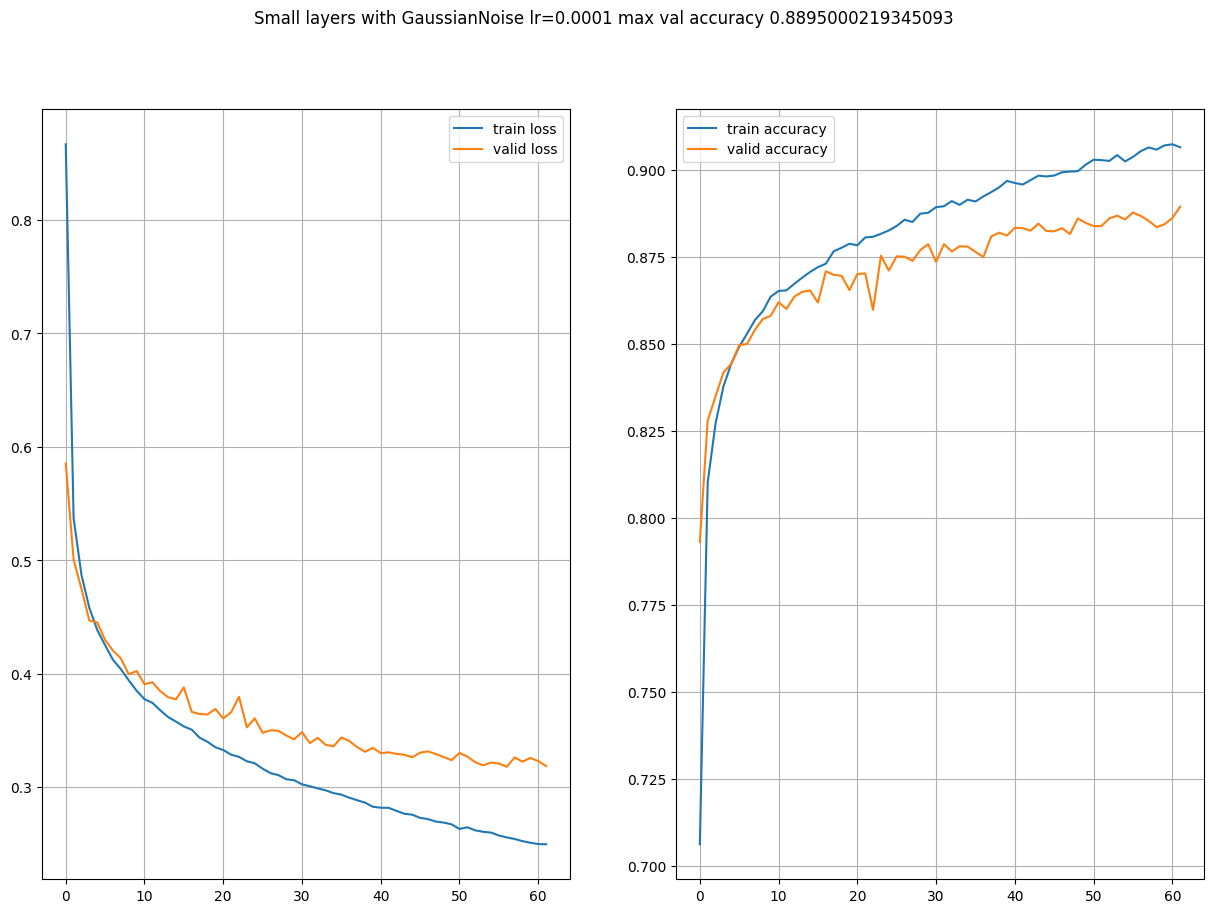

Epoch 1/100
467/469 [============================>.] - ETA: 0s - loss: 1.1841 - accuracy: 0.6068 - categorical_crossentropy: 1.1841INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


469/469 [==============================] - 6s 11ms/step - loss: 1.1822 - accuracy: 0.6075 - categorical_crossentropy: 1.1822 - val_loss: 0.7215 - val_accuracy: 0.7442 - val_categorical_crossentropy: 0.7215
Epoch 2/100
462/469 [============================>.] - ETA: 0s - loss: 0.6539 - accuracy: 0.7703 - categorical_crossentropy: 0.6539INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.6531 - accuracy: 0.7706 - categorical_crossentropy: 0.6531 - val_loss: 0.5861 - val_accuracy: 0.7957 - val_categorical_crossentropy: 0.5861
Epoch 3/100
466/469 [============================>.] - ETA: 0s - loss: 0.5607 - accuracy: 0.8035 - categorical_crossentropy: 0.5607INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.5603 - accuracy: 0.8035 - categorical_crossentropy: 0.5603 - val_loss: 0.5347 - val_accuracy: 0.8155 - val_categorical_crossentropy: 0.5347
Epoch 4/100
466/469 [============================>.] - ETA: 0s - loss: 0.5175 - accuracy: 0.8173 - categorical_crossentropy: 0.5175INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


469/469 [==============================] - 5s 11ms/step - loss: 0.5179 - accuracy: 0.8172 - categorical_crossentropy: 0.5179 - val_loss: 0.5066 - val_accuracy: 0.8228 - val_categorical_crossentropy: 0.5066
Epoch 5/100
469/469 [==============================] - ETA: 0s - loss: 0.4901 - accuracy: 0.8270 - categorical_crossentropy: 0.4901INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


469/469 [==============================] - 5s 11ms/step - loss: 0.4901 - accuracy: 0.8270 - categorical_crossentropy: 0.4901 - val_loss: 0.4832 - val_accuracy: 0.8329 - val_categorical_crossentropy: 0.4832
Epoch 6/100
469/469 [==============================] - ETA: 0s - loss: 0.4727 - accuracy: 0.8321 - categorical_crossentropy: 0.4727INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.4727 - accuracy: 0.8321 - categorical_crossentropy: 0.4727 - val_loss: 0.4708 - val_accuracy: 0.8345 - val_categorical_crossentropy: 0.4708
Epoch 7/100
462/469 [============================>.] - ETA: 0s - loss: 0.4607 - accuracy: 0.8369 - categorical_crossentropy: 0.4607INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


469/469 [==============================] - 5s 11ms/step - loss: 0.4606 - accuracy: 0.8371 - categorical_crossentropy: 0.4606 - val_loss: 0.4612 - val_accuracy: 0.8382 - val_categorical_crossentropy: 0.4612
Epoch 8/100
466/469 [============================>.] - ETA: 0s - loss: 0.4470 - accuracy: 0.8417 - categorical_crossentropy: 0.4470INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


469/469 [==============================] - 5s 11ms/step - loss: 0.4474 - accuracy: 0.8414 - categorical_crossentropy: 0.4474 - val_loss: 0.4527 - val_accuracy: 0.8387 - val_categorical_crossentropy: 0.4527
Epoch 9/100
462/469 [============================>.] - ETA: 0s - loss: 0.4402 - accuracy: 0.8438 - categorical_crossentropy: 0.4402INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


469/469 [==============================] - 5s 11ms/step - loss: 0.4404 - accuracy: 0.8439 - categorical_crossentropy: 0.4404 - val_loss: 0.4409 - val_accuracy: 0.8447 - val_categorical_crossentropy: 0.4409
Epoch 10/100
469/469 [==============================] - 4s 8ms/step - loss: 0.4295 - accuracy: 0.8483 - categorical_crossentropy: 0.4295 - val_loss: 0.4397 - val_accuracy: 0.8429 - val_categorical_crossentropy: 0.4397
Epoch 11/100
461/469 [============================>.] - ETA: 0s - loss: 0.4231 - accuracy: 0.8493 - categorical_crossentropy: 0.4231INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4232 - accuracy: 0.8493 - categorical_crossentropy: 0.4232 - val_loss: 0.4319 - val_accuracy: 0.8466 - val_categorical_crossentropy: 0.4319
Epoch 12/100
460/469 [============================>.] - ETA: 0s - loss: 0.4164 - accuracy: 0.8524 - categorical_crossentropy: 0.4164INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.4157 - accuracy: 0.8526 - categorical_crossentropy: 0.4157 - val_loss: 0.4260 - val_accuracy: 0.8474 - val_categorical_crossentropy: 0.4260
Epoch 13/100
465/469 [============================>.] - ETA: 0s - loss: 0.4115 - accuracy: 0.8529 - categorical_crossentropy: 0.4115INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.4111 - accuracy: 0.8530 - categorical_crossentropy: 0.4111 - val_loss: 0.4193 - val_accuracy: 0.8512 - val_categorical_crossentropy: 0.4193
Epoch 14/100
469/469 [==============================] - 4s 7ms/step - loss: 0.4059 - accuracy: 0.8558 - categorical_crossentropy: 0.4059 - val_loss: 0.4167 - val_accuracy: 0.8500 - val_categorical_crossentropy: 0.4167
Epoch 15/100
466/469 [============================>.] - ETA: 0s - loss: 0.4010 - accuracy: 0.8573 - categorical_crossentropy: 0.4010INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


469/469 [==============================] - 5s 11ms/step - loss: 0.4009 - accuracy: 0.8574 - categorical_crossentropy: 0.4009 - val_loss: 0.4160 - val_accuracy: 0.8549 - val_categorical_crossentropy: 0.4160
Epoch 16/100
469/469 [==============================] - 4s 8ms/step - loss: 0.3979 - accuracy: 0.8589 - categorical_crossentropy: 0.3979 - val_loss: 0.4108 - val_accuracy: 0.8536 - val_categorical_crossentropy: 0.4108
Epoch 17/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3912 - accuracy: 0.8617 - categorical_crossentropy: 0.3912 - val_loss: 0.4084 - val_accuracy: 0.8545 - val_categorical_crossentropy: 0.4084
Epoch 18/100
468/469 [============================>.] - ETA: 0s - loss: 0.3873 - accuracy: 0.8630 - categorical_crossentropy: 0.3873INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3875 - accuracy: 0.8629 - categorical_crossentropy: 0.3875 - val_loss: 0.4073 - val_accuracy: 0.8550 - val_categorical_crossentropy: 0.4073
Epoch 19/100
468/469 [============================>.] - ETA: 0s - loss: 0.3851 - accuracy: 0.8617 - categorical_crossentropy: 0.3851INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


469/469 [==============================] - 5s 11ms/step - loss: 0.3852 - accuracy: 0.8617 - categorical_crossentropy: 0.3852 - val_loss: 0.4024 - val_accuracy: 0.8575 - val_categorical_crossentropy: 0.4024
Epoch 20/100
468/469 [============================>.] - ETA: 0s - loss: 0.3803 - accuracy: 0.8637 - categorical_crossentropy: 0.3803INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


469/469 [==============================] - 5s 11ms/step - loss: 0.3802 - accuracy: 0.8638 - categorical_crossentropy: 0.3802 - val_loss: 0.3989 - val_accuracy: 0.8604 - val_categorical_crossentropy: 0.3989
Epoch 21/100
469/469 [==============================] - 4s 9ms/step - loss: 0.3774 - accuracy: 0.8654 - categorical_crossentropy: 0.3774 - val_loss: 0.3947 - val_accuracy: 0.8595 - val_categorical_crossentropy: 0.3947
Epoch 22/100
465/469 [============================>.] - ETA: 0s - loss: 0.3746 - accuracy: 0.8667 - categorical_crossentropy: 0.3746INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3743 - accuracy: 0.8668 - categorical_crossentropy: 0.3743 - val_loss: 0.3915 - val_accuracy: 0.8611 - val_categorical_crossentropy: 0.3915
Epoch 23/100
466/469 [============================>.] - ETA: 0s - loss: 0.3705 - accuracy: 0.8669 - categorical_crossentropy: 0.3705INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


469/469 [==============================] - 6s 12ms/step - loss: 0.3707 - accuracy: 0.8668 - categorical_crossentropy: 0.3707 - val_loss: 0.3879 - val_accuracy: 0.8622 - val_categorical_crossentropy: 0.3879
Epoch 24/100
469/469 [==============================] - 4s 9ms/step - loss: 0.3685 - accuracy: 0.8690 - categorical_crossentropy: 0.3685 - val_loss: 0.3881 - val_accuracy: 0.8617 - val_categorical_crossentropy: 0.3881
Epoch 25/100
468/469 [============================>.] - ETA: 0s - loss: 0.3643 - accuracy: 0.8694 - categorical_crossentropy: 0.3643INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3642 - accuracy: 0.8694 - categorical_crossentropy: 0.3642 - val_loss: 0.3843 - val_accuracy: 0.8641 - val_categorical_crossentropy: 0.3843
Epoch 26/100
466/469 [============================>.] - ETA: 0s - loss: 0.3619 - accuracy: 0.8715 - categorical_crossentropy: 0.3619INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


469/469 [==============================] - 5s 11ms/step - loss: 0.3622 - accuracy: 0.8714 - categorical_crossentropy: 0.3622 - val_loss: 0.3819 - val_accuracy: 0.8646 - val_categorical_crossentropy: 0.3819
Epoch 27/100
467/469 [============================>.] - ETA: 0s - loss: 0.3598 - accuracy: 0.8699 - categorical_crossentropy: 0.3598INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


469/469 [==============================] - 6s 12ms/step - loss: 0.3598 - accuracy: 0.8699 - categorical_crossentropy: 0.3598 - val_loss: 0.3844 - val_accuracy: 0.8650 - val_categorical_crossentropy: 0.3844
Epoch 28/100
469/469 [==============================] - 4s 9ms/step - loss: 0.3584 - accuracy: 0.8708 - categorical_crossentropy: 0.3584 - val_loss: 0.3822 - val_accuracy: 0.8647 - val_categorical_crossentropy: 0.3822
Epoch 29/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3551 - accuracy: 0.8719 - categorical_crossentropy: 0.3551 - val_loss: 0.3833 - val_accuracy: 0.8648 - val_categorical_crossentropy: 0.3833
Epoch 30/100
465/469 [============================>.] - ETA: 0s - loss: 0.3535 - accuracy: 0.8739 - categorical_crossentropy: 0.3535INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3534 - accuracy: 0.8739 - categorical_crossentropy: 0.3534 - val_loss: 0.3723 - val_accuracy: 0.8680 - val_categorical_crossentropy: 0.3723
Epoch 31/100
467/469 [============================>.] - ETA: 0s - loss: 0.3502 - accuracy: 0.8735 - categorical_crossentropy: 0.3502INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


469/469 [==============================] - 5s 11ms/step - loss: 0.3501 - accuracy: 0.8735 - categorical_crossentropy: 0.3501 - val_loss: 0.3721 - val_accuracy: 0.8691 - val_categorical_crossentropy: 0.3721
Epoch 32/100
469/469 [==============================] - 4s 9ms/step - loss: 0.3470 - accuracy: 0.8752 - categorical_crossentropy: 0.3470 - val_loss: 0.3723 - val_accuracy: 0.8669 - val_categorical_crossentropy: 0.3723
Epoch 33/100
464/469 [============================>.] - ETA: 0s - loss: 0.3446 - accuracy: 0.8764 - categorical_crossentropy: 0.3446INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3450 - accuracy: 0.8763 - categorical_crossentropy: 0.3450 - val_loss: 0.3695 - val_accuracy: 0.8697 - val_categorical_crossentropy: 0.3695
Epoch 34/100
469/469 [==============================] - 4s 8ms/step - loss: 0.3449 - accuracy: 0.8752 - categorical_crossentropy: 0.3449 - val_loss: 0.3711 - val_accuracy: 0.8689 - val_categorical_crossentropy: 0.3711
Epoch 35/100
466/469 [============================>.] - ETA: 0s - loss: 0.3400 - accuracy: 0.8778 - categorical_crossentropy: 0.3400INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3398 - accuracy: 0.8780 - categorical_crossentropy: 0.3398 - val_loss: 0.3691 - val_accuracy: 0.8703 - val_categorical_crossentropy: 0.3691
Epoch 36/100
469/469 [==============================] - 4s 8ms/step - loss: 0.3375 - accuracy: 0.8788 - categorical_crossentropy: 0.3375 - val_loss: 0.3731 - val_accuracy: 0.8678 - val_categorical_crossentropy: 0.3731
Epoch 37/100
463/469 [============================>.] - ETA: 0s - loss: 0.3366 - accuracy: 0.8779 - categorical_crossentropy: 0.3366INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3365 - accuracy: 0.8780 - categorical_crossentropy: 0.3365 - val_loss: 0.3680 - val_accuracy: 0.8704 - val_categorical_crossentropy: 0.3680
Epoch 38/100
463/469 [============================>.] - ETA: 0s - loss: 0.3359 - accuracy: 0.8792 - categorical_crossentropy: 0.3359INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


469/469 [==============================] - 5s 11ms/step - loss: 0.3360 - accuracy: 0.8792 - categorical_crossentropy: 0.3360 - val_loss: 0.3617 - val_accuracy: 0.8724 - val_categorical_crossentropy: 0.3617
Epoch 39/100
469/469 [==============================] - 4s 9ms/step - loss: 0.3340 - accuracy: 0.8793 - categorical_crossentropy: 0.3340 - val_loss: 0.3655 - val_accuracy: 0.8716 - val_categorical_crossentropy: 0.3655
Epoch 40/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3307 - accuracy: 0.8809 - categorical_crossentropy: 0.3307 - val_loss: 0.3629 - val_accuracy: 0.8721 - val_categorical_crossentropy: 0.3629
Epoch 41/100
465/469 [============================>.] - ETA: 0s - loss: 0.3320 - accuracy: 0.8798 - categorical_crossentropy: 0.3320INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3318 - accuracy: 0.8798 - categorical_crossentropy: 0.3318 - val_loss: 0.3627 - val_accuracy: 0.8744 - val_categorical_crossentropy: 0.3627
Epoch 42/100
469/469 [==============================] - 4s 8ms/step - loss: 0.3293 - accuracy: 0.8797 - categorical_crossentropy: 0.3293 - val_loss: 0.3593 - val_accuracy: 0.8738 - val_categorical_crossentropy: 0.3593
Epoch 43/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3245 - accuracy: 0.8824 - categorical_crossentropy: 0.3245 - val_loss: 0.3582 - val_accuracy: 0.8727 - val_categorical_crossentropy: 0.3582
Epoch 44/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3244 - accuracy: 0.8829 - categorical_crossentropy: 0.3244 - val_loss: 0.3561 - val_accuracy: 0.8742 - val_categorical_crossentropy: 0.3561
Epoch 45/100
460/469 [============================>.] - ETA: 0s - loss: 0.3244 - accuracy: 0.8824 - categorical_crossentropy: 0.3244INFO:ten

INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3249 - accuracy: 0.8823 - categorical_crossentropy: 0.3249 - val_loss: 0.3535 - val_accuracy: 0.8746 - val_categorical_crossentropy: 0.3535
Epoch 46/100
469/469 [==============================] - 4s 8ms/step - loss: 0.3215 - accuracy: 0.8823 - categorical_crossentropy: 0.3215 - val_loss: 0.3552 - val_accuracy: 0.8738 - val_categorical_crossentropy: 0.3552
Epoch 47/100
462/469 [============================>.] - ETA: 0s - loss: 0.3210 - accuracy: 0.8824 - categorical_crossentropy: 0.3210INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3208 - accuracy: 0.8826 - categorical_crossentropy: 0.3208 - val_loss: 0.3519 - val_accuracy: 0.8748 - val_categorical_crossentropy: 0.3519
Epoch 48/100
462/469 [============================>.] - ETA: 0s - loss: 0.3194 - accuracy: 0.8835 - categorical_crossentropy: 0.3194INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3199 - accuracy: 0.8834 - categorical_crossentropy: 0.3199 - val_loss: 0.3564 - val_accuracy: 0.8756 - val_categorical_crossentropy: 0.3564
Epoch 49/100
469/469 [==============================] - 4s 8ms/step - loss: 0.3168 - accuracy: 0.8844 - categorical_crossentropy: 0.3168 - val_loss: 0.3574 - val_accuracy: 0.8721 - val_categorical_crossentropy: 0.3574
Epoch 50/100
469/469 [==============================] - 4s 8ms/step - loss: 0.3164 - accuracy: 0.8853 - categorical_crossentropy: 0.3164 - val_loss: 0.3524 - val_accuracy: 0.8749 - val_categorical_crossentropy: 0.3524
Epoch 51/100
469/469 [==============================] - 4s 8ms/step - loss: 0.3150 - accuracy: 0.8856 - categorical_crossentropy: 0.3150 - val_loss: 0.3531 - val_accuracy: 0.8745 - val_categorical_crossentropy: 0.3531
Epoch 52/100
466/469 [============================>.] - ETA: 0s - loss: 0.3128 - accuracy: 0.8863 - categorical_crossentropy: 0.3128INFO:ten

INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


469/469 [==============================] - 6s 13ms/step - loss: 0.3128 - accuracy: 0.8864 - categorical_crossentropy: 0.3128 - val_loss: 0.3508 - val_accuracy: 0.8768 - val_categorical_crossentropy: 0.3508
Epoch 53/100
467/469 [============================>.] - ETA: 0s - loss: 0.3117 - accuracy: 0.8859 - categorical_crossentropy: 0.3117INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


469/469 [==============================] - 6s 12ms/step - loss: 0.3121 - accuracy: 0.8858 - categorical_crossentropy: 0.3121 - val_loss: 0.3476 - val_accuracy: 0.8791 - val_categorical_crossentropy: 0.3476
Epoch 54/100
469/469 [==============================] - 4s 7ms/step - loss: 0.3109 - accuracy: 0.8863 - categorical_crossentropy: 0.3109 - val_loss: 0.3469 - val_accuracy: 0.8782 - val_categorical_crossentropy: 0.3469
Epoch 55/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3082 - accuracy: 0.8871 - categorical_crossentropy: 0.3082 - val_loss: 0.3482 - val_accuracy: 0.8776 - val_categorical_crossentropy: 0.3482
Epoch 56/100
469/469 [==============================] - 4s 8ms/step - loss: 0.3065 - accuracy: 0.8875 - categorical_crossentropy: 0.3065 - val_loss: 0.3466 - val_accuracy: 0.8777 - val_categorical_crossentropy: 0.3466
Epoch 57/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3067 - accuracy: 0.8873 - categorical_crossentropy: 0.3067 - v

INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


469/469 [==============================] - 5s 11ms/step - loss: 0.3036 - accuracy: 0.8897 - categorical_crossentropy: 0.3036 - val_loss: 0.3412 - val_accuracy: 0.8800 - val_categorical_crossentropy: 0.3412
Epoch 61/100
466/469 [============================>.] - ETA: 0s - loss: 0.3016 - accuracy: 0.8898 - categorical_crossentropy: 0.3016INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


469/469 [==============================] - 5s 11ms/step - loss: 0.3014 - accuracy: 0.8899 - categorical_crossentropy: 0.3014 - val_loss: 0.3447 - val_accuracy: 0.8809 - val_categorical_crossentropy: 0.3447
Epoch 62/100
469/469 [==============================] - 4s 9ms/step - loss: 0.3017 - accuracy: 0.8895 - categorical_crossentropy: 0.3017 - val_loss: 0.3443 - val_accuracy: 0.8768 - val_categorical_crossentropy: 0.3443
Epoch 63/100
469/469 [==============================] - 4s 8ms/step - loss: 0.2992 - accuracy: 0.8897 - categorical_crossentropy: 0.2992 - val_loss: 0.3396 - val_accuracy: 0.8807 - val_categorical_crossentropy: 0.3396
Epoch 64/100
469/469 [==============================] - 5s 10ms/step - loss: 0.2967 - accuracy: 0.8917 - categorical_crossentropy: 0.2967 - val_loss: 0.3409 - val_accuracy: 0.8789 - val_categorical_crossentropy: 0.3409
Epoch 65/100
469/469 [==============================] - 4s 9ms/step - loss: 0.2970 - accuracy: 0.8914 - categorical_crossentropy: 0.2970 - 

INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


469/469 [==============================] - 5s 11ms/step - loss: 0.2905 - accuracy: 0.8929 - categorical_crossentropy: 0.2905 - val_loss: 0.3371 - val_accuracy: 0.8814 - val_categorical_crossentropy: 0.3371
Epoch 72/100
468/469 [============================>.] - ETA: 0s - loss: 0.2884 - accuracy: 0.8932 - categorical_crossentropy: 0.2884INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


469/469 [==============================] - 6s 12ms/step - loss: 0.2885 - accuracy: 0.8933 - categorical_crossentropy: 0.2885 - val_loss: 0.3344 - val_accuracy: 0.8817 - val_categorical_crossentropy: 0.3344
Epoch 73/100
463/469 [============================>.] - ETA: 0s - loss: 0.2891 - accuracy: 0.8938 - categorical_crossentropy: 0.2891INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_12\assets


469/469 [==============================] - 5s 11ms/step - loss: 0.2894 - accuracy: 0.8937 - categorical_crossentropy: 0.2894 - val_loss: 0.3383 - val_accuracy: 0.8822 - val_categorical_crossentropy: 0.3383
Epoch 74/100
469/469 [==============================] - 4s 8ms/step - loss: 0.2866 - accuracy: 0.8950 - categorical_crossentropy: 0.2866 - val_loss: 0.3423 - val_accuracy: 0.8800 - val_categorical_crossentropy: 0.3423
Epoch 75/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2857 - accuracy: 0.8950 - categorical_crossentropy: 0.2857 - val_loss: 0.3347 - val_accuracy: 0.8810 - val_categorical_crossentropy: 0.3347
Epoch 76/100
469/469 [==============================] - 4s 7ms/step - loss: 0.2851 - accuracy: 0.8968 - categorical_crossentropy: 0.2851 - val_loss: 0.3345 - val_accuracy: 0.8813 - val_categorical_crossentropy: 0.3345
Epoch 77/100
469/469 [==============================] - 4s 7ms/step - loss: 0.2855 - accuracy: 0.8942 - categorical_crossentropy: 0.2855 - v

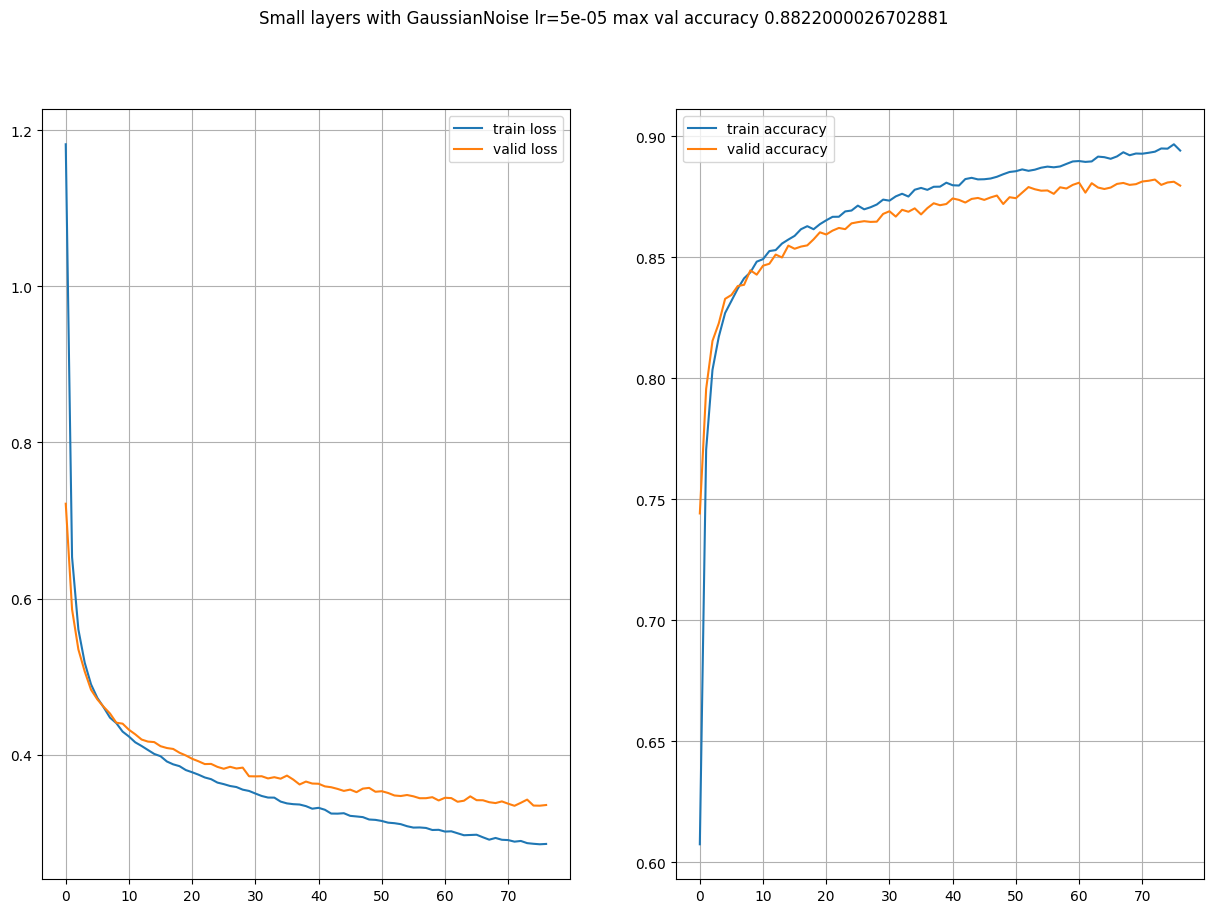

Epoch 1/100
465/469 [============================>.] - ETA: 0s - loss: 1.9737 - accuracy: 0.3400 - categorical_crossentropy: 1.9737INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 7s 13ms/step - loss: 1.9706 - accuracy: 0.3414 - categorical_crossentropy: 1.9706 - val_loss: 1.5494 - val_accuracy: 0.6120 - val_categorical_crossentropy: 1.5494
Epoch 2/100
464/469 [============================>.] - ETA: 0s - loss: 1.3209 - accuracy: 0.6005 - categorical_crossentropy: 1.3209INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 5s 10ms/step - loss: 1.3186 - accuracy: 0.6009 - categorical_crossentropy: 1.3186 - val_loss: 1.0555 - val_accuracy: 0.6623 - val_categorical_crossentropy: 1.0555
Epoch 3/100
468/469 [============================>.] - ETA: 0s - loss: 0.9730 - accuracy: 0.6715 - categorical_crossentropy: 0.9730INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 5s 11ms/step - loss: 0.9727 - accuracy: 0.6717 - categorical_crossentropy: 0.9727 - val_loss: 0.8565 - val_accuracy: 0.6998 - val_categorical_crossentropy: 0.8565
Epoch 4/100
468/469 [============================>.] - ETA: 0s - loss: 0.8268 - accuracy: 0.7103 - categorical_crossentropy: 0.8268INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.8266 - accuracy: 0.7103 - categorical_crossentropy: 0.8266 - val_loss: 0.7632 - val_accuracy: 0.7289 - val_categorical_crossentropy: 0.7632
Epoch 5/100
460/469 [============================>.] - ETA: 0s - loss: 0.7475 - accuracy: 0.7354 - categorical_crossentropy: 0.7475INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.7474 - accuracy: 0.7354 - categorical_crossentropy: 0.7474 - val_loss: 0.7080 - val_accuracy: 0.7466 - val_categorical_crossentropy: 0.7080
Epoch 6/100
467/469 [============================>.] - ETA: 0s - loss: 0.6983 - accuracy: 0.7537 - categorical_crossentropy: 0.6983INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 5s 11ms/step - loss: 0.6982 - accuracy: 0.7537 - categorical_crossentropy: 0.6982 - val_loss: 0.6663 - val_accuracy: 0.7621 - val_categorical_crossentropy: 0.6663
Epoch 7/100
464/469 [============================>.] - ETA: 0s - loss: 0.6606 - accuracy: 0.7670 - categorical_crossentropy: 0.6606INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 7s 14ms/step - loss: 0.6608 - accuracy: 0.7668 - categorical_crossentropy: 0.6608 - val_loss: 0.6361 - val_accuracy: 0.7774 - val_categorical_crossentropy: 0.6361
Epoch 8/100
465/469 [============================>.] - ETA: 0s - loss: 0.6319 - accuracy: 0.7788 - categorical_crossentropy: 0.6319INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 5s 11ms/step - loss: 0.6319 - accuracy: 0.7790 - categorical_crossentropy: 0.6319 - val_loss: 0.6110 - val_accuracy: 0.7862 - val_categorical_crossentropy: 0.6110
Epoch 9/100
465/469 [============================>.] - ETA: 0s - loss: 0.6094 - accuracy: 0.7880 - categorical_crossentropy: 0.6094INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.6090 - accuracy: 0.7880 - categorical_crossentropy: 0.6090 - val_loss: 0.5918 - val_accuracy: 0.7937 - val_categorical_crossentropy: 0.5918
Epoch 10/100
464/469 [============================>.] - ETA: 0s - loss: 0.5875 - accuracy: 0.7954 - categorical_crossentropy: 0.5875INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 5s 11ms/step - loss: 0.5875 - accuracy: 0.7953 - categorical_crossentropy: 0.5875 - val_loss: 0.5745 - val_accuracy: 0.8000 - val_categorical_crossentropy: 0.5745
Epoch 11/100
468/469 [============================>.] - ETA: 0s - loss: 0.5725 - accuracy: 0.7994 - categorical_crossentropy: 0.5725INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.5724 - accuracy: 0.7994 - categorical_crossentropy: 0.5724 - val_loss: 0.5614 - val_accuracy: 0.8047 - val_categorical_crossentropy: 0.5614
Epoch 12/100
462/469 [============================>.] - ETA: 0s - loss: 0.5604 - accuracy: 0.8038 - categorical_crossentropy: 0.5604INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.5603 - accuracy: 0.8038 - categorical_crossentropy: 0.5603 - val_loss: 0.5504 - val_accuracy: 0.8080 - val_categorical_crossentropy: 0.5504
Epoch 13/100
466/469 [============================>.] - ETA: 0s - loss: 0.5461 - accuracy: 0.8092 - categorical_crossentropy: 0.5461INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 5s 11ms/step - loss: 0.5457 - accuracy: 0.8094 - categorical_crossentropy: 0.5457 - val_loss: 0.5400 - val_accuracy: 0.8125 - val_categorical_crossentropy: 0.5400
Epoch 14/100
466/469 [============================>.] - ETA: 0s - loss: 0.5345 - accuracy: 0.8131 - categorical_crossentropy: 0.5345INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 5s 11ms/step - loss: 0.5345 - accuracy: 0.8131 - categorical_crossentropy: 0.5345 - val_loss: 0.5311 - val_accuracy: 0.8152 - val_categorical_crossentropy: 0.5311
Epoch 15/100
466/469 [============================>.] - ETA: 0s - loss: 0.5261 - accuracy: 0.8160 - categorical_crossentropy: 0.5261INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 5s 12ms/step - loss: 0.5261 - accuracy: 0.8161 - categorical_crossentropy: 0.5261 - val_loss: 0.5219 - val_accuracy: 0.8195 - val_categorical_crossentropy: 0.5219
Epoch 16/100
463/469 [============================>.] - ETA: 0s - loss: 0.5200 - accuracy: 0.8174 - categorical_crossentropy: 0.5200INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 5s 11ms/step - loss: 0.5195 - accuracy: 0.8174 - categorical_crossentropy: 0.5195 - val_loss: 0.5152 - val_accuracy: 0.8223 - val_categorical_crossentropy: 0.5152
Epoch 17/100
468/469 [============================>.] - ETA: 0s - loss: 0.5115 - accuracy: 0.8205 - categorical_crossentropy: 0.5115INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 5s 11ms/step - loss: 0.5114 - accuracy: 0.8206 - categorical_crossentropy: 0.5114 - val_loss: 0.5101 - val_accuracy: 0.8241 - val_categorical_crossentropy: 0.5101
Epoch 18/100
465/469 [============================>.] - ETA: 0s - loss: 0.5037 - accuracy: 0.8223 - categorical_crossentropy: 0.5037INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.5039 - accuracy: 0.8221 - categorical_crossentropy: 0.5039 - val_loss: 0.5041 - val_accuracy: 0.8262 - val_categorical_crossentropy: 0.5041
Epoch 19/100
469/469 [==============================] - 4s 8ms/step - loss: 0.4990 - accuracy: 0.8235 - categorical_crossentropy: 0.4990 - val_loss: 0.4998 - val_accuracy: 0.8252 - val_categorical_crossentropy: 0.4998
Epoch 20/100
462/469 [============================>.] - ETA: 0s - loss: 0.4932 - accuracy: 0.8260 - categorical_crossentropy: 0.4932INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.4930 - accuracy: 0.8261 - categorical_crossentropy: 0.4930 - val_loss: 0.4935 - val_accuracy: 0.8301 - val_categorical_crossentropy: 0.4935
Epoch 21/100
469/469 [==============================] - 4s 7ms/step - loss: 0.4878 - accuracy: 0.8276 - categorical_crossentropy: 0.4878 - val_loss: 0.4902 - val_accuracy: 0.8292 - val_categorical_crossentropy: 0.4902
Epoch 22/100
466/469 [============================>.] - ETA: 0s - loss: 0.4837 - accuracy: 0.8292 - categorical_crossentropy: 0.4837INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4833 - accuracy: 0.8293 - categorical_crossentropy: 0.4833 - val_loss: 0.4861 - val_accuracy: 0.8313 - val_categorical_crossentropy: 0.4861
Epoch 23/100
469/469 [==============================] - ETA: 0s - loss: 0.4797 - accuracy: 0.8296 - categorical_crossentropy: 0.4797INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 5s 11ms/step - loss: 0.4797 - accuracy: 0.8296 - categorical_crossentropy: 0.4797 - val_loss: 0.4823 - val_accuracy: 0.8317 - val_categorical_crossentropy: 0.4823
Epoch 24/100
467/469 [============================>.] - ETA: 0s - loss: 0.4759 - accuracy: 0.8327 - categorical_crossentropy: 0.4759INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.4760 - accuracy: 0.8327 - categorical_crossentropy: 0.4760 - val_loss: 0.4790 - val_accuracy: 0.8355 - val_categorical_crossentropy: 0.4790
Epoch 25/100
465/469 [============================>.] - ETA: 0s - loss: 0.4709 - accuracy: 0.8343 - categorical_crossentropy: 0.4709INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.4706 - accuracy: 0.8344 - categorical_crossentropy: 0.4706 - val_loss: 0.4751 - val_accuracy: 0.8361 - val_categorical_crossentropy: 0.4751
Epoch 26/100
469/469 [==============================] - 4s 7ms/step - loss: 0.4679 - accuracy: 0.8341 - categorical_crossentropy: 0.4679 - val_loss: 0.4729 - val_accuracy: 0.8361 - val_categorical_crossentropy: 0.4729
Epoch 27/100
469/469 [==============================] - 5s 10ms/step - loss: 0.4660 - accuracy: 0.8360 - categorical_crossentropy: 0.4660 - val_loss: 0.4716 - val_accuracy: 0.8351 - val_categorical_crossentropy: 0.4716
Epoch 28/100
468/469 [============================>.] - ETA: 0s - loss: 0.4629 - accuracy: 0.8345 - categorical_crossentropy: 0.4629INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4628 - accuracy: 0.8345 - categorical_crossentropy: 0.4628 - val_loss: 0.4676 - val_accuracy: 0.8385 - val_categorical_crossentropy: 0.4676
Epoch 29/100
460/469 [============================>.] - ETA: 0s - loss: 0.4603 - accuracy: 0.8364 - categorical_crossentropy: 0.4603INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.4603 - accuracy: 0.8365 - categorical_crossentropy: 0.4603 - val_loss: 0.4646 - val_accuracy: 0.8391 - val_categorical_crossentropy: 0.4646
Epoch 30/100
469/469 [==============================] - 3s 7ms/step - loss: 0.4565 - accuracy: 0.8382 - categorical_crossentropy: 0.4565 - val_loss: 0.4624 - val_accuracy: 0.8386 - val_categorical_crossentropy: 0.4624
Epoch 31/100
469/469 [==============================] - 3s 6ms/step - loss: 0.4531 - accuracy: 0.8391 - categorical_crossentropy: 0.4531 - val_loss: 0.4614 - val_accuracy: 0.8384 - val_categorical_crossentropy: 0.4614
Epoch 32/100
469/469 [==============================] - 3s 6ms/step - loss: 0.4507 - accuracy: 0.8404 - categorical_crossentropy: 0.4507 - val_loss: 0.4600 - val_accuracy: 0.8382 - val_categorical_crossentropy: 0.4600
Epoch 33/100
467/469 [============================>.] - ETA: 0s - loss: 0.4498 - accuracy: 0.8415 - categorical_crossentropy: 0.4498INFO:ten

INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4497 - accuracy: 0.8416 - categorical_crossentropy: 0.4497 - val_loss: 0.4566 - val_accuracy: 0.8397 - val_categorical_crossentropy: 0.4566
Epoch 34/100
469/469 [==============================] - ETA: 0s - loss: 0.4467 - accuracy: 0.8412 - categorical_crossentropy: 0.4467INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.4467 - accuracy: 0.8412 - categorical_crossentropy: 0.4467 - val_loss: 0.4547 - val_accuracy: 0.8403 - val_categorical_crossentropy: 0.4547
Epoch 35/100
468/469 [============================>.] - ETA: 0s - loss: 0.4437 - accuracy: 0.8430 - categorical_crossentropy: 0.4437INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.4436 - accuracy: 0.8431 - categorical_crossentropy: 0.4436 - val_loss: 0.4520 - val_accuracy: 0.8425 - val_categorical_crossentropy: 0.4520
Epoch 36/100
469/469 [==============================] - 4s 8ms/step - loss: 0.4429 - accuracy: 0.8437 - categorical_crossentropy: 0.4429 - val_loss: 0.4502 - val_accuracy: 0.8408 - val_categorical_crossentropy: 0.4502
Epoch 37/100
469/469 [==============================] - 3s 6ms/step - loss: 0.4409 - accuracy: 0.8437 - categorical_crossentropy: 0.4409 - val_loss: 0.4483 - val_accuracy: 0.8415 - val_categorical_crossentropy: 0.4483
Epoch 38/100
469/469 [==============================] - 3s 7ms/step - loss: 0.4393 - accuracy: 0.8439 - categorical_crossentropy: 0.4393 - val_loss: 0.4476 - val_accuracy: 0.8420 - val_categorical_crossentropy: 0.4476
Epoch 39/100
466/469 [============================>.] - ETA: 0s - loss: 0.4367 - accuracy: 0.8448 - categorical_crossentropy: 0.4367INFO:ten

INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.4368 - accuracy: 0.8450 - categorical_crossentropy: 0.4368 - val_loss: 0.4450 - val_accuracy: 0.8444 - val_categorical_crossentropy: 0.4450
Epoch 40/100
469/469 [==============================] - 3s 7ms/step - loss: 0.4345 - accuracy: 0.8451 - categorical_crossentropy: 0.4345 - val_loss: 0.4432 - val_accuracy: 0.8439 - val_categorical_crossentropy: 0.4432
Epoch 41/100
459/469 [============================>.] - ETA: 0s - loss: 0.4340 - accuracy: 0.8468 - categorical_crossentropy: 0.4340INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.4335 - accuracy: 0.8467 - categorical_crossentropy: 0.4335 - val_loss: 0.4418 - val_accuracy: 0.8451 - val_categorical_crossentropy: 0.4418
Epoch 42/100
469/469 [==============================] - 4s 7ms/step - loss: 0.4316 - accuracy: 0.8460 - categorical_crossentropy: 0.4316 - val_loss: 0.4414 - val_accuracy: 0.8444 - val_categorical_crossentropy: 0.4414
Epoch 43/100
469/469 [==============================] - 3s 6ms/step - loss: 0.4303 - accuracy: 0.8484 - categorical_crossentropy: 0.4303 - val_loss: 0.4390 - val_accuracy: 0.8441 - val_categorical_crossentropy: 0.4390
Epoch 44/100
469/469 [==============================] - 3s 6ms/step - loss: 0.4271 - accuracy: 0.8478 - categorical_crossentropy: 0.4271 - val_loss: 0.4383 - val_accuracy: 0.8451 - val_categorical_crossentropy: 0.4383
Epoch 45/100
467/469 [============================>.] - ETA: 0s - loss: 0.4260 - accuracy: 0.8492 - categorical_crossentropy: 0.4260INFO:tens

INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.4257 - accuracy: 0.8493 - categorical_crossentropy: 0.4257 - val_loss: 0.4369 - val_accuracy: 0.8455 - val_categorical_crossentropy: 0.4369
Epoch 46/100
459/469 [============================>.] - ETA: 0s - loss: 0.4253 - accuracy: 0.8489 - categorical_crossentropy: 0.4253INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4247 - accuracy: 0.8491 - categorical_crossentropy: 0.4247 - val_loss: 0.4360 - val_accuracy: 0.8466 - val_categorical_crossentropy: 0.4360
Epoch 47/100
469/469 [==============================] - 3s 7ms/step - loss: 0.4229 - accuracy: 0.8494 - categorical_crossentropy: 0.4229 - val_loss: 0.4343 - val_accuracy: 0.8464 - val_categorical_crossentropy: 0.4343
Epoch 48/100
469/469 [==============================] - 3s 6ms/step - loss: 0.4233 - accuracy: 0.8491 - categorical_crossentropy: 0.4233 - val_loss: 0.4325 - val_accuracy: 0.8461 - val_categorical_crossentropy: 0.4325
Epoch 49/100
468/469 [============================>.] - ETA: 0s - loss: 0.4213 - accuracy: 0.8500 - categorical_crossentropy: 0.4213INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4211 - accuracy: 0.8500 - categorical_crossentropy: 0.4211 - val_loss: 0.4311 - val_accuracy: 0.8478 - val_categorical_crossentropy: 0.4311
Epoch 50/100
467/469 [============================>.] - ETA: 0s - loss: 0.4205 - accuracy: 0.8510 - categorical_crossentropy: 0.4205INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.4204 - accuracy: 0.8511 - categorical_crossentropy: 0.4204 - val_loss: 0.4301 - val_accuracy: 0.8482 - val_categorical_crossentropy: 0.4301
Epoch 51/100
469/469 [==============================] - 4s 8ms/step - loss: 0.4163 - accuracy: 0.8529 - categorical_crossentropy: 0.4163 - val_loss: 0.4289 - val_accuracy: 0.8475 - val_categorical_crossentropy: 0.4289
Epoch 52/100
466/469 [============================>.] - ETA: 0s - loss: 0.4189 - accuracy: 0.8510 - categorical_crossentropy: 0.4189INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.4187 - accuracy: 0.8510 - categorical_crossentropy: 0.4187 - val_loss: 0.4277 - val_accuracy: 0.8483 - val_categorical_crossentropy: 0.4277
Epoch 53/100
466/469 [============================>.] - ETA: 0s - loss: 0.4141 - accuracy: 0.8533 - categorical_crossentropy: 0.4141INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.4144 - accuracy: 0.8532 - categorical_crossentropy: 0.4144 - val_loss: 0.4264 - val_accuracy: 0.8490 - val_categorical_crossentropy: 0.4264
Epoch 54/100
462/469 [============================>.] - ETA: 0s - loss: 0.4140 - accuracy: 0.8529 - categorical_crossentropy: 0.4140INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4146 - accuracy: 0.8529 - categorical_crossentropy: 0.4146 - val_loss: 0.4264 - val_accuracy: 0.8494 - val_categorical_crossentropy: 0.4264
Epoch 55/100
463/469 [============================>.] - ETA: 0s - loss: 0.4124 - accuracy: 0.8549 - categorical_crossentropy: 0.4124INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.4125 - accuracy: 0.8548 - categorical_crossentropy: 0.4125 - val_loss: 0.4248 - val_accuracy: 0.8497 - val_categorical_crossentropy: 0.4248
Epoch 56/100
469/469 [==============================] - 3s 7ms/step - loss: 0.4131 - accuracy: 0.8536 - categorical_crossentropy: 0.4131 - val_loss: 0.4244 - val_accuracy: 0.8497 - val_categorical_crossentropy: 0.4244
Epoch 57/100
466/469 [============================>.] - ETA: 0s - loss: 0.4091 - accuracy: 0.8544 - categorical_crossentropy: 0.4091INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.4095 - accuracy: 0.8543 - categorical_crossentropy: 0.4095 - val_loss: 0.4225 - val_accuracy: 0.8502 - val_categorical_crossentropy: 0.4225
Epoch 58/100
465/469 [============================>.] - ETA: 0s - loss: 0.4100 - accuracy: 0.8555 - categorical_crossentropy: 0.4100INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4107 - accuracy: 0.8552 - categorical_crossentropy: 0.4107 - val_loss: 0.4219 - val_accuracy: 0.8508 - val_categorical_crossentropy: 0.4219
Epoch 59/100
469/469 [==============================] - 3s 7ms/step - loss: 0.4078 - accuracy: 0.8554 - categorical_crossentropy: 0.4078 - val_loss: 0.4209 - val_accuracy: 0.8507 - val_categorical_crossentropy: 0.4209
Epoch 60/100
469/469 [==============================] - 3s 6ms/step - loss: 0.4074 - accuracy: 0.8543 - categorical_crossentropy: 0.4074 - val_loss: 0.4221 - val_accuracy: 0.8499 - val_categorical_crossentropy: 0.4221
Epoch 61/100
463/469 [============================>.] - ETA: 0s - loss: 0.4058 - accuracy: 0.8558 - categorical_crossentropy: 0.4058INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.4059 - accuracy: 0.8558 - categorical_crossentropy: 0.4059 - val_loss: 0.4190 - val_accuracy: 0.8520 - val_categorical_crossentropy: 0.4190
Epoch 62/100
469/469 [==============================] - 3s 7ms/step - loss: 0.4062 - accuracy: 0.8558 - categorical_crossentropy: 0.4062 - val_loss: 0.4178 - val_accuracy: 0.8516 - val_categorical_crossentropy: 0.4178
Epoch 63/100
462/469 [============================>.] - ETA: 0s - loss: 0.4023 - accuracy: 0.8570 - categorical_crossentropy: 0.4023INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.4025 - accuracy: 0.8568 - categorical_crossentropy: 0.4025 - val_loss: 0.4170 - val_accuracy: 0.8525 - val_categorical_crossentropy: 0.4170
Epoch 64/100
465/469 [============================>.] - ETA: 0s - loss: 0.4033 - accuracy: 0.8562 - categorical_crossentropy: 0.4033INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.4029 - accuracy: 0.8564 - categorical_crossentropy: 0.4029 - val_loss: 0.4167 - val_accuracy: 0.8528 - val_categorical_crossentropy: 0.4167
Epoch 65/100
464/469 [============================>.] - ETA: 0s - loss: 0.4022 - accuracy: 0.8573 - categorical_crossentropy: 0.4022INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4026 - accuracy: 0.8572 - categorical_crossentropy: 0.4026 - val_loss: 0.4156 - val_accuracy: 0.8536 - val_categorical_crossentropy: 0.4156
Epoch 66/100
469/469 [==============================] - 3s 7ms/step - loss: 0.4008 - accuracy: 0.8570 - categorical_crossentropy: 0.4008 - val_loss: 0.4152 - val_accuracy: 0.8527 - val_categorical_crossentropy: 0.4152
Epoch 67/100
469/469 [==============================] - 3s 6ms/step - loss: 0.4000 - accuracy: 0.8570 - categorical_crossentropy: 0.4000 - val_loss: 0.4143 - val_accuracy: 0.8522 - val_categorical_crossentropy: 0.4143
Epoch 68/100
469/469 [==============================] - 3s 6ms/step - loss: 0.4007 - accuracy: 0.8575 - categorical_crossentropy: 0.4007 - val_loss: 0.4140 - val_accuracy: 0.8517 - val_categorical_crossentropy: 0.4140
Epoch 69/100
458/469 [============================>.] - ETA: 0s - loss: 0.3997 - accuracy: 0.8589 - categorical_crossentropy: 0.3997INFO:tens

INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.3988 - accuracy: 0.8593 - categorical_crossentropy: 0.3988 - val_loss: 0.4124 - val_accuracy: 0.8538 - val_categorical_crossentropy: 0.4124
Epoch 70/100
464/469 [============================>.] - ETA: 0s - loss: 0.3967 - accuracy: 0.8590 - categorical_crossentropy: 0.3967INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3965 - accuracy: 0.8590 - categorical_crossentropy: 0.3965 - val_loss: 0.4121 - val_accuracy: 0.8545 - val_categorical_crossentropy: 0.4121
Epoch 71/100
464/469 [============================>.] - ETA: 0s - loss: 0.3975 - accuracy: 0.8581 - categorical_crossentropy: 0.3975INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3977 - accuracy: 0.8581 - categorical_crossentropy: 0.3977 - val_loss: 0.4113 - val_accuracy: 0.8546 - val_categorical_crossentropy: 0.4113
Epoch 72/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3953 - accuracy: 0.8594 - categorical_crossentropy: 0.3953 - val_loss: 0.4111 - val_accuracy: 0.8526 - val_categorical_crossentropy: 0.4111
Epoch 73/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3949 - accuracy: 0.8601 - categorical_crossentropy: 0.3949 - val_loss: 0.4101 - val_accuracy: 0.8538 - val_categorical_crossentropy: 0.4101
Epoch 74/100
459/469 [============================>.] - ETA: 0s - loss: 0.3934 - accuracy: 0.8599 - categorical_crossentropy: 0.3934INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.3935 - accuracy: 0.8597 - categorical_crossentropy: 0.3935 - val_loss: 0.4092 - val_accuracy: 0.8555 - val_categorical_crossentropy: 0.4092
Epoch 75/100
464/469 [============================>.] - ETA: 0s - loss: 0.3930 - accuracy: 0.8604 - categorical_crossentropy: 0.3930INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3932 - accuracy: 0.8605 - categorical_crossentropy: 0.3932 - val_loss: 0.4084 - val_accuracy: 0.8559 - val_categorical_crossentropy: 0.4084
Epoch 76/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3927 - accuracy: 0.8607 - categorical_crossentropy: 0.3927 - val_loss: 0.4076 - val_accuracy: 0.8550 - val_categorical_crossentropy: 0.4076
Epoch 77/100
465/469 [============================>.] - ETA: 0s - loss: 0.3921 - accuracy: 0.8605 - categorical_crossentropy: 0.3921INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.3925 - accuracy: 0.8604 - categorical_crossentropy: 0.3925 - val_loss: 0.4065 - val_accuracy: 0.8568 - val_categorical_crossentropy: 0.4065
Epoch 78/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3904 - accuracy: 0.8614 - categorical_crossentropy: 0.3904 - val_loss: 0.4076 - val_accuracy: 0.8565 - val_categorical_crossentropy: 0.4076
Epoch 79/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3884 - accuracy: 0.8615 - categorical_crossentropy: 0.3884 - val_loss: 0.4064 - val_accuracy: 0.8560 - val_categorical_crossentropy: 0.4064
Epoch 80/100
467/469 [============================>.] - ETA: 0s - loss: 0.3895 - accuracy: 0.8620 - categorical_crossentropy: 0.3895INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.3895 - accuracy: 0.8619 - categorical_crossentropy: 0.3895 - val_loss: 0.4051 - val_accuracy: 0.8570 - val_categorical_crossentropy: 0.4051
Epoch 81/100
469/469 [==============================] - ETA: 0s - loss: 0.3874 - accuracy: 0.8619 - categorical_crossentropy: 0.3874INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3874 - accuracy: 0.8619 - categorical_crossentropy: 0.3874 - val_loss: 0.4041 - val_accuracy: 0.8581 - val_categorical_crossentropy: 0.4041
Epoch 82/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3867 - accuracy: 0.8623 - categorical_crossentropy: 0.3867 - val_loss: 0.4053 - val_accuracy: 0.8563 - val_categorical_crossentropy: 0.4053
Epoch 83/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3863 - accuracy: 0.8636 - categorical_crossentropy: 0.3863 - val_loss: 0.4032 - val_accuracy: 0.8571 - val_categorical_crossentropy: 0.4032
Epoch 84/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3863 - accuracy: 0.8613 - categorical_crossentropy: 0.3863 - val_loss: 0.4037 - val_accuracy: 0.8563 - val_categorical_crossentropy: 0.4037
Epoch 85/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3868 - accuracy: 0.8622 - categorical_crossentropy: 0.3868 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.3859 - accuracy: 0.8620 - categorical_crossentropy: 0.3859 - val_loss: 0.4014 - val_accuracy: 0.8584 - val_categorical_crossentropy: 0.4014
Epoch 87/100
469/469 [==============================] - ETA: 0s - loss: 0.3836 - accuracy: 0.8636 - categorical_crossentropy: 0.3836INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3836 - accuracy: 0.8636 - categorical_crossentropy: 0.3836 - val_loss: 0.4012 - val_accuracy: 0.8590 - val_categorical_crossentropy: 0.4012
Epoch 88/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3828 - accuracy: 0.8645 - categorical_crossentropy: 0.3828 - val_loss: 0.4002 - val_accuracy: 0.8590 - val_categorical_crossentropy: 0.4002
Epoch 89/100
464/469 [============================>.] - ETA: 0s - loss: 0.3824 - accuracy: 0.8638 - categorical_crossentropy: 0.3824INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.3827 - accuracy: 0.8637 - categorical_crossentropy: 0.3827 - val_loss: 0.3996 - val_accuracy: 0.8599 - val_categorical_crossentropy: 0.3996
Epoch 90/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3820 - accuracy: 0.8640 - categorical_crossentropy: 0.3820 - val_loss: 0.3995 - val_accuracy: 0.8586 - val_categorical_crossentropy: 0.3995
Epoch 91/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3804 - accuracy: 0.8633 - categorical_crossentropy: 0.3804 - val_loss: 0.3990 - val_accuracy: 0.8594 - val_categorical_crossentropy: 0.3990
Epoch 92/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3820 - accuracy: 0.8644 - categorical_crossentropy: 0.3820 - val_loss: 0.3989 - val_accuracy: 0.8589 - val_categorical_crossentropy: 0.3989
Epoch 93/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3787 - accuracy: 0.8653 - categorical_crossentropy: 0.3787 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3803 - accuracy: 0.8657 - categorical_crossentropy: 0.3803 - val_loss: 0.3963 - val_accuracy: 0.8601 - val_categorical_crossentropy: 0.3963
Epoch 96/100
461/469 [============================>.] - ETA: 0s - loss: 0.3777 - accuracy: 0.8648 - categorical_crossentropy: 0.3777INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_13\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3777 - accuracy: 0.8648 - categorical_crossentropy: 0.3777 - val_loss: 0.3960 - val_accuracy: 0.8612 - val_categorical_crossentropy: 0.3960
Epoch 97/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3780 - accuracy: 0.8650 - categorical_crossentropy: 0.3780 - val_loss: 0.3958 - val_accuracy: 0.8608 - val_categorical_crossentropy: 0.3958
Epoch 98/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3764 - accuracy: 0.8661 - categorical_crossentropy: 0.3764 - val_loss: 0.3959 - val_accuracy: 0.8608 - val_categorical_crossentropy: 0.3959
Epoch 99/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3766 - accuracy: 0.8661 - categorical_crossentropy: 0.3766 - val_loss: 0.3960 - val_accuracy: 0.8596 - val_categorical_crossentropy: 0.3960
Epoch 100/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3753 - accuracy: 0.8666 - categorical_crossentropy: 0.3753 - v

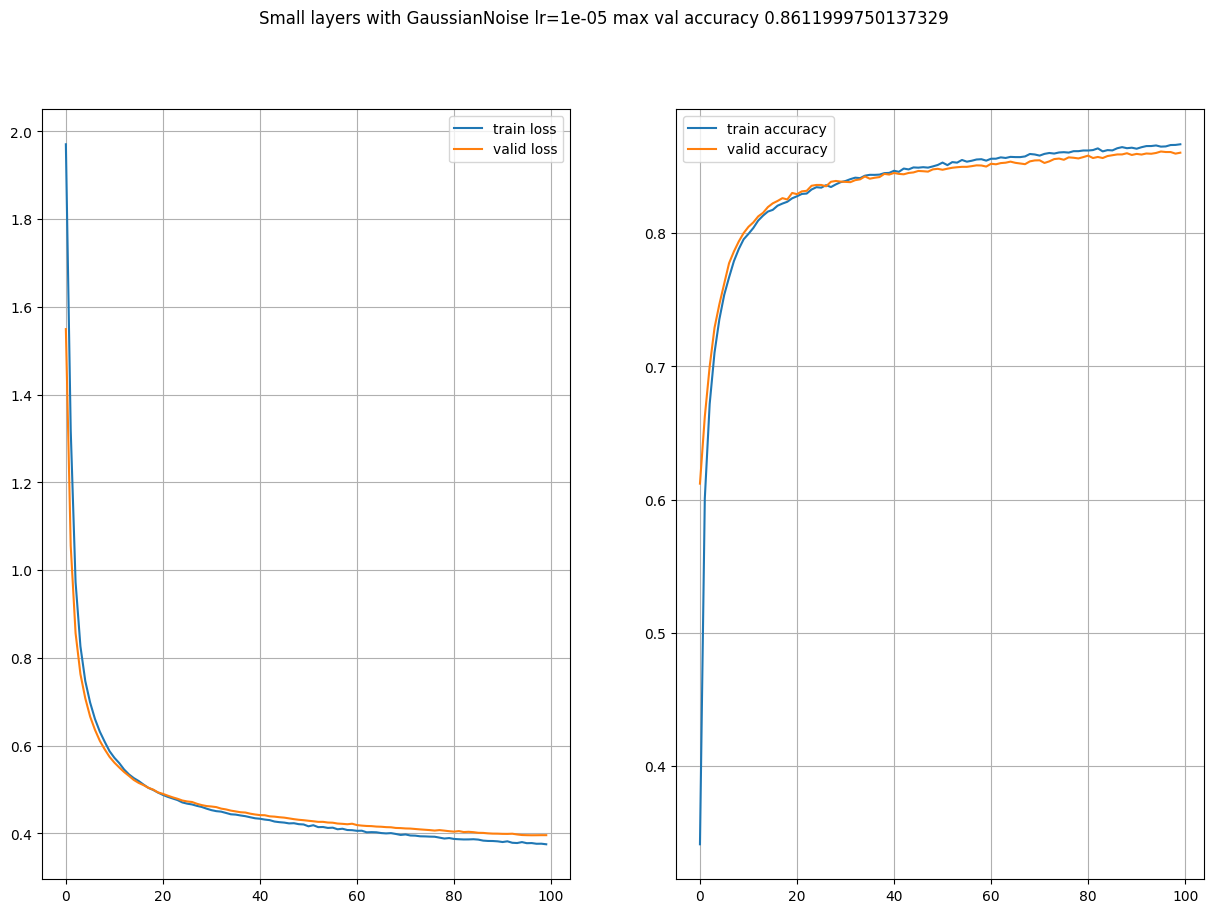

In [35]:

lrs = [.0005, .0001, .00005, .00001]
idx = 10

for lr in lrs:
    small_layers_GN = [
        Dense(128, activation="relu", input_shape=(28*28,)),
        GaussianNoise(0.2),
        Dense(512, activation="relu"),
        GaussianNoise(.2),
        Dense(10, activation="softmax"),
    ]

    small_model_GN = create_model_2(small_layers_GN, RMSprop(learning_rate=lr))
    history = fit_and_present_2(small_model_GN, def_ds, val_dataset, description=f"Small layers with GaussianNoise lr={lr}", filepath=f"small_la_gn_cp_{idx}")

    idx+=1

Подальше зниження lr лише збільшило час навчання моделі, однак на якість моделі вплинуло негативно.

Ще одне неприємне для мене спостереження: за рахунок випадкової початкової ініціалізації параметрів моделі без фіксації сідів неможливо отримати той самий результат двічи запустивши код

Ще раз проженемо модель з lr=.0005, збільшивши терпимість

Epoch 1/100


461/469 [============================>.] - ETA: 0s - loss: 0.6253 - accuracy: 0.7756 - categorical_crossentropy: 0.6253INFO:tensorflow:Assets written to: small_la_gn_cp_20\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_20\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.6226 - accuracy: 0.7765 - categorical_crossentropy: 0.6226 - val_loss: 0.4610 - val_accuracy: 0.8355 - val_categorical_crossentropy: 0.4610
Epoch 2/100
459/469 [============================>.] - ETA: 0s - loss: 0.4431 - accuracy: 0.8379 - categorical_crossentropy: 0.4431INFO:tensorflow:Assets written to: small_la_gn_cp_20\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_20\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.4432 - accuracy: 0.8380 - categorical_crossentropy: 0.4432 - val_loss: 0.4025 - val_accuracy: 0.8522 - val_categorical_crossentropy: 0.4025
Epoch 3/100
463/469 [============================>.] - ETA: 0s - loss: 0.3949 - accuracy: 0.8565 - categorical_crossentropy: 0.3949INFO:tensorflow:Assets written to: small_la_gn_cp_20\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_20\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3950 - accuracy: 0.8564 - categorical_crossentropy: 0.3950 - val_loss: 0.4063 - val_accuracy: 0.8531 - val_categorical_crossentropy: 0.4063
Epoch 4/100
462/469 [============================>.] - ETA: 0s - loss: 0.3661 - accuracy: 0.8660 - categorical_crossentropy: 0.3661INFO:tensorflow:Assets written to: small_la_gn_cp_20\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_20\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3657 - accuracy: 0.8661 - categorical_crossentropy: 0.3657 - val_loss: 0.3760 - val_accuracy: 0.8632 - val_categorical_crossentropy: 0.3760
Epoch 5/100
469/469 [==============================] - ETA: 0s - loss: 0.3456 - accuracy: 0.8730 - categorical_crossentropy: 0.3456INFO:tensorflow:Assets written to: small_la_gn_cp_20\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_20\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3456 - accuracy: 0.8730 - categorical_crossentropy: 0.3456 - val_loss: 0.3695 - val_accuracy: 0.8671 - val_categorical_crossentropy: 0.3695
Epoch 6/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3310 - accuracy: 0.8782 - categorical_crossentropy: 0.3310 - val_loss: 0.3803 - val_accuracy: 0.8641 - val_categorical_crossentropy: 0.3803
Epoch 7/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3179 - accuracy: 0.8842 - categorical_crossentropy: 0.3179 - val_loss: 0.3642 - val_accuracy: 0.8650 - val_categorical_crossentropy: 0.3642
Epoch 8/100
460/469 [============================>.] - ETA: 0s - loss: 0.3059 - accuracy: 0.8868 - categorical_crossentropy: 0.3059INFO:tensorflow:Assets written to: small_la_gn_cp_20\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_20\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.3062 - accuracy: 0.8867 - categorical_crossentropy: 0.3062 - val_loss: 0.3430 - val_accuracy: 0.8719 - val_categorical_crossentropy: 0.3430
Epoch 9/100
469/469 [==============================] - ETA: 0s - loss: 0.2964 - accuracy: 0.8906 - categorical_crossentropy: 0.2964INFO:tensorflow:Assets written to: small_la_gn_cp_20\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_20\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2964 - accuracy: 0.8906 - categorical_crossentropy: 0.2964 - val_loss: 0.3439 - val_accuracy: 0.8766 - val_categorical_crossentropy: 0.3439
Epoch 10/100
464/469 [============================>.] - ETA: 0s - loss: 0.2864 - accuracy: 0.8945 - categorical_crossentropy: 0.2864INFO:tensorflow:Assets written to: small_la_gn_cp_20\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_20\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2865 - accuracy: 0.8944 - categorical_crossentropy: 0.2865 - val_loss: 0.3337 - val_accuracy: 0.8799 - val_categorical_crossentropy: 0.3337
Epoch 11/100
464/469 [============================>.] - ETA: 0s - loss: 0.2820 - accuracy: 0.8958 - categorical_crossentropy: 0.2820INFO:tensorflow:Assets written to: small_la_gn_cp_20\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_20\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2820 - accuracy: 0.8958 - categorical_crossentropy: 0.2820 - val_loss: 0.3287 - val_accuracy: 0.8815 - val_categorical_crossentropy: 0.3287
Epoch 12/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2723 - accuracy: 0.8991 - categorical_crossentropy: 0.2723 - val_loss: 0.3359 - val_accuracy: 0.8787 - val_categorical_crossentropy: 0.3359
Epoch 13/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2654 - accuracy: 0.9004 - categorical_crossentropy: 0.2654 - val_loss: 0.3472 - val_accuracy: 0.8726 - val_categorical_crossentropy: 0.3472
Epoch 14/100
462/469 [============================>.] - ETA: 0s - loss: 0.2591 - accuracy: 0.9044 - categorical_crossentropy: 0.2591INFO:tensorflow:Assets written to: small_la_gn_cp_20\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_20\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2587 - accuracy: 0.9046 - categorical_crossentropy: 0.2587 - val_loss: 0.3198 - val_accuracy: 0.8865 - val_categorical_crossentropy: 0.3198
Epoch 15/100
466/469 [============================>.] - ETA: 0s - loss: 0.2531 - accuracy: 0.9050 - categorical_crossentropy: 0.2531INFO:tensorflow:Assets written to: small_la_gn_cp_20\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_20\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2532 - accuracy: 0.9050 - categorical_crossentropy: 0.2532 - val_loss: 0.3225 - val_accuracy: 0.8884 - val_categorical_crossentropy: 0.3225
Epoch 16/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2483 - accuracy: 0.9058 - categorical_crossentropy: 0.2483 - val_loss: 0.3500 - val_accuracy: 0.8835 - val_categorical_crossentropy: 0.3500
Epoch 17/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2427 - accuracy: 0.9081 - categorical_crossentropy: 0.2427 - val_loss: 0.3229 - val_accuracy: 0.8868 - val_categorical_crossentropy: 0.3229
Epoch 18/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2388 - accuracy: 0.9109 - categorical_crossentropy: 0.2388 - val_loss: 0.3151 - val_accuracy: 0.8881 - val_categorical_crossentropy: 0.3151
Epoch 19/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2335 - accuracy: 0.9115 - categorical_crossentropy: 0.2335 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_20\assets


469/469 [==============================] - 4s 10ms/step - loss: 0.2168 - accuracy: 0.9183 - categorical_crossentropy: 0.2168 - val_loss: 0.3179 - val_accuracy: 0.8889 - val_categorical_crossentropy: 0.3179
Epoch 24/100
465/469 [============================>.] - ETA: 0s - loss: 0.2126 - accuracy: 0.9205 - categorical_crossentropy: 0.2126INFO:tensorflow:Assets written to: small_la_gn_cp_20\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_20\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2125 - accuracy: 0.9205 - categorical_crossentropy: 0.2125 - val_loss: 0.3256 - val_accuracy: 0.8901 - val_categorical_crossentropy: 0.3256
Epoch 25/100
463/469 [============================>.] - ETA: 0s - loss: 0.2089 - accuracy: 0.9217 - categorical_crossentropy: 0.2089INFO:tensorflow:Assets written to: small_la_gn_cp_20\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_20\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2084 - accuracy: 0.9218 - categorical_crossentropy: 0.2084 - val_loss: 0.3103 - val_accuracy: 0.8923 - val_categorical_crossentropy: 0.3103
Epoch 26/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2060 - accuracy: 0.9219 - categorical_crossentropy: 0.2060 - val_loss: 0.3191 - val_accuracy: 0.8921 - val_categorical_crossentropy: 0.3191
Epoch 27/100
457/469 [============================>.] - ETA: 0s - loss: 0.2014 - accuracy: 0.9234 - categorical_crossentropy: 0.2014INFO:tensorflow:Assets written to: small_la_gn_cp_20\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_20\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2020 - accuracy: 0.9230 - categorical_crossentropy: 0.2020 - val_loss: 0.3096 - val_accuracy: 0.8949 - val_categorical_crossentropy: 0.3096
Epoch 28/100
460/469 [============================>.] - ETA: 0s - loss: 0.1979 - accuracy: 0.9254 - categorical_crossentropy: 0.1979INFO:tensorflow:Assets written to: small_la_gn_cp_20\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_20\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.1977 - accuracy: 0.9255 - categorical_crossentropy: 0.1977 - val_loss: 0.3172 - val_accuracy: 0.8957 - val_categorical_crossentropy: 0.3172
Epoch 29/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1954 - accuracy: 0.9256 - categorical_crossentropy: 0.1954 - val_loss: 0.3171 - val_accuracy: 0.8941 - val_categorical_crossentropy: 0.3171
Epoch 30/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1932 - accuracy: 0.9267 - categorical_crossentropy: 0.1932 - val_loss: 0.3138 - val_accuracy: 0.8947 - val_categorical_crossentropy: 0.3138
Epoch 31/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1871 - accuracy: 0.9295 - categorical_crossentropy: 0.1871 - val_loss: 0.3593 - val_accuracy: 0.8792 - val_categorical_crossentropy: 0.3593
Epoch 32/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1849 - accuracy: 0.9298 - categorical_crossentropy: 0.1849 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_20\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.1564 - accuracy: 0.9399 - categorical_crossentropy: 0.1564 - val_loss: 0.3519 - val_accuracy: 0.8977 - val_categorical_crossentropy: 0.3519


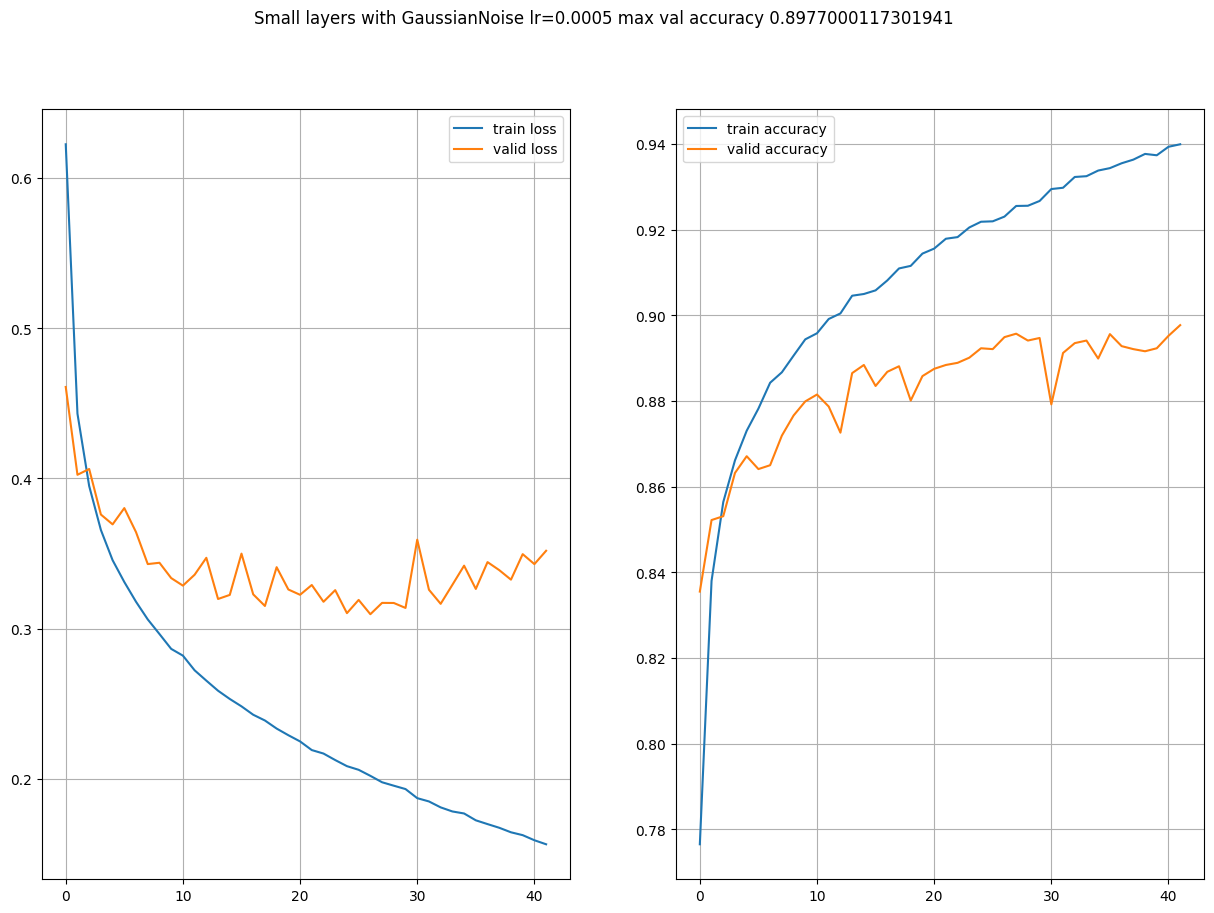

In [36]:

lrs = [.0005]
idx = 20

for lr in lrs:
    small_layers_GN = [
        Dense(128, activation="relu", input_shape=(28*28,)),
        GaussianNoise(0.2),
        Dense(512, activation="relu"),
        GaussianNoise(.2),
        Dense(10, activation="softmax"),
    ]

    small_model_GN = create_model_2(small_layers_GN, RMSprop(learning_rate=lr))
    history = fit_and_present_2(small_model_GN, def_ds, val_dataset, description=f"Small layers with GaussianNoise lr={lr}", filepath=f"small_la_gn_cp_{idx}", patience=15)

    idx+=1

Тепер спробуємо побавитись з гіперпараетрами оптимізатора

Epoch 1/100


465/469 [============================>.] - ETA: 0s - loss: 0.6463 - accuracy: 0.7701 - categorical_crossentropy: 0.6463INFO:tensorflow:Assets written to: small_la_gn_cp_30\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_30\assets


469/469 [==============================] - 5s 9ms/step - loss: 0.6444 - accuracy: 0.7707 - categorical_crossentropy: 0.6444 - val_loss: 0.5252 - val_accuracy: 0.8164 - val_categorical_crossentropy: 0.5252
Epoch 2/100
462/469 [============================>.] - ETA: 0s - loss: 0.4511 - accuracy: 0.8359 - categorical_crossentropy: 0.4511INFO:tensorflow:Assets written to: small_la_gn_cp_30\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_30\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4511 - accuracy: 0.8359 - categorical_crossentropy: 0.4511 - val_loss: 0.4316 - val_accuracy: 0.8474 - val_categorical_crossentropy: 0.4316
Epoch 3/100
465/469 [============================>.] - ETA: 0s - loss: 0.4068 - accuracy: 0.8517 - categorical_crossentropy: 0.4068INFO:tensorflow:Assets written to: small_la_gn_cp_30\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_30\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.4067 - accuracy: 0.8518 - categorical_crossentropy: 0.4067 - val_loss: 0.4060 - val_accuracy: 0.8559 - val_categorical_crossentropy: 0.4060
Epoch 4/100
465/469 [============================>.] - ETA: 0s - loss: 0.3769 - accuracy: 0.8626 - categorical_crossentropy: 0.3769INFO:tensorflow:Assets written to: small_la_gn_cp_30\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_30\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3765 - accuracy: 0.8627 - categorical_crossentropy: 0.3765 - val_loss: 0.3885 - val_accuracy: 0.8581 - val_categorical_crossentropy: 0.3885
Epoch 5/100
468/469 [============================>.] - ETA: 0s - loss: 0.3620 - accuracy: 0.8680 - categorical_crossentropy: 0.3620INFO:tensorflow:Assets written to: small_la_gn_cp_30\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_30\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3620 - accuracy: 0.8680 - categorical_crossentropy: 0.3620 - val_loss: 0.3782 - val_accuracy: 0.8649 - val_categorical_crossentropy: 0.3782
Epoch 6/100
465/469 [============================>.] - ETA: 0s - loss: 0.3426 - accuracy: 0.8752 - categorical_crossentropy: 0.3426INFO:tensorflow:Assets written to: small_la_gn_cp_30\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_30\assets


469/469 [==============================] - 7s 15ms/step - loss: 0.3426 - accuracy: 0.8751 - categorical_crossentropy: 0.3426 - val_loss: 0.3614 - val_accuracy: 0.8701 - val_categorical_crossentropy: 0.3614
Epoch 7/100
469/469 [==============================] - 4s 9ms/step - loss: 0.3317 - accuracy: 0.8769 - categorical_crossentropy: 0.3317 - val_loss: 0.4104 - val_accuracy: 0.8559 - val_categorical_crossentropy: 0.4104
Epoch 8/100
469/469 [==============================] - ETA: 0s - loss: 0.3220 - accuracy: 0.8817 - categorical_crossentropy: 0.3220INFO:tensorflow:Assets written to: small_la_gn_cp_30\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_30\assets


469/469 [==============================] - 6s 12ms/step - loss: 0.3220 - accuracy: 0.8817 - categorical_crossentropy: 0.3220 - val_loss: 0.3542 - val_accuracy: 0.8765 - val_categorical_crossentropy: 0.3542
Epoch 9/100
462/469 [============================>.] - ETA: 0s - loss: 0.3134 - accuracy: 0.8848 - categorical_crossentropy: 0.3134INFO:tensorflow:Assets written to: small_la_gn_cp_30\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_30\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3129 - accuracy: 0.8848 - categorical_crossentropy: 0.3129 - val_loss: 0.3504 - val_accuracy: 0.8785 - val_categorical_crossentropy: 0.3504
Epoch 10/100
469/469 [==============================] - 4s 8ms/step - loss: 0.3066 - accuracy: 0.8857 - categorical_crossentropy: 0.3066 - val_loss: 0.3650 - val_accuracy: 0.8694 - val_categorical_crossentropy: 0.3650
Epoch 11/100
466/469 [============================>.] - ETA: 0s - loss: 0.2991 - accuracy: 0.8905 - categorical_crossentropy: 0.2991INFO:tensorflow:Assets written to: small_la_gn_cp_30\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_30\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.2992 - accuracy: 0.8905 - categorical_crossentropy: 0.2992 - val_loss: 0.3342 - val_accuracy: 0.8801 - val_categorical_crossentropy: 0.3342
Epoch 12/100
469/469 [==============================] - 4s 8ms/step - loss: 0.2916 - accuracy: 0.8928 - categorical_crossentropy: 0.2916 - val_loss: 0.3514 - val_accuracy: 0.8789 - val_categorical_crossentropy: 0.3514
Epoch 13/100
466/469 [============================>.] - ETA: 0s - loss: 0.2882 - accuracy: 0.8941 - categorical_crossentropy: 0.2882INFO:tensorflow:Assets written to: small_la_gn_cp_30\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_30\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2880 - accuracy: 0.8942 - categorical_crossentropy: 0.2880 - val_loss: 0.3301 - val_accuracy: 0.8848 - val_categorical_crossentropy: 0.3301
Epoch 14/100
469/469 [==============================] - 4s 8ms/step - loss: 0.2824 - accuracy: 0.8958 - categorical_crossentropy: 0.2824 - val_loss: 0.3417 - val_accuracy: 0.8792 - val_categorical_crossentropy: 0.3417
Epoch 15/100
469/469 [==============================] - 4s 8ms/step - loss: 0.2782 - accuracy: 0.8975 - categorical_crossentropy: 0.2782 - val_loss: 0.3349 - val_accuracy: 0.8838 - val_categorical_crossentropy: 0.3349
Epoch 16/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2710 - accuracy: 0.9000 - categorical_crossentropy: 0.2710 - val_loss: 0.3419 - val_accuracy: 0.8813 - val_categorical_crossentropy: 0.3419
Epoch 17/100
465/469 [============================>.] - ETA: 0s - loss: 0.2686 - accuracy: 0.9008 - categorical_crossentropy: 0.2686INFO:tens

INFO:tensorflow:Assets written to: small_la_gn_cp_30\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.2683 - accuracy: 0.9011 - categorical_crossentropy: 0.2683 - val_loss: 0.3415 - val_accuracy: 0.8849 - val_categorical_crossentropy: 0.3415
Epoch 18/100
469/469 [==============================] - 4s 9ms/step - loss: 0.2667 - accuracy: 0.9019 - categorical_crossentropy: 0.2667 - val_loss: 0.3674 - val_accuracy: 0.8744 - val_categorical_crossentropy: 0.3674
Epoch 19/100
469/469 [==============================] - 4s 8ms/step - loss: 0.2608 - accuracy: 0.9034 - categorical_crossentropy: 0.2608 - val_loss: 0.3692 - val_accuracy: 0.8757 - val_categorical_crossentropy: 0.3692
Epoch 20/100
466/469 [============================>.] - ETA: 0s - loss: 0.2592 - accuracy: 0.9047 - categorical_crossentropy: 0.2592INFO:tensorflow:Assets written to: small_la_gn_cp_30\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_30\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.2591 - accuracy: 0.9048 - categorical_crossentropy: 0.2591 - val_loss: 0.3349 - val_accuracy: 0.8867 - val_categorical_crossentropy: 0.3349
Epoch 21/100
469/469 [==============================] - 4s 8ms/step - loss: 0.2582 - accuracy: 0.9056 - categorical_crossentropy: 0.2582 - val_loss: 0.3408 - val_accuracy: 0.8846 - val_categorical_crossentropy: 0.3408
Epoch 22/100
469/469 [==============================] - 4s 8ms/step - loss: 0.2537 - accuracy: 0.9067 - categorical_crossentropy: 0.2537 - val_loss: 0.3458 - val_accuracy: 0.8829 - val_categorical_crossentropy: 0.3458
Epoch 23/100
465/469 [============================>.] - ETA: 0s - loss: 0.2496 - accuracy: 0.9088 - categorical_crossentropy: 0.2496INFO:tensorflow:Assets written to: small_la_gn_cp_30\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_30\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.2497 - accuracy: 0.9087 - categorical_crossentropy: 0.2497 - val_loss: 0.3330 - val_accuracy: 0.8911 - val_categorical_crossentropy: 0.3330
Epoch 24/100
469/469 [==============================] - 4s 9ms/step - loss: 0.2483 - accuracy: 0.9080 - categorical_crossentropy: 0.2483 - val_loss: 0.3390 - val_accuracy: 0.8903 - val_categorical_crossentropy: 0.3390
Epoch 25/100
469/469 [==============================] - 4s 8ms/step - loss: 0.2439 - accuracy: 0.9106 - categorical_crossentropy: 0.2439 - val_loss: 0.3431 - val_accuracy: 0.8836 - val_categorical_crossentropy: 0.3431
Epoch 26/100
469/469 [==============================] - 4s 8ms/step - loss: 0.2443 - accuracy: 0.9105 - categorical_crossentropy: 0.2443 - val_loss: 0.3357 - val_accuracy: 0.8871 - val_categorical_crossentropy: 0.3357
Epoch 27/100
469/469 [==============================] - 4s 8ms/step - loss: 0.2398 - accuracy: 0.9117 - categorical_crossentropy: 0.2398 - v

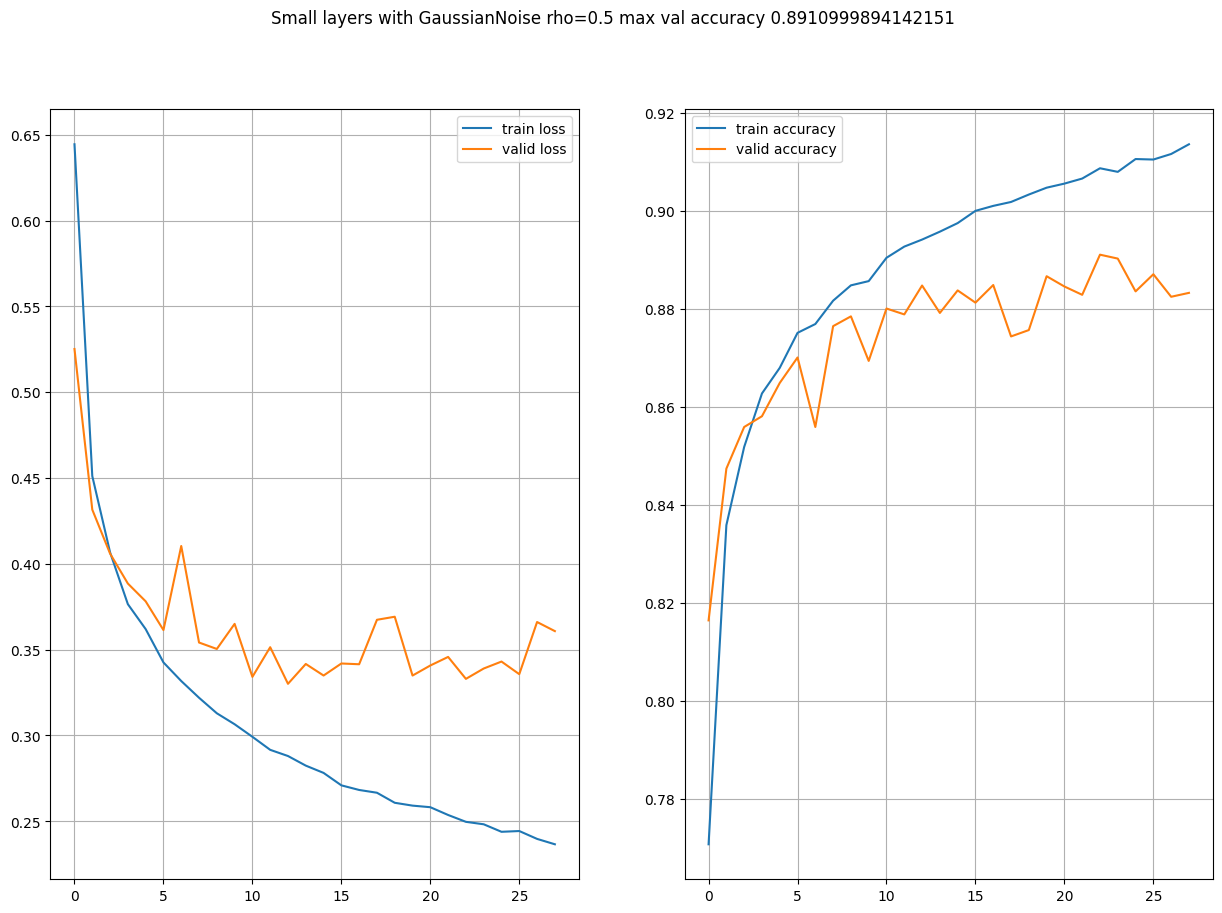

Epoch 1/100
468/469 [============================>.] - ETA: 0s - loss: 0.6354 - accuracy: 0.7729 - categorical_crossentropy: 0.6354INFO:tensorflow:Assets written to: small_la_gn_cp_31\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_31\assets


469/469 [==============================] - 6s 12ms/step - loss: 0.6355 - accuracy: 0.7729 - categorical_crossentropy: 0.6355 - val_loss: 0.5091 - val_accuracy: 0.8160 - val_categorical_crossentropy: 0.5091
Epoch 2/100
465/469 [============================>.] - ETA: 0s - loss: 0.4445 - accuracy: 0.8378 - categorical_crossentropy: 0.4445INFO:tensorflow:Assets written to: small_la_gn_cp_31\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_31\assets


469/469 [==============================] - 5s 11ms/step - loss: 0.4439 - accuracy: 0.8381 - categorical_crossentropy: 0.4439 - val_loss: 0.4094 - val_accuracy: 0.8533 - val_categorical_crossentropy: 0.4094
Epoch 3/100
467/469 [============================>.] - ETA: 0s - loss: 0.3999 - accuracy: 0.8544 - categorical_crossentropy: 0.3999INFO:tensorflow:Assets written to: small_la_gn_cp_31\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_31\assets


469/469 [==============================] - 5s 11ms/step - loss: 0.3999 - accuracy: 0.8545 - categorical_crossentropy: 0.3999 - val_loss: 0.3803 - val_accuracy: 0.8602 - val_categorical_crossentropy: 0.3803
Epoch 4/100
469/469 [==============================] - 4s 8ms/step - loss: 0.3722 - accuracy: 0.8642 - categorical_crossentropy: 0.3722 - val_loss: 0.4044 - val_accuracy: 0.8569 - val_categorical_crossentropy: 0.4044
Epoch 5/100
463/469 [============================>.] - ETA: 0s - loss: 0.3517 - accuracy: 0.8711 - categorical_crossentropy: 0.3517INFO:tensorflow:Assets written to: small_la_gn_cp_31\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_31\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3521 - accuracy: 0.8709 - categorical_crossentropy: 0.3521 - val_loss: 0.3715 - val_accuracy: 0.8630 - val_categorical_crossentropy: 0.3715
Epoch 6/100
466/469 [============================>.] - ETA: 0s - loss: 0.3366 - accuracy: 0.8759 - categorical_crossentropy: 0.3366INFO:tensorflow:Assets written to: small_la_gn_cp_31\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_31\assets


469/469 [==============================] - 5s 11ms/step - loss: 0.3366 - accuracy: 0.8760 - categorical_crossentropy: 0.3366 - val_loss: 0.3696 - val_accuracy: 0.8658 - val_categorical_crossentropy: 0.3696
Epoch 7/100
466/469 [============================>.] - ETA: 0s - loss: 0.3234 - accuracy: 0.8811 - categorical_crossentropy: 0.3234INFO:tensorflow:Assets written to: small_la_gn_cp_31\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_31\assets


469/469 [==============================] - 5s 11ms/step - loss: 0.3237 - accuracy: 0.8810 - categorical_crossentropy: 0.3237 - val_loss: 0.3558 - val_accuracy: 0.8737 - val_categorical_crossentropy: 0.3558
Epoch 8/100
465/469 [============================>.] - ETA: 0s - loss: 0.3145 - accuracy: 0.8833 - categorical_crossentropy: 0.3145INFO:tensorflow:Assets written to: small_la_gn_cp_31\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_31\assets


469/469 [==============================] - 5s 11ms/step - loss: 0.3143 - accuracy: 0.8834 - categorical_crossentropy: 0.3143 - val_loss: 0.3330 - val_accuracy: 0.8809 - val_categorical_crossentropy: 0.3330
Epoch 9/100
469/469 [==============================] - 4s 9ms/step - loss: 0.3062 - accuracy: 0.8881 - categorical_crossentropy: 0.3062 - val_loss: 0.3407 - val_accuracy: 0.8772 - val_categorical_crossentropy: 0.3407
Epoch 10/100
469/469 [==============================] - 4s 8ms/step - loss: 0.2971 - accuracy: 0.8906 - categorical_crossentropy: 0.2971 - val_loss: 0.3362 - val_accuracy: 0.8796 - val_categorical_crossentropy: 0.3362
Epoch 11/100
466/469 [============================>.] - ETA: 0s - loss: 0.2885 - accuracy: 0.8936 - categorical_crossentropy: 0.2885INFO:tensorflow:Assets written to: small_la_gn_cp_31\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_31\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.2883 - accuracy: 0.8937 - categorical_crossentropy: 0.2883 - val_loss: 0.3227 - val_accuracy: 0.8850 - val_categorical_crossentropy: 0.3227
Epoch 12/100
469/469 [==============================] - 4s 8ms/step - loss: 0.2836 - accuracy: 0.8941 - categorical_crossentropy: 0.2836 - val_loss: 0.3377 - val_accuracy: 0.8815 - val_categorical_crossentropy: 0.3377
Epoch 13/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2770 - accuracy: 0.8972 - categorical_crossentropy: 0.2770 - val_loss: 0.3352 - val_accuracy: 0.8813 - val_categorical_crossentropy: 0.3352
Epoch 14/100
469/469 [==============================] - 4s 8ms/step - loss: 0.2726 - accuracy: 0.8990 - categorical_crossentropy: 0.2726 - val_loss: 0.3441 - val_accuracy: 0.8775 - val_categorical_crossentropy: 0.3441
Epoch 15/100
469/469 [==============================] - ETA: 0s - loss: 0.2669 - accuracy: 0.9011 - categorical_crossentropy: 0.2669INFO:ten

INFO:tensorflow:Assets written to: small_la_gn_cp_31\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.2669 - accuracy: 0.9011 - categorical_crossentropy: 0.2669 - val_loss: 0.3278 - val_accuracy: 0.8854 - val_categorical_crossentropy: 0.3278
Epoch 16/100
464/469 [============================>.] - ETA: 0s - loss: 0.2605 - accuracy: 0.9025 - categorical_crossentropy: 0.2605INFO:tensorflow:Assets written to: small_la_gn_cp_31\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_31\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.2609 - accuracy: 0.9024 - categorical_crossentropy: 0.2609 - val_loss: 0.3294 - val_accuracy: 0.8877 - val_categorical_crossentropy: 0.3294
Epoch 17/100
469/469 [==============================] - 4s 8ms/step - loss: 0.2614 - accuracy: 0.9014 - categorical_crossentropy: 0.2614 - val_loss: 0.3466 - val_accuracy: 0.8799 - val_categorical_crossentropy: 0.3466
Epoch 18/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2546 - accuracy: 0.9049 - categorical_crossentropy: 0.2546 - val_loss: 0.3288 - val_accuracy: 0.8857 - val_categorical_crossentropy: 0.3288
Epoch 19/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2459 - accuracy: 0.9085 - categorical_crossentropy: 0.2459 - val_loss: 0.3256 - val_accuracy: 0.8858 - val_categorical_crossentropy: 0.3256
Epoch 20/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2443 - accuracy: 0.9090 - categorical_crossentropy: 0.2443 - v

INFO:tensorflow:Assets written to: small_la_gn_cp_31\assets


469/469 [==============================] - 4s 10ms/step - loss: 0.2383 - accuracy: 0.9120 - categorical_crossentropy: 0.2383 - val_loss: 0.3211 - val_accuracy: 0.8917 - val_categorical_crossentropy: 0.3211
Epoch 23/100
469/469 [==============================] - 4s 7ms/step - loss: 0.2353 - accuracy: 0.9118 - categorical_crossentropy: 0.2353 - val_loss: 0.3377 - val_accuracy: 0.8880 - val_categorical_crossentropy: 0.3377
Epoch 24/100
464/469 [============================>.] - ETA: 0s - loss: 0.2321 - accuracy: 0.9135 - categorical_crossentropy: 0.2321INFO:tensorflow:Assets written to: small_la_gn_cp_31\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_31\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2319 - accuracy: 0.9136 - categorical_crossentropy: 0.2319 - val_loss: 0.3260 - val_accuracy: 0.8927 - val_categorical_crossentropy: 0.3260
Epoch 25/100
469/469 [==============================] - 4s 8ms/step - loss: 0.2274 - accuracy: 0.9172 - categorical_crossentropy: 0.2274 - val_loss: 0.3316 - val_accuracy: 0.8883 - val_categorical_crossentropy: 0.3316
Epoch 26/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2255 - accuracy: 0.9157 - categorical_crossentropy: 0.2255 - val_loss: 0.3275 - val_accuracy: 0.8914 - val_categorical_crossentropy: 0.3275
Epoch 27/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2233 - accuracy: 0.9179 - categorical_crossentropy: 0.2233 - val_loss: 0.3206 - val_accuracy: 0.8919 - val_categorical_crossentropy: 0.3206
Epoch 28/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2206 - accuracy: 0.9176 - categorical_crossentropy: 0.2206 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_31\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.2060 - accuracy: 0.9243 - categorical_crossentropy: 0.2060 - val_loss: 0.3425 - val_accuracy: 0.8939 - val_categorical_crossentropy: 0.3425
Epoch 34/100
469/469 [==============================] - 4s 8ms/step - loss: 0.2036 - accuracy: 0.9244 - categorical_crossentropy: 0.2036 - val_loss: 0.3401 - val_accuracy: 0.8929 - val_categorical_crossentropy: 0.3401
Epoch 35/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2023 - accuracy: 0.9253 - categorical_crossentropy: 0.2023 - val_loss: 0.3602 - val_accuracy: 0.8865 - val_categorical_crossentropy: 0.3602
Epoch 36/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1997 - accuracy: 0.9257 - categorical_crossentropy: 0.1997 - val_loss: 0.3646 - val_accuracy: 0.8899 - val_categorical_crossentropy: 0.3646
Epoch 37/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1997 - accuracy: 0.9253 - categorical_crossentropy: 0.1997 - v

INFO:tensorflow:Assets written to: small_la_gn_cp_31\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.1948 - accuracy: 0.9269 - categorical_crossentropy: 0.1948 - val_loss: 0.3408 - val_accuracy: 0.8948 - val_categorical_crossentropy: 0.3408
Epoch 39/100
469/469 [==============================] - 4s 7ms/step - loss: 0.1951 - accuracy: 0.9272 - categorical_crossentropy: 0.1951 - val_loss: 0.3549 - val_accuracy: 0.8910 - val_categorical_crossentropy: 0.3549
Epoch 40/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1924 - accuracy: 0.9297 - categorical_crossentropy: 0.1924 - val_loss: 0.3660 - val_accuracy: 0.8862 - val_categorical_crossentropy: 0.3660
Epoch 41/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1895 - accuracy: 0.9297 - categorical_crossentropy: 0.1895 - val_loss: 0.4184 - val_accuracy: 0.8744 - val_categorical_crossentropy: 0.4184
Epoch 42/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1901 - accuracy: 0.9296 - categorical_crossentropy: 0.1901 - va

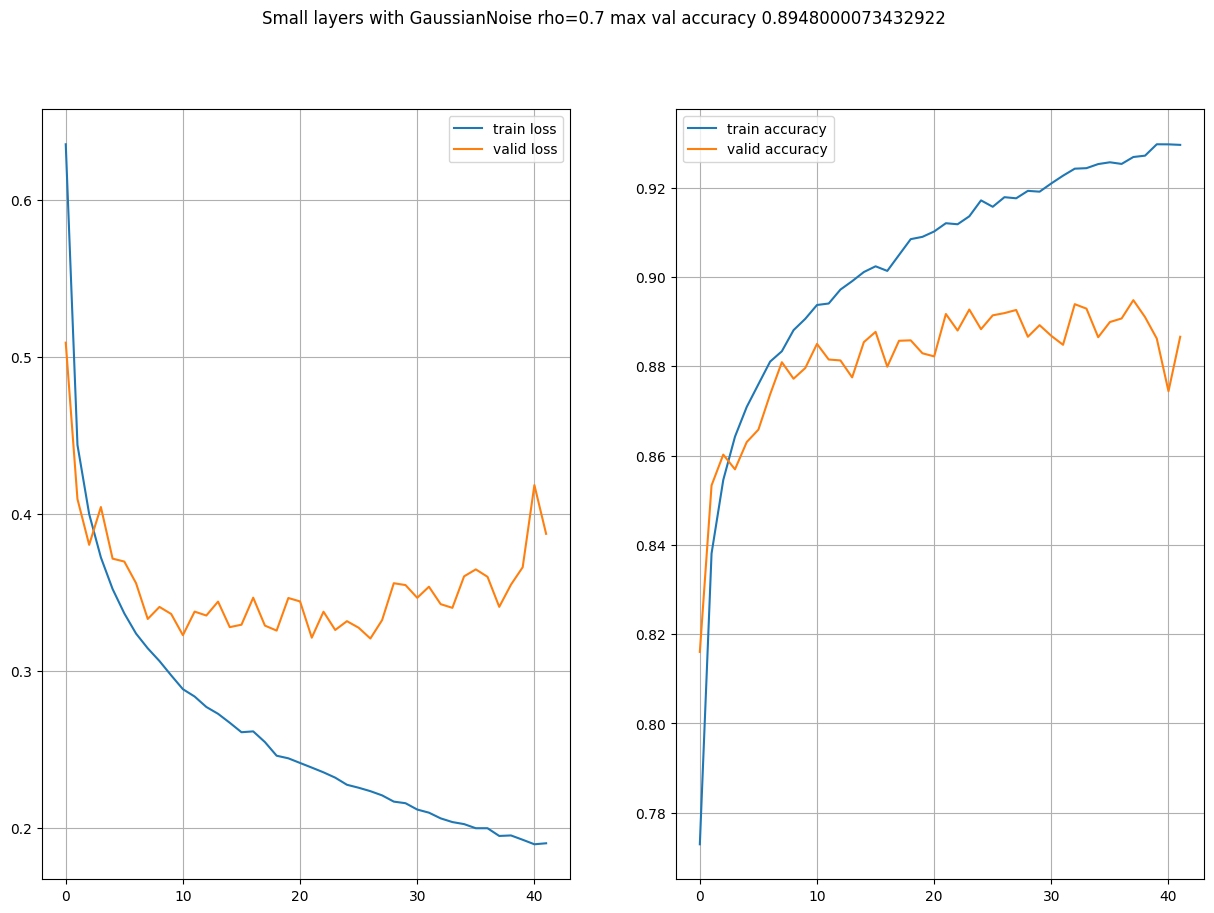

Epoch 1/100
468/469 [============================>.] - ETA: 0s - loss: 0.6214 - accuracy: 0.7760 - categorical_crossentropy: 0.6214INFO:tensorflow:Assets written to: small_la_gn_cp_32\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_32\assets


469/469 [==============================] - 6s 11ms/step - loss: 0.6209 - accuracy: 0.7761 - categorical_crossentropy: 0.6209 - val_loss: 0.4589 - val_accuracy: 0.8345 - val_categorical_crossentropy: 0.4589
Epoch 2/100
460/469 [============================>.] - ETA: 0s - loss: 0.4420 - accuracy: 0.8400 - categorical_crossentropy: 0.4420INFO:tensorflow:Assets written to: small_la_gn_cp_32\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_32\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.4419 - accuracy: 0.8400 - categorical_crossentropy: 0.4419 - val_loss: 0.4334 - val_accuracy: 0.8481 - val_categorical_crossentropy: 0.4334
Epoch 3/100
460/469 [============================>.] - ETA: 0s - loss: 0.3954 - accuracy: 0.8561 - categorical_crossentropy: 0.3954INFO:tensorflow:Assets written to: small_la_gn_cp_32\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_32\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3945 - accuracy: 0.8563 - categorical_crossentropy: 0.3945 - val_loss: 0.3898 - val_accuracy: 0.8603 - val_categorical_crossentropy: 0.3898
Epoch 4/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3664 - accuracy: 0.8654 - categorical_crossentropy: 0.3664 - val_loss: 0.4053 - val_accuracy: 0.8481 - val_categorical_crossentropy: 0.4053
Epoch 5/100
457/469 [============================>.] - ETA: 0s - loss: 0.3449 - accuracy: 0.8735 - categorical_crossentropy: 0.3449INFO:tensorflow:Assets written to: small_la_gn_cp_32\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_32\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3450 - accuracy: 0.8733 - categorical_crossentropy: 0.3450 - val_loss: 0.3646 - val_accuracy: 0.8665 - val_categorical_crossentropy: 0.3646
Epoch 6/100
460/469 [============================>.] - ETA: 0s - loss: 0.3292 - accuracy: 0.8787 - categorical_crossentropy: 0.3292INFO:tensorflow:Assets written to: small_la_gn_cp_32\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_32\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3288 - accuracy: 0.8788 - categorical_crossentropy: 0.3288 - val_loss: 0.3698 - val_accuracy: 0.8666 - val_categorical_crossentropy: 0.3698
Epoch 7/100
461/469 [============================>.] - ETA: 0s - loss: 0.3181 - accuracy: 0.8823 - categorical_crossentropy: 0.3181INFO:tensorflow:Assets written to: small_la_gn_cp_32\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_32\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3173 - accuracy: 0.8825 - categorical_crossentropy: 0.3173 - val_loss: 0.3459 - val_accuracy: 0.8772 - val_categorical_crossentropy: 0.3459
Epoch 8/100
469/469 [==============================] - 4s 8ms/step - loss: 0.3061 - accuracy: 0.8863 - categorical_crossentropy: 0.3061 - val_loss: 0.3465 - val_accuracy: 0.8736 - val_categorical_crossentropy: 0.3465
Epoch 9/100
463/469 [============================>.] - ETA: 0s - loss: 0.2963 - accuracy: 0.8894 - categorical_crossentropy: 0.2963INFO:tensorflow:Assets written to: small_la_gn_cp_32\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_32\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2968 - accuracy: 0.8891 - categorical_crossentropy: 0.2968 - val_loss: 0.3350 - val_accuracy: 0.8779 - val_categorical_crossentropy: 0.3350
Epoch 10/100
465/469 [============================>.] - ETA: 0s - loss: 0.2887 - accuracy: 0.8922 - categorical_crossentropy: 0.2887INFO:tensorflow:Assets written to: small_la_gn_cp_32\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_32\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.2893 - accuracy: 0.8920 - categorical_crossentropy: 0.2893 - val_loss: 0.3241 - val_accuracy: 0.8804 - val_categorical_crossentropy: 0.3241
Epoch 11/100
468/469 [============================>.] - ETA: 0s - loss: 0.2801 - accuracy: 0.8951 - categorical_crossentropy: 0.2801INFO:tensorflow:Assets written to: small_la_gn_cp_32\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_32\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.2800 - accuracy: 0.8951 - categorical_crossentropy: 0.2800 - val_loss: 0.3278 - val_accuracy: 0.8808 - val_categorical_crossentropy: 0.3278
Epoch 12/100
463/469 [============================>.] - ETA: 0s - loss: 0.2721 - accuracy: 0.8989 - categorical_crossentropy: 0.2721INFO:tensorflow:Assets written to: small_la_gn_cp_32\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_32\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.2723 - accuracy: 0.8988 - categorical_crossentropy: 0.2723 - val_loss: 0.3319 - val_accuracy: 0.8821 - val_categorical_crossentropy: 0.3319
Epoch 13/100
464/469 [============================>.] - ETA: 0s - loss: 0.2674 - accuracy: 0.8996 - categorical_crossentropy: 0.2674INFO:tensorflow:Assets written to: small_la_gn_cp_32\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_32\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2670 - accuracy: 0.9000 - categorical_crossentropy: 0.2670 - val_loss: 0.3189 - val_accuracy: 0.8859 - val_categorical_crossentropy: 0.3189
Epoch 14/100
469/469 [==============================] - ETA: 0s - loss: 0.2607 - accuracy: 0.9018 - categorical_crossentropy: 0.2607INFO:tensorflow:Assets written to: small_la_gn_cp_32\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_32\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2607 - accuracy: 0.9018 - categorical_crossentropy: 0.2607 - val_loss: 0.3164 - val_accuracy: 0.8893 - val_categorical_crossentropy: 0.3164
Epoch 15/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2540 - accuracy: 0.9037 - categorical_crossentropy: 0.2540 - val_loss: 0.3203 - val_accuracy: 0.8851 - val_categorical_crossentropy: 0.3203
Epoch 16/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2495 - accuracy: 0.9061 - categorical_crossentropy: 0.2495 - val_loss: 0.3278 - val_accuracy: 0.8804 - val_categorical_crossentropy: 0.3278
Epoch 17/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2419 - accuracy: 0.9091 - categorical_crossentropy: 0.2419 - val_loss: 0.3140 - val_accuracy: 0.8889 - val_categorical_crossentropy: 0.3140
Epoch 18/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2381 - accuracy: 0.9098 - categorical_crossentropy: 0.2381 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_32\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2337 - accuracy: 0.9119 - categorical_crossentropy: 0.2337 - val_loss: 0.3163 - val_accuracy: 0.8914 - val_categorical_crossentropy: 0.3163
Epoch 20/100
464/469 [============================>.] - ETA: 0s - loss: 0.2283 - accuracy: 0.9136 - categorical_crossentropy: 0.2283INFO:tensorflow:Assets written to: small_la_gn_cp_32\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_32\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2284 - accuracy: 0.9136 - categorical_crossentropy: 0.2284 - val_loss: 0.3074 - val_accuracy: 0.8943 - val_categorical_crossentropy: 0.3074
Epoch 21/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2248 - accuracy: 0.9147 - categorical_crossentropy: 0.2248 - val_loss: 0.3086 - val_accuracy: 0.8942 - val_categorical_crossentropy: 0.3086
Epoch 22/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2210 - accuracy: 0.9169 - categorical_crossentropy: 0.2210 - val_loss: 0.3383 - val_accuracy: 0.8916 - val_categorical_crossentropy: 0.3383
Epoch 23/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2172 - accuracy: 0.9178 - categorical_crossentropy: 0.2172 - val_loss: 0.3200 - val_accuracy: 0.8921 - val_categorical_crossentropy: 0.3200
Epoch 24/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2109 - accuracy: 0.9205 - categorical_crossentropy: 0.2109 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_32\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2015 - accuracy: 0.9234 - categorical_crossentropy: 0.2015 - val_loss: 0.3134 - val_accuracy: 0.8945 - val_categorical_crossentropy: 0.3134
Epoch 28/100
463/469 [============================>.] - ETA: 0s - loss: 0.1964 - accuracy: 0.9257 - categorical_crossentropy: 0.1964INFO:tensorflow:Assets written to: small_la_gn_cp_32\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_32\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.1967 - accuracy: 0.9257 - categorical_crossentropy: 0.1967 - val_loss: 0.3160 - val_accuracy: 0.8950 - val_categorical_crossentropy: 0.3160
Epoch 29/100
467/469 [============================>.] - ETA: 0s - loss: 0.1921 - accuracy: 0.9273 - categorical_crossentropy: 0.1921INFO:tensorflow:Assets written to: small_la_gn_cp_32\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_32\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.1923 - accuracy: 0.9273 - categorical_crossentropy: 0.1923 - val_loss: 0.3155 - val_accuracy: 0.8957 - val_categorical_crossentropy: 0.3155
Epoch 30/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1909 - accuracy: 0.9278 - categorical_crossentropy: 0.1909 - val_loss: 0.3311 - val_accuracy: 0.8928 - val_categorical_crossentropy: 0.3311
Epoch 31/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1868 - accuracy: 0.9296 - categorical_crossentropy: 0.1868 - val_loss: 0.3511 - val_accuracy: 0.8881 - val_categorical_crossentropy: 0.3511
Epoch 32/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1825 - accuracy: 0.9315 - categorical_crossentropy: 0.1825 - val_loss: 0.3312 - val_accuracy: 0.8947 - val_categorical_crossentropy: 0.3312
Epoch 33/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1800 - accuracy: 0.9321 - categorical_crossentropy: 0.1800 - v

INFO:tensorflow:Assets written to: small_la_gn_cp_32\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.1777 - accuracy: 0.9330 - categorical_crossentropy: 0.1777 - val_loss: 0.3351 - val_accuracy: 0.8969 - val_categorical_crossentropy: 0.3351
Epoch 35/100
461/469 [============================>.] - ETA: 0s - loss: 0.1736 - accuracy: 0.9346 - categorical_crossentropy: 0.1736INFO:tensorflow:Assets written to: small_la_gn_cp_32\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_32\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.1730 - accuracy: 0.9349 - categorical_crossentropy: 0.1730 - val_loss: 0.3339 - val_accuracy: 0.8970 - val_categorical_crossentropy: 0.3339


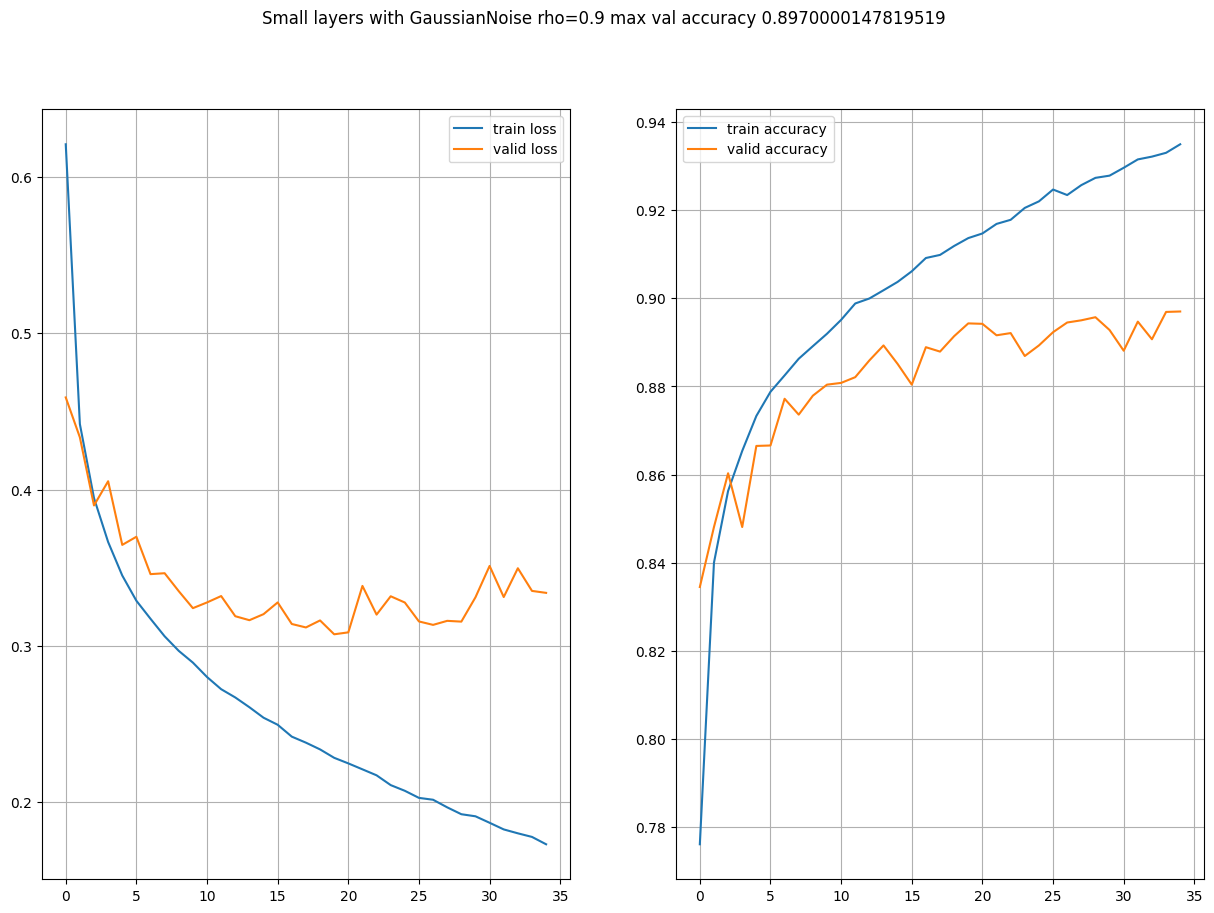

Epoch 1/100
463/469 [============================>.] - ETA: 0s - loss: 0.6148 - accuracy: 0.7783 - categorical_crossentropy: 0.6148INFO:tensorflow:Assets written to: small_la_gn_cp_33\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_33\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.6130 - accuracy: 0.7790 - categorical_crossentropy: 0.6130 - val_loss: 0.5379 - val_accuracy: 0.8143 - val_categorical_crossentropy: 0.5379
Epoch 2/100
462/469 [============================>.] - ETA: 0s - loss: 0.4371 - accuracy: 0.8419 - categorical_crossentropy: 0.4371INFO:tensorflow:Assets written to: small_la_gn_cp_33\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_33\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4375 - accuracy: 0.8421 - categorical_crossentropy: 0.4375 - val_loss: 0.4173 - val_accuracy: 0.8470 - val_categorical_crossentropy: 0.4173
Epoch 3/100
462/469 [============================>.] - ETA: 0s - loss: 0.3918 - accuracy: 0.8569 - categorical_crossentropy: 0.3918INFO:tensorflow:Assets written to: small_la_gn_cp_33\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_33\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3915 - accuracy: 0.8572 - categorical_crossentropy: 0.3915 - val_loss: 0.3951 - val_accuracy: 0.8555 - val_categorical_crossentropy: 0.3951
Epoch 4/100
465/469 [============================>.] - ETA: 0s - loss: 0.3637 - accuracy: 0.8654 - categorical_crossentropy: 0.3637INFO:tensorflow:Assets written to: small_la_gn_cp_33\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_33\assets


469/469 [==============================] - 4s 10ms/step - loss: 0.3638 - accuracy: 0.8654 - categorical_crossentropy: 0.3638 - val_loss: 0.3682 - val_accuracy: 0.8646 - val_categorical_crossentropy: 0.3682
Epoch 5/100
464/469 [============================>.] - ETA: 0s - loss: 0.3416 - accuracy: 0.8748 - categorical_crossentropy: 0.3416INFO:tensorflow:Assets written to: small_la_gn_cp_33\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_33\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3411 - accuracy: 0.8750 - categorical_crossentropy: 0.3411 - val_loss: 0.3690 - val_accuracy: 0.8660 - val_categorical_crossentropy: 0.3690
Epoch 6/100
460/469 [============================>.] - ETA: 0s - loss: 0.3285 - accuracy: 0.8782 - categorical_crossentropy: 0.3285INFO:tensorflow:Assets written to: small_la_gn_cp_33\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_33\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3276 - accuracy: 0.8786 - categorical_crossentropy: 0.3276 - val_loss: 0.3521 - val_accuracy: 0.8717 - val_categorical_crossentropy: 0.3521
Epoch 7/100
460/469 [============================>.] - ETA: 0s - loss: 0.3138 - accuracy: 0.8836 - categorical_crossentropy: 0.3138INFO:tensorflow:Assets written to: small_la_gn_cp_33\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_33\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3140 - accuracy: 0.8836 - categorical_crossentropy: 0.3140 - val_loss: 0.3391 - val_accuracy: 0.8767 - val_categorical_crossentropy: 0.3391
Epoch 8/100
469/469 [==============================] - 4s 7ms/step - loss: 0.3038 - accuracy: 0.8875 - categorical_crossentropy: 0.3038 - val_loss: 0.3539 - val_accuracy: 0.8710 - val_categorical_crossentropy: 0.3539
Epoch 9/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2946 - accuracy: 0.8899 - categorical_crossentropy: 0.2946 - val_loss: 0.3485 - val_accuracy: 0.8716 - val_categorical_crossentropy: 0.3485
Epoch 10/100
464/469 [============================>.] - ETA: 0s - loss: 0.2836 - accuracy: 0.8937 - categorical_crossentropy: 0.2836INFO:tensorflow:Assets written to: small_la_gn_cp_33\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_33\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2832 - accuracy: 0.8937 - categorical_crossentropy: 0.2832 - val_loss: 0.3267 - val_accuracy: 0.8835 - val_categorical_crossentropy: 0.3267
Epoch 11/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2776 - accuracy: 0.8960 - categorical_crossentropy: 0.2776 - val_loss: 0.3388 - val_accuracy: 0.8818 - val_categorical_crossentropy: 0.3388
Epoch 12/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2718 - accuracy: 0.8970 - categorical_crossentropy: 0.2718 - val_loss: 0.3289 - val_accuracy: 0.8833 - val_categorical_crossentropy: 0.3289
Epoch 13/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2629 - accuracy: 0.9009 - categorical_crossentropy: 0.2629 - val_loss: 0.3226 - val_accuracy: 0.8808 - val_categorical_crossentropy: 0.3226
Epoch 14/100
461/469 [============================>.] - ETA: 0s - loss: 0.2586 - accuracy: 0.9024 - categorical_crossentropy: 0.2586INFO:tens

INFO:tensorflow:Assets written to: small_la_gn_cp_33\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2592 - accuracy: 0.9021 - categorical_crossentropy: 0.2592 - val_loss: 0.3155 - val_accuracy: 0.8864 - val_categorical_crossentropy: 0.3155
Epoch 15/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2511 - accuracy: 0.9048 - categorical_crossentropy: 0.2511 - val_loss: 0.3252 - val_accuracy: 0.8850 - val_categorical_crossentropy: 0.3252
Epoch 16/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2463 - accuracy: 0.9067 - categorical_crossentropy: 0.2463 - val_loss: 0.3215 - val_accuracy: 0.8856 - val_categorical_crossentropy: 0.3215
Epoch 17/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2406 - accuracy: 0.9098 - categorical_crossentropy: 0.2406 - val_loss: 0.3318 - val_accuracy: 0.8848 - val_categorical_crossentropy: 0.3318
Epoch 18/100
463/469 [============================>.] - ETA: 0s - loss: 0.2337 - accuracy: 0.9118 - categorical_crossentropy: 0.2337INFO:tens

INFO:tensorflow:Assets written to: small_la_gn_cp_33\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2341 - accuracy: 0.9117 - categorical_crossentropy: 0.2341 - val_loss: 0.3092 - val_accuracy: 0.8902 - val_categorical_crossentropy: 0.3092
Epoch 19/100
469/469 [==============================] - 4s 7ms/step - loss: 0.2294 - accuracy: 0.9129 - categorical_crossentropy: 0.2294 - val_loss: 0.3286 - val_accuracy: 0.8878 - val_categorical_crossentropy: 0.3286
Epoch 20/100
464/469 [============================>.] - ETA: 0s - loss: 0.2269 - accuracy: 0.9136 - categorical_crossentropy: 0.2269INFO:tensorflow:Assets written to: small_la_gn_cp_33\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_33\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2264 - accuracy: 0.9138 - categorical_crossentropy: 0.2264 - val_loss: 0.3211 - val_accuracy: 0.8919 - val_categorical_crossentropy: 0.3211
Epoch 21/100
469/469 [==============================] - 4s 8ms/step - loss: 0.2203 - accuracy: 0.9164 - categorical_crossentropy: 0.2203 - val_loss: 0.3302 - val_accuracy: 0.8875 - val_categorical_crossentropy: 0.3302
Epoch 22/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2174 - accuracy: 0.9176 - categorical_crossentropy: 0.2174 - val_loss: 0.3397 - val_accuracy: 0.8845 - val_categorical_crossentropy: 0.3397
Epoch 23/100
463/469 [============================>.] - ETA: 0s - loss: 0.2119 - accuracy: 0.9198 - categorical_crossentropy: 0.2119INFO:tensorflow:Assets written to: small_la_gn_cp_33\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_33\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2117 - accuracy: 0.9200 - categorical_crossentropy: 0.2117 - val_loss: 0.3232 - val_accuracy: 0.8923 - val_categorical_crossentropy: 0.3232
Epoch 24/100
469/469 [==============================] - 4s 7ms/step - loss: 0.2081 - accuracy: 0.9211 - categorical_crossentropy: 0.2081 - val_loss: 0.3187 - val_accuracy: 0.8873 - val_categorical_crossentropy: 0.3187
Epoch 25/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2028 - accuracy: 0.9236 - categorical_crossentropy: 0.2028 - val_loss: 0.3155 - val_accuracy: 0.8914 - val_categorical_crossentropy: 0.3155
Epoch 26/100
465/469 [============================>.] - ETA: 0s - loss: 0.2019 - accuracy: 0.9227 - categorical_crossentropy: 0.2019INFO:tensorflow:Assets written to: small_la_gn_cp_33\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_33\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2018 - accuracy: 0.9227 - categorical_crossentropy: 0.2018 - val_loss: 0.3159 - val_accuracy: 0.8940 - val_categorical_crossentropy: 0.3159
Epoch 27/100
469/469 [==============================] - 4s 8ms/step - loss: 0.1980 - accuracy: 0.9242 - categorical_crossentropy: 0.1980 - val_loss: 0.3169 - val_accuracy: 0.8919 - val_categorical_crossentropy: 0.3169
Epoch 28/100
469/469 [==============================] - ETA: 0s - loss: 0.1929 - accuracy: 0.9256 - categorical_crossentropy: 0.1929INFO:tensorflow:Assets written to: small_la_gn_cp_33\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_33\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.1929 - accuracy: 0.9256 - categorical_crossentropy: 0.1929 - val_loss: 0.3206 - val_accuracy: 0.8943 - val_categorical_crossentropy: 0.3206
Epoch 29/100
469/469 [==============================] - 4s 7ms/step - loss: 0.1898 - accuracy: 0.9275 - categorical_crossentropy: 0.1898 - val_loss: 0.3192 - val_accuracy: 0.8915 - val_categorical_crossentropy: 0.3192
Epoch 30/100
464/469 [============================>.] - ETA: 0s - loss: 0.1868 - accuracy: 0.9283 - categorical_crossentropy: 0.1868INFO:tensorflow:Assets written to: small_la_gn_cp_33\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_33\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.1866 - accuracy: 0.9284 - categorical_crossentropy: 0.1866 - val_loss: 0.3196 - val_accuracy: 0.8959 - val_categorical_crossentropy: 0.3196
Epoch 31/100
469/469 [==============================] - 4s 8ms/step - loss: 0.1815 - accuracy: 0.9316 - categorical_crossentropy: 0.1815 - val_loss: 0.3195 - val_accuracy: 0.8959 - val_categorical_crossentropy: 0.3195
Epoch 32/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1791 - accuracy: 0.9323 - categorical_crossentropy: 0.1791 - val_loss: 0.3359 - val_accuracy: 0.8874 - val_categorical_crossentropy: 0.3359
Epoch 33/100
461/469 [============================>.] - ETA: 0s - loss: 0.1765 - accuracy: 0.9322 - categorical_crossentropy: 0.1765INFO:tensorflow:Assets written to: small_la_gn_cp_33\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_33\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.1771 - accuracy: 0.9321 - categorical_crossentropy: 0.1771 - val_loss: 0.3153 - val_accuracy: 0.8986 - val_categorical_crossentropy: 0.3153


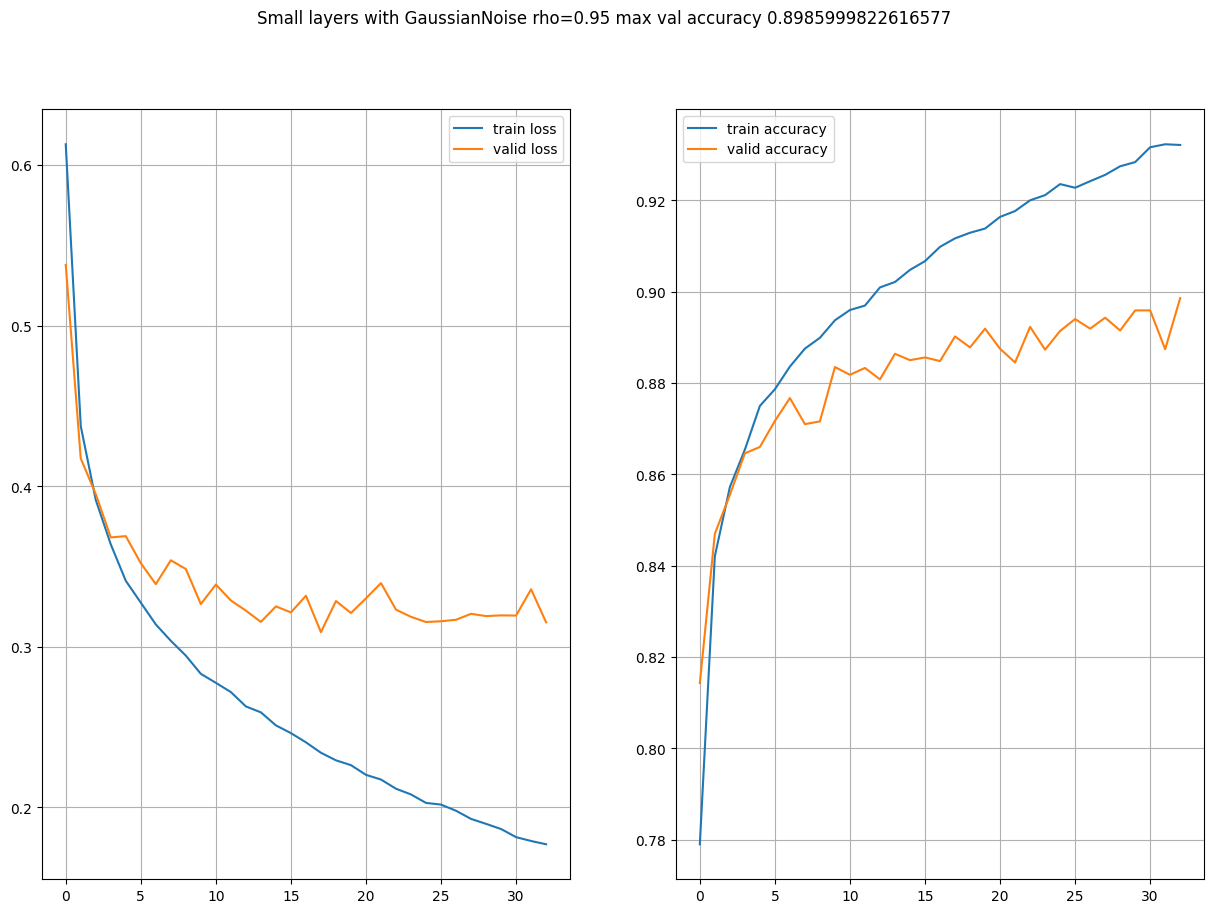

Epoch 1/100
462/469 [============================>.] - ETA: 0s - loss: 0.5767 - accuracy: 0.7899 - categorical_crossentropy: 0.5767INFO:tensorflow:Assets written to: small_la_gn_cp_34\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_34\assets


469/469 [==============================] - 5s 9ms/step - loss: 0.5745 - accuracy: 0.7907 - categorical_crossentropy: 0.5745 - val_loss: 0.4533 - val_accuracy: 0.8395 - val_categorical_crossentropy: 0.4533
Epoch 2/100
469/469 [==============================] - ETA: 0s - loss: 0.4277 - accuracy: 0.8443 - categorical_crossentropy: 0.4277INFO:tensorflow:Assets written to: small_la_gn_cp_34\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_34\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.4277 - accuracy: 0.8443 - categorical_crossentropy: 0.4277 - val_loss: 0.4074 - val_accuracy: 0.8504 - val_categorical_crossentropy: 0.4074
Epoch 3/100
461/469 [============================>.] - ETA: 0s - loss: 0.3876 - accuracy: 0.8577 - categorical_crossentropy: 0.3876INFO:tensorflow:Assets written to: small_la_gn_cp_34\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_34\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3872 - accuracy: 0.8579 - categorical_crossentropy: 0.3872 - val_loss: 0.3768 - val_accuracy: 0.8655 - val_categorical_crossentropy: 0.3768
Epoch 4/100
460/469 [============================>.] - ETA: 0s - loss: 0.3598 - accuracy: 0.8689 - categorical_crossentropy: 0.3598INFO:tensorflow:Assets written to: small_la_gn_cp_34\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_34\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3593 - accuracy: 0.8691 - categorical_crossentropy: 0.3593 - val_loss: 0.3678 - val_accuracy: 0.8669 - val_categorical_crossentropy: 0.3678
Epoch 5/100
468/469 [============================>.] - ETA: 0s - loss: 0.3401 - accuracy: 0.8745 - categorical_crossentropy: 0.3401INFO:tensorflow:Assets written to: small_la_gn_cp_34\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_34\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3404 - accuracy: 0.8745 - categorical_crossentropy: 0.3404 - val_loss: 0.3510 - val_accuracy: 0.8722 - val_categorical_crossentropy: 0.3510
Epoch 6/100
464/469 [============================>.] - ETA: 0s - loss: 0.3258 - accuracy: 0.8788 - categorical_crossentropy: 0.3258INFO:tensorflow:Assets written to: small_la_gn_cp_34\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_34\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3250 - accuracy: 0.8791 - categorical_crossentropy: 0.3250 - val_loss: 0.3555 - val_accuracy: 0.8731 - val_categorical_crossentropy: 0.3555
Epoch 7/100
469/469 [==============================] - ETA: 0s - loss: 0.3112 - accuracy: 0.8842 - categorical_crossentropy: 0.3112INFO:tensorflow:Assets written to: small_la_gn_cp_34\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_34\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3112 - accuracy: 0.8842 - categorical_crossentropy: 0.3112 - val_loss: 0.3410 - val_accuracy: 0.8761 - val_categorical_crossentropy: 0.3410
Epoch 8/100
465/469 [============================>.] - ETA: 0s - loss: 0.2995 - accuracy: 0.8890 - categorical_crossentropy: 0.2995INFO:tensorflow:Assets written to: small_la_gn_cp_34\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_34\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.2996 - accuracy: 0.8888 - categorical_crossentropy: 0.2996 - val_loss: 0.3368 - val_accuracy: 0.8764 - val_categorical_crossentropy: 0.3368
Epoch 9/100
469/469 [==============================] - 4s 7ms/step - loss: 0.2915 - accuracy: 0.8907 - categorical_crossentropy: 0.2915 - val_loss: 0.3498 - val_accuracy: 0.8734 - val_categorical_crossentropy: 0.3498
Epoch 10/100
462/469 [============================>.] - ETA: 0s - loss: 0.2813 - accuracy: 0.8936 - categorical_crossentropy: 0.2813INFO:tensorflow:Assets written to: small_la_gn_cp_34\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_34\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2814 - accuracy: 0.8935 - categorical_crossentropy: 0.2814 - val_loss: 0.3351 - val_accuracy: 0.8791 - val_categorical_crossentropy: 0.3351
Epoch 11/100
467/469 [============================>.] - ETA: 0s - loss: 0.2760 - accuracy: 0.8967 - categorical_crossentropy: 0.2760INFO:tensorflow:Assets written to: small_la_gn_cp_34\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_34\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2757 - accuracy: 0.8968 - categorical_crossentropy: 0.2757 - val_loss: 0.3337 - val_accuracy: 0.8806 - val_categorical_crossentropy: 0.3337
Epoch 12/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2666 - accuracy: 0.9004 - categorical_crossentropy: 0.2666 - val_loss: 0.3304 - val_accuracy: 0.8798 - val_categorical_crossentropy: 0.3304
Epoch 13/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2607 - accuracy: 0.9011 - categorical_crossentropy: 0.2607 - val_loss: 0.3246 - val_accuracy: 0.8798 - val_categorical_crossentropy: 0.3246
Epoch 14/100
463/469 [============================>.] - ETA: 0s - loss: 0.2541 - accuracy: 0.9054 - categorical_crossentropy: 0.2541INFO:tensorflow:Assets written to: small_la_gn_cp_34\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_34\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2540 - accuracy: 0.9055 - categorical_crossentropy: 0.2540 - val_loss: 0.3259 - val_accuracy: 0.8827 - val_categorical_crossentropy: 0.3259
Epoch 15/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2484 - accuracy: 0.9059 - categorical_crossentropy: 0.2484 - val_loss: 0.3262 - val_accuracy: 0.8814 - val_categorical_crossentropy: 0.3262
Epoch 16/100
458/469 [============================>.] - ETA: 0s - loss: 0.2408 - accuracy: 0.9080 - categorical_crossentropy: 0.2408INFO:tensorflow:Assets written to: small_la_gn_cp_34\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_34\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2410 - accuracy: 0.9077 - categorical_crossentropy: 0.2410 - val_loss: 0.3183 - val_accuracy: 0.8897 - val_categorical_crossentropy: 0.3183
Epoch 17/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2364 - accuracy: 0.9108 - categorical_crossentropy: 0.2364 - val_loss: 0.3282 - val_accuracy: 0.8829 - val_categorical_crossentropy: 0.3282
Epoch 18/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2303 - accuracy: 0.9133 - categorical_crossentropy: 0.2303 - val_loss: 0.3197 - val_accuracy: 0.8868 - val_categorical_crossentropy: 0.3197
Epoch 19/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2249 - accuracy: 0.9142 - categorical_crossentropy: 0.2249 - val_loss: 0.3109 - val_accuracy: 0.8878 - val_categorical_crossentropy: 0.3109
Epoch 20/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2218 - accuracy: 0.9154 - categorical_crossentropy: 0.2218 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_34\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2182 - accuracy: 0.9169 - categorical_crossentropy: 0.2182 - val_loss: 0.3143 - val_accuracy: 0.8913 - val_categorical_crossentropy: 0.3143
Epoch 22/100
469/469 [==============================] - 4s 8ms/step - loss: 0.2123 - accuracy: 0.9189 - categorical_crossentropy: 0.2123 - val_loss: 0.3313 - val_accuracy: 0.8869 - val_categorical_crossentropy: 0.3313
Epoch 23/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2066 - accuracy: 0.9219 - categorical_crossentropy: 0.2066 - val_loss: 0.3218 - val_accuracy: 0.8898 - val_categorical_crossentropy: 0.3218
Epoch 24/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2048 - accuracy: 0.9212 - categorical_crossentropy: 0.2048 - val_loss: 0.3213 - val_accuracy: 0.8908 - val_categorical_crossentropy: 0.3213
Epoch 25/100
464/469 [============================>.] - ETA: 0s - loss: 0.1988 - accuracy: 0.9248 - categorical_crossentropy: 0.1988INFO:tens

INFO:tensorflow:Assets written to: small_la_gn_cp_34\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.1990 - accuracy: 0.9247 - categorical_crossentropy: 0.1990 - val_loss: 0.3177 - val_accuracy: 0.8941 - val_categorical_crossentropy: 0.3177
Epoch 26/100
469/469 [==============================] - 4s 7ms/step - loss: 0.1969 - accuracy: 0.9252 - categorical_crossentropy: 0.1969 - val_loss: 0.3150 - val_accuracy: 0.8915 - val_categorical_crossentropy: 0.3150
Epoch 27/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1932 - accuracy: 0.9261 - categorical_crossentropy: 0.1932 - val_loss: 0.3227 - val_accuracy: 0.8902 - val_categorical_crossentropy: 0.3227
Epoch 28/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1894 - accuracy: 0.9283 - categorical_crossentropy: 0.1894 - val_loss: 0.3184 - val_accuracy: 0.8929 - val_categorical_crossentropy: 0.3184
Epoch 29/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1857 - accuracy: 0.9294 - categorical_crossentropy: 0.1857 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_34\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.1792 - accuracy: 0.9317 - categorical_crossentropy: 0.1792 - val_loss: 0.3238 - val_accuracy: 0.8990 - val_categorical_crossentropy: 0.3238
Epoch 32/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1758 - accuracy: 0.9333 - categorical_crossentropy: 0.1758 - val_loss: 0.3213 - val_accuracy: 0.8947 - val_categorical_crossentropy: 0.3213
Epoch 33/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1714 - accuracy: 0.9344 - categorical_crossentropy: 0.1714 - val_loss: 0.3224 - val_accuracy: 0.8939 - val_categorical_crossentropy: 0.3224
Epoch 34/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1703 - accuracy: 0.9345 - categorical_crossentropy: 0.1703 - val_loss: 0.3201 - val_accuracy: 0.8958 - val_categorical_crossentropy: 0.3201


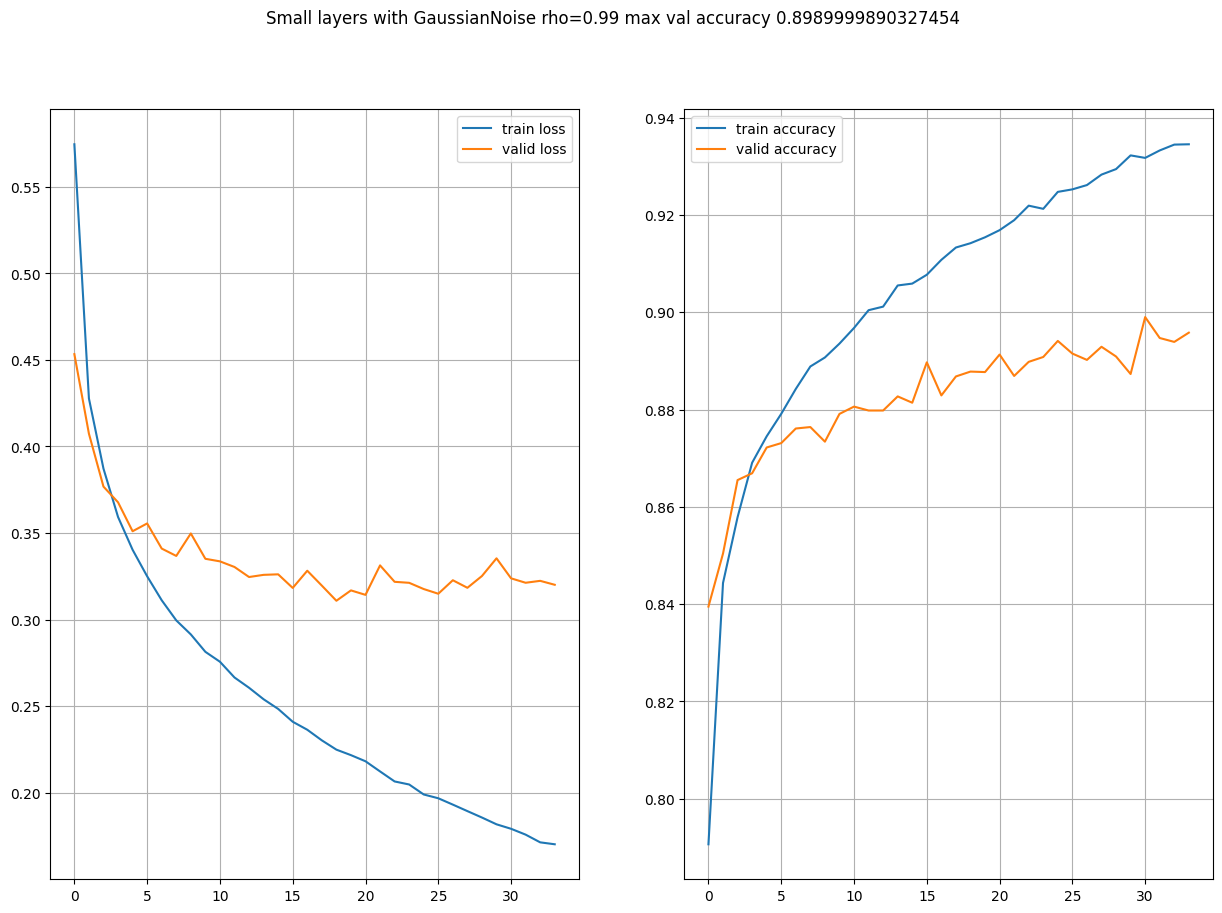

In [37]:

rhos = [.5, .7, .9, .95, .99]
idx = 30

for rho in rhos:
    small_layers_GN = [
        Dense(128, activation="relu", input_shape=(28*28,)),
        GaussianNoise(0.2),
        Dense(512, activation="relu"),
        GaussianNoise(.2),
        Dense(10, activation="softmax"),
    ]

    small_model_GN = create_model_2(small_layers_GN, RMSprop(learning_rate=.0005, rho=rho))
    history = fit_and_present_2(small_model_GN, def_ds, val_dataset, description=f"Small layers with GaussianNoise rho={rho}", filepath=f"small_la_gn_cp_{idx}", patience=15)

    idx+=1

Зі зростанням rho криві навчання стають більш "спокійними", однак ми досі не досягли 91%. Попрацюємо з momentum

Epoch 1/100


469/469 [==============================] - ETA: 0s - loss: 0.5450 - accuracy: 0.8036 - categorical_crossentropy: 0.5450INFO:tensorflow:Assets written to: small_la_gn_cp_40\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_40\assets


469/469 [==============================] - 5s 9ms/step - loss: 0.5450 - accuracy: 0.8036 - categorical_crossentropy: 0.5450 - val_loss: 0.4272 - val_accuracy: 0.8446 - val_categorical_crossentropy: 0.4272
Epoch 2/100
468/469 [============================>.] - ETA: 0s - loss: 0.4010 - accuracy: 0.8523 - categorical_crossentropy: 0.4010INFO:tensorflow:Assets written to: small_la_gn_cp_40\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_40\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4011 - accuracy: 0.8522 - categorical_crossentropy: 0.4011 - val_loss: 0.4123 - val_accuracy: 0.8503 - val_categorical_crossentropy: 0.4123
Epoch 3/100
469/469 [==============================] - ETA: 0s - loss: 0.3592 - accuracy: 0.8674 - categorical_crossentropy: 0.3592INFO:tensorflow:Assets written to: small_la_gn_cp_40\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_40\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3592 - accuracy: 0.8674 - categorical_crossentropy: 0.3592 - val_loss: 0.3867 - val_accuracy: 0.8559 - val_categorical_crossentropy: 0.3867
Epoch 4/100
461/469 [============================>.] - ETA: 0s - loss: 0.3323 - accuracy: 0.8761 - categorical_crossentropy: 0.3323INFO:tensorflow:Assets written to: small_la_gn_cp_40\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_40\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3321 - accuracy: 0.8762 - categorical_crossentropy: 0.3321 - val_loss: 0.3748 - val_accuracy: 0.8665 - val_categorical_crossentropy: 0.3748
Epoch 5/100
460/469 [============================>.] - ETA: 0s - loss: 0.3130 - accuracy: 0.8834 - categorical_crossentropy: 0.3130INFO:tensorflow:Assets written to: small_la_gn_cp_40\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_40\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3135 - accuracy: 0.8833 - categorical_crossentropy: 0.3135 - val_loss: 0.3430 - val_accuracy: 0.8751 - val_categorical_crossentropy: 0.3430
Epoch 6/100
465/469 [============================>.] - ETA: 0s - loss: 0.2984 - accuracy: 0.8882 - categorical_crossentropy: 0.2984INFO:tensorflow:Assets written to: small_la_gn_cp_40\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_40\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2984 - accuracy: 0.8882 - categorical_crossentropy: 0.2984 - val_loss: 0.3355 - val_accuracy: 0.8765 - val_categorical_crossentropy: 0.3355
Epoch 7/100
461/469 [============================>.] - ETA: 0s - loss: 0.2857 - accuracy: 0.8937 - categorical_crossentropy: 0.2857INFO:tensorflow:Assets written to: small_la_gn_cp_40\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_40\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2856 - accuracy: 0.8936 - categorical_crossentropy: 0.2856 - val_loss: 0.3326 - val_accuracy: 0.8824 - val_categorical_crossentropy: 0.3326
Epoch 8/100
465/469 [============================>.] - ETA: 0s - loss: 0.2761 - accuracy: 0.8970 - categorical_crossentropy: 0.2761INFO:tensorflow:Assets written to: small_la_gn_cp_40\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_40\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.2760 - accuracy: 0.8970 - categorical_crossentropy: 0.2760 - val_loss: 0.3247 - val_accuracy: 0.8851 - val_categorical_crossentropy: 0.3247
Epoch 9/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2659 - accuracy: 0.8992 - categorical_crossentropy: 0.2659 - val_loss: 0.3430 - val_accuracy: 0.8784 - val_categorical_crossentropy: 0.3430
Epoch 10/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2555 - accuracy: 0.9041 - categorical_crossentropy: 0.2555 - val_loss: 0.3466 - val_accuracy: 0.8779 - val_categorical_crossentropy: 0.3466
Epoch 11/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2492 - accuracy: 0.9061 - categorical_crossentropy: 0.2492 - val_loss: 0.3346 - val_accuracy: 0.8826 - val_categorical_crossentropy: 0.3346
Epoch 12/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2398 - accuracy: 0.9089 - categorical_crossentropy: 0.2398 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_40\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2333 - accuracy: 0.9113 - categorical_crossentropy: 0.2333 - val_loss: 0.3398 - val_accuracy: 0.8874 - val_categorical_crossentropy: 0.3398
Epoch 14/100
459/469 [============================>.] - ETA: 0s - loss: 0.2246 - accuracy: 0.9150 - categorical_crossentropy: 0.2246INFO:tensorflow:Assets written to: small_la_gn_cp_40\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_40\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2247 - accuracy: 0.9150 - categorical_crossentropy: 0.2247 - val_loss: 0.3176 - val_accuracy: 0.8920 - val_categorical_crossentropy: 0.3176
Epoch 15/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2188 - accuracy: 0.9180 - categorical_crossentropy: 0.2188 - val_loss: 0.3393 - val_accuracy: 0.8894 - val_categorical_crossentropy: 0.3393
Epoch 16/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2170 - accuracy: 0.9178 - categorical_crossentropy: 0.2170 - val_loss: 0.3279 - val_accuracy: 0.8905 - val_categorical_crossentropy: 0.3279
Epoch 17/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2066 - accuracy: 0.9207 - categorical_crossentropy: 0.2066 - val_loss: 0.3248 - val_accuracy: 0.8880 - val_categorical_crossentropy: 0.3248
Epoch 18/100
467/469 [============================>.] - ETA: 0s - loss: 0.2020 - accuracy: 0.9230 - categorical_crossentropy: 0.2020INFO:tens

INFO:tensorflow:Assets written to: small_la_gn_cp_40\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2017 - accuracy: 0.9231 - categorical_crossentropy: 0.2017 - val_loss: 0.3286 - val_accuracy: 0.8946 - val_categorical_crossentropy: 0.3286
Epoch 19/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1963 - accuracy: 0.9254 - categorical_crossentropy: 0.1963 - val_loss: 0.3334 - val_accuracy: 0.8901 - val_categorical_crossentropy: 0.3334
Epoch 20/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1924 - accuracy: 0.9262 - categorical_crossentropy: 0.1924 - val_loss: 0.3392 - val_accuracy: 0.8922 - val_categorical_crossentropy: 0.3392
Epoch 21/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1879 - accuracy: 0.9281 - categorical_crossentropy: 0.1879 - val_loss: 0.3440 - val_accuracy: 0.8915 - val_categorical_crossentropy: 0.3440
Epoch 22/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1820 - accuracy: 0.9306 - categorical_crossentropy: 0.1820 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_40\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.1744 - accuracy: 0.9331 - categorical_crossentropy: 0.1744 - val_loss: 0.3316 - val_accuracy: 0.8948 - val_categorical_crossentropy: 0.3316
Epoch 25/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1701 - accuracy: 0.9345 - categorical_crossentropy: 0.1701 - val_loss: 0.3567 - val_accuracy: 0.8892 - val_categorical_crossentropy: 0.3567
Epoch 26/100
462/469 [============================>.] - ETA: 0s - loss: 0.1635 - accuracy: 0.9374 - categorical_crossentropy: 0.1635INFO:tensorflow:Assets written to: small_la_gn_cp_40\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_40\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.1636 - accuracy: 0.9372 - categorical_crossentropy: 0.1636 - val_loss: 0.3278 - val_accuracy: 0.8990 - val_categorical_crossentropy: 0.3278
Epoch 27/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1637 - accuracy: 0.9371 - categorical_crossentropy: 0.1637 - val_loss: 0.3569 - val_accuracy: 0.8972 - val_categorical_crossentropy: 0.3569
Epoch 28/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1588 - accuracy: 0.9401 - categorical_crossentropy: 0.1588 - val_loss: 0.3450 - val_accuracy: 0.8956 - val_categorical_crossentropy: 0.3450
Epoch 29/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1544 - accuracy: 0.9405 - categorical_crossentropy: 0.1544 - val_loss: 0.3595 - val_accuracy: 0.8945 - val_categorical_crossentropy: 0.3595


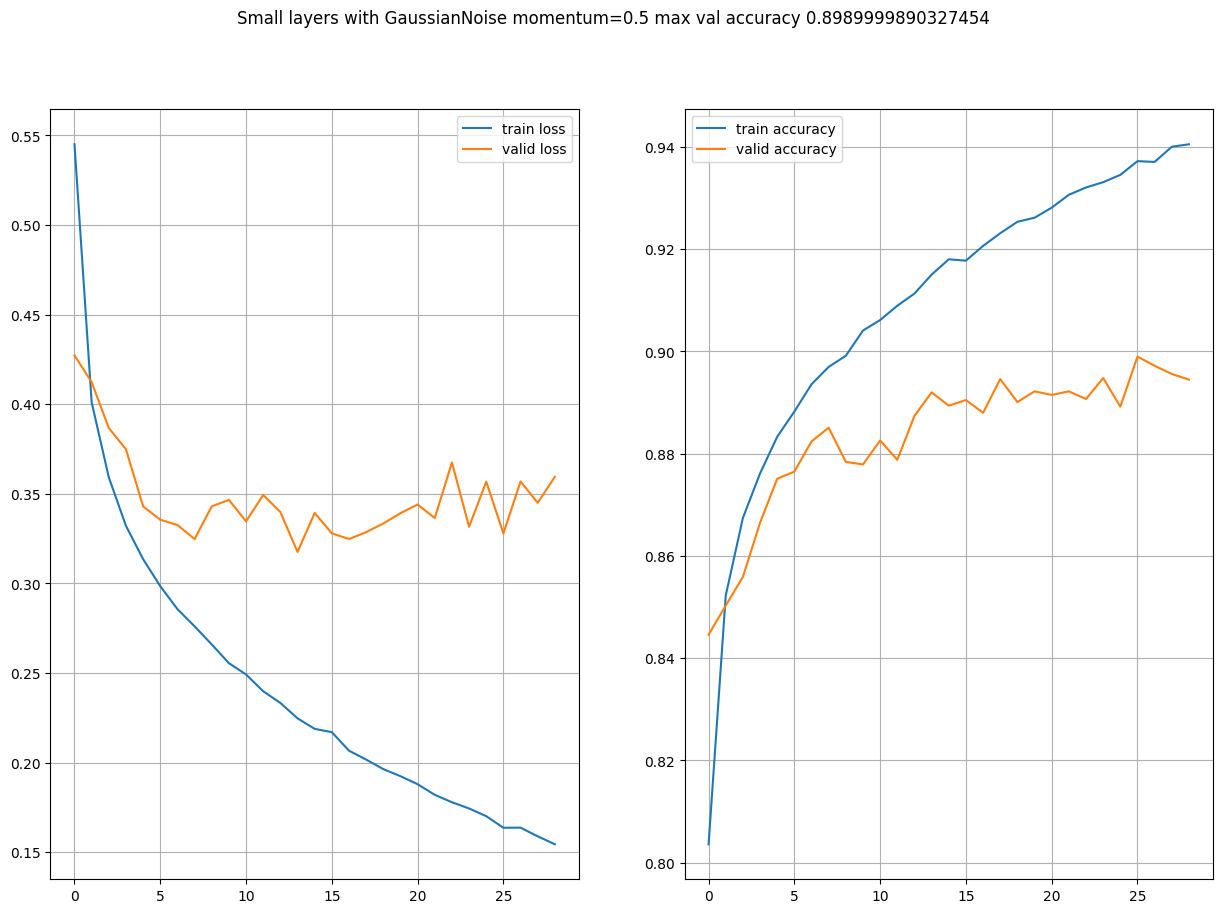

Epoch 1/100
462/469 [============================>.] - ETA: 0s - loss: 0.5246 - accuracy: 0.8095 - categorical_crossentropy: 0.5246INFO:tensorflow:Assets written to: small_la_gn_cp_41\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_41\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.5227 - accuracy: 0.8104 - categorical_crossentropy: 0.5227 - val_loss: 0.4036 - val_accuracy: 0.8550 - val_categorical_crossentropy: 0.4036
Epoch 2/100
469/469 [==============================] - ETA: 0s - loss: 0.3854 - accuracy: 0.8583 - categorical_crossentropy: 0.3854INFO:tensorflow:Assets written to: small_la_gn_cp_41\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_41\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3854 - accuracy: 0.8583 - categorical_crossentropy: 0.3854 - val_loss: 0.3864 - val_accuracy: 0.8603 - val_categorical_crossentropy: 0.3864
Epoch 3/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3472 - accuracy: 0.8712 - categorical_crossentropy: 0.3472 - val_loss: 0.3904 - val_accuracy: 0.8569 - val_categorical_crossentropy: 0.3904
Epoch 4/100
458/469 [============================>.] - ETA: 0s - loss: 0.3244 - accuracy: 0.8794 - categorical_crossentropy: 0.3244INFO:tensorflow:Assets written to: small_la_gn_cp_41\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_41\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.3254 - accuracy: 0.8790 - categorical_crossentropy: 0.3254 - val_loss: 0.3648 - val_accuracy: 0.8675 - val_categorical_crossentropy: 0.3648
Epoch 5/100
467/469 [============================>.] - ETA: 0s - loss: 0.3062 - accuracy: 0.8863 - categorical_crossentropy: 0.3062INFO:tensorflow:Assets written to: small_la_gn_cp_41\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_41\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3064 - accuracy: 0.8863 - categorical_crossentropy: 0.3064 - val_loss: 0.3586 - val_accuracy: 0.8678 - val_categorical_crossentropy: 0.3586
Epoch 6/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2941 - accuracy: 0.8895 - categorical_crossentropy: 0.2941 - val_loss: 0.3864 - val_accuracy: 0.8615 - val_categorical_crossentropy: 0.3864
Epoch 7/100
466/469 [============================>.] - ETA: 0s - loss: 0.2838 - accuracy: 0.8936 - categorical_crossentropy: 0.2838INFO:tensorflow:Assets written to: small_la_gn_cp_41\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_41\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2836 - accuracy: 0.8937 - categorical_crossentropy: 0.2836 - val_loss: 0.3242 - val_accuracy: 0.8823 - val_categorical_crossentropy: 0.3242
Epoch 8/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2721 - accuracy: 0.8980 - categorical_crossentropy: 0.2721 - val_loss: 0.3430 - val_accuracy: 0.8774 - val_categorical_crossentropy: 0.3430
Epoch 9/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2611 - accuracy: 0.9012 - categorical_crossentropy: 0.2611 - val_loss: 0.3566 - val_accuracy: 0.8770 - val_categorical_crossentropy: 0.3566
Epoch 10/100
460/469 [============================>.] - ETA: 0s - loss: 0.2535 - accuracy: 0.9061 - categorical_crossentropy: 0.2535INFO:tensorflow:Assets written to: small_la_gn_cp_41\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_41\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2539 - accuracy: 0.9061 - categorical_crossentropy: 0.2539 - val_loss: 0.3204 - val_accuracy: 0.8852 - val_categorical_crossentropy: 0.3204
Epoch 11/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2475 - accuracy: 0.9068 - categorical_crossentropy: 0.2475 - val_loss: 0.3347 - val_accuracy: 0.8834 - val_categorical_crossentropy: 0.3347
Epoch 12/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2373 - accuracy: 0.9101 - categorical_crossentropy: 0.2373 - val_loss: 0.3455 - val_accuracy: 0.8845 - val_categorical_crossentropy: 0.3455
Epoch 13/100
458/469 [============================>.] - ETA: 0s - loss: 0.2319 - accuracy: 0.9124 - categorical_crossentropy: 0.2319INFO:tensorflow:Assets written to: small_la_gn_cp_41\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_41\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2325 - accuracy: 0.9122 - categorical_crossentropy: 0.2325 - val_loss: 0.3292 - val_accuracy: 0.8872 - val_categorical_crossentropy: 0.3292
Epoch 14/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2253 - accuracy: 0.9146 - categorical_crossentropy: 0.2253 - val_loss: 0.3419 - val_accuracy: 0.8842 - val_categorical_crossentropy: 0.3419
Epoch 15/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2194 - accuracy: 0.9169 - categorical_crossentropy: 0.2194 - val_loss: 0.3443 - val_accuracy: 0.8872 - val_categorical_crossentropy: 0.3443
Epoch 16/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2142 - accuracy: 0.9191 - categorical_crossentropy: 0.2142 - val_loss: 0.3544 - val_accuracy: 0.8869 - val_categorical_crossentropy: 0.3544
Epoch 17/100
459/469 [============================>.] - ETA: 0s - loss: 0.2126 - accuracy: 0.9204 - categorical_crossentropy: 0.2126INFO:tens

INFO:tensorflow:Assets written to: small_la_gn_cp_41\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2128 - accuracy: 0.9202 - categorical_crossentropy: 0.2128 - val_loss: 0.3453 - val_accuracy: 0.8892 - val_categorical_crossentropy: 0.3453
Epoch 18/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2041 - accuracy: 0.9223 - categorical_crossentropy: 0.2041 - val_loss: 0.3511 - val_accuracy: 0.8876 - val_categorical_crossentropy: 0.3511
Epoch 19/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2009 - accuracy: 0.9238 - categorical_crossentropy: 0.2009 - val_loss: 0.3621 - val_accuracy: 0.8856 - val_categorical_crossentropy: 0.3621
Epoch 20/100
457/469 [============================>.] - ETA: 0s - loss: 0.1966 - accuracy: 0.9255 - categorical_crossentropy: 0.1966INFO:tensorflow:Assets written to: small_la_gn_cp_41\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_41\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.1961 - accuracy: 0.9256 - categorical_crossentropy: 0.1961 - val_loss: 0.3587 - val_accuracy: 0.8897 - val_categorical_crossentropy: 0.3587
Epoch 21/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1912 - accuracy: 0.9270 - categorical_crossentropy: 0.1912 - val_loss: 0.3428 - val_accuracy: 0.8890 - val_categorical_crossentropy: 0.3428
Epoch 22/100
463/469 [============================>.] - ETA: 0s - loss: 0.1884 - accuracy: 0.9299 - categorical_crossentropy: 0.1884INFO:tensorflow:Assets written to: small_la_gn_cp_41\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_41\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.1886 - accuracy: 0.9298 - categorical_crossentropy: 0.1886 - val_loss: 0.3806 - val_accuracy: 0.8921 - val_categorical_crossentropy: 0.3806
Epoch 23/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1835 - accuracy: 0.9307 - categorical_crossentropy: 0.1835 - val_loss: 0.4070 - val_accuracy: 0.8856 - val_categorical_crossentropy: 0.4070
Epoch 24/100
459/469 [============================>.] - ETA: 0s - loss: 0.1777 - accuracy: 0.9318 - categorical_crossentropy: 0.1777INFO:tensorflow:Assets written to: small_la_gn_cp_41\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_41\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.1771 - accuracy: 0.9320 - categorical_crossentropy: 0.1771 - val_loss: 0.3837 - val_accuracy: 0.8948 - val_categorical_crossentropy: 0.3837
Epoch 25/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1785 - accuracy: 0.9327 - categorical_crossentropy: 0.1785 - val_loss: 0.3785 - val_accuracy: 0.8920 - val_categorical_crossentropy: 0.3785


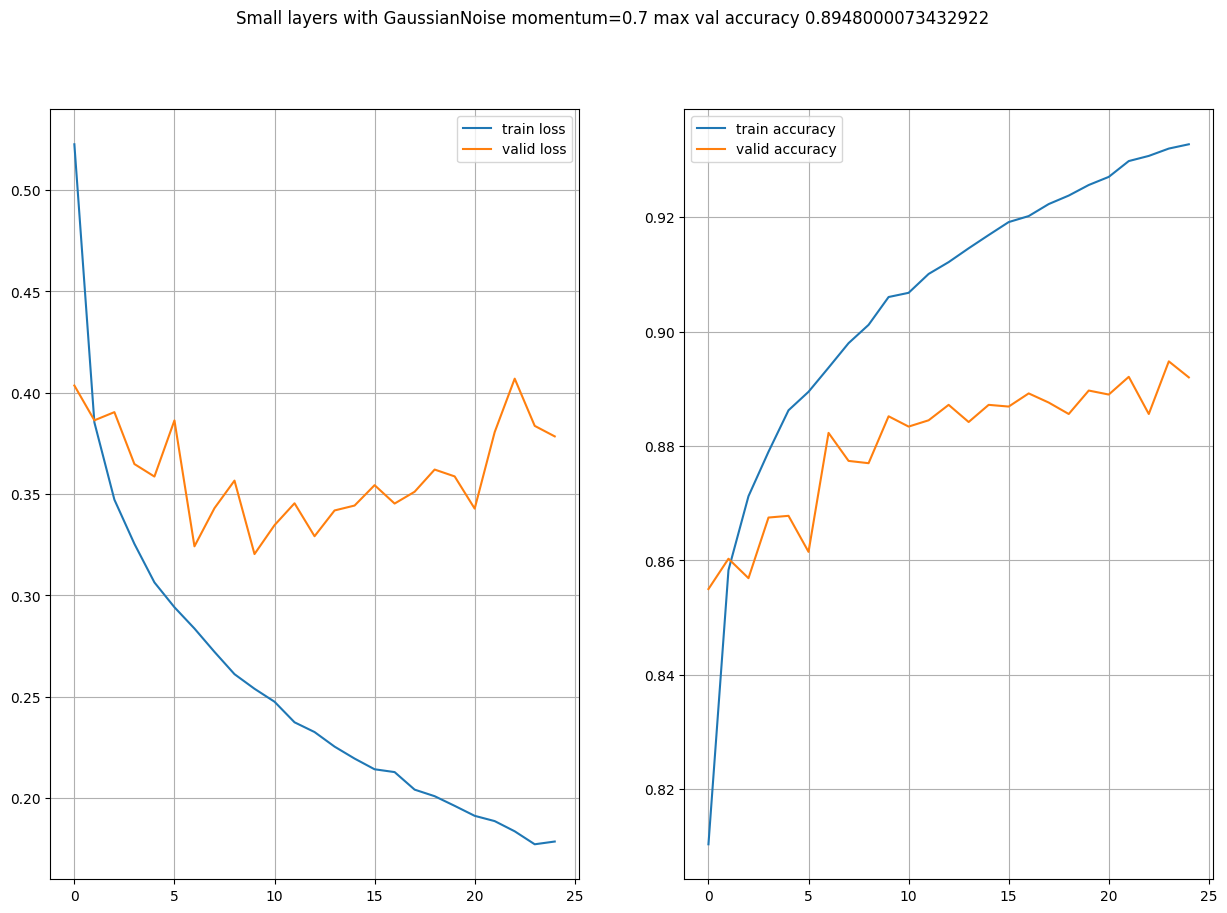

Epoch 1/100
461/469 [============================>.] - ETA: 0s - loss: 0.5503 - accuracy: 0.8036 - categorical_crossentropy: 0.5503INFO:tensorflow:Assets written to: small_la_gn_cp_42\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_42\assets


469/469 [==============================] - 6s 11ms/step - loss: 0.5492 - accuracy: 0.8041 - categorical_crossentropy: 0.5492 - val_loss: 0.4265 - val_accuracy: 0.8474 - val_categorical_crossentropy: 0.4265
Epoch 2/100
460/469 [============================>.] - ETA: 0s - loss: 0.4030 - accuracy: 0.8538 - categorical_crossentropy: 0.4030INFO:tensorflow:Assets written to: small_la_gn_cp_42\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_42\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4024 - accuracy: 0.8540 - categorical_crossentropy: 0.4024 - val_loss: 0.4173 - val_accuracy: 0.8542 - val_categorical_crossentropy: 0.4173
Epoch 3/100
468/469 [============================>.] - ETA: 0s - loss: 0.3754 - accuracy: 0.8635 - categorical_crossentropy: 0.3754INFO:tensorflow:Assets written to: small_la_gn_cp_42\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_42\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3758 - accuracy: 0.8635 - categorical_crossentropy: 0.3758 - val_loss: 0.4299 - val_accuracy: 0.8549 - val_categorical_crossentropy: 0.4299
Epoch 4/100
460/469 [============================>.] - ETA: 0s - loss: 0.3586 - accuracy: 0.8693 - categorical_crossentropy: 0.3586INFO:tensorflow:Assets written to: small_la_gn_cp_42\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_42\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3589 - accuracy: 0.8693 - categorical_crossentropy: 0.3589 - val_loss: 0.3890 - val_accuracy: 0.8642 - val_categorical_crossentropy: 0.3890
Epoch 5/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3402 - accuracy: 0.8759 - categorical_crossentropy: 0.3402 - val_loss: 0.4007 - val_accuracy: 0.8616 - val_categorical_crossentropy: 0.4007
Epoch 6/100
464/469 [============================>.] - ETA: 0s - loss: 0.3296 - accuracy: 0.8791 - categorical_crossentropy: 0.3296INFO:tensorflow:Assets written to: small_la_gn_cp_42\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_42\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.3296 - accuracy: 0.8792 - categorical_crossentropy: 0.3296 - val_loss: 0.3915 - val_accuracy: 0.8643 - val_categorical_crossentropy: 0.3915
Epoch 7/100
466/469 [============================>.] - ETA: 0s - loss: 0.3174 - accuracy: 0.8842 - categorical_crossentropy: 0.3174INFO:tensorflow:Assets written to: small_la_gn_cp_42\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_42\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3176 - accuracy: 0.8841 - categorical_crossentropy: 0.3176 - val_loss: 0.3820 - val_accuracy: 0.8697 - val_categorical_crossentropy: 0.3820
Epoch 8/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3135 - accuracy: 0.8846 - categorical_crossentropy: 0.3135 - val_loss: 0.3793 - val_accuracy: 0.8656 - val_categorical_crossentropy: 0.3793
Epoch 9/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3040 - accuracy: 0.8882 - categorical_crossentropy: 0.3040 - val_loss: 0.4160 - val_accuracy: 0.8607 - val_categorical_crossentropy: 0.4160
Epoch 10/100
461/469 [============================>.] - ETA: 0s - loss: 0.2971 - accuracy: 0.8905 - categorical_crossentropy: 0.2971INFO:tensorflow:Assets written to: small_la_gn_cp_42\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_42\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2974 - accuracy: 0.8903 - categorical_crossentropy: 0.2974 - val_loss: 0.3649 - val_accuracy: 0.8775 - val_categorical_crossentropy: 0.3649
Epoch 11/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2979 - accuracy: 0.8904 - categorical_crossentropy: 0.2979 - val_loss: 0.3943 - val_accuracy: 0.8647 - val_categorical_crossentropy: 0.3943
Epoch 12/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2876 - accuracy: 0.8948 - categorical_crossentropy: 0.2876 - val_loss: 0.4102 - val_accuracy: 0.8707 - val_categorical_crossentropy: 0.4102
Epoch 13/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2846 - accuracy: 0.8958 - categorical_crossentropy: 0.2846 - val_loss: 0.3898 - val_accuracy: 0.8767 - val_categorical_crossentropy: 0.3898
Epoch 14/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2835 - accuracy: 0.8954 - categorical_crossentropy: 0.2835 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_42\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2705 - accuracy: 0.8996 - categorical_crossentropy: 0.2705 - val_loss: 0.3972 - val_accuracy: 0.8803 - val_categorical_crossentropy: 0.3972
Epoch 18/100
466/469 [============================>.] - ETA: 0s - loss: 0.2639 - accuracy: 0.9025 - categorical_crossentropy: 0.2639INFO:tensorflow:Assets written to: small_la_gn_cp_42\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_42\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2638 - accuracy: 0.9026 - categorical_crossentropy: 0.2638 - val_loss: 0.4202 - val_accuracy: 0.8810 - val_categorical_crossentropy: 0.4202
Epoch 19/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2665 - accuracy: 0.9033 - categorical_crossentropy: 0.2665 - val_loss: 0.4280 - val_accuracy: 0.8676 - val_categorical_crossentropy: 0.4280
Epoch 20/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2646 - accuracy: 0.9029 - categorical_crossentropy: 0.2646 - val_loss: 0.4007 - val_accuracy: 0.8791 - val_categorical_crossentropy: 0.4007
Epoch 21/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2575 - accuracy: 0.9056 - categorical_crossentropy: 0.2575 - val_loss: 0.4541 - val_accuracy: 0.8791 - val_categorical_crossentropy: 0.4541
Epoch 22/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2519 - accuracy: 0.9073 - categorical_crossentropy: 0.2519 - va

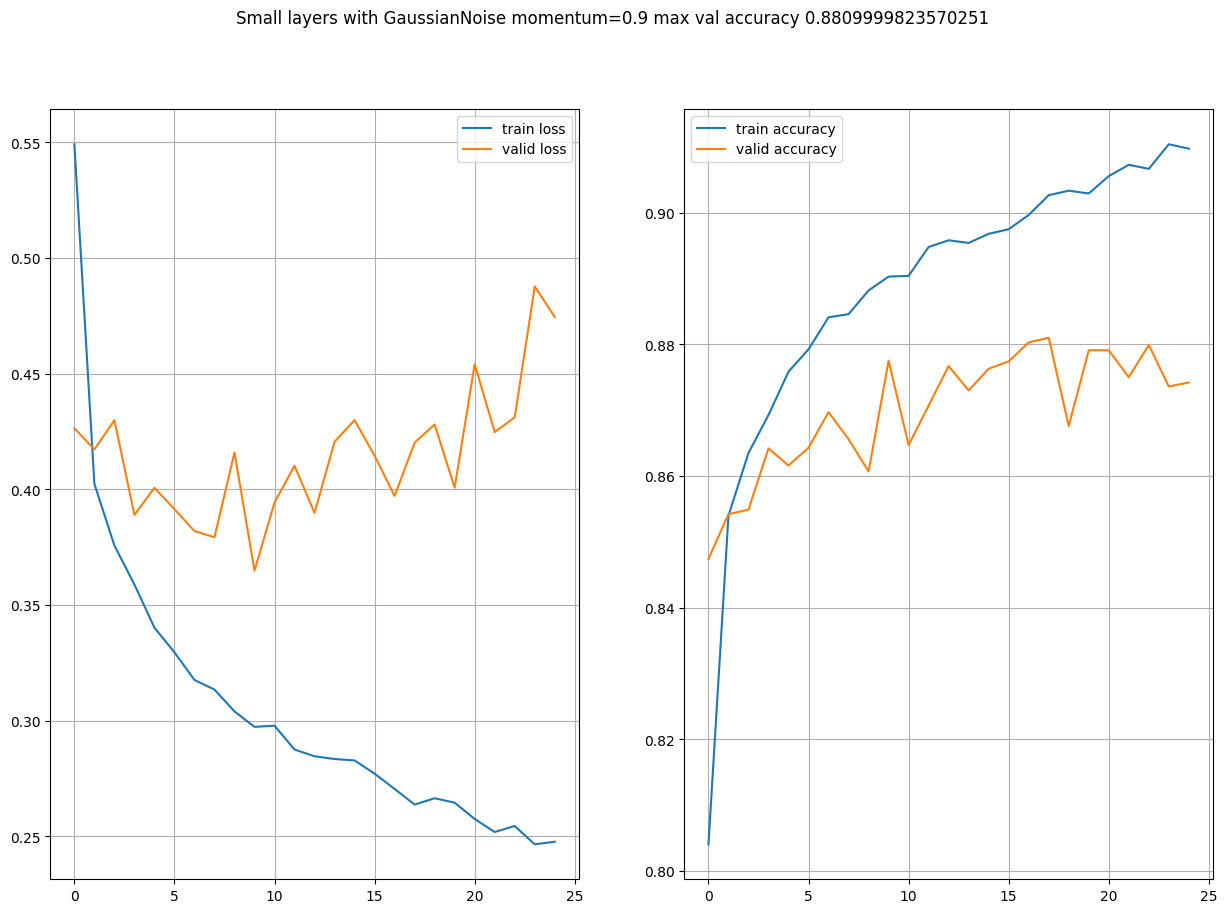

Epoch 1/100
457/469 [============================>.] - ETA: 0s - loss: 0.6229 - accuracy: 0.7891 - categorical_crossentropy: 0.6229INFO:tensorflow:Assets written to: small_la_gn_cp_43\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_43\assets


469/469 [==============================] - 5s 9ms/step - loss: 0.6193 - accuracy: 0.7903 - categorical_crossentropy: 0.6193 - val_loss: 0.4856 - val_accuracy: 0.8312 - val_categorical_crossentropy: 0.4856
Epoch 2/100
465/469 [============================>.] - ETA: 0s - loss: 0.4608 - accuracy: 0.8378 - categorical_crossentropy: 0.4608INFO:tensorflow:Assets written to: small_la_gn_cp_43\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_43\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.4607 - accuracy: 0.8378 - categorical_crossentropy: 0.4607 - val_loss: 0.4363 - val_accuracy: 0.8471 - val_categorical_crossentropy: 0.4363
Epoch 3/100
468/469 [============================>.] - ETA: 0s - loss: 0.4264 - accuracy: 0.8512 - categorical_crossentropy: 0.4264INFO:tensorflow:Assets written to: small_la_gn_cp_43\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_43\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4264 - accuracy: 0.8511 - categorical_crossentropy: 0.4264 - val_loss: 0.4253 - val_accuracy: 0.8539 - val_categorical_crossentropy: 0.4253
Epoch 4/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3999 - accuracy: 0.8589 - categorical_crossentropy: 0.3999 - val_loss: 0.4513 - val_accuracy: 0.8471 - val_categorical_crossentropy: 0.4513
Epoch 5/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3946 - accuracy: 0.8619 - categorical_crossentropy: 0.3946 - val_loss: 0.4548 - val_accuracy: 0.8500 - val_categorical_crossentropy: 0.4548
Epoch 6/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3839 - accuracy: 0.8644 - categorical_crossentropy: 0.3839 - val_loss: 0.4428 - val_accuracy: 0.8527 - val_categorical_crossentropy: 0.4428
Epoch 7/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3769 - accuracy: 0.8669 - categorical_crossentropy: 0.3769 - val_lo

INFO:tensorflow:Assets written to: small_la_gn_cp_43\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3731 - accuracy: 0.8694 - categorical_crossentropy: 0.3731 - val_loss: 0.3864 - val_accuracy: 0.8698 - val_categorical_crossentropy: 0.3864
Epoch 9/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3647 - accuracy: 0.8702 - categorical_crossentropy: 0.3647 - val_loss: 0.4477 - val_accuracy: 0.8557 - val_categorical_crossentropy: 0.4477
Epoch 10/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3708 - accuracy: 0.8698 - categorical_crossentropy: 0.3708 - val_loss: 0.4148 - val_accuracy: 0.8624 - val_categorical_crossentropy: 0.4148
Epoch 11/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3561 - accuracy: 0.8738 - categorical_crossentropy: 0.3561 - val_loss: 0.4354 - val_accuracy: 0.8617 - val_categorical_crossentropy: 0.4354
Epoch 12/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3503 - accuracy: 0.8766 - categorical_crossentropy: 0.3503 - val

INFO:tensorflow:Assets written to: small_la_gn_cp_43\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3304 - accuracy: 0.8849 - categorical_crossentropy: 0.3304 - val_loss: 0.4422 - val_accuracy: 0.8735 - val_categorical_crossentropy: 0.4422
Epoch 22/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3271 - accuracy: 0.8846 - categorical_crossentropy: 0.3271 - val_loss: 0.4416 - val_accuracy: 0.8671 - val_categorical_crossentropy: 0.4416
Epoch 23/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3213 - accuracy: 0.8869 - categorical_crossentropy: 0.3213 - val_loss: 0.4643 - val_accuracy: 0.8681 - val_categorical_crossentropy: 0.4643


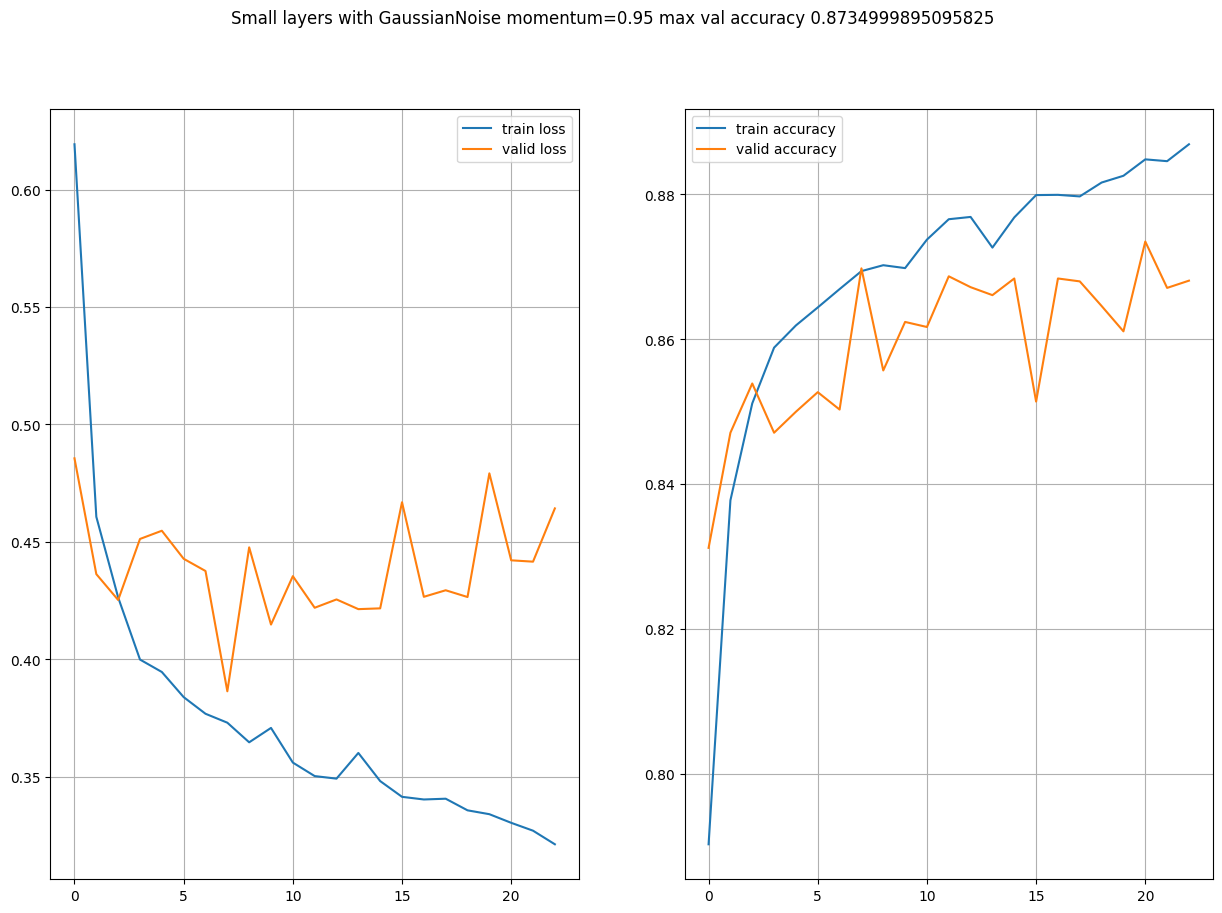

Epoch 1/100
462/469 [============================>.] - ETA: 0s - loss: 1.8222 - accuracy: 0.6495 - categorical_crossentropy: 1.8222INFO:tensorflow:Assets written to: small_la_gn_cp_44\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_44\assets


469/469 [==============================] - 5s 9ms/step - loss: 1.8142 - accuracy: 0.6503 - categorical_crossentropy: 1.8142 - val_loss: 1.0924 - val_accuracy: 0.7302 - val_categorical_crossentropy: 1.0924
Epoch 2/100
465/469 [============================>.] - ETA: 0s - loss: 1.2077 - accuracy: 0.6983 - categorical_crossentropy: 1.2077INFO:tensorflow:Assets written to: small_la_gn_cp_44\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_44\assets


469/469 [==============================] - 4s 9ms/step - loss: 1.2063 - accuracy: 0.6984 - categorical_crossentropy: 1.2063 - val_loss: 0.7744 - val_accuracy: 0.7586 - val_categorical_crossentropy: 0.7744
Epoch 3/100
465/469 [============================>.] - ETA: 0s - loss: 0.9985 - accuracy: 0.7134 - categorical_crossentropy: 0.9985INFO:tensorflow:Assets written to: small_la_gn_cp_44\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_44\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.9989 - accuracy: 0.7136 - categorical_crossentropy: 0.9989 - val_loss: 0.8719 - val_accuracy: 0.7745 - val_categorical_crossentropy: 0.8719
Epoch 4/100
462/469 [============================>.] - ETA: 0s - loss: 1.0349 - accuracy: 0.7124 - categorical_crossentropy: 1.0349INFO:tensorflow:Assets written to: small_la_gn_cp_44\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_44\assets


469/469 [==============================] - 4s 9ms/step - loss: 1.0314 - accuracy: 0.7126 - categorical_crossentropy: 1.0314 - val_loss: 0.7134 - val_accuracy: 0.7792 - val_categorical_crossentropy: 0.7134
Epoch 5/100
469/469 [==============================] - 3s 7ms/step - loss: 0.8983 - accuracy: 0.7416 - categorical_crossentropy: 0.8983 - val_loss: 0.8215 - val_accuracy: 0.7715 - val_categorical_crossentropy: 0.8215
Epoch 6/100
457/469 [============================>.] - ETA: 0s - loss: 0.8816 - accuracy: 0.7449 - categorical_crossentropy: 0.8816INFO:tensorflow:Assets written to: small_la_gn_cp_44\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_44\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.8799 - accuracy: 0.7452 - categorical_crossentropy: 0.8799 - val_loss: 0.6936 - val_accuracy: 0.7962 - val_categorical_crossentropy: 0.6936
Epoch 7/100
468/469 [============================>.] - ETA: 0s - loss: 0.9042 - accuracy: 0.7494 - categorical_crossentropy: 0.9042INFO:tensorflow:Assets written to: small_la_gn_cp_44\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_44\assets


469/469 [==============================] - 4s 10ms/step - loss: 0.9040 - accuracy: 0.7495 - categorical_crossentropy: 0.9040 - val_loss: 0.7914 - val_accuracy: 0.8011 - val_categorical_crossentropy: 0.7914
Epoch 8/100
469/469 [==============================] - 3s 7ms/step - loss: 0.9461 - accuracy: 0.7456 - categorical_crossentropy: 0.9461 - val_loss: 0.8147 - val_accuracy: 0.7779 - val_categorical_crossentropy: 0.8147
Epoch 9/100
469/469 [==============================] - 3s 6ms/step - loss: 0.9026 - accuracy: 0.7482 - categorical_crossentropy: 0.9026 - val_loss: 0.7573 - val_accuracy: 0.7892 - val_categorical_crossentropy: 0.7573
Epoch 10/100
469/469 [==============================] - 3s 6ms/step - loss: 0.8659 - accuracy: 0.7523 - categorical_crossentropy: 0.8659 - val_loss: 0.7709 - val_accuracy: 0.7887 - val_categorical_crossentropy: 0.7709
Epoch 11/100
469/469 [==============================] - 3s 6ms/step - loss: 0.8639 - accuracy: 0.7599 - categorical_crossentropy: 0.8639 - val

INFO:tensorflow:Assets written to: small_la_gn_cp_44\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.8810 - accuracy: 0.7609 - categorical_crossentropy: 0.8810 - val_loss: 1.0175 - val_accuracy: 0.8030 - val_categorical_crossentropy: 1.0175
Epoch 15/100
469/469 [==============================] - 3s 6ms/step - loss: 0.8583 - accuracy: 0.7627 - categorical_crossentropy: 0.8583 - val_loss: 0.8493 - val_accuracy: 0.7903 - val_categorical_crossentropy: 0.8493
Epoch 16/100
469/469 [==============================] - 3s 6ms/step - loss: 0.8841 - accuracy: 0.7626 - categorical_crossentropy: 0.8841 - val_loss: 0.9662 - val_accuracy: 0.7949 - val_categorical_crossentropy: 0.9662
Epoch 17/100
469/469 [==============================] - 3s 6ms/step - loss: 0.8384 - accuracy: 0.7655 - categorical_crossentropy: 0.8384 - val_loss: 0.8667 - val_accuracy: 0.7963 - val_categorical_crossentropy: 0.8667
Epoch 18/100
469/469 [==============================] - 3s 6ms/step - loss: 0.8528 - accuracy: 0.7663 - categorical_crossentropy: 0.8528 - va

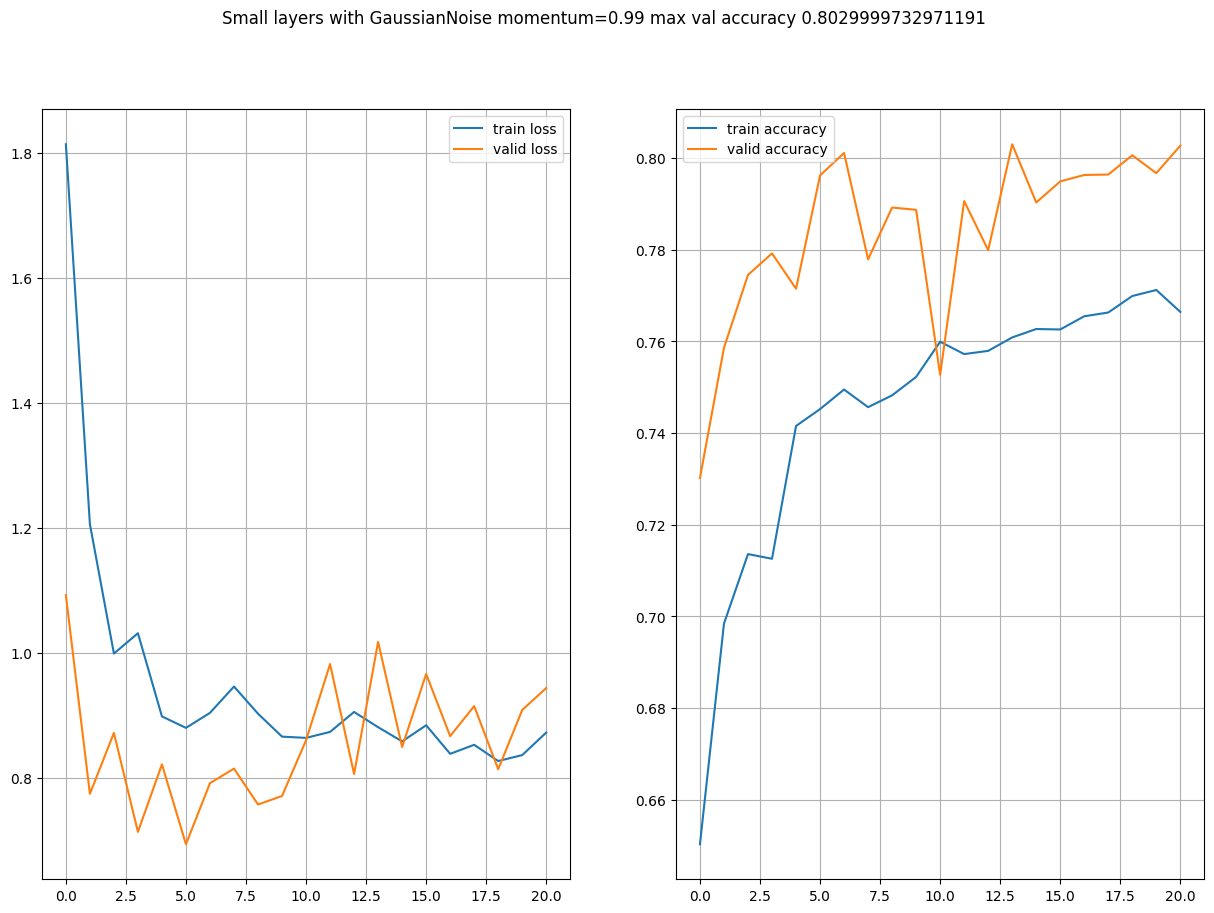

In [38]:

momentums = [.5, .7, .9, .95, .99]
idx = 40

for momentum in momentums:
    small_layers_GN = [
        Dense(128, activation="relu", input_shape=(28*28,)),
        GaussianNoise(0.2),
        Dense(512, activation="relu"),
        GaussianNoise(.2),
        Dense(10, activation="softmax"),
    ]

    small_model_GN = create_model_2(small_layers_GN, RMSprop(learning_rate=.0005, rho=.95, momentum=momentum))
    history = fit_and_present_2(small_model_GN, def_ds, val_dataset, description=f"Small layers with GaussianNoise momentum={momentum}", filepath=f"small_la_gn_cp_{idx}", patience=15)

    idx+=1

Epoch 1/100


461/469 [============================>.] - ETA: 0s - loss: 0.5989 - accuracy: 0.7850 - categorical_crossentropy: 0.5989INFO:tensorflow:Assets written to: small_la_gn_cp_50\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_50\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.5975 - accuracy: 0.7857 - categorical_crossentropy: 0.5975 - val_loss: 0.4933 - val_accuracy: 0.8201 - val_categorical_crossentropy: 0.4933
Epoch 2/100
462/469 [============================>.] - ETA: 0s - loss: 0.4681 - accuracy: 0.8323 - categorical_crossentropy: 0.4681INFO:tensorflow:Assets written to: small_la_gn_cp_50\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_50\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4675 - accuracy: 0.8326 - categorical_crossentropy: 0.4675 - val_loss: 0.4633 - val_accuracy: 0.8264 - val_categorical_crossentropy: 0.4633
Epoch 3/100
466/469 [============================>.] - ETA: 0s - loss: 0.4313 - accuracy: 0.8433 - categorical_crossentropy: 0.4313INFO:tensorflow:Assets written to: small_la_gn_cp_50\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_50\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4314 - accuracy: 0.8433 - categorical_crossentropy: 0.4314 - val_loss: 0.4360 - val_accuracy: 0.8431 - val_categorical_crossentropy: 0.4360
Epoch 4/100
462/469 [============================>.] - ETA: 0s - loss: 0.4020 - accuracy: 0.8549 - categorical_crossentropy: 0.4020INFO:tensorflow:Assets written to: small_la_gn_cp_50\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_50\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4021 - accuracy: 0.8548 - categorical_crossentropy: 0.4021 - val_loss: 0.4283 - val_accuracy: 0.8449 - val_categorical_crossentropy: 0.4283
Epoch 5/100
461/469 [============================>.] - ETA: 0s - loss: 0.3814 - accuracy: 0.8615 - categorical_crossentropy: 0.3814INFO:tensorflow:Assets written to: small_la_gn_cp_50\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_50\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3812 - accuracy: 0.8615 - categorical_crossentropy: 0.3812 - val_loss: 0.3821 - val_accuracy: 0.8640 - val_categorical_crossentropy: 0.3821
Epoch 6/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3640 - accuracy: 0.8668 - categorical_crossentropy: 0.3640 - val_loss: 0.4033 - val_accuracy: 0.8482 - val_categorical_crossentropy: 0.4033
Epoch 7/100
461/469 [============================>.] - ETA: 0s - loss: 0.3498 - accuracy: 0.8709 - categorical_crossentropy: 0.3498INFO:tensorflow:Assets written to: small_la_gn_cp_50\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_50\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.3494 - accuracy: 0.8710 - categorical_crossentropy: 0.3494 - val_loss: 0.3784 - val_accuracy: 0.8673 - val_categorical_crossentropy: 0.3784
Epoch 8/100
469/469 [==============================] - 4s 7ms/step - loss: 0.3390 - accuracy: 0.8748 - categorical_crossentropy: 0.3390 - val_loss: 0.3813 - val_accuracy: 0.8623 - val_categorical_crossentropy: 0.3813
Epoch 9/100
462/469 [============================>.] - ETA: 0s - loss: 0.3262 - accuracy: 0.8801 - categorical_crossentropy: 0.3262INFO:tensorflow:Assets written to: small_la_gn_cp_50\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_50\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3260 - accuracy: 0.8802 - categorical_crossentropy: 0.3260 - val_loss: 0.3626 - val_accuracy: 0.8699 - val_categorical_crossentropy: 0.3626
Epoch 10/100
466/469 [============================>.] - ETA: 0s - loss: 0.3173 - accuracy: 0.8830 - categorical_crossentropy: 0.3173INFO:tensorflow:Assets written to: small_la_gn_cp_50\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_50\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3172 - accuracy: 0.8831 - categorical_crossentropy: 0.3172 - val_loss: 0.3539 - val_accuracy: 0.8720 - val_categorical_crossentropy: 0.3539
Epoch 11/100
464/469 [============================>.] - ETA: 0s - loss: 0.3059 - accuracy: 0.8871 - categorical_crossentropy: 0.3059INFO:tensorflow:Assets written to: small_la_gn_cp_50\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_50\assets


469/469 [==============================] - 4s 10ms/step - loss: 0.3060 - accuracy: 0.8871 - categorical_crossentropy: 0.3060 - val_loss: 0.3525 - val_accuracy: 0.8756 - val_categorical_crossentropy: 0.3525
Epoch 12/100
469/469 [==============================] - 4s 7ms/step - loss: 0.2988 - accuracy: 0.8883 - categorical_crossentropy: 0.2988 - val_loss: 0.3592 - val_accuracy: 0.8681 - val_categorical_crossentropy: 0.3592
Epoch 13/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2920 - accuracy: 0.8920 - categorical_crossentropy: 0.2920 - val_loss: 0.3607 - val_accuracy: 0.8644 - val_categorical_crossentropy: 0.3607
Epoch 14/100
466/469 [============================>.] - ETA: 0s - loss: 0.2847 - accuracy: 0.8942 - categorical_crossentropy: 0.2847INFO:tensorflow:Assets written to: small_la_gn_cp_50\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_50\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2846 - accuracy: 0.8942 - categorical_crossentropy: 0.2846 - val_loss: 0.3409 - val_accuracy: 0.8778 - val_categorical_crossentropy: 0.3409
Epoch 15/100
462/469 [============================>.] - ETA: 0s - loss: 0.2780 - accuracy: 0.8973 - categorical_crossentropy: 0.2780INFO:tensorflow:Assets written to: small_la_gn_cp_50\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_50\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2776 - accuracy: 0.8973 - categorical_crossentropy: 0.2776 - val_loss: 0.3489 - val_accuracy: 0.8784 - val_categorical_crossentropy: 0.3489
Epoch 16/100
462/469 [============================>.] - ETA: 0s - loss: 0.2714 - accuracy: 0.8991 - categorical_crossentropy: 0.2714INFO:tensorflow:Assets written to: small_la_gn_cp_50\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_50\assets


469/469 [==============================] - 4s 10ms/step - loss: 0.2716 - accuracy: 0.8990 - categorical_crossentropy: 0.2716 - val_loss: 0.3451 - val_accuracy: 0.8797 - val_categorical_crossentropy: 0.3451
Epoch 17/100
465/469 [============================>.] - ETA: 0s - loss: 0.2655 - accuracy: 0.9012 - categorical_crossentropy: 0.2655INFO:tensorflow:Assets written to: small_la_gn_cp_50\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_50\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2653 - accuracy: 0.9012 - categorical_crossentropy: 0.2653 - val_loss: 0.3319 - val_accuracy: 0.8836 - val_categorical_crossentropy: 0.3319
Epoch 18/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2603 - accuracy: 0.9028 - categorical_crossentropy: 0.2603 - val_loss: 0.3641 - val_accuracy: 0.8675 - val_categorical_crossentropy: 0.3641
Epoch 19/100
467/469 [============================>.] - ETA: 0s - loss: 0.2561 - accuracy: 0.9043 - categorical_crossentropy: 0.2561INFO:tensorflow:Assets written to: small_la_gn_cp_50\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_50\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2561 - accuracy: 0.9043 - categorical_crossentropy: 0.2561 - val_loss: 0.3187 - val_accuracy: 0.8849 - val_categorical_crossentropy: 0.3187
Epoch 20/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2498 - accuracy: 0.9065 - categorical_crossentropy: 0.2498 - val_loss: 0.3312 - val_accuracy: 0.8842 - val_categorical_crossentropy: 0.3312
Epoch 21/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2454 - accuracy: 0.9069 - categorical_crossentropy: 0.2454 - val_loss: 0.3499 - val_accuracy: 0.8781 - val_categorical_crossentropy: 0.3499
Epoch 22/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2416 - accuracy: 0.9087 - categorical_crossentropy: 0.2416 - val_loss: 0.3373 - val_accuracy: 0.8825 - val_categorical_crossentropy: 0.3373
Epoch 23/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2375 - accuracy: 0.9107 - categorical_crossentropy: 0.2375 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_50\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2233 - accuracy: 0.9152 - categorical_crossentropy: 0.2233 - val_loss: 0.3228 - val_accuracy: 0.8864 - val_categorical_crossentropy: 0.3228
Epoch 27/100
463/469 [============================>.] - ETA: 0s - loss: 0.2192 - accuracy: 0.9187 - categorical_crossentropy: 0.2192INFO:tensorflow:Assets written to: small_la_gn_cp_50\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_50\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2190 - accuracy: 0.9188 - categorical_crossentropy: 0.2190 - val_loss: 0.3137 - val_accuracy: 0.8892 - val_categorical_crossentropy: 0.3137
Epoch 28/100
469/469 [==============================] - 4s 7ms/step - loss: 0.2158 - accuracy: 0.9190 - categorical_crossentropy: 0.2158 - val_loss: 0.3501 - val_accuracy: 0.8711 - val_categorical_crossentropy: 0.3501
Epoch 29/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2113 - accuracy: 0.9210 - categorical_crossentropy: 0.2113 - val_loss: 0.3223 - val_accuracy: 0.8880 - val_categorical_crossentropy: 0.3223
Epoch 30/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2091 - accuracy: 0.9204 - categorical_crossentropy: 0.2091 - val_loss: 0.3219 - val_accuracy: 0.8880 - val_categorical_crossentropy: 0.3219
Epoch 31/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2037 - accuracy: 0.9233 - categorical_crossentropy: 0.2037 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_50\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2007 - accuracy: 0.9245 - categorical_crossentropy: 0.2007 - val_loss: 0.3165 - val_accuracy: 0.8917 - val_categorical_crossentropy: 0.3165
Epoch 33/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1974 - accuracy: 0.9262 - categorical_crossentropy: 0.1974 - val_loss: 0.3206 - val_accuracy: 0.8916 - val_categorical_crossentropy: 0.3206
Epoch 34/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1935 - accuracy: 0.9276 - categorical_crossentropy: 0.1935 - val_loss: 0.3304 - val_accuracy: 0.8906 - val_categorical_crossentropy: 0.3304
Epoch 35/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1918 - accuracy: 0.9269 - categorical_crossentropy: 0.1918 - val_loss: 0.3314 - val_accuracy: 0.8883 - val_categorical_crossentropy: 0.3314
Epoch 36/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1889 - accuracy: 0.9285 - categorical_crossentropy: 0.1889 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_50\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.1853 - accuracy: 0.9304 - categorical_crossentropy: 0.1853 - val_loss: 0.3191 - val_accuracy: 0.8964 - val_categorical_crossentropy: 0.3191
Epoch 38/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1838 - accuracy: 0.9310 - categorical_crossentropy: 0.1838 - val_loss: 0.3189 - val_accuracy: 0.8952 - val_categorical_crossentropy: 0.3189
Epoch 39/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1792 - accuracy: 0.9322 - categorical_crossentropy: 0.1792 - val_loss: 0.3200 - val_accuracy: 0.8951 - val_categorical_crossentropy: 0.3200
Epoch 40/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1755 - accuracy: 0.9338 - categorical_crossentropy: 0.1755 - val_loss: 0.3359 - val_accuracy: 0.8872 - val_categorical_crossentropy: 0.3359
Epoch 41/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1742 - accuracy: 0.9338 - categorical_crossentropy: 0.1742 - va

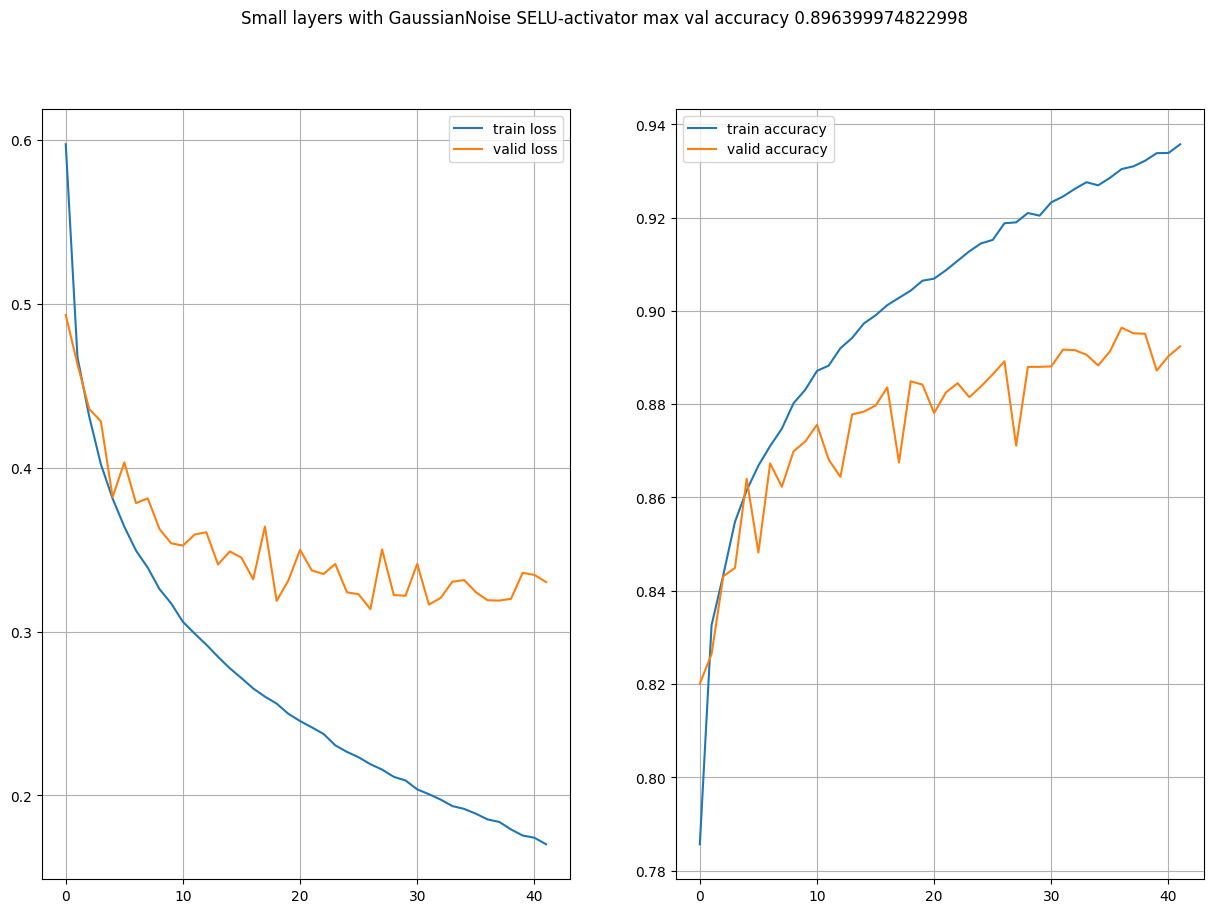

Epoch 1/100
460/469 [============================>.] - ETA: 0s - loss: 0.6014 - accuracy: 0.7818 - categorical_crossentropy: 0.6014INFO:tensorflow:Assets written to: small_la_gn_cp_51\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_51\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.5991 - accuracy: 0.7826 - categorical_crossentropy: 0.5991 - val_loss: 0.4785 - val_accuracy: 0.8318 - val_categorical_crossentropy: 0.4785
Epoch 2/100
460/469 [============================>.] - ETA: 0s - loss: 0.4678 - accuracy: 0.8307 - categorical_crossentropy: 0.4678INFO:tensorflow:Assets written to: small_la_gn_cp_51\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_51\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4681 - accuracy: 0.8304 - categorical_crossentropy: 0.4681 - val_loss: 0.4579 - val_accuracy: 0.8416 - val_categorical_crossentropy: 0.4579
Epoch 3/100
466/469 [============================>.] - ETA: 0s - loss: 0.4294 - accuracy: 0.8435 - categorical_crossentropy: 0.4294INFO:tensorflow:Assets written to: small_la_gn_cp_51\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_51\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4290 - accuracy: 0.8437 - categorical_crossentropy: 0.4290 - val_loss: 0.4221 - val_accuracy: 0.8468 - val_categorical_crossentropy: 0.4221
Epoch 4/100
466/469 [============================>.] - ETA: 0s - loss: 0.4015 - accuracy: 0.8533 - categorical_crossentropy: 0.4015INFO:tensorflow:Assets written to: small_la_gn_cp_51\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_51\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4012 - accuracy: 0.8534 - categorical_crossentropy: 0.4012 - val_loss: 0.4108 - val_accuracy: 0.8557 - val_categorical_crossentropy: 0.4108
Epoch 5/100
463/469 [============================>.] - ETA: 0s - loss: 0.3803 - accuracy: 0.8609 - categorical_crossentropy: 0.3803INFO:tensorflow:Assets written to: small_la_gn_cp_51\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_51\assets


469/469 [==============================] - 5s 11ms/step - loss: 0.3796 - accuracy: 0.8611 - categorical_crossentropy: 0.3796 - val_loss: 0.4002 - val_accuracy: 0.8566 - val_categorical_crossentropy: 0.4002
Epoch 6/100
462/469 [============================>.] - ETA: 0s - loss: 0.3624 - accuracy: 0.8671 - categorical_crossentropy: 0.3624INFO:tensorflow:Assets written to: small_la_gn_cp_51\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_51\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3625 - accuracy: 0.8670 - categorical_crossentropy: 0.3625 - val_loss: 0.3740 - val_accuracy: 0.8667 - val_categorical_crossentropy: 0.3740
Epoch 7/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3481 - accuracy: 0.8727 - categorical_crossentropy: 0.3481 - val_loss: 0.3728 - val_accuracy: 0.8657 - val_categorical_crossentropy: 0.3728
Epoch 8/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3362 - accuracy: 0.8758 - categorical_crossentropy: 0.3362 - val_loss: 0.3845 - val_accuracy: 0.8567 - val_categorical_crossentropy: 0.3845
Epoch 9/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3244 - accuracy: 0.8799 - categorical_crossentropy: 0.3244 - val_loss: 0.3754 - val_accuracy: 0.8655 - val_categorical_crossentropy: 0.3754
Epoch 10/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3142 - accuracy: 0.8834 - categorical_crossentropy: 0.3142 - val_l

INFO:tensorflow:Assets written to: small_la_gn_cp_51\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3067 - accuracy: 0.8863 - categorical_crossentropy: 0.3067 - val_loss: 0.3694 - val_accuracy: 0.8698 - val_categorical_crossentropy: 0.3694
Epoch 12/100
462/469 [============================>.] - ETA: 0s - loss: 0.2996 - accuracy: 0.8894 - categorical_crossentropy: 0.2996INFO:tensorflow:Assets written to: small_la_gn_cp_51\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_51\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2998 - accuracy: 0.8893 - categorical_crossentropy: 0.2998 - val_loss: 0.3643 - val_accuracy: 0.8704 - val_categorical_crossentropy: 0.3643
Epoch 13/100
467/469 [============================>.] - ETA: 0s - loss: 0.2926 - accuracy: 0.8919 - categorical_crossentropy: 0.2926INFO:tensorflow:Assets written to: small_la_gn_cp_51\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_51\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2924 - accuracy: 0.8919 - categorical_crossentropy: 0.2924 - val_loss: 0.3518 - val_accuracy: 0.8745 - val_categorical_crossentropy: 0.3518
Epoch 14/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2862 - accuracy: 0.8943 - categorical_crossentropy: 0.2862 - val_loss: 0.3535 - val_accuracy: 0.8736 - val_categorical_crossentropy: 0.3535
Epoch 15/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2785 - accuracy: 0.8970 - categorical_crossentropy: 0.2785 - val_loss: 0.3493 - val_accuracy: 0.8720 - val_categorical_crossentropy: 0.3493
Epoch 16/100
465/469 [============================>.] - ETA: 0s - loss: 0.2726 - accuracy: 0.8990 - categorical_crossentropy: 0.2726INFO:tensorflow:Assets written to: small_la_gn_cp_51\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_51\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2726 - accuracy: 0.8990 - categorical_crossentropy: 0.2726 - val_loss: 0.3357 - val_accuracy: 0.8813 - val_categorical_crossentropy: 0.3357
Epoch 17/100
468/469 [============================>.] - ETA: 0s - loss: 0.2669 - accuracy: 0.9007 - categorical_crossentropy: 0.2669INFO:tensorflow:Assets written to: small_la_gn_cp_51\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_51\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2669 - accuracy: 0.9007 - categorical_crossentropy: 0.2669 - val_loss: 0.3316 - val_accuracy: 0.8821 - val_categorical_crossentropy: 0.3316
Epoch 18/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2614 - accuracy: 0.9019 - categorical_crossentropy: 0.2614 - val_loss: 0.3644 - val_accuracy: 0.8717 - val_categorical_crossentropy: 0.3644
Epoch 19/100
459/469 [============================>.] - ETA: 0s - loss: 0.2568 - accuracy: 0.9039 - categorical_crossentropy: 0.2568INFO:tensorflow:Assets written to: small_la_gn_cp_51\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_51\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2571 - accuracy: 0.9038 - categorical_crossentropy: 0.2571 - val_loss: 0.3294 - val_accuracy: 0.8843 - val_categorical_crossentropy: 0.3294
Epoch 20/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2509 - accuracy: 0.9060 - categorical_crossentropy: 0.2509 - val_loss: 0.3434 - val_accuracy: 0.8792 - val_categorical_crossentropy: 0.3434
Epoch 21/100
461/469 [============================>.] - ETA: 0s - loss: 0.2462 - accuracy: 0.9084 - categorical_crossentropy: 0.2462INFO:tensorflow:Assets written to: small_la_gn_cp_51\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_51\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2457 - accuracy: 0.9086 - categorical_crossentropy: 0.2457 - val_loss: 0.3270 - val_accuracy: 0.8853 - val_categorical_crossentropy: 0.3270
Epoch 22/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2413 - accuracy: 0.9097 - categorical_crossentropy: 0.2413 - val_loss: 0.3255 - val_accuracy: 0.8852 - val_categorical_crossentropy: 0.3255
Epoch 23/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2383 - accuracy: 0.9101 - categorical_crossentropy: 0.2383 - val_loss: 0.3319 - val_accuracy: 0.8846 - val_categorical_crossentropy: 0.3319
Epoch 24/100
461/469 [============================>.] - ETA: 0s - loss: 0.2337 - accuracy: 0.9119 - categorical_crossentropy: 0.2337INFO:tensorflow:Assets written to: small_la_gn_cp_51\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_51\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2335 - accuracy: 0.9120 - categorical_crossentropy: 0.2335 - val_loss: 0.3288 - val_accuracy: 0.8855 - val_categorical_crossentropy: 0.3288
Epoch 25/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2294 - accuracy: 0.9139 - categorical_crossentropy: 0.2294 - val_loss: 0.3340 - val_accuracy: 0.8821 - val_categorical_crossentropy: 0.3340
Epoch 26/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2255 - accuracy: 0.9152 - categorical_crossentropy: 0.2255 - val_loss: 0.3365 - val_accuracy: 0.8835 - val_categorical_crossentropy: 0.3365
Epoch 27/100
458/469 [============================>.] - ETA: 0s - loss: 0.2216 - accuracy: 0.9166 - categorical_crossentropy: 0.2216INFO:tensorflow:Assets written to: small_la_gn_cp_51\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_51\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2217 - accuracy: 0.9165 - categorical_crossentropy: 0.2217 - val_loss: 0.3276 - val_accuracy: 0.8884 - val_categorical_crossentropy: 0.3276
Epoch 28/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2162 - accuracy: 0.9192 - categorical_crossentropy: 0.2162 - val_loss: 0.3443 - val_accuracy: 0.8828 - val_categorical_crossentropy: 0.3443
Epoch 29/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2119 - accuracy: 0.9203 - categorical_crossentropy: 0.2119 - val_loss: 0.3364 - val_accuracy: 0.8875 - val_categorical_crossentropy: 0.3364
Epoch 30/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2095 - accuracy: 0.9215 - categorical_crossentropy: 0.2095 - val_loss: 0.3416 - val_accuracy: 0.8849 - val_categorical_crossentropy: 0.3416
Epoch 31/100
464/469 [============================>.] - ETA: 0s - loss: 0.2055 - accuracy: 0.9219 - categorical_crossentropy: 0.2055INFO:tens

INFO:tensorflow:Assets written to: small_la_gn_cp_51\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2057 - accuracy: 0.9219 - categorical_crossentropy: 0.2057 - val_loss: 0.3217 - val_accuracy: 0.8928 - val_categorical_crossentropy: 0.3217
Epoch 32/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2022 - accuracy: 0.9235 - categorical_crossentropy: 0.2022 - val_loss: 0.3359 - val_accuracy: 0.8819 - val_categorical_crossentropy: 0.3359
Epoch 33/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1997 - accuracy: 0.9243 - categorical_crossentropy: 0.1997 - val_loss: 0.3196 - val_accuracy: 0.8899 - val_categorical_crossentropy: 0.3196
Epoch 34/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1970 - accuracy: 0.9255 - categorical_crossentropy: 0.1970 - val_loss: 0.3304 - val_accuracy: 0.8882 - val_categorical_crossentropy: 0.3304
Epoch 35/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1928 - accuracy: 0.9278 - categorical_crossentropy: 0.1928 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_51\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.1754 - accuracy: 0.9337 - categorical_crossentropy: 0.1754 - val_loss: 0.3210 - val_accuracy: 0.8935 - val_categorical_crossentropy: 0.3210
Epoch 42/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1720 - accuracy: 0.9347 - categorical_crossentropy: 0.1720 - val_loss: 0.3551 - val_accuracy: 0.8827 - val_categorical_crossentropy: 0.3551
Epoch 43/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1698 - accuracy: 0.9351 - categorical_crossentropy: 0.1698 - val_loss: 0.3705 - val_accuracy: 0.8811 - val_categorical_crossentropy: 0.3705
Epoch 44/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1663 - accuracy: 0.9368 - categorical_crossentropy: 0.1663 - val_loss: 0.3462 - val_accuracy: 0.8898 - val_categorical_crossentropy: 0.3462
Epoch 45/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1632 - accuracy: 0.9387 - categorical_crossentropy: 0.1632 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_51\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.1583 - accuracy: 0.9402 - categorical_crossentropy: 0.1583 - val_loss: 0.3350 - val_accuracy: 0.8946 - val_categorical_crossentropy: 0.3350
Epoch 48/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1551 - accuracy: 0.9412 - categorical_crossentropy: 0.1551 - val_loss: 0.3611 - val_accuracy: 0.8872 - val_categorical_crossentropy: 0.3611


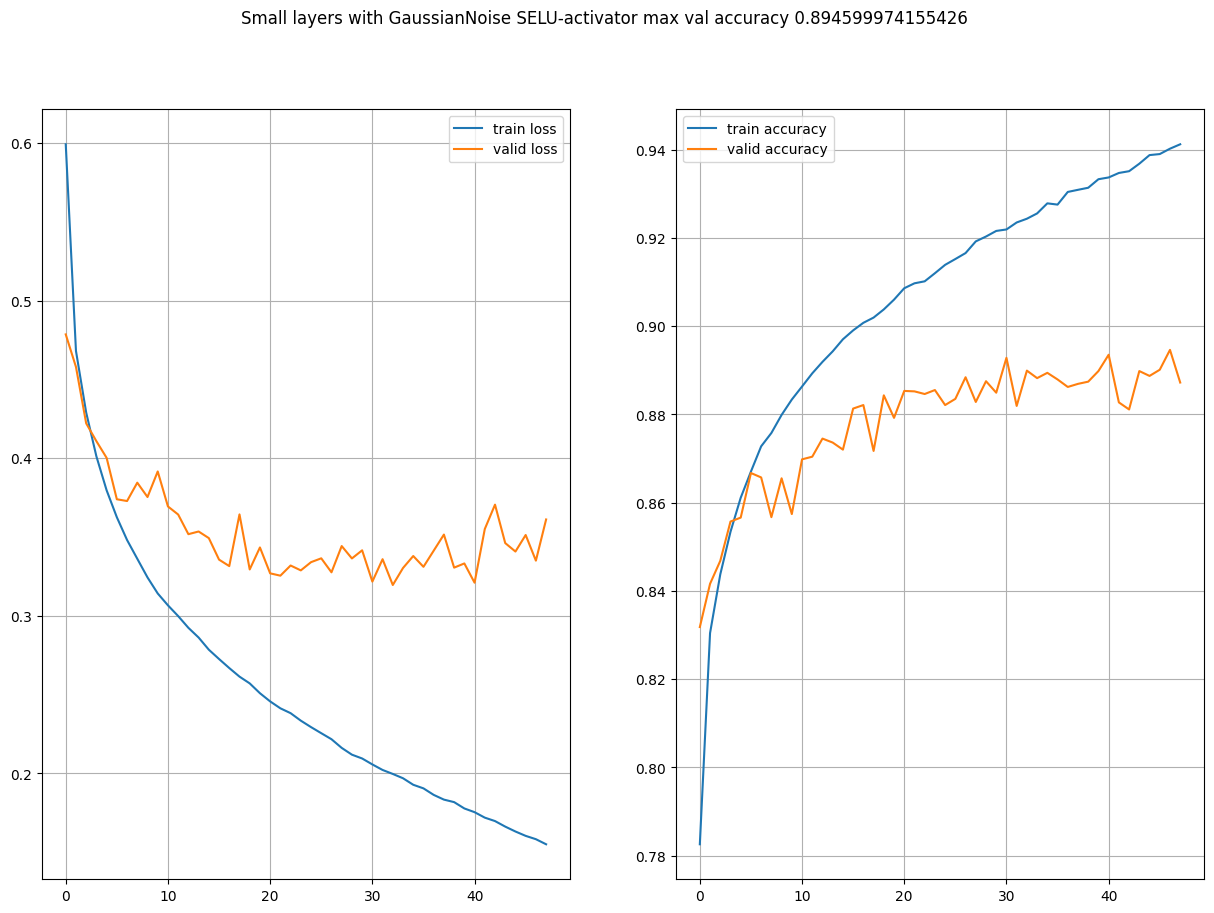

Epoch 1/100
463/469 [============================>.] - ETA: 0s - loss: 0.6044 - accuracy: 0.7828 - categorical_crossentropy: 0.6044INFO:tensorflow:Assets written to: small_la_gn_cp_52\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_52\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.6026 - accuracy: 0.7835 - categorical_crossentropy: 0.6026 - val_loss: 0.4750 - val_accuracy: 0.8287 - val_categorical_crossentropy: 0.4750
Epoch 2/100
467/469 [============================>.] - ETA: 0s - loss: 0.4701 - accuracy: 0.8308 - categorical_crossentropy: 0.4701INFO:tensorflow:Assets written to: small_la_gn_cp_52\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_52\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4702 - accuracy: 0.8306 - categorical_crossentropy: 0.4702 - val_loss: 0.4666 - val_accuracy: 0.8309 - val_categorical_crossentropy: 0.4666
Epoch 3/100
468/469 [============================>.] - ETA: 0s - loss: 0.4287 - accuracy: 0.8445 - categorical_crossentropy: 0.4287INFO:tensorflow:Assets written to: small_la_gn_cp_52\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_52\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.4287 - accuracy: 0.8445 - categorical_crossentropy: 0.4287 - val_loss: 0.4248 - val_accuracy: 0.8514 - val_categorical_crossentropy: 0.4248
Epoch 4/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3999 - accuracy: 0.8554 - categorical_crossentropy: 0.3999 - val_loss: 0.4294 - val_accuracy: 0.8429 - val_categorical_crossentropy: 0.4294
Epoch 5/100
464/469 [============================>.] - ETA: 0s - loss: 0.3810 - accuracy: 0.8607 - categorical_crossentropy: 0.3810INFO:tensorflow:Assets written to: small_la_gn_cp_52\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_52\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.3807 - accuracy: 0.8608 - categorical_crossentropy: 0.3807 - val_loss: 0.4091 - val_accuracy: 0.8562 - val_categorical_crossentropy: 0.4091
Epoch 6/100
460/469 [============================>.] - ETA: 0s - loss: 0.3643 - accuracy: 0.8658 - categorical_crossentropy: 0.3643INFO:tensorflow:Assets written to: small_la_gn_cp_52\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_52\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3647 - accuracy: 0.8657 - categorical_crossentropy: 0.3647 - val_loss: 0.3915 - val_accuracy: 0.8577 - val_categorical_crossentropy: 0.3915
Epoch 7/100
468/469 [============================>.] - ETA: 0s - loss: 0.3510 - accuracy: 0.8710 - categorical_crossentropy: 0.3510INFO:tensorflow:Assets written to: small_la_gn_cp_52\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_52\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3510 - accuracy: 0.8710 - categorical_crossentropy: 0.3510 - val_loss: 0.3821 - val_accuracy: 0.8596 - val_categorical_crossentropy: 0.3821
Epoch 8/100
464/469 [============================>.] - ETA: 0s - loss: 0.3373 - accuracy: 0.8753 - categorical_crossentropy: 0.3373INFO:tensorflow:Assets written to: small_la_gn_cp_52\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_52\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3372 - accuracy: 0.8755 - categorical_crossentropy: 0.3372 - val_loss: 0.3786 - val_accuracy: 0.8666 - val_categorical_crossentropy: 0.3786
Epoch 9/100
469/469 [==============================] - ETA: 0s - loss: 0.3277 - accuracy: 0.8795 - categorical_crossentropy: 0.3277INFO:tensorflow:Assets written to: small_la_gn_cp_52\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_52\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3277 - accuracy: 0.8795 - categorical_crossentropy: 0.3277 - val_loss: 0.3573 - val_accuracy: 0.8695 - val_categorical_crossentropy: 0.3573
Epoch 10/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3171 - accuracy: 0.8829 - categorical_crossentropy: 0.3171 - val_loss: 0.4158 - val_accuracy: 0.8408 - val_categorical_crossentropy: 0.4158
Epoch 11/100
465/469 [============================>.] - ETA: 0s - loss: 0.3062 - accuracy: 0.8869 - categorical_crossentropy: 0.3062INFO:tensorflow:Assets written to: small_la_gn_cp_52\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_52\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.3059 - accuracy: 0.8871 - categorical_crossentropy: 0.3059 - val_loss: 0.3497 - val_accuracy: 0.8763 - val_categorical_crossentropy: 0.3497
Epoch 12/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3001 - accuracy: 0.8897 - categorical_crossentropy: 0.3001 - val_loss: 0.3495 - val_accuracy: 0.8734 - val_categorical_crossentropy: 0.3495
Epoch 13/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2935 - accuracy: 0.8914 - categorical_crossentropy: 0.2935 - val_loss: 0.3483 - val_accuracy: 0.8728 - val_categorical_crossentropy: 0.3483
Epoch 14/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2851 - accuracy: 0.8937 - categorical_crossentropy: 0.2851 - val_loss: 0.3554 - val_accuracy: 0.8711 - val_categorical_crossentropy: 0.3554
Epoch 15/100
468/469 [============================>.] - ETA: 0s - loss: 0.2799 - accuracy: 0.8960 - categorical_crossentropy: 0.2799INFO:tens

INFO:tensorflow:Assets written to: small_la_gn_cp_52\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2798 - accuracy: 0.8961 - categorical_crossentropy: 0.2798 - val_loss: 0.3354 - val_accuracy: 0.8799 - val_categorical_crossentropy: 0.3354
Epoch 16/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2727 - accuracy: 0.8981 - categorical_crossentropy: 0.2727 - val_loss: 0.3377 - val_accuracy: 0.8790 - val_categorical_crossentropy: 0.3377
Epoch 17/100
460/469 [============================>.] - ETA: 0s - loss: 0.2693 - accuracy: 0.9008 - categorical_crossentropy: 0.2693INFO:tensorflow:Assets written to: small_la_gn_cp_52\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_52\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2692 - accuracy: 0.9008 - categorical_crossentropy: 0.2692 - val_loss: 0.3281 - val_accuracy: 0.8848 - val_categorical_crossentropy: 0.3281
Epoch 18/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2612 - accuracy: 0.9029 - categorical_crossentropy: 0.2612 - val_loss: 0.3488 - val_accuracy: 0.8776 - val_categorical_crossentropy: 0.3488
Epoch 19/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2573 - accuracy: 0.9040 - categorical_crossentropy: 0.2573 - val_loss: 0.3381 - val_accuracy: 0.8817 - val_categorical_crossentropy: 0.3381
Epoch 20/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2511 - accuracy: 0.9058 - categorical_crossentropy: 0.2511 - val_loss: 0.3485 - val_accuracy: 0.8770 - val_categorical_crossentropy: 0.3485
Epoch 21/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2471 - accuracy: 0.9080 - categorical_crossentropy: 0.2471 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_52\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.2263 - accuracy: 0.9146 - categorical_crossentropy: 0.2263 - val_loss: 0.3252 - val_accuracy: 0.8849 - val_categorical_crossentropy: 0.3252
Epoch 27/100
466/469 [============================>.] - ETA: 0s - loss: 0.2219 - accuracy: 0.9168 - categorical_crossentropy: 0.2219INFO:tensorflow:Assets written to: small_la_gn_cp_52\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_52\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2218 - accuracy: 0.9169 - categorical_crossentropy: 0.2218 - val_loss: 0.3211 - val_accuracy: 0.8854 - val_categorical_crossentropy: 0.3211
Epoch 28/100
468/469 [============================>.] - ETA: 0s - loss: 0.2194 - accuracy: 0.9181 - categorical_crossentropy: 0.2194INFO:tensorflow:Assets written to: small_la_gn_cp_52\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_52\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2192 - accuracy: 0.9181 - categorical_crossentropy: 0.2192 - val_loss: 0.3231 - val_accuracy: 0.8866 - val_categorical_crossentropy: 0.3231
Epoch 29/100
469/469 [==============================] - 4s 7ms/step - loss: 0.2144 - accuracy: 0.9196 - categorical_crossentropy: 0.2144 - val_loss: 0.3363 - val_accuracy: 0.8865 - val_categorical_crossentropy: 0.3363
Epoch 30/100
464/469 [============================>.] - ETA: 0s - loss: 0.2122 - accuracy: 0.9199 - categorical_crossentropy: 0.2122INFO:tensorflow:Assets written to: small_la_gn_cp_52\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_52\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2120 - accuracy: 0.9200 - categorical_crossentropy: 0.2120 - val_loss: 0.3245 - val_accuracy: 0.8876 - val_categorical_crossentropy: 0.3245
Epoch 31/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2075 - accuracy: 0.9222 - categorical_crossentropy: 0.2075 - val_loss: 0.3360 - val_accuracy: 0.8873 - val_categorical_crossentropy: 0.3360
Epoch 32/100
463/469 [============================>.] - ETA: 0s - loss: 0.2063 - accuracy: 0.9227 - categorical_crossentropy: 0.2063INFO:tensorflow:Assets written to: small_la_gn_cp_52\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_52\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2059 - accuracy: 0.9228 - categorical_crossentropy: 0.2059 - val_loss: 0.3131 - val_accuracy: 0.8917 - val_categorical_crossentropy: 0.3131
Epoch 33/100
467/469 [============================>.] - ETA: 0s - loss: 0.2008 - accuracy: 0.9249 - categorical_crossentropy: 0.2008INFO:tensorflow:Assets written to: small_la_gn_cp_52\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_52\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2007 - accuracy: 0.9250 - categorical_crossentropy: 0.2007 - val_loss: 0.3273 - val_accuracy: 0.8934 - val_categorical_crossentropy: 0.3273
Epoch 34/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1965 - accuracy: 0.9262 - categorical_crossentropy: 0.1965 - val_loss: 0.3196 - val_accuracy: 0.8908 - val_categorical_crossentropy: 0.3196
Epoch 35/100
469/469 [==============================] - ETA: 0s - loss: 0.1932 - accuracy: 0.9270 - categorical_crossentropy: 0.1932INFO:tensorflow:Assets written to: small_la_gn_cp_52\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_52\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.1932 - accuracy: 0.9270 - categorical_crossentropy: 0.1932 - val_loss: 0.3213 - val_accuracy: 0.8951 - val_categorical_crossentropy: 0.3213
Epoch 36/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1903 - accuracy: 0.9292 - categorical_crossentropy: 0.1903 - val_loss: 0.3227 - val_accuracy: 0.8930 - val_categorical_crossentropy: 0.3227
Epoch 37/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1872 - accuracy: 0.9282 - categorical_crossentropy: 0.1872 - val_loss: 0.3231 - val_accuracy: 0.8933 - val_categorical_crossentropy: 0.3231
Epoch 38/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1858 - accuracy: 0.9297 - categorical_crossentropy: 0.1858 - val_loss: 0.3440 - val_accuracy: 0.8879 - val_categorical_crossentropy: 0.3440
Epoch 39/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1824 - accuracy: 0.9309 - categorical_crossentropy: 0.1824 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_52\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.1708 - accuracy: 0.9357 - categorical_crossentropy: 0.1708 - val_loss: 0.3299 - val_accuracy: 0.8960 - val_categorical_crossentropy: 0.3299
Epoch 44/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1667 - accuracy: 0.9376 - categorical_crossentropy: 0.1667 - val_loss: 0.3386 - val_accuracy: 0.8929 - val_categorical_crossentropy: 0.3386
Epoch 45/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1633 - accuracy: 0.9389 - categorical_crossentropy: 0.1633 - val_loss: 0.3409 - val_accuracy: 0.8935 - val_categorical_crossentropy: 0.3409
Epoch 46/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1629 - accuracy: 0.9384 - categorical_crossentropy: 0.1629 - val_loss: 0.3438 - val_accuracy: 0.8926 - val_categorical_crossentropy: 0.3438
Epoch 47/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1599 - accuracy: 0.9402 - categorical_crossentropy: 0.1599 - va

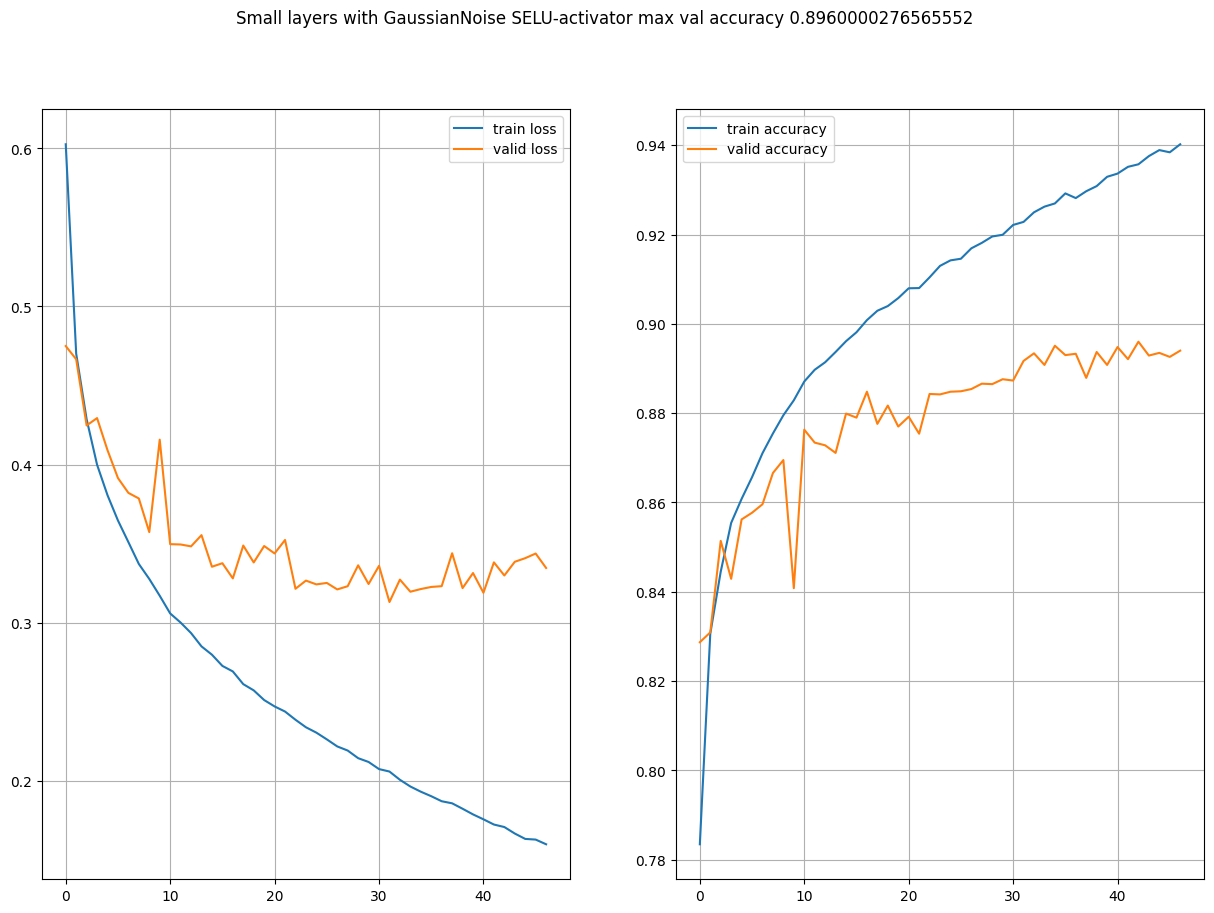

Epoch 1/100
463/469 [============================>.] - ETA: 0s - loss: 0.5939 - accuracy: 0.7860 - categorical_crossentropy: 0.5939INFO:tensorflow:Assets written to: small_la_gn_cp_53\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_53\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.5928 - accuracy: 0.7864 - categorical_crossentropy: 0.5928 - val_loss: 0.5173 - val_accuracy: 0.8130 - val_categorical_crossentropy: 0.5173
Epoch 2/100
460/469 [============================>.] - ETA: 0s - loss: 0.4646 - accuracy: 0.8328 - categorical_crossentropy: 0.4646INFO:tensorflow:Assets written to: small_la_gn_cp_53\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_53\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4636 - accuracy: 0.8329 - categorical_crossentropy: 0.4636 - val_loss: 0.4871 - val_accuracy: 0.8173 - val_categorical_crossentropy: 0.4871
Epoch 3/100
461/469 [============================>.] - ETA: 0s - loss: 0.4280 - accuracy: 0.8457 - categorical_crossentropy: 0.4280INFO:tensorflow:Assets written to: small_la_gn_cp_53\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_53\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.4276 - accuracy: 0.8461 - categorical_crossentropy: 0.4276 - val_loss: 0.4278 - val_accuracy: 0.8424 - val_categorical_crossentropy: 0.4278
Epoch 4/100
466/469 [============================>.] - ETA: 0s - loss: 0.3973 - accuracy: 0.8533 - categorical_crossentropy: 0.3973INFO:tensorflow:Assets written to: small_la_gn_cp_53\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_53\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3971 - accuracy: 0.8533 - categorical_crossentropy: 0.3971 - val_loss: 0.4164 - val_accuracy: 0.8492 - val_categorical_crossentropy: 0.4164
Epoch 5/100
465/469 [============================>.] - ETA: 0s - loss: 0.3778 - accuracy: 0.8619 - categorical_crossentropy: 0.3778INFO:tensorflow:Assets written to: small_la_gn_cp_53\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_53\assets


469/469 [==============================] - 4s 10ms/step - loss: 0.3782 - accuracy: 0.8617 - categorical_crossentropy: 0.3782 - val_loss: 0.3794 - val_accuracy: 0.8633 - val_categorical_crossentropy: 0.3794
Epoch 6/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3596 - accuracy: 0.8678 - categorical_crossentropy: 0.3596 - val_loss: 0.4072 - val_accuracy: 0.8532 - val_categorical_crossentropy: 0.4072
Epoch 7/100
459/469 [============================>.] - ETA: 0s - loss: 0.3457 - accuracy: 0.8729 - categorical_crossentropy: 0.3457INFO:tensorflow:Assets written to: small_la_gn_cp_53\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_53\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3458 - accuracy: 0.8729 - categorical_crossentropy: 0.3458 - val_loss: 0.3731 - val_accuracy: 0.8650 - val_categorical_crossentropy: 0.3731
Epoch 8/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3339 - accuracy: 0.8764 - categorical_crossentropy: 0.3339 - val_loss: 0.4153 - val_accuracy: 0.8473 - val_categorical_crossentropy: 0.4153
Epoch 9/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3238 - accuracy: 0.8803 - categorical_crossentropy: 0.3238 - val_loss: 0.3801 - val_accuracy: 0.8624 - val_categorical_crossentropy: 0.3801
Epoch 10/100
460/469 [============================>.] - ETA: 0s - loss: 0.3132 - accuracy: 0.8839 - categorical_crossentropy: 0.3132INFO:tensorflow:Assets written to: small_la_gn_cp_53\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_53\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3132 - accuracy: 0.8841 - categorical_crossentropy: 0.3132 - val_loss: 0.3472 - val_accuracy: 0.8744 - val_categorical_crossentropy: 0.3472
Epoch 11/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3049 - accuracy: 0.8873 - categorical_crossentropy: 0.3049 - val_loss: 0.3548 - val_accuracy: 0.8655 - val_categorical_crossentropy: 0.3548
Epoch 12/100
464/469 [============================>.] - ETA: 0s - loss: 0.2981 - accuracy: 0.8882 - categorical_crossentropy: 0.2981INFO:tensorflow:Assets written to: small_la_gn_cp_53\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_53\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2983 - accuracy: 0.8883 - categorical_crossentropy: 0.2983 - val_loss: 0.3623 - val_accuracy: 0.8746 - val_categorical_crossentropy: 0.3623
Epoch 13/100
461/469 [============================>.] - ETA: 0s - loss: 0.2892 - accuracy: 0.8919 - categorical_crossentropy: 0.2892INFO:tensorflow:Assets written to: small_la_gn_cp_53\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_53\assets


469/469 [==============================] - 4s 10ms/step - loss: 0.2899 - accuracy: 0.8917 - categorical_crossentropy: 0.2899 - val_loss: 0.3414 - val_accuracy: 0.8796 - val_categorical_crossentropy: 0.3414
Epoch 14/100
469/469 [==============================] - 4s 7ms/step - loss: 0.2836 - accuracy: 0.8942 - categorical_crossentropy: 0.2836 - val_loss: 0.3423 - val_accuracy: 0.8756 - val_categorical_crossentropy: 0.3423
Epoch 15/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2784 - accuracy: 0.8962 - categorical_crossentropy: 0.2784 - val_loss: 0.3402 - val_accuracy: 0.8794 - val_categorical_crossentropy: 0.3402
Epoch 16/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2722 - accuracy: 0.8991 - categorical_crossentropy: 0.2722 - val_loss: 0.3561 - val_accuracy: 0.8703 - val_categorical_crossentropy: 0.3561
Epoch 17/100
466/469 [============================>.] - ETA: 0s - loss: 0.2672 - accuracy: 0.8993 - categorical_crossentropy: 0.2672INFO:ten

INFO:tensorflow:Assets written to: small_la_gn_cp_53\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.2674 - accuracy: 0.8993 - categorical_crossentropy: 0.2674 - val_loss: 0.3322 - val_accuracy: 0.8807 - val_categorical_crossentropy: 0.3322
Epoch 18/100
463/469 [============================>.] - ETA: 0s - loss: 0.2615 - accuracy: 0.9020 - categorical_crossentropy: 0.2615INFO:tensorflow:Assets written to: small_la_gn_cp_53\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_53\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2610 - accuracy: 0.9023 - categorical_crossentropy: 0.2610 - val_loss: 0.3270 - val_accuracy: 0.8851 - val_categorical_crossentropy: 0.3270
Epoch 19/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2564 - accuracy: 0.9035 - categorical_crossentropy: 0.2564 - val_loss: 0.3306 - val_accuracy: 0.8836 - val_categorical_crossentropy: 0.3306
Epoch 20/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2509 - accuracy: 0.9063 - categorical_crossentropy: 0.2509 - val_loss: 0.3323 - val_accuracy: 0.8795 - val_categorical_crossentropy: 0.3323
Epoch 21/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2458 - accuracy: 0.9075 - categorical_crossentropy: 0.2458 - val_loss: 0.3406 - val_accuracy: 0.8810 - val_categorical_crossentropy: 0.3406
Epoch 22/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2413 - accuracy: 0.9091 - categorical_crossentropy: 0.2413 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_53\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2369 - accuracy: 0.9112 - categorical_crossentropy: 0.2369 - val_loss: 0.3238 - val_accuracy: 0.8862 - val_categorical_crossentropy: 0.3238
Epoch 24/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2330 - accuracy: 0.9141 - categorical_crossentropy: 0.2330 - val_loss: 0.3444 - val_accuracy: 0.8812 - val_categorical_crossentropy: 0.3444
Epoch 25/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2297 - accuracy: 0.9134 - categorical_crossentropy: 0.2297 - val_loss: 0.3240 - val_accuracy: 0.8845 - val_categorical_crossentropy: 0.3240
Epoch 26/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2251 - accuracy: 0.9168 - categorical_crossentropy: 0.2251 - val_loss: 0.3206 - val_accuracy: 0.8861 - val_categorical_crossentropy: 0.3206
Epoch 27/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2199 - accuracy: 0.9173 - categorical_crossentropy: 0.2199 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_53\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2135 - accuracy: 0.9199 - categorical_crossentropy: 0.2135 - val_loss: 0.3187 - val_accuracy: 0.8946 - val_categorical_crossentropy: 0.3187
Epoch 30/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2098 - accuracy: 0.9211 - categorical_crossentropy: 0.2098 - val_loss: 0.3311 - val_accuracy: 0.8864 - val_categorical_crossentropy: 0.3311
Epoch 31/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2057 - accuracy: 0.9227 - categorical_crossentropy: 0.2057 - val_loss: 0.3259 - val_accuracy: 0.8878 - val_categorical_crossentropy: 0.3259
Epoch 32/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2019 - accuracy: 0.9233 - categorical_crossentropy: 0.2019 - val_loss: 0.3317 - val_accuracy: 0.8893 - val_categorical_crossentropy: 0.3317
Epoch 33/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1978 - accuracy: 0.9259 - categorical_crossentropy: 0.1978 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_53\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.1749 - accuracy: 0.9346 - categorical_crossentropy: 0.1749 - val_loss: 0.3258 - val_accuracy: 0.8950 - val_categorical_crossentropy: 0.3258
Epoch 42/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1729 - accuracy: 0.9349 - categorical_crossentropy: 0.1729 - val_loss: 0.3500 - val_accuracy: 0.8873 - val_categorical_crossentropy: 0.3500
Epoch 43/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1694 - accuracy: 0.9366 - categorical_crossentropy: 0.1694 - val_loss: 0.3420 - val_accuracy: 0.8904 - val_categorical_crossentropy: 0.3420
Epoch 44/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1653 - accuracy: 0.9378 - categorical_crossentropy: 0.1653 - val_loss: 0.3561 - val_accuracy: 0.8791 - val_categorical_crossentropy: 0.3561


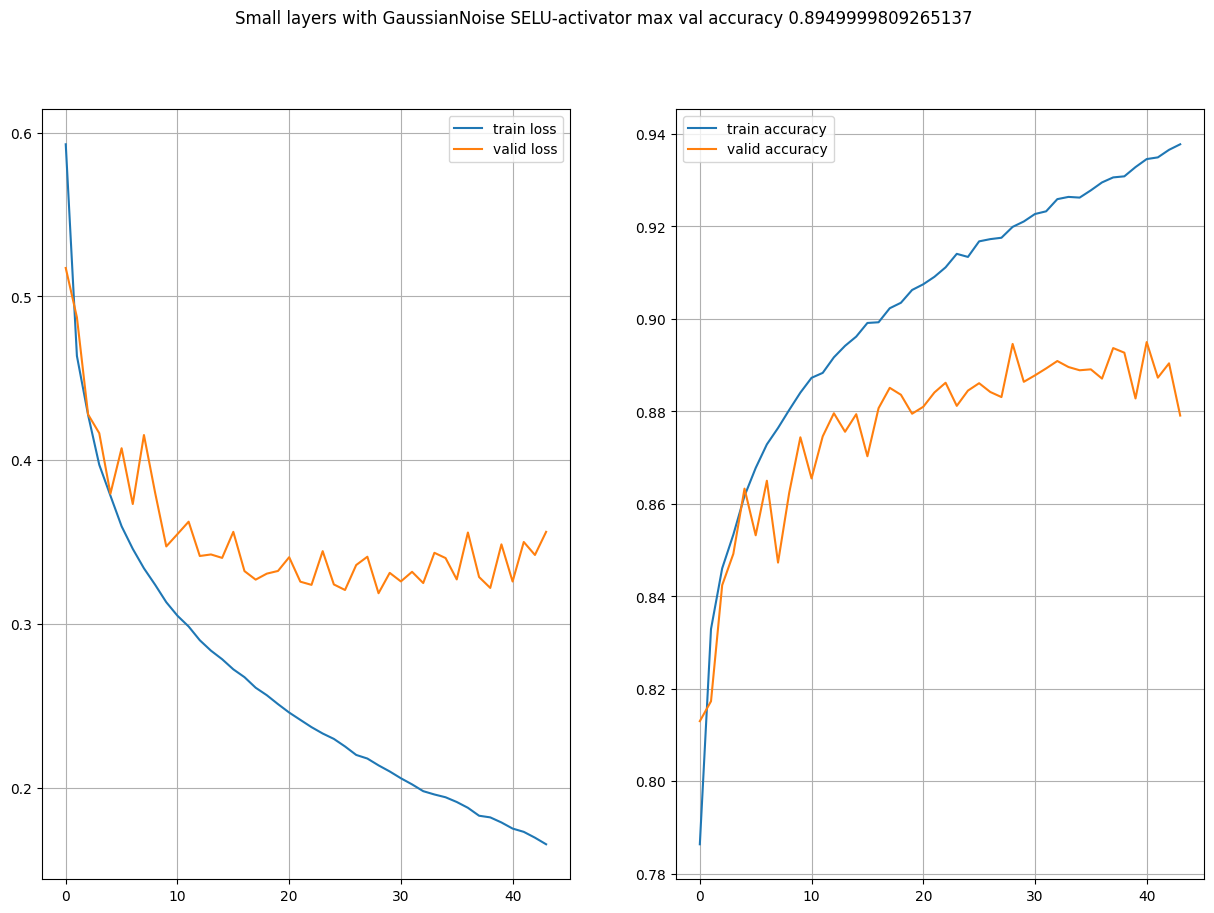

Epoch 1/100
467/469 [============================>.] - ETA: 0s - loss: 0.5961 - accuracy: 0.7854 - categorical_crossentropy: 0.5961INFO:tensorflow:Assets written to: small_la_gn_cp_54\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_54\assets


469/469 [==============================] - 5s 9ms/step - loss: 0.5957 - accuracy: 0.7855 - categorical_crossentropy: 0.5957 - val_loss: 0.4733 - val_accuracy: 0.8324 - val_categorical_crossentropy: 0.4733
Epoch 2/100
468/469 [============================>.] - ETA: 0s - loss: 0.4666 - accuracy: 0.8306 - categorical_crossentropy: 0.4666INFO:tensorflow:Assets written to: small_la_gn_cp_54\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_54\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4664 - accuracy: 0.8307 - categorical_crossentropy: 0.4664 - val_loss: 0.4429 - val_accuracy: 0.8430 - val_categorical_crossentropy: 0.4429
Epoch 3/100
469/469 [==============================] - 3s 7ms/step - loss: 0.4269 - accuracy: 0.8458 - categorical_crossentropy: 0.4269 - val_loss: 0.5077 - val_accuracy: 0.8238 - val_categorical_crossentropy: 0.5077
Epoch 4/100
466/469 [============================>.] - ETA: 0s - loss: 0.4015 - accuracy: 0.8527 - categorical_crossentropy: 0.4015INFO:tensorflow:Assets written to: small_la_gn_cp_54\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_54\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4013 - accuracy: 0.8528 - categorical_crossentropy: 0.4013 - val_loss: 0.4226 - val_accuracy: 0.8470 - val_categorical_crossentropy: 0.4226
Epoch 5/100
462/469 [============================>.] - ETA: 0s - loss: 0.3773 - accuracy: 0.8631 - categorical_crossentropy: 0.3773INFO:tensorflow:Assets written to: small_la_gn_cp_54\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_54\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3769 - accuracy: 0.8630 - categorical_crossentropy: 0.3769 - val_loss: 0.3955 - val_accuracy: 0.8610 - val_categorical_crossentropy: 0.3955
Epoch 6/100
464/469 [============================>.] - ETA: 0s - loss: 0.3597 - accuracy: 0.8672 - categorical_crossentropy: 0.3597INFO:tensorflow:Assets written to: small_la_gn_cp_54\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_54\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3600 - accuracy: 0.8670 - categorical_crossentropy: 0.3600 - val_loss: 0.3754 - val_accuracy: 0.8657 - val_categorical_crossentropy: 0.3754
Epoch 7/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3479 - accuracy: 0.8716 - categorical_crossentropy: 0.3479 - val_loss: 0.3834 - val_accuracy: 0.8643 - val_categorical_crossentropy: 0.3834
Epoch 8/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3353 - accuracy: 0.8758 - categorical_crossentropy: 0.3353 - val_loss: 0.3800 - val_accuracy: 0.8619 - val_categorical_crossentropy: 0.3800
Epoch 9/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3247 - accuracy: 0.8798 - categorical_crossentropy: 0.3247 - val_loss: 0.3834 - val_accuracy: 0.8590 - val_categorical_crossentropy: 0.3834
Epoch 10/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3140 - accuracy: 0.8827 - categorical_crossentropy: 0.3140 - val_

INFO:tensorflow:Assets written to: small_la_gn_cp_54\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3064 - accuracy: 0.8873 - categorical_crossentropy: 0.3064 - val_loss: 0.3615 - val_accuracy: 0.8693 - val_categorical_crossentropy: 0.3615
Epoch 12/100
466/469 [============================>.] - ETA: 0s - loss: 0.2979 - accuracy: 0.8897 - categorical_crossentropy: 0.2979INFO:tensorflow:Assets written to: small_la_gn_cp_54\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_54\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2982 - accuracy: 0.8896 - categorical_crossentropy: 0.2982 - val_loss: 0.3580 - val_accuracy: 0.8697 - val_categorical_crossentropy: 0.3580
Epoch 13/100
460/469 [============================>.] - ETA: 0s - loss: 0.2906 - accuracy: 0.8916 - categorical_crossentropy: 0.2906INFO:tensorflow:Assets written to: small_la_gn_cp_54\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_54\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2907 - accuracy: 0.8914 - categorical_crossentropy: 0.2907 - val_loss: 0.3405 - val_accuracy: 0.8755 - val_categorical_crossentropy: 0.3405
Epoch 14/100
469/469 [==============================] - ETA: 0s - loss: 0.2828 - accuracy: 0.8961 - categorical_crossentropy: 0.2828INFO:tensorflow:Assets written to: small_la_gn_cp_54\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_54\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2828 - accuracy: 0.8961 - categorical_crossentropy: 0.2828 - val_loss: 0.3391 - val_accuracy: 0.8822 - val_categorical_crossentropy: 0.3391
Epoch 15/100
469/469 [==============================] - 4s 7ms/step - loss: 0.2752 - accuracy: 0.8982 - categorical_crossentropy: 0.2752 - val_loss: 0.3731 - val_accuracy: 0.8626 - val_categorical_crossentropy: 0.3731
Epoch 16/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2708 - accuracy: 0.8986 - categorical_crossentropy: 0.2708 - val_loss: 0.3387 - val_accuracy: 0.8804 - val_categorical_crossentropy: 0.3387
Epoch 17/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2654 - accuracy: 0.9009 - categorical_crossentropy: 0.2654 - val_loss: 0.3344 - val_accuracy: 0.8814 - val_categorical_crossentropy: 0.3344
Epoch 18/100
466/469 [============================>.] - ETA: 0s - loss: 0.2618 - accuracy: 0.9018 - categorical_crossentropy: 0.2618INFO:tens

INFO:tensorflow:Assets written to: small_la_gn_cp_54\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2619 - accuracy: 0.9018 - categorical_crossentropy: 0.2619 - val_loss: 0.3285 - val_accuracy: 0.8838 - val_categorical_crossentropy: 0.3285
Epoch 19/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2557 - accuracy: 0.9042 - categorical_crossentropy: 0.2557 - val_loss: 0.3361 - val_accuracy: 0.8830 - val_categorical_crossentropy: 0.3361
Epoch 20/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2511 - accuracy: 0.9057 - categorical_crossentropy: 0.2511 - val_loss: 0.3449 - val_accuracy: 0.8740 - val_categorical_crossentropy: 0.3449
Epoch 21/100
466/469 [============================>.] - ETA: 0s - loss: 0.2459 - accuracy: 0.9083 - categorical_crossentropy: 0.2459INFO:tensorflow:Assets written to: small_la_gn_cp_54\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_54\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2455 - accuracy: 0.9085 - categorical_crossentropy: 0.2455 - val_loss: 0.3194 - val_accuracy: 0.8858 - val_categorical_crossentropy: 0.3194
Epoch 22/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2414 - accuracy: 0.9096 - categorical_crossentropy: 0.2414 - val_loss: 0.3355 - val_accuracy: 0.8818 - val_categorical_crossentropy: 0.3355
Epoch 23/100
458/469 [============================>.] - ETA: 0s - loss: 0.2354 - accuracy: 0.9109 - categorical_crossentropy: 0.2354INFO:tensorflow:Assets written to: small_la_gn_cp_54\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_54\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2357 - accuracy: 0.9110 - categorical_crossentropy: 0.2357 - val_loss: 0.3194 - val_accuracy: 0.8890 - val_categorical_crossentropy: 0.3194
Epoch 24/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2327 - accuracy: 0.9142 - categorical_crossentropy: 0.2327 - val_loss: 0.3300 - val_accuracy: 0.8877 - val_categorical_crossentropy: 0.3300
Epoch 25/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2295 - accuracy: 0.9134 - categorical_crossentropy: 0.2295 - val_loss: 0.3195 - val_accuracy: 0.8878 - val_categorical_crossentropy: 0.3195
Epoch 26/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2249 - accuracy: 0.9158 - categorical_crossentropy: 0.2249 - val_loss: 0.3248 - val_accuracy: 0.8861 - val_categorical_crossentropy: 0.3248
Epoch 27/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2199 - accuracy: 0.9173 - categorical_crossentropy: 0.2199 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_54\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2109 - accuracy: 0.9202 - categorical_crossentropy: 0.2109 - val_loss: 0.3224 - val_accuracy: 0.8892 - val_categorical_crossentropy: 0.3224
Epoch 31/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2064 - accuracy: 0.9218 - categorical_crossentropy: 0.2064 - val_loss: 0.3277 - val_accuracy: 0.8872 - val_categorical_crossentropy: 0.3277
Epoch 32/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2012 - accuracy: 0.9244 - categorical_crossentropy: 0.2012 - val_loss: 0.3384 - val_accuracy: 0.8841 - val_categorical_crossentropy: 0.3384
Epoch 33/100
463/469 [============================>.] - ETA: 0s - loss: 0.1999 - accuracy: 0.9248 - categorical_crossentropy: 0.1999INFO:tensorflow:Assets written to: small_la_gn_cp_54\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_54\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.1998 - accuracy: 0.9248 - categorical_crossentropy: 0.1998 - val_loss: 0.3140 - val_accuracy: 0.8956 - val_categorical_crossentropy: 0.3140
Epoch 34/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1951 - accuracy: 0.9269 - categorical_crossentropy: 0.1951 - val_loss: 0.3275 - val_accuracy: 0.8896 - val_categorical_crossentropy: 0.3275
Epoch 35/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1919 - accuracy: 0.9272 - categorical_crossentropy: 0.1919 - val_loss: 0.3295 - val_accuracy: 0.8926 - val_categorical_crossentropy: 0.3295
Epoch 36/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1901 - accuracy: 0.9278 - categorical_crossentropy: 0.1901 - val_loss: 0.3264 - val_accuracy: 0.8916 - val_categorical_crossentropy: 0.3264
Epoch 37/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1871 - accuracy: 0.9298 - categorical_crossentropy: 0.1871 - va

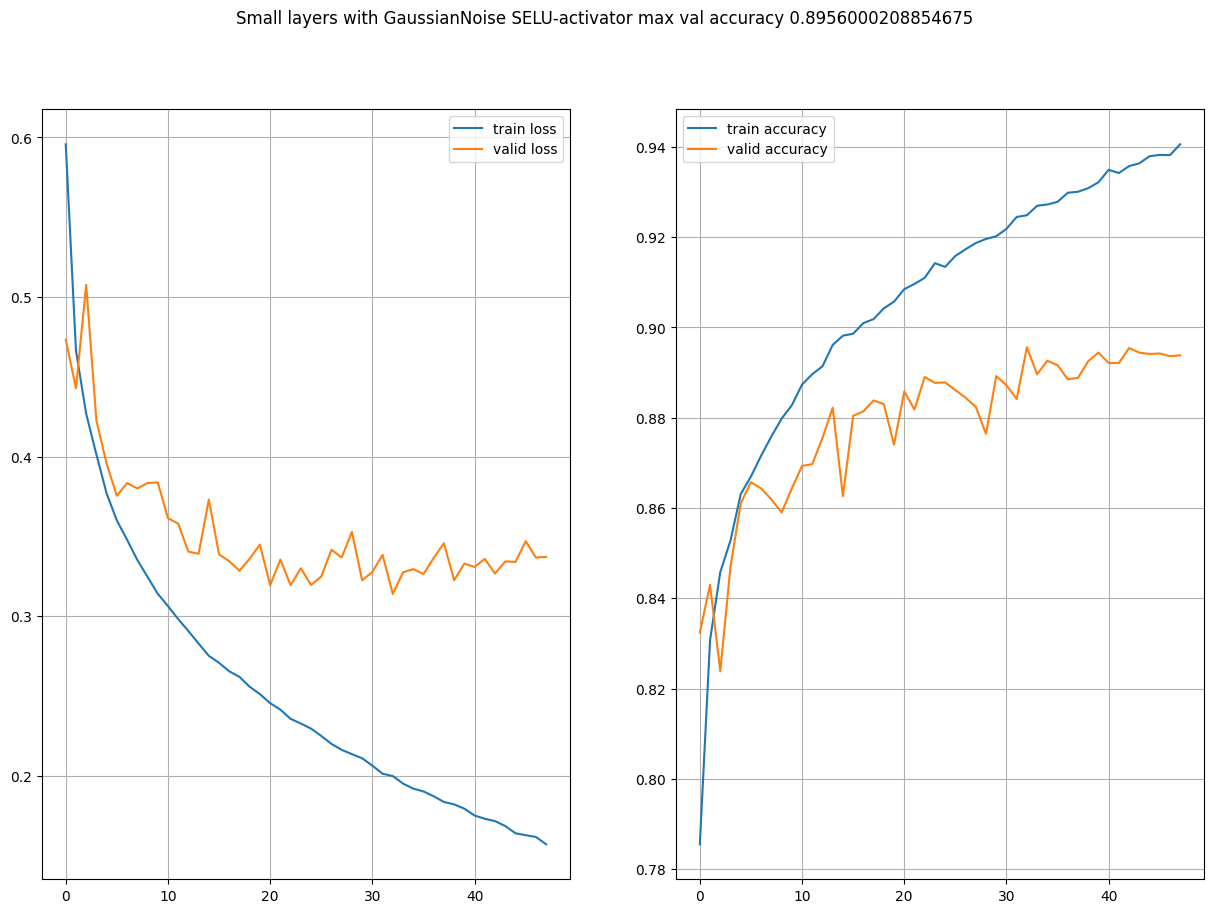

In [39]:

momentums = [.5, .7, .9, .95, .99]
idx = 50

for momentum in momentums:
    small_layers_GN = [
        Dense(128, activation="selu", input_shape=(28*28,)),
        GaussianNoise(0.2),
        Dense(512, activation="selu"),
        GaussianNoise(.2),
        Dense(10, activation="softmax"),
    ]

    small_model_GN = create_model_2(small_layers_GN, RMSprop(learning_rate=.0005, rho=.95))
    history = fit_and_present_2(small_model_GN, def_ds, val_dataset, description=f"Small layers with GaussianNoise SELU-activator", filepath=f"small_la_gn_cp_{idx}", patience=15)

    idx+=1

В код вище закралась помилка: модель створювалась з одними й тими самими параметрами декілька раз. Однак по результатам можна зробити висновок, що 0,2% точності може бути отримано виключно за рахунок початкових параметрів при створенні моделі.

SELU в даній моделі не показав себе краще за RELU. Наступним кроком SOFTPLUS

Epoch 1/100


469/469 [==============================] - ETA: 0s - loss: 0.7100 - accuracy: 0.7398 - categorical_crossentropy: 0.7100INFO:tensorflow:Assets written to: small_la_gn_cp_60\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_60\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.7100 - accuracy: 0.7398 - categorical_crossentropy: 0.7100 - val_loss: 0.5286 - val_accuracy: 0.8125 - val_categorical_crossentropy: 0.5286
Epoch 2/100
469/469 [==============================] - 4s 8ms/step - loss: 0.4957 - accuracy: 0.8205 - categorical_crossentropy: 0.4957 - val_loss: 0.5120 - val_accuracy: 0.8120 - val_categorical_crossentropy: 0.5120
Epoch 3/100
469/469 [==============================] - ETA: 0s - loss: 0.4490 - accuracy: 0.8352 - categorical_crossentropy: 0.4490INFO:tensorflow:Assets written to: small_la_gn_cp_60\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_60\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.4490 - accuracy: 0.8352 - categorical_crossentropy: 0.4490 - val_loss: 0.4443 - val_accuracy: 0.8387 - val_categorical_crossentropy: 0.4443
Epoch 4/100
465/469 [============================>.] - ETA: 0s - loss: 0.4177 - accuracy: 0.8458 - categorical_crossentropy: 0.4177INFO:tensorflow:Assets written to: small_la_gn_cp_60\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_60\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.4171 - accuracy: 0.8459 - categorical_crossentropy: 0.4171 - val_loss: 0.4137 - val_accuracy: 0.8512 - val_categorical_crossentropy: 0.4137
Epoch 5/100
469/469 [==============================] - ETA: 0s - loss: 0.3952 - accuracy: 0.8550 - categorical_crossentropy: 0.3952INFO:tensorflow:Assets written to: small_la_gn_cp_60\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_60\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3952 - accuracy: 0.8550 - categorical_crossentropy: 0.3952 - val_loss: 0.3993 - val_accuracy: 0.8560 - val_categorical_crossentropy: 0.3993
Epoch 6/100
469/469 [==============================] - 4s 7ms/step - loss: 0.3803 - accuracy: 0.8610 - categorical_crossentropy: 0.3803 - val_loss: 0.4286 - val_accuracy: 0.8426 - val_categorical_crossentropy: 0.4286
Epoch 7/100
469/469 [==============================] - ETA: 0s - loss: 0.3650 - accuracy: 0.8651 - categorical_crossentropy: 0.3650INFO:tensorflow:Assets written to: small_la_gn_cp_60\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_60\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.3650 - accuracy: 0.8651 - categorical_crossentropy: 0.3650 - val_loss: 0.3866 - val_accuracy: 0.8646 - val_categorical_crossentropy: 0.3866
Epoch 8/100
469/469 [==============================] - 4s 8ms/step - loss: 0.3544 - accuracy: 0.8705 - categorical_crossentropy: 0.3544 - val_loss: 0.3800 - val_accuracy: 0.8611 - val_categorical_crossentropy: 0.3800
Epoch 9/100
459/469 [============================>.] - ETA: 0s - loss: 0.3431 - accuracy: 0.8730 - categorical_crossentropy: 0.3431INFO:tensorflow:Assets written to: small_la_gn_cp_60\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_60\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.3432 - accuracy: 0.8728 - categorical_crossentropy: 0.3432 - val_loss: 0.3810 - val_accuracy: 0.8660 - val_categorical_crossentropy: 0.3810
Epoch 10/100
469/469 [==============================] - 4s 8ms/step - loss: 0.3336 - accuracy: 0.8772 - categorical_crossentropy: 0.3336 - val_loss: 0.3842 - val_accuracy: 0.8606 - val_categorical_crossentropy: 0.3842
Epoch 11/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3264 - accuracy: 0.8797 - categorical_crossentropy: 0.3264 - val_loss: 0.4072 - val_accuracy: 0.8514 - val_categorical_crossentropy: 0.4072
Epoch 12/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3179 - accuracy: 0.8819 - categorical_crossentropy: 0.3179 - val_loss: 0.3782 - val_accuracy: 0.8608 - val_categorical_crossentropy: 0.3782
Epoch 13/100
461/469 [============================>.] - ETA: 0s - loss: 0.3137 - accuracy: 0.8825 - categorical_crossentropy: 0.3137INFO:tens

INFO:tensorflow:Assets written to: small_la_gn_cp_60\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3137 - accuracy: 0.8826 - categorical_crossentropy: 0.3137 - val_loss: 0.3509 - val_accuracy: 0.8728 - val_categorical_crossentropy: 0.3509
Epoch 14/100
469/469 [==============================] - 4s 7ms/step - loss: 0.3065 - accuracy: 0.8860 - categorical_crossentropy: 0.3065 - val_loss: 0.3600 - val_accuracy: 0.8716 - val_categorical_crossentropy: 0.3600
Epoch 15/100
468/469 [============================>.] - ETA: 0s - loss: 0.3007 - accuracy: 0.8874 - categorical_crossentropy: 0.3007INFO:tensorflow:Assets written to: small_la_gn_cp_60\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_60\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.3005 - accuracy: 0.8875 - categorical_crossentropy: 0.3005 - val_loss: 0.3584 - val_accuracy: 0.8729 - val_categorical_crossentropy: 0.3584
Epoch 16/100
464/469 [============================>.] - ETA: 0s - loss: 0.2942 - accuracy: 0.8902 - categorical_crossentropy: 0.2942INFO:tensorflow:Assets written to: small_la_gn_cp_60\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_60\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.2941 - accuracy: 0.8902 - categorical_crossentropy: 0.2941 - val_loss: 0.3467 - val_accuracy: 0.8782 - val_categorical_crossentropy: 0.3467
Epoch 17/100
469/469 [==============================] - 4s 8ms/step - loss: 0.2896 - accuracy: 0.8912 - categorical_crossentropy: 0.2896 - val_loss: 0.3555 - val_accuracy: 0.8720 - val_categorical_crossentropy: 0.3555
Epoch 18/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2852 - accuracy: 0.8928 - categorical_crossentropy: 0.2852 - val_loss: 0.3391 - val_accuracy: 0.8779 - val_categorical_crossentropy: 0.3391
Epoch 19/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2808 - accuracy: 0.8949 - categorical_crossentropy: 0.2808 - val_loss: 0.3508 - val_accuracy: 0.8745 - val_categorical_crossentropy: 0.3508
Epoch 20/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2757 - accuracy: 0.8964 - categorical_crossentropy: 0.2757 - v

INFO:tensorflow:Assets written to: small_la_gn_cp_60\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.2728 - accuracy: 0.8976 - categorical_crossentropy: 0.2728 - val_loss: 0.3386 - val_accuracy: 0.8801 - val_categorical_crossentropy: 0.3386
Epoch 22/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2695 - accuracy: 0.8985 - categorical_crossentropy: 0.2695 - val_loss: 0.3349 - val_accuracy: 0.8789 - val_categorical_crossentropy: 0.3349
Epoch 23/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2646 - accuracy: 0.8989 - categorical_crossentropy: 0.2646 - val_loss: 0.3471 - val_accuracy: 0.8782 - val_categorical_crossentropy: 0.3471
Epoch 24/100
458/469 [============================>.] - ETA: 0s - loss: 0.2613 - accuracy: 0.9012 - categorical_crossentropy: 0.2613INFO:tensorflow:Assets written to: small_la_gn_cp_60\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_60\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2616 - accuracy: 0.9011 - categorical_crossentropy: 0.2616 - val_loss: 0.3423 - val_accuracy: 0.8803 - val_categorical_crossentropy: 0.3423
Epoch 25/100
465/469 [============================>.] - ETA: 0s - loss: 0.2577 - accuracy: 0.9033 - categorical_crossentropy: 0.2577INFO:tensorflow:Assets written to: small_la_gn_cp_60\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_60\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.2581 - accuracy: 0.9032 - categorical_crossentropy: 0.2581 - val_loss: 0.3297 - val_accuracy: 0.8829 - val_categorical_crossentropy: 0.3297
Epoch 26/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2553 - accuracy: 0.9036 - categorical_crossentropy: 0.2553 - val_loss: 0.3444 - val_accuracy: 0.8813 - val_categorical_crossentropy: 0.3444
Epoch 27/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2510 - accuracy: 0.9050 - categorical_crossentropy: 0.2510 - val_loss: 0.3419 - val_accuracy: 0.8796 - val_categorical_crossentropy: 0.3419
Epoch 28/100
458/469 [============================>.] - ETA: 0s - loss: 0.2465 - accuracy: 0.9073 - categorical_crossentropy: 0.2465INFO:tensorflow:Assets written to: small_la_gn_cp_60\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_60\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2466 - accuracy: 0.9072 - categorical_crossentropy: 0.2466 - val_loss: 0.3391 - val_accuracy: 0.8838 - val_categorical_crossentropy: 0.3391
Epoch 29/100
467/469 [============================>.] - ETA: 0s - loss: 0.2452 - accuracy: 0.9066 - categorical_crossentropy: 0.2452INFO:tensorflow:Assets written to: small_la_gn_cp_60\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_60\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.2449 - accuracy: 0.9067 - categorical_crossentropy: 0.2449 - val_loss: 0.3317 - val_accuracy: 0.8846 - val_categorical_crossentropy: 0.3317
Epoch 30/100
461/469 [============================>.] - ETA: 0s - loss: 0.2426 - accuracy: 0.9087 - categorical_crossentropy: 0.2426INFO:tensorflow:Assets written to: small_la_gn_cp_60\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_60\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.2424 - accuracy: 0.9089 - categorical_crossentropy: 0.2424 - val_loss: 0.3261 - val_accuracy: 0.8860 - val_categorical_crossentropy: 0.3261
Epoch 31/100
469/469 [==============================] - 4s 7ms/step - loss: 0.2373 - accuracy: 0.9107 - categorical_crossentropy: 0.2373 - val_loss: 0.3549 - val_accuracy: 0.8792 - val_categorical_crossentropy: 0.3549
Epoch 32/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2369 - accuracy: 0.9096 - categorical_crossentropy: 0.2369 - val_loss: 0.3534 - val_accuracy: 0.8781 - val_categorical_crossentropy: 0.3534
Epoch 33/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2344 - accuracy: 0.9110 - categorical_crossentropy: 0.2344 - val_loss: 0.3318 - val_accuracy: 0.8860 - val_categorical_crossentropy: 0.3318
Epoch 34/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2312 - accuracy: 0.9122 - categorical_crossentropy: 0.2312 - v

INFO:tensorflow:Assets written to: small_la_gn_cp_60\assets


469/469 [==============================] - 4s 10ms/step - loss: 0.2199 - accuracy: 0.9163 - categorical_crossentropy: 0.2199 - val_loss: 0.3196 - val_accuracy: 0.8916 - val_categorical_crossentropy: 0.3196
Epoch 39/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2181 - accuracy: 0.9171 - categorical_crossentropy: 0.2181 - val_loss: 0.3367 - val_accuracy: 0.8863 - val_categorical_crossentropy: 0.3367
Epoch 40/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2150 - accuracy: 0.9190 - categorical_crossentropy: 0.2150 - val_loss: 0.3318 - val_accuracy: 0.8893 - val_categorical_crossentropy: 0.3318
Epoch 41/100
459/469 [============================>.] - ETA: 0s - loss: 0.2125 - accuracy: 0.9183 - categorical_crossentropy: 0.2125INFO:tensorflow:Assets written to: small_la_gn_cp_60\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_60\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2125 - accuracy: 0.9184 - categorical_crossentropy: 0.2125 - val_loss: 0.3275 - val_accuracy: 0.8936 - val_categorical_crossentropy: 0.3275
Epoch 42/100
469/469 [==============================] - 4s 8ms/step - loss: 0.2079 - accuracy: 0.9207 - categorical_crossentropy: 0.2079 - val_loss: 0.3338 - val_accuracy: 0.8886 - val_categorical_crossentropy: 0.3338
Epoch 43/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2080 - accuracy: 0.9207 - categorical_crossentropy: 0.2080 - val_loss: 0.3254 - val_accuracy: 0.8915 - val_categorical_crossentropy: 0.3254
Epoch 44/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2058 - accuracy: 0.9210 - categorical_crossentropy: 0.2058 - val_loss: 0.3322 - val_accuracy: 0.8909 - val_categorical_crossentropy: 0.3322
Epoch 45/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2030 - accuracy: 0.9219 - categorical_crossentropy: 0.2030 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_60\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.1880 - accuracy: 0.9278 - categorical_crossentropy: 0.1880 - val_loss: 0.3443 - val_accuracy: 0.8942 - val_categorical_crossentropy: 0.3443
Epoch 53/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1855 - accuracy: 0.9294 - categorical_crossentropy: 0.1855 - val_loss: 0.3393 - val_accuracy: 0.8941 - val_categorical_crossentropy: 0.3393


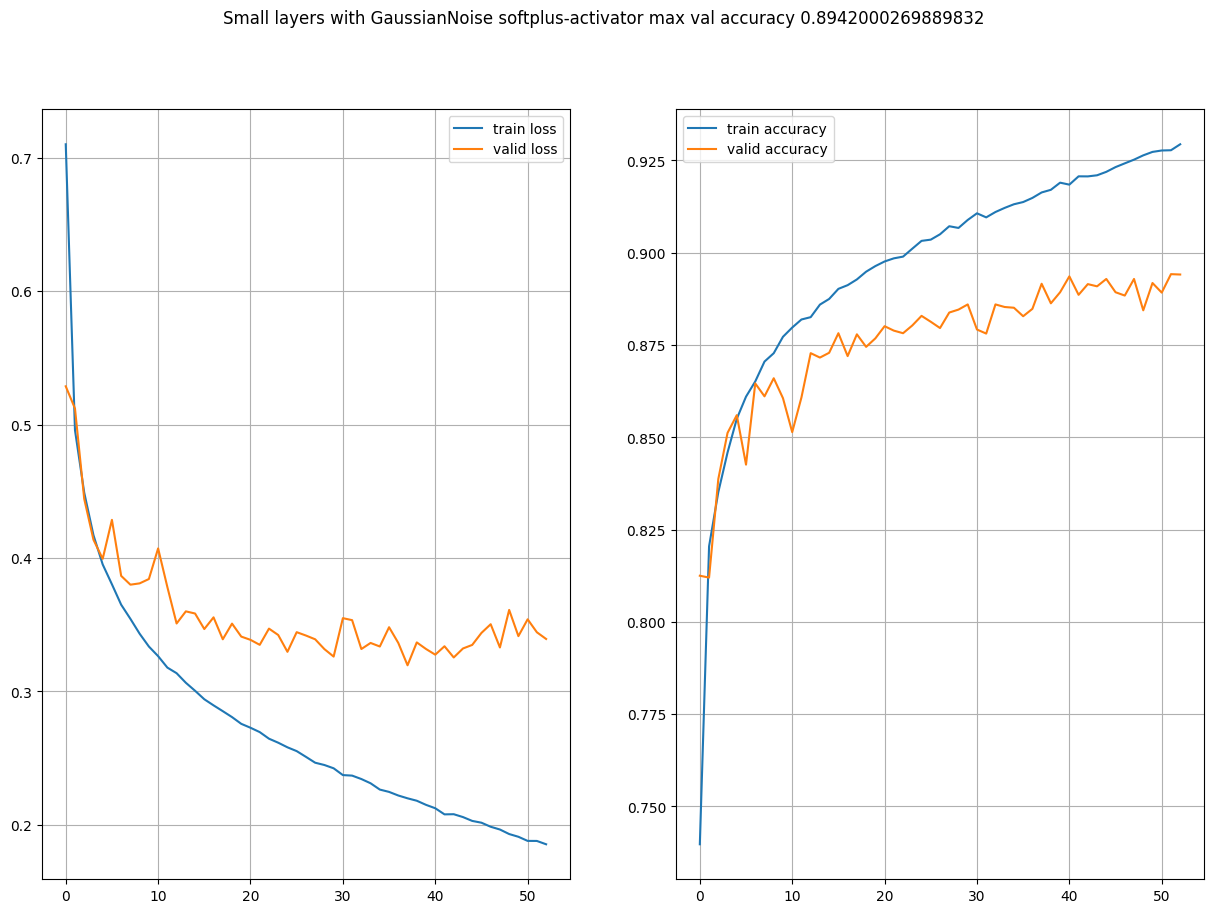

In [40]:

momentums = [1]
idx = 60

for momentum in momentums:
    small_layers_GN = [
        Dense(128, activation="softplus", input_shape=(28*28,)),
        GaussianNoise(0.2),
        Dense(512, activation="softplus"),
        GaussianNoise(.2),
        Dense(10, activation="softmax"),
    ]

    small_model_GN = create_model_2(small_layers_GN, RMSprop(learning_rate=.0005, rho=.95))
    history = fit_and_present_2(small_model_GN, def_ds, val_dataset, description=f"Small layers with GaussianNoise softplus-activator", filepath=f"small_la_gn_cp_{idx}", patience=15)

    idx+=1

З огляду на 0,2%, про які ми дізналися на попередньому кроці, в даній задачі SOFTPLUS та RELU дають майже однакові результати

На черзі ELU

Epoch 1/100


461/469 [============================>.] - ETA: 0s - loss: 0.5909 - accuracy: 0.7851 - categorical_crossentropy: 0.5909INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


469/469 [==============================] - 5s 9ms/step - loss: 0.5900 - accuracy: 0.7854 - categorical_crossentropy: 0.5900 - val_loss: 0.5619 - val_accuracy: 0.7892 - val_categorical_crossentropy: 0.5619
Epoch 2/100
467/469 [============================>.] - ETA: 0s - loss: 0.4548 - accuracy: 0.8337 - categorical_crossentropy: 0.4548INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4554 - accuracy: 0.8335 - categorical_crossentropy: 0.4554 - val_loss: 0.4809 - val_accuracy: 0.8263 - val_categorical_crossentropy: 0.4809
Epoch 3/100
463/469 [============================>.] - ETA: 0s - loss: 0.4177 - accuracy: 0.8468 - categorical_crossentropy: 0.4177INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.4175 - accuracy: 0.8469 - categorical_crossentropy: 0.4175 - val_loss: 0.4126 - val_accuracy: 0.8495 - val_categorical_crossentropy: 0.4126
Epoch 4/100
465/469 [============================>.] - ETA: 0s - loss: 0.3889 - accuracy: 0.8571 - categorical_crossentropy: 0.3889INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3890 - accuracy: 0.8571 - categorical_crossentropy: 0.3890 - val_loss: 0.4105 - val_accuracy: 0.8524 - val_categorical_crossentropy: 0.4105
Epoch 5/100
469/469 [==============================] - ETA: 0s - loss: 0.3689 - accuracy: 0.8643 - categorical_crossentropy: 0.3689INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3689 - accuracy: 0.8643 - categorical_crossentropy: 0.3689 - val_loss: 0.3950 - val_accuracy: 0.8580 - val_categorical_crossentropy: 0.3950
Epoch 6/100
462/469 [============================>.] - ETA: 0s - loss: 0.3549 - accuracy: 0.8693 - categorical_crossentropy: 0.3549INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3547 - accuracy: 0.8696 - categorical_crossentropy: 0.3547 - val_loss: 0.3789 - val_accuracy: 0.8631 - val_categorical_crossentropy: 0.3789
Epoch 7/100
467/469 [============================>.] - ETA: 0s - loss: 0.3390 - accuracy: 0.8743 - categorical_crossentropy: 0.3390INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3389 - accuracy: 0.8744 - categorical_crossentropy: 0.3389 - val_loss: 0.3607 - val_accuracy: 0.8709 - val_categorical_crossentropy: 0.3607
Epoch 8/100
461/469 [============================>.] - ETA: 0s - loss: 0.3284 - accuracy: 0.8787 - categorical_crossentropy: 0.3284INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3282 - accuracy: 0.8788 - categorical_crossentropy: 0.3282 - val_loss: 0.3557 - val_accuracy: 0.8728 - val_categorical_crossentropy: 0.3557
Epoch 9/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3169 - accuracy: 0.8823 - categorical_crossentropy: 0.3169 - val_loss: 0.3710 - val_accuracy: 0.8659 - val_categorical_crossentropy: 0.3710
Epoch 10/100
462/469 [============================>.] - ETA: 0s - loss: 0.3101 - accuracy: 0.8850 - categorical_crossentropy: 0.3101INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.3101 - accuracy: 0.8850 - categorical_crossentropy: 0.3101 - val_loss: 0.3481 - val_accuracy: 0.8733 - val_categorical_crossentropy: 0.3481
Epoch 11/100
463/469 [============================>.] - ETA: 0s - loss: 0.3020 - accuracy: 0.8883 - categorical_crossentropy: 0.3020INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3018 - accuracy: 0.8884 - categorical_crossentropy: 0.3018 - val_loss: 0.3526 - val_accuracy: 0.8741 - val_categorical_crossentropy: 0.3526
Epoch 12/100
461/469 [============================>.] - ETA: 0s - loss: 0.2934 - accuracy: 0.8915 - categorical_crossentropy: 0.2934INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2930 - accuracy: 0.8917 - categorical_crossentropy: 0.2930 - val_loss: 0.3520 - val_accuracy: 0.8758 - val_categorical_crossentropy: 0.3520
Epoch 13/100
468/469 [============================>.] - ETA: 0s - loss: 0.2878 - accuracy: 0.8917 - categorical_crossentropy: 0.2878INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2878 - accuracy: 0.8917 - categorical_crossentropy: 0.2878 - val_loss: 0.3387 - val_accuracy: 0.8783 - val_categorical_crossentropy: 0.3387
Epoch 14/100
461/469 [============================>.] - ETA: 0s - loss: 0.2808 - accuracy: 0.8945 - categorical_crossentropy: 0.2808INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2811 - accuracy: 0.8942 - categorical_crossentropy: 0.2811 - val_loss: 0.3431 - val_accuracy: 0.8818 - val_categorical_crossentropy: 0.3431
Epoch 15/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2753 - accuracy: 0.8978 - categorical_crossentropy: 0.2753 - val_loss: 0.3343 - val_accuracy: 0.8797 - val_categorical_crossentropy: 0.3343
Epoch 16/100
468/469 [============================>.] - ETA: 0s - loss: 0.2690 - accuracy: 0.8999 - categorical_crossentropy: 0.2690INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2688 - accuracy: 0.8999 - categorical_crossentropy: 0.2688 - val_loss: 0.3268 - val_accuracy: 0.8834 - val_categorical_crossentropy: 0.3268
Epoch 17/100
467/469 [============================>.] - ETA: 0s - loss: 0.2628 - accuracy: 0.9018 - categorical_crossentropy: 0.2628INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2626 - accuracy: 0.9020 - categorical_crossentropy: 0.2626 - val_loss: 0.3269 - val_accuracy: 0.8851 - val_categorical_crossentropy: 0.3269
Epoch 18/100
459/469 [============================>.] - ETA: 0s - loss: 0.2595 - accuracy: 0.9020 - categorical_crossentropy: 0.2595INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2583 - accuracy: 0.9024 - categorical_crossentropy: 0.2583 - val_loss: 0.3271 - val_accuracy: 0.8876 - val_categorical_crossentropy: 0.3271
Epoch 19/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2526 - accuracy: 0.9048 - categorical_crossentropy: 0.2526 - val_loss: 0.3318 - val_accuracy: 0.8824 - val_categorical_crossentropy: 0.3318
Epoch 20/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2487 - accuracy: 0.9070 - categorical_crossentropy: 0.2487 - val_loss: 0.3333 - val_accuracy: 0.8851 - val_categorical_crossentropy: 0.3333
Epoch 21/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2441 - accuracy: 0.9081 - categorical_crossentropy: 0.2441 - val_loss: 0.3200 - val_accuracy: 0.8832 - val_categorical_crossentropy: 0.3200
Epoch 22/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2396 - accuracy: 0.9090 - categorical_crossentropy: 0.2396 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2344 - accuracy: 0.9121 - categorical_crossentropy: 0.2344 - val_loss: 0.3253 - val_accuracy: 0.8877 - val_categorical_crossentropy: 0.3253
Epoch 24/100
461/469 [============================>.] - ETA: 0s - loss: 0.2310 - accuracy: 0.9130 - categorical_crossentropy: 0.2310INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2308 - accuracy: 0.9131 - categorical_crossentropy: 0.2308 - val_loss: 0.3222 - val_accuracy: 0.8904 - val_categorical_crossentropy: 0.3222
Epoch 25/100
461/469 [============================>.] - ETA: 0s - loss: 0.2277 - accuracy: 0.9132 - categorical_crossentropy: 0.2277INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2284 - accuracy: 0.9130 - categorical_crossentropy: 0.2284 - val_loss: 0.3106 - val_accuracy: 0.8906 - val_categorical_crossentropy: 0.3106
Epoch 26/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2240 - accuracy: 0.9152 - categorical_crossentropy: 0.2240 - val_loss: 0.3253 - val_accuracy: 0.8882 - val_categorical_crossentropy: 0.3253
Epoch 27/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2205 - accuracy: 0.9169 - categorical_crossentropy: 0.2205 - val_loss: 0.3368 - val_accuracy: 0.8822 - val_categorical_crossentropy: 0.3368
Epoch 28/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2165 - accuracy: 0.9181 - categorical_crossentropy: 0.2165 - val_loss: 0.3346 - val_accuracy: 0.8881 - val_categorical_crossentropy: 0.3346
Epoch 29/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2133 - accuracy: 0.9194 - categorical_crossentropy: 0.2133 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2104 - accuracy: 0.9200 - categorical_crossentropy: 0.2104 - val_loss: 0.3217 - val_accuracy: 0.8938 - val_categorical_crossentropy: 0.3217
Epoch 31/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2055 - accuracy: 0.9225 - categorical_crossentropy: 0.2055 - val_loss: 0.3395 - val_accuracy: 0.8878 - val_categorical_crossentropy: 0.3395
Epoch 32/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2022 - accuracy: 0.9234 - categorical_crossentropy: 0.2022 - val_loss: 0.3194 - val_accuracy: 0.8923 - val_categorical_crossentropy: 0.3194
Epoch 33/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1988 - accuracy: 0.9245 - categorical_crossentropy: 0.1988 - val_loss: 0.3230 - val_accuracy: 0.8916 - val_categorical_crossentropy: 0.3230
Epoch 34/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1963 - accuracy: 0.9246 - categorical_crossentropy: 0.1963 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_70\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.1776 - accuracy: 0.9320 - categorical_crossentropy: 0.1776 - val_loss: 0.3195 - val_accuracy: 0.8995 - val_categorical_crossentropy: 0.3195


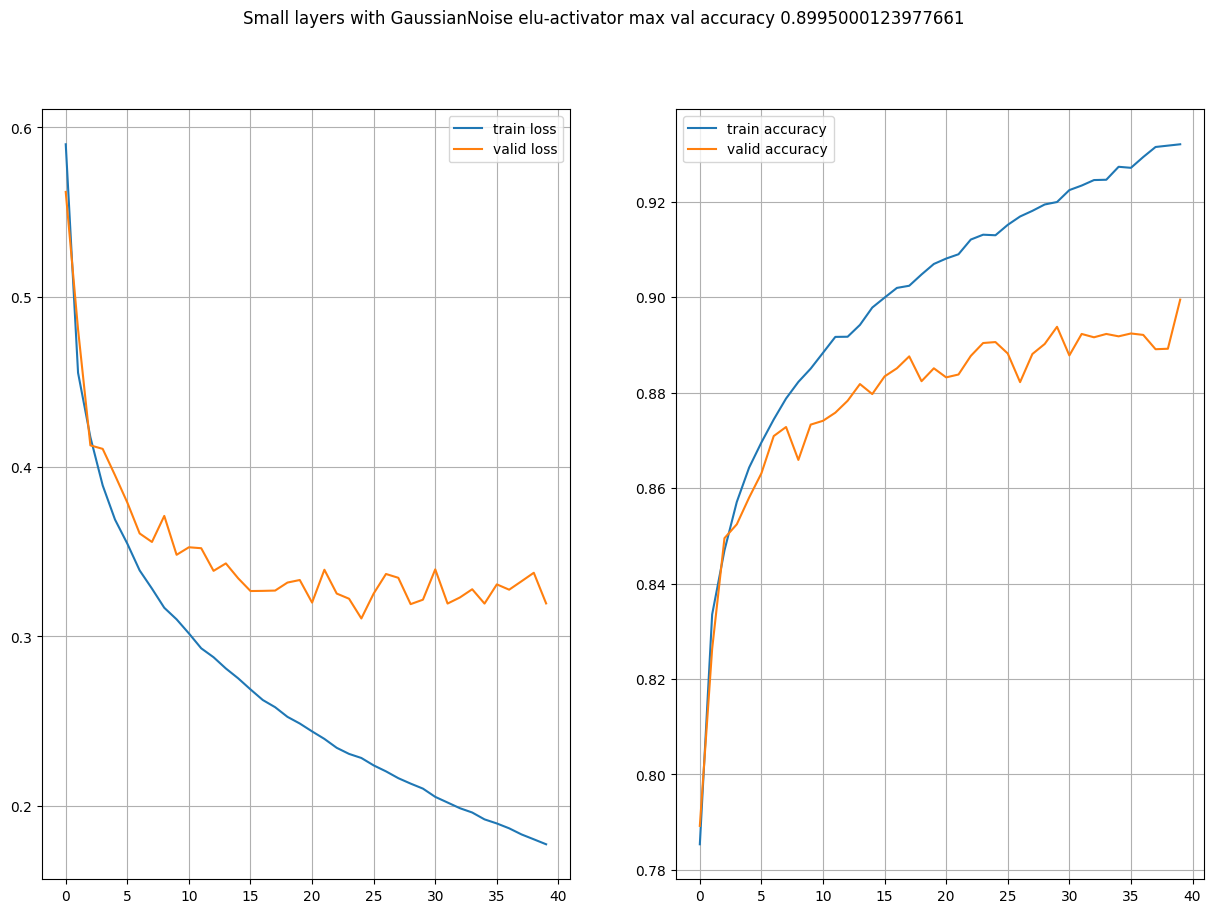

In [41]:

momentums = [1]
idx = 70

for momentum in momentums:
    small_layers_GN = [
        Dense(128, activation="elu", input_shape=(28*28,)),
        GaussianNoise(0.2),
        Dense(512, activation="elu"),
        GaussianNoise(.2),
        Dense(10, activation="softmax"),
    ]

    small_model_GN = create_model_2(small_layers_GN, RMSprop(learning_rate=.0005, rho=.95))
    history = fit_and_present_2(small_model_GN, def_ds, val_dataset, description=f"Small layers with GaussianNoise elu-activator", filepath=f"small_la_gn_cp_{idx}", patience=15)

    idx+=1

Не вийшло.

Epoch 1/100


465/469 [============================>.] - ETA: 0s - loss: 0.6746 - accuracy: 0.7601 - categorical_crossentropy: 0.6746INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


469/469 [==============================] - 5s 9ms/step - loss: 0.6735 - accuracy: 0.7605 - categorical_crossentropy: 0.6735 - val_loss: 0.5577 - val_accuracy: 0.7931 - val_categorical_crossentropy: 0.5577
Epoch 2/100
460/469 [============================>.] - ETA: 0s - loss: 0.4657 - accuracy: 0.8321 - categorical_crossentropy: 0.4657INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


469/469 [==============================] - 4s 10ms/step - loss: 0.4655 - accuracy: 0.8324 - categorical_crossentropy: 0.4655 - val_loss: 0.4497 - val_accuracy: 0.8385 - val_categorical_crossentropy: 0.4497
Epoch 3/100
465/469 [============================>.] - ETA: 0s - loss: 0.4224 - accuracy: 0.8481 - categorical_crossentropy: 0.4224INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4223 - accuracy: 0.8481 - categorical_crossentropy: 0.4223 - val_loss: 0.4227 - val_accuracy: 0.8505 - val_categorical_crossentropy: 0.4227
Epoch 4/100
468/469 [============================>.] - ETA: 0s - loss: 0.3947 - accuracy: 0.8559 - categorical_crossentropy: 0.3947INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3946 - accuracy: 0.8559 - categorical_crossentropy: 0.3946 - val_loss: 0.4089 - val_accuracy: 0.8511 - val_categorical_crossentropy: 0.4089
Epoch 5/100
460/469 [============================>.] - ETA: 0s - loss: 0.3749 - accuracy: 0.8634 - categorical_crossentropy: 0.3749INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3747 - accuracy: 0.8635 - categorical_crossentropy: 0.3747 - val_loss: 0.3890 - val_accuracy: 0.8596 - val_categorical_crossentropy: 0.3890
Epoch 6/100
460/469 [============================>.] - ETA: 0s - loss: 0.3605 - accuracy: 0.8682 - categorical_crossentropy: 0.3605INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3604 - accuracy: 0.8681 - categorical_crossentropy: 0.3604 - val_loss: 0.3792 - val_accuracy: 0.8635 - val_categorical_crossentropy: 0.3792
Epoch 7/100
463/469 [============================>.] - ETA: 0s - loss: 0.3461 - accuracy: 0.8731 - categorical_crossentropy: 0.3461INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3468 - accuracy: 0.8728 - categorical_crossentropy: 0.3468 - val_loss: 0.3681 - val_accuracy: 0.8656 - val_categorical_crossentropy: 0.3681
Epoch 8/100
469/469 [==============================] - 4s 7ms/step - loss: 0.3351 - accuracy: 0.8762 - categorical_crossentropy: 0.3351 - val_loss: 0.3748 - val_accuracy: 0.8613 - val_categorical_crossentropy: 0.3748
Epoch 9/100
465/469 [============================>.] - ETA: 0s - loss: 0.3258 - accuracy: 0.8798 - categorical_crossentropy: 0.3258INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.3260 - accuracy: 0.8796 - categorical_crossentropy: 0.3260 - val_loss: 0.3535 - val_accuracy: 0.8736 - val_categorical_crossentropy: 0.3535
Epoch 10/100
463/469 [============================>.] - ETA: 0s - loss: 0.3173 - accuracy: 0.8819 - categorical_crossentropy: 0.3173INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3176 - accuracy: 0.8819 - categorical_crossentropy: 0.3176 - val_loss: 0.3459 - val_accuracy: 0.8752 - val_categorical_crossentropy: 0.3459
Epoch 11/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3099 - accuracy: 0.8859 - categorical_crossentropy: 0.3099 - val_loss: 0.3554 - val_accuracy: 0.8748 - val_categorical_crossentropy: 0.3554
Epoch 12/100
468/469 [============================>.] - ETA: 0s - loss: 0.3032 - accuracy: 0.8879 - categorical_crossentropy: 0.3032INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3030 - accuracy: 0.8879 - categorical_crossentropy: 0.3030 - val_loss: 0.3420 - val_accuracy: 0.8768 - val_categorical_crossentropy: 0.3420
Epoch 13/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2974 - accuracy: 0.8897 - categorical_crossentropy: 0.2974 - val_loss: 0.3563 - val_accuracy: 0.8719 - val_categorical_crossentropy: 0.3563
Epoch 14/100
462/469 [============================>.] - ETA: 0s - loss: 0.2915 - accuracy: 0.8909 - categorical_crossentropy: 0.2915INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2910 - accuracy: 0.8911 - categorical_crossentropy: 0.2910 - val_loss: 0.3383 - val_accuracy: 0.8771 - val_categorical_crossentropy: 0.3383
Epoch 15/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2858 - accuracy: 0.8928 - categorical_crossentropy: 0.2858 - val_loss: 0.3456 - val_accuracy: 0.8763 - val_categorical_crossentropy: 0.3456
Epoch 16/100
463/469 [============================>.] - ETA: 0s - loss: 0.2803 - accuracy: 0.8941 - categorical_crossentropy: 0.2803INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2802 - accuracy: 0.8942 - categorical_crossentropy: 0.2802 - val_loss: 0.3335 - val_accuracy: 0.8816 - val_categorical_crossentropy: 0.3335
Epoch 17/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2740 - accuracy: 0.8971 - categorical_crossentropy: 0.2740 - val_loss: 0.3399 - val_accuracy: 0.8799 - val_categorical_crossentropy: 0.3399
Epoch 18/100
469/469 [==============================] - ETA: 0s - loss: 0.2697 - accuracy: 0.8983 - categorical_crossentropy: 0.2697INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2697 - accuracy: 0.8983 - categorical_crossentropy: 0.2697 - val_loss: 0.3220 - val_accuracy: 0.8854 - val_categorical_crossentropy: 0.3220
Epoch 19/100
463/469 [============================>.] - ETA: 0s - loss: 0.2666 - accuracy: 0.9007 - categorical_crossentropy: 0.2666INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2665 - accuracy: 0.9006 - categorical_crossentropy: 0.2665 - val_loss: 0.3213 - val_accuracy: 0.8869 - val_categorical_crossentropy: 0.3213
Epoch 20/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2620 - accuracy: 0.9028 - categorical_crossentropy: 0.2620 - val_loss: 0.3308 - val_accuracy: 0.8822 - val_categorical_crossentropy: 0.3308
Epoch 21/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2582 - accuracy: 0.9029 - categorical_crossentropy: 0.2582 - val_loss: 0.3178 - val_accuracy: 0.8863 - val_categorical_crossentropy: 0.3178
Epoch 22/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2536 - accuracy: 0.9054 - categorical_crossentropy: 0.2536 - val_loss: 0.3273 - val_accuracy: 0.8835 - val_categorical_crossentropy: 0.3273
Epoch 23/100
465/469 [============================>.] - ETA: 0s - loss: 0.2503 - accuracy: 0.9064 - categorical_crossentropy: 0.2503INFO:tens

INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2508 - accuracy: 0.9062 - categorical_crossentropy: 0.2508 - val_loss: 0.3157 - val_accuracy: 0.8892 - val_categorical_crossentropy: 0.3157
Epoch 24/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2471 - accuracy: 0.9066 - categorical_crossentropy: 0.2471 - val_loss: 0.3346 - val_accuracy: 0.8827 - val_categorical_crossentropy: 0.3346
Epoch 25/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2427 - accuracy: 0.9089 - categorical_crossentropy: 0.2427 - val_loss: 0.3491 - val_accuracy: 0.8781 - val_categorical_crossentropy: 0.3491
Epoch 26/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2397 - accuracy: 0.9093 - categorical_crossentropy: 0.2397 - val_loss: 0.3238 - val_accuracy: 0.8892 - val_categorical_crossentropy: 0.3238
Epoch 27/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2367 - accuracy: 0.9117 - categorical_crossentropy: 0.2367 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2280 - accuracy: 0.9139 - categorical_crossentropy: 0.2280 - val_loss: 0.3122 - val_accuracy: 0.8918 - val_categorical_crossentropy: 0.3122
Epoch 31/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2251 - accuracy: 0.9157 - categorical_crossentropy: 0.2251 - val_loss: 0.3203 - val_accuracy: 0.8843 - val_categorical_crossentropy: 0.3203
Epoch 32/100
462/469 [============================>.] - ETA: 0s - loss: 0.2222 - accuracy: 0.9165 - categorical_crossentropy: 0.2222INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2220 - accuracy: 0.9167 - categorical_crossentropy: 0.2220 - val_loss: 0.3115 - val_accuracy: 0.8933 - val_categorical_crossentropy: 0.3115
Epoch 33/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2189 - accuracy: 0.9180 - categorical_crossentropy: 0.2189 - val_loss: 0.3219 - val_accuracy: 0.8889 - val_categorical_crossentropy: 0.3219
Epoch 34/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2180 - accuracy: 0.9174 - categorical_crossentropy: 0.2180 - val_loss: 0.3574 - val_accuracy: 0.8716 - val_categorical_crossentropy: 0.3574
Epoch 35/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2119 - accuracy: 0.9206 - categorical_crossentropy: 0.2119 - val_loss: 0.3184 - val_accuracy: 0.8914 - val_categorical_crossentropy: 0.3184
Epoch 36/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2128 - accuracy: 0.9202 - categorical_crossentropy: 0.2128 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2036 - accuracy: 0.9232 - categorical_crossentropy: 0.2036 - val_loss: 0.3082 - val_accuracy: 0.8941 - val_categorical_crossentropy: 0.3082
Epoch 40/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2019 - accuracy: 0.9236 - categorical_crossentropy: 0.2019 - val_loss: 0.3143 - val_accuracy: 0.8927 - val_categorical_crossentropy: 0.3143
Epoch 41/100
461/469 [============================>.] - ETA: 0s - loss: 0.2001 - accuracy: 0.9239 - categorical_crossentropy: 0.2001INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.1998 - accuracy: 0.9239 - categorical_crossentropy: 0.1998 - val_loss: 0.3148 - val_accuracy: 0.8950 - val_categorical_crossentropy: 0.3148
Epoch 42/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1968 - accuracy: 0.9256 - categorical_crossentropy: 0.1968 - val_loss: 0.3173 - val_accuracy: 0.8922 - val_categorical_crossentropy: 0.3173
Epoch 43/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1955 - accuracy: 0.9262 - categorical_crossentropy: 0.1955 - val_loss: 0.3344 - val_accuracy: 0.8839 - val_categorical_crossentropy: 0.3344
Epoch 44/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1931 - accuracy: 0.9278 - categorical_crossentropy: 0.1931 - val_loss: 0.3321 - val_accuracy: 0.8838 - val_categorical_crossentropy: 0.3321
Epoch 45/100
466/469 [============================>.] - ETA: 0s - loss: 0.1919 - accuracy: 0.9281 - categorical_crossentropy: 0.1919INFO:tens

INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.1916 - accuracy: 0.9283 - categorical_crossentropy: 0.1916 - val_loss: 0.3053 - val_accuracy: 0.8953 - val_categorical_crossentropy: 0.3053
Epoch 46/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1884 - accuracy: 0.9298 - categorical_crossentropy: 0.1884 - val_loss: 0.3460 - val_accuracy: 0.8861 - val_categorical_crossentropy: 0.3460
Epoch 47/100
464/469 [============================>.] - ETA: 0s - loss: 0.1850 - accuracy: 0.9299 - categorical_crossentropy: 0.1850INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.1852 - accuracy: 0.9299 - categorical_crossentropy: 0.1852 - val_loss: 0.3194 - val_accuracy: 0.8956 - val_categorical_crossentropy: 0.3194
Epoch 48/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1837 - accuracy: 0.9307 - categorical_crossentropy: 0.1837 - val_loss: 0.3160 - val_accuracy: 0.8940 - val_categorical_crossentropy: 0.3160
Epoch 49/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1827 - accuracy: 0.9314 - categorical_crossentropy: 0.1827 - val_loss: 0.3180 - val_accuracy: 0.8954 - val_categorical_crossentropy: 0.3180
Epoch 50/100
459/469 [============================>.] - ETA: 0s - loss: 0.1802 - accuracy: 0.9314 - categorical_crossentropy: 0.1802INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.1801 - accuracy: 0.9314 - categorical_crossentropy: 0.1801 - val_loss: 0.3153 - val_accuracy: 0.8957 - val_categorical_crossentropy: 0.3153
Epoch 51/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1775 - accuracy: 0.9334 - categorical_crossentropy: 0.1775 - val_loss: 0.3215 - val_accuracy: 0.8949 - val_categorical_crossentropy: 0.3215
Epoch 52/100
466/469 [============================>.] - ETA: 0s - loss: 0.1773 - accuracy: 0.9324 - categorical_crossentropy: 0.1773INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.1771 - accuracy: 0.9325 - categorical_crossentropy: 0.1771 - val_loss: 0.3132 - val_accuracy: 0.8966 - val_categorical_crossentropy: 0.3132
Epoch 53/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1751 - accuracy: 0.9341 - categorical_crossentropy: 0.1751 - val_loss: 0.3223 - val_accuracy: 0.8951 - val_categorical_crossentropy: 0.3223
Epoch 54/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1727 - accuracy: 0.9350 - categorical_crossentropy: 0.1727 - val_loss: 0.3398 - val_accuracy: 0.8907 - val_categorical_crossentropy: 0.3398
Epoch 55/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1711 - accuracy: 0.9356 - categorical_crossentropy: 0.1711 - val_loss: 0.3222 - val_accuracy: 0.8957 - val_categorical_crossentropy: 0.3222
Epoch 56/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1702 - accuracy: 0.9358 - categorical_crossentropy: 0.1702 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_80\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.1625 - accuracy: 0.9387 - categorical_crossentropy: 0.1625 - val_loss: 0.3232 - val_accuracy: 0.8985 - val_categorical_crossentropy: 0.3232


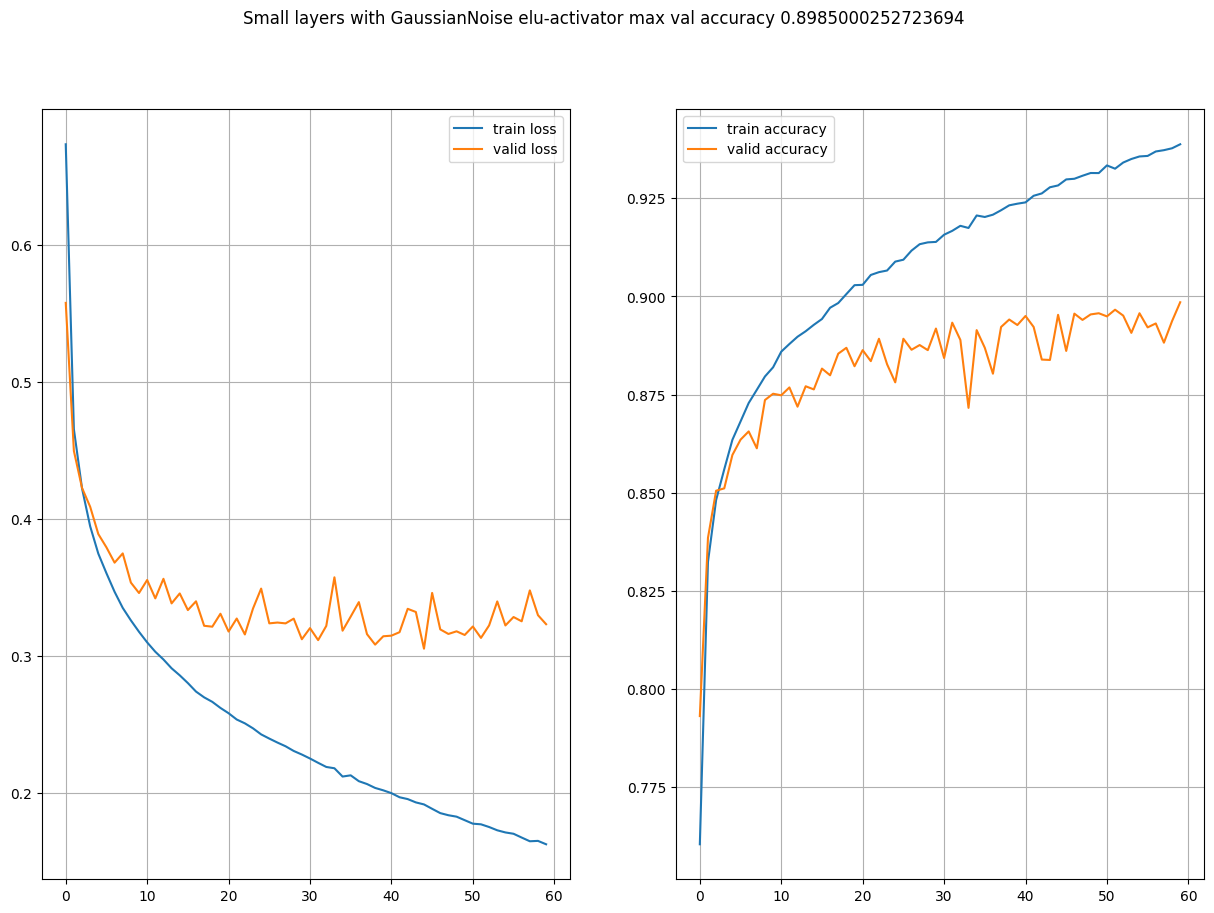

In [42]:

momentums = [1]
idx = 80

for momentum in momentums:
    small_layers_GN = [
        Dense(128, activation="relu", input_shape=(28*28,)),
        GaussianNoise(0.2),
        Dense(512, activation="sigmoid"),
        GaussianNoise(.2),
        Dense(10, activation="softmax"),
    ]

    small_model_GN = create_model_2(small_layers_GN, RMSprop(learning_rate=.0005, rho=.95))
    history = fit_and_present_2(small_model_GN, def_ds, val_dataset, description=f"Small layers with GaussianNoise elu-activator", filepath=f"small_la_gn_cp_{idx}", patience=15)

    idx+=1

Ми віримо в покращення, але його все ще нема. Але ж це не заважає продовжувати експерименти!

Epoch 1/100


465/469 [============================>.] - ETA: 0s - loss: 0.5822 - accuracy: 0.7880 - categorical_crossentropy: 0.5822INFO:tensorflow:Assets written to: small_la_gn_cp_90\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_90\assets


469/469 [==============================] - 5s 9ms/step - loss: 0.5815 - accuracy: 0.7883 - categorical_crossentropy: 0.5815 - val_loss: 0.4641 - val_accuracy: 0.8402 - val_categorical_crossentropy: 0.4641
Epoch 2/100
460/469 [============================>.] - ETA: 0s - loss: 0.4343 - accuracy: 0.8409 - categorical_crossentropy: 0.4343INFO:tensorflow:Assets written to: small_la_gn_cp_90\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_90\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.4341 - accuracy: 0.8410 - categorical_crossentropy: 0.4341 - val_loss: 0.4077 - val_accuracy: 0.8529 - val_categorical_crossentropy: 0.4077
Epoch 3/100
461/469 [============================>.] - ETA: 0s - loss: 0.3918 - accuracy: 0.8566 - categorical_crossentropy: 0.3918INFO:tensorflow:Assets written to: small_la_gn_cp_90\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_90\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3917 - accuracy: 0.8566 - categorical_crossentropy: 0.3917 - val_loss: 0.3811 - val_accuracy: 0.8599 - val_categorical_crossentropy: 0.3811
Epoch 4/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3660 - accuracy: 0.8647 - categorical_crossentropy: 0.3660 - val_loss: 0.4087 - val_accuracy: 0.8491 - val_categorical_crossentropy: 0.4087
Epoch 5/100
461/469 [============================>.] - ETA: 0s - loss: 0.3460 - accuracy: 0.8712 - categorical_crossentropy: 0.3460INFO:tensorflow:Assets written to: small_la_gn_cp_90\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_90\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.3461 - accuracy: 0.8710 - categorical_crossentropy: 0.3461 - val_loss: 0.3671 - val_accuracy: 0.8646 - val_categorical_crossentropy: 0.3671
Epoch 6/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3295 - accuracy: 0.8769 - categorical_crossentropy: 0.3295 - val_loss: 0.3653 - val_accuracy: 0.8642 - val_categorical_crossentropy: 0.3653
Epoch 7/100
465/469 [============================>.] - ETA: 0s - loss: 0.3182 - accuracy: 0.8812 - categorical_crossentropy: 0.3182INFO:tensorflow:Assets written to: small_la_gn_cp_90\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_90\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.3180 - accuracy: 0.8813 - categorical_crossentropy: 0.3180 - val_loss: 0.3694 - val_accuracy: 0.8662 - val_categorical_crossentropy: 0.3694
Epoch 8/100
460/469 [============================>.] - ETA: 0s - loss: 0.3088 - accuracy: 0.8852 - categorical_crossentropy: 0.3088INFO:tensorflow:Assets written to: small_la_gn_cp_90\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_90\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.3084 - accuracy: 0.8855 - categorical_crossentropy: 0.3084 - val_loss: 0.3409 - val_accuracy: 0.8766 - val_categorical_crossentropy: 0.3409
Epoch 9/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2976 - accuracy: 0.8900 - categorical_crossentropy: 0.2976 - val_loss: 0.3477 - val_accuracy: 0.8759 - val_categorical_crossentropy: 0.3477
Epoch 10/100
457/469 [============================>.] - ETA: 0s - loss: 0.2884 - accuracy: 0.8915 - categorical_crossentropy: 0.2884INFO:tensorflow:Assets written to: small_la_gn_cp_90\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_90\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2887 - accuracy: 0.8916 - categorical_crossentropy: 0.2887 - val_loss: 0.3339 - val_accuracy: 0.8801 - val_categorical_crossentropy: 0.3339
Epoch 11/100
464/469 [============================>.] - ETA: 0s - loss: 0.2833 - accuracy: 0.8936 - categorical_crossentropy: 0.2833INFO:tensorflow:Assets written to: small_la_gn_cp_90\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_90\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2829 - accuracy: 0.8936 - categorical_crossentropy: 0.2829 - val_loss: 0.3274 - val_accuracy: 0.8804 - val_categorical_crossentropy: 0.3274
Epoch 12/100
464/469 [============================>.] - ETA: 0s - loss: 0.2760 - accuracy: 0.8959 - categorical_crossentropy: 0.2760INFO:tensorflow:Assets written to: small_la_gn_cp_90\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_90\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2761 - accuracy: 0.8959 - categorical_crossentropy: 0.2761 - val_loss: 0.3255 - val_accuracy: 0.8849 - val_categorical_crossentropy: 0.3255
Epoch 13/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2683 - accuracy: 0.8991 - categorical_crossentropy: 0.2683 - val_loss: 0.3246 - val_accuracy: 0.8826 - val_categorical_crossentropy: 0.3246
Epoch 14/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2627 - accuracy: 0.8997 - categorical_crossentropy: 0.2627 - val_loss: 0.3333 - val_accuracy: 0.8794 - val_categorical_crossentropy: 0.3333
Epoch 15/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2580 - accuracy: 0.9027 - categorical_crossentropy: 0.2580 - val_loss: 0.3269 - val_accuracy: 0.8821 - val_categorical_crossentropy: 0.3269
Epoch 16/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2511 - accuracy: 0.9050 - categorical_crossentropy: 0.2511 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_90\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.2466 - accuracy: 0.9074 - categorical_crossentropy: 0.2466 - val_loss: 0.3178 - val_accuracy: 0.8862 - val_categorical_crossentropy: 0.3178
Epoch 18/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2402 - accuracy: 0.9092 - categorical_crossentropy: 0.2402 - val_loss: 0.3270 - val_accuracy: 0.8834 - val_categorical_crossentropy: 0.3270
Epoch 19/100
461/469 [============================>.] - ETA: 0s - loss: 0.2380 - accuracy: 0.9105 - categorical_crossentropy: 0.2380INFO:tensorflow:Assets written to: small_la_gn_cp_90\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_90\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2374 - accuracy: 0.9106 - categorical_crossentropy: 0.2374 - val_loss: 0.3122 - val_accuracy: 0.8898 - val_categorical_crossentropy: 0.3122
Epoch 20/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2314 - accuracy: 0.9130 - categorical_crossentropy: 0.2314 - val_loss: 0.3409 - val_accuracy: 0.8784 - val_categorical_crossentropy: 0.3409
Epoch 21/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2288 - accuracy: 0.9134 - categorical_crossentropy: 0.2288 - val_loss: 0.3149 - val_accuracy: 0.8892 - val_categorical_crossentropy: 0.3149
Epoch 22/100
466/469 [============================>.] - ETA: 0s - loss: 0.2250 - accuracy: 0.9145 - categorical_crossentropy: 0.2250INFO:tensorflow:Assets written to: small_la_gn_cp_90\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_90\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2248 - accuracy: 0.9145 - categorical_crossentropy: 0.2248 - val_loss: 0.3114 - val_accuracy: 0.8904 - val_categorical_crossentropy: 0.3114
Epoch 23/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2188 - accuracy: 0.9165 - categorical_crossentropy: 0.2188 - val_loss: 0.3142 - val_accuracy: 0.8898 - val_categorical_crossentropy: 0.3142
Epoch 24/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2157 - accuracy: 0.9193 - categorical_crossentropy: 0.2157 - val_loss: 0.3363 - val_accuracy: 0.8872 - val_categorical_crossentropy: 0.3363
Epoch 25/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2105 - accuracy: 0.9203 - categorical_crossentropy: 0.2105 - val_loss: 0.3190 - val_accuracy: 0.8878 - val_categorical_crossentropy: 0.3190
Epoch 26/100
464/469 [============================>.] - ETA: 0s - loss: 0.2087 - accuracy: 0.9213 - categorical_crossentropy: 0.2087INFO:tens

INFO:tensorflow:Assets written to: small_la_gn_cp_90\assets


469/469 [==============================] - 4s 8ms/step - loss: 0.2087 - accuracy: 0.9213 - categorical_crossentropy: 0.2087 - val_loss: 0.3149 - val_accuracy: 0.8930 - val_categorical_crossentropy: 0.3149
Epoch 27/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2053 - accuracy: 0.9228 - categorical_crossentropy: 0.2053 - val_loss: 0.3132 - val_accuracy: 0.8921 - val_categorical_crossentropy: 0.3132
Epoch 28/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1994 - accuracy: 0.9243 - categorical_crossentropy: 0.1994 - val_loss: 0.3169 - val_accuracy: 0.8922 - val_categorical_crossentropy: 0.3169
Epoch 29/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1967 - accuracy: 0.9249 - categorical_crossentropy: 0.1967 - val_loss: 0.3304 - val_accuracy: 0.8896 - val_categorical_crossentropy: 0.3304
Epoch 30/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1946 - accuracy: 0.9264 - categorical_crossentropy: 0.1946 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_90\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.1882 - accuracy: 0.9271 - categorical_crossentropy: 0.1882 - val_loss: 0.3046 - val_accuracy: 0.8965 - val_categorical_crossentropy: 0.3046
Epoch 33/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1836 - accuracy: 0.9299 - categorical_crossentropy: 0.1836 - val_loss: 0.3244 - val_accuracy: 0.8911 - val_categorical_crossentropy: 0.3244
Epoch 34/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1807 - accuracy: 0.9321 - categorical_crossentropy: 0.1807 - val_loss: 0.3180 - val_accuracy: 0.8920 - val_categorical_crossentropy: 0.3180
Epoch 35/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1799 - accuracy: 0.9318 - categorical_crossentropy: 0.1799 - val_loss: 0.3141 - val_accuracy: 0.8959 - val_categorical_crossentropy: 0.3141
Epoch 36/100
466/469 [============================>.] - ETA: 0s - loss: 0.1765 - accuracy: 0.9325 - categorical_crossentropy: 0.1765INFO:tens

INFO:tensorflow:Assets written to: small_la_gn_cp_90\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.1765 - accuracy: 0.9324 - categorical_crossentropy: 0.1765 - val_loss: 0.3056 - val_accuracy: 0.8975 - val_categorical_crossentropy: 0.3056
Epoch 37/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1706 - accuracy: 0.9355 - categorical_crossentropy: 0.1706 - val_loss: 0.3476 - val_accuracy: 0.8813 - val_categorical_crossentropy: 0.3476
Epoch 38/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1677 - accuracy: 0.9368 - categorical_crossentropy: 0.1677 - val_loss: 0.3279 - val_accuracy: 0.8905 - val_categorical_crossentropy: 0.3279
Epoch 39/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1663 - accuracy: 0.9374 - categorical_crossentropy: 0.1663 - val_loss: 0.3428 - val_accuracy: 0.8891 - val_categorical_crossentropy: 0.3428
Epoch 40/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1624 - accuracy: 0.9391 - categorical_crossentropy: 0.1624 - va

INFO:tensorflow:Assets written to: small_la_gn_cp_90\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.1593 - accuracy: 0.9399 - categorical_crossentropy: 0.1593 - val_loss: 0.3144 - val_accuracy: 0.8987 - val_categorical_crossentropy: 0.3144
Epoch 42/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1551 - accuracy: 0.9410 - categorical_crossentropy: 0.1551 - val_loss: 0.3167 - val_accuracy: 0.8977 - val_categorical_crossentropy: 0.3167
Epoch 43/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1553 - accuracy: 0.9407 - categorical_crossentropy: 0.1553 - val_loss: 0.3192 - val_accuracy: 0.8954 - val_categorical_crossentropy: 0.3192
Epoch 44/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1520 - accuracy: 0.9424 - categorical_crossentropy: 0.1520 - val_loss: 0.3219 - val_accuracy: 0.8958 - val_categorical_crossentropy: 0.3219
Epoch 45/100
465/469 [============================>.] - ETA: 0s - loss: 0.1489 - accuracy: 0.9436 - categorical_crossentropy: 0.1489INFO:tens

INFO:tensorflow:Assets written to: small_la_gn_cp_90\assets


469/469 [==============================] - 4s 9ms/step - loss: 0.1487 - accuracy: 0.9437 - categorical_crossentropy: 0.1487 - val_loss: 0.3267 - val_accuracy: 0.8993 - val_categorical_crossentropy: 0.3267
Epoch 46/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1477 - accuracy: 0.9446 - categorical_crossentropy: 0.1477 - val_loss: 0.3257 - val_accuracy: 0.8971 - val_categorical_crossentropy: 0.3257
Epoch 47/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1459 - accuracy: 0.9446 - categorical_crossentropy: 0.1459 - val_loss: 0.3266 - val_accuracy: 0.8959 - val_categorical_crossentropy: 0.3266


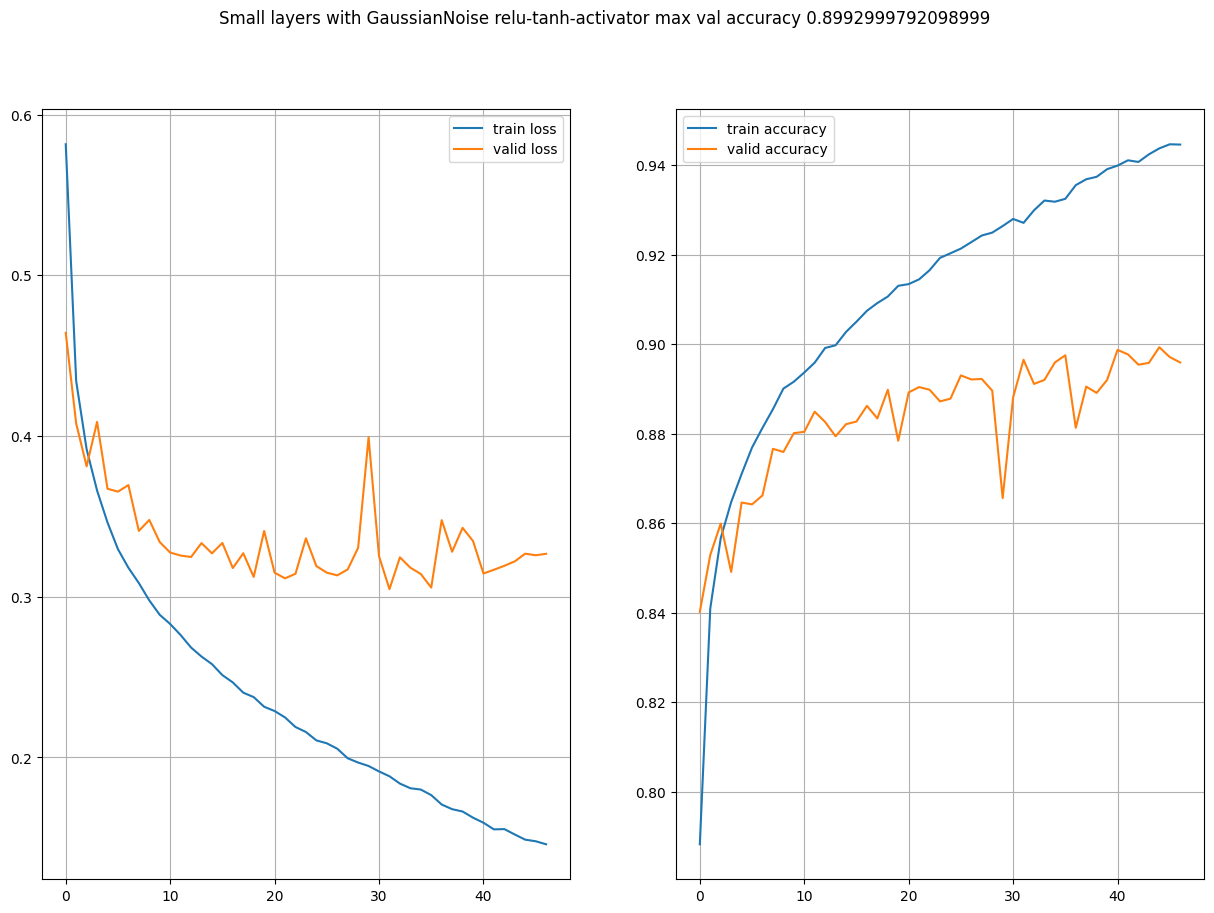

In [43]:

momentums = [1]
idx = 90

for momentum in momentums:
    small_layers_GN = [
        Dense(128, activation="relu", input_shape=(28*28,)),
        GaussianNoise(0.2),
        Dense(512, activation="tanh"),
        GaussianNoise(.2),
        Dense(10, activation="softmax"),
    ]

    small_model_GN = create_model_2(small_layers_GN, RMSprop(learning_rate=.0005, rho=.95))
    history = fit_and_present_2(small_model_GN, def_ds, val_dataset, description=f"Small layers with GaussianNoise relu-tanh-activator", filepath=f"small_la_gn_cp_{idx}", patience=15)

    idx+=1

Знову нема проривів, тож слід якісь параметри переглядати більш радикально

Epoch 1/100
119/120 [============================>.] - ETA: 0s - loss: 0.7407 - accuracy: 0.7475 - categorical_crossentropy: 0.7407INFO:tensorflow:Assets written to: small_la_gn_cp_100\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_100\assets


120/120 [==============================] - 6s 47ms/step - loss: 0.7393 - accuracy: 0.7478 - categorical_crossentropy: 0.7393 - val_loss: 0.6083 - val_accuracy: 0.7922 - val_categorical_crossentropy: 0.6083
Epoch 2/100
119/120 [============================>.] - ETA: 0s - loss: 0.5066 - accuracy: 0.8197 - categorical_crossentropy: 0.5066INFO:tensorflow:Assets written to: small_la_gn_cp_100\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_100\assets


120/120 [==============================] - 5s 41ms/step - loss: 0.5070 - accuracy: 0.8196 - categorical_crossentropy: 0.5070 - val_loss: 0.5508 - val_accuracy: 0.8012 - val_categorical_crossentropy: 0.5508
Epoch 3/100
119/120 [============================>.] - ETA: 0s - loss: 0.4495 - accuracy: 0.8404 - categorical_crossentropy: 0.4495INFO:tensorflow:Assets written to: small_la_gn_cp_100\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_100\assets


120/120 [==============================] - 5s 44ms/step - loss: 0.4495 - accuracy: 0.8402 - categorical_crossentropy: 0.4495 - val_loss: 0.5080 - val_accuracy: 0.8276 - val_categorical_crossentropy: 0.5080
Epoch 4/100
120/120 [==============================] - 4s 36ms/step - loss: 0.4159 - accuracy: 0.8511 - categorical_crossentropy: 0.4159 - val_loss: 0.4884 - val_accuracy: 0.8148 - val_categorical_crossentropy: 0.4884
Epoch 5/100
120/120 [==============================] - ETA: 0s - loss: 0.3893 - accuracy: 0.8608 - categorical_crossentropy: 0.3893INFO:tensorflow:Assets written to: small_la_gn_cp_100\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_100\assets


120/120 [==============================] - 5s 43ms/step - loss: 0.3893 - accuracy: 0.8608 - categorical_crossentropy: 0.3893 - val_loss: 0.3975 - val_accuracy: 0.8596 - val_categorical_crossentropy: 0.3975
Epoch 6/100
120/120 [==============================] - 4s 34ms/step - loss: 0.3729 - accuracy: 0.8652 - categorical_crossentropy: 0.3729 - val_loss: 0.3980 - val_accuracy: 0.8554 - val_categorical_crossentropy: 0.3980
Epoch 7/100
120/120 [==============================] - ETA: 0s - loss: 0.3546 - accuracy: 0.8708 - categorical_crossentropy: 0.3546INFO:tensorflow:Assets written to: small_la_gn_cp_100\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_100\assets


120/120 [==============================] - 5s 42ms/step - loss: 0.3546 - accuracy: 0.8708 - categorical_crossentropy: 0.3546 - val_loss: 0.3742 - val_accuracy: 0.8637 - val_categorical_crossentropy: 0.3742
Epoch 8/100
120/120 [==============================] - 4s 35ms/step - loss: 0.3435 - accuracy: 0.8741 - categorical_crossentropy: 0.3435 - val_loss: 0.3784 - val_accuracy: 0.8613 - val_categorical_crossentropy: 0.3784
Epoch 9/100
120/120 [==============================] - 4s 37ms/step - loss: 0.3301 - accuracy: 0.8786 - categorical_crossentropy: 0.3301 - val_loss: 0.3791 - val_accuracy: 0.8590 - val_categorical_crossentropy: 0.3791
Epoch 10/100
120/120 [==============================] - ETA: 0s - loss: 0.3235 - accuracy: 0.8810 - categorical_crossentropy: 0.3235INFO:tensorflow:Assets written to: small_la_gn_cp_100\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_100\assets


120/120 [==============================] - 5s 44ms/step - loss: 0.3235 - accuracy: 0.8810 - categorical_crossentropy: 0.3235 - val_loss: 0.3602 - val_accuracy: 0.8689 - val_categorical_crossentropy: 0.3602
Epoch 11/100
120/120 [==============================] - ETA: 0s - loss: 0.3145 - accuracy: 0.8845 - categorical_crossentropy: 0.3145INFO:tensorflow:Assets written to: small_la_gn_cp_100\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_100\assets


120/120 [==============================] - 5s 41ms/step - loss: 0.3145 - accuracy: 0.8845 - categorical_crossentropy: 0.3145 - val_loss: 0.3415 - val_accuracy: 0.8755 - val_categorical_crossentropy: 0.3415
Epoch 12/100
120/120 [==============================] - ETA: 0s - loss: 0.3058 - accuracy: 0.8880 - categorical_crossentropy: 0.3058INFO:tensorflow:Assets written to: small_la_gn_cp_100\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_100\assets


120/120 [==============================] - 5s 41ms/step - loss: 0.3058 - accuracy: 0.8880 - categorical_crossentropy: 0.3058 - val_loss: 0.3333 - val_accuracy: 0.8806 - val_categorical_crossentropy: 0.3333
Epoch 13/100
120/120 [==============================] - 4s 37ms/step - loss: 0.2991 - accuracy: 0.8897 - categorical_crossentropy: 0.2991 - val_loss: 0.3326 - val_accuracy: 0.8796 - val_categorical_crossentropy: 0.3326
Epoch 14/100
120/120 [==============================] - ETA: 0s - loss: 0.2903 - accuracy: 0.8926 - categorical_crossentropy: 0.2903INFO:tensorflow:Assets written to: small_la_gn_cp_100\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_100\assets


120/120 [==============================] - 5s 42ms/step - loss: 0.2903 - accuracy: 0.8926 - categorical_crossentropy: 0.2903 - val_loss: 0.3287 - val_accuracy: 0.8809 - val_categorical_crossentropy: 0.3287
Epoch 15/100
119/120 [============================>.] - ETA: 0s - loss: 0.2868 - accuracy: 0.8948 - categorical_crossentropy: 0.2868INFO:tensorflow:Assets written to: small_la_gn_cp_100\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_100\assets


120/120 [==============================] - 5s 43ms/step - loss: 0.2870 - accuracy: 0.8947 - categorical_crossentropy: 0.2870 - val_loss: 0.3240 - val_accuracy: 0.8849 - val_categorical_crossentropy: 0.3240
Epoch 16/100
120/120 [==============================] - 4s 35ms/step - loss: 0.2799 - accuracy: 0.8971 - categorical_crossentropy: 0.2799 - val_loss: 0.3359 - val_accuracy: 0.8798 - val_categorical_crossentropy: 0.3359
Epoch 17/100
120/120 [==============================] - 4s 35ms/step - loss: 0.2775 - accuracy: 0.8967 - categorical_crossentropy: 0.2775 - val_loss: 0.3339 - val_accuracy: 0.8813 - val_categorical_crossentropy: 0.3339
Epoch 18/100
120/120 [==============================] - 4s 37ms/step - loss: 0.2712 - accuracy: 0.8998 - categorical_crossentropy: 0.2712 - val_loss: 0.3361 - val_accuracy: 0.8780 - val_categorical_crossentropy: 0.3361
Epoch 19/100
120/120 [==============================] - 4s 35ms/step - loss: 0.2672 - accuracy: 0.9010 - categorical_crossentropy: 0.2672

INFO:tensorflow:Assets written to: small_la_gn_cp_100\assets


120/120 [==============================] - 5s 42ms/step - loss: 0.2612 - accuracy: 0.9034 - categorical_crossentropy: 0.2612 - val_loss: 0.3179 - val_accuracy: 0.8852 - val_categorical_crossentropy: 0.3179
Epoch 21/100
120/120 [==============================] - 4s 34ms/step - loss: 0.2572 - accuracy: 0.9047 - categorical_crossentropy: 0.2572 - val_loss: 0.3321 - val_accuracy: 0.8789 - val_categorical_crossentropy: 0.3321
Epoch 22/100
120/120 [==============================] - ETA: 0s - loss: 0.2519 - accuracy: 0.9075 - categorical_crossentropy: 0.2519INFO:tensorflow:Assets written to: small_la_gn_cp_100\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_100\assets


120/120 [==============================] - 5s 42ms/step - loss: 0.2519 - accuracy: 0.9075 - categorical_crossentropy: 0.2519 - val_loss: 0.3174 - val_accuracy: 0.8862 - val_categorical_crossentropy: 0.3174
Epoch 23/100
119/120 [============================>.] - ETA: 0s - loss: 0.2488 - accuracy: 0.9076 - categorical_crossentropy: 0.2488INFO:tensorflow:Assets written to: small_la_gn_cp_100\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_100\assets


120/120 [==============================] - 5s 40ms/step - loss: 0.2487 - accuracy: 0.9076 - categorical_crossentropy: 0.2487 - val_loss: 0.3156 - val_accuracy: 0.8876 - val_categorical_crossentropy: 0.3156
Epoch 24/100
120/120 [==============================] - 4s 34ms/step - loss: 0.2454 - accuracy: 0.9083 - categorical_crossentropy: 0.2454 - val_loss: 0.3106 - val_accuracy: 0.8843 - val_categorical_crossentropy: 0.3106
Epoch 25/100
120/120 [==============================] - ETA: 0s - loss: 0.2416 - accuracy: 0.9107 - categorical_crossentropy: 0.2416INFO:tensorflow:Assets written to: small_la_gn_cp_100\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_100\assets


120/120 [==============================] - 5s 44ms/step - loss: 0.2416 - accuracy: 0.9107 - categorical_crossentropy: 0.2416 - val_loss: 0.3165 - val_accuracy: 0.8879 - val_categorical_crossentropy: 0.3165
Epoch 26/100
119/120 [============================>.] - ETA: 0s - loss: 0.2383 - accuracy: 0.9113 - categorical_crossentropy: 0.2383INFO:tensorflow:Assets written to: small_la_gn_cp_100\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_100\assets


120/120 [==============================] - 5s 41ms/step - loss: 0.2386 - accuracy: 0.9112 - categorical_crossentropy: 0.2386 - val_loss: 0.3049 - val_accuracy: 0.8914 - val_categorical_crossentropy: 0.3049
Epoch 27/100
119/120 [============================>.] - ETA: 0s - loss: 0.2356 - accuracy: 0.9117 - categorical_crossentropy: 0.2356INFO:tensorflow:Assets written to: small_la_gn_cp_100\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_100\assets


120/120 [==============================] - 5s 42ms/step - loss: 0.2352 - accuracy: 0.9120 - categorical_crossentropy: 0.2352 - val_loss: 0.3061 - val_accuracy: 0.8923 - val_categorical_crossentropy: 0.3061
Epoch 28/100
120/120 [==============================] - 4s 36ms/step - loss: 0.2312 - accuracy: 0.9145 - categorical_crossentropy: 0.2312 - val_loss: 0.3103 - val_accuracy: 0.8894 - val_categorical_crossentropy: 0.3103
Epoch 29/100
120/120 [==============================] - 4s 35ms/step - loss: 0.2288 - accuracy: 0.9157 - categorical_crossentropy: 0.2288 - val_loss: 0.3029 - val_accuracy: 0.8918 - val_categorical_crossentropy: 0.3029
Epoch 30/100
120/120 [==============================] - 5s 37ms/step - loss: 0.2250 - accuracy: 0.9162 - categorical_crossentropy: 0.2250 - val_loss: 0.3296 - val_accuracy: 0.8831 - val_categorical_crossentropy: 0.3296
Epoch 31/100
120/120 [==============================] - 4s 35ms/step - loss: 0.2205 - accuracy: 0.9183 - categorical_crossentropy: 0.2205

INFO:tensorflow:Assets written to: small_la_gn_cp_100\assets


120/120 [==============================] - 6s 47ms/step - loss: 0.2171 - accuracy: 0.9194 - categorical_crossentropy: 0.2171 - val_loss: 0.2978 - val_accuracy: 0.8976 - val_categorical_crossentropy: 0.2978
Epoch 34/100
120/120 [==============================] - 4s 34ms/step - loss: 0.2112 - accuracy: 0.9217 - categorical_crossentropy: 0.2112 - val_loss: 0.3063 - val_accuracy: 0.8933 - val_categorical_crossentropy: 0.3063
Epoch 35/100
120/120 [==============================] - 4s 36ms/step - loss: 0.2109 - accuracy: 0.9222 - categorical_crossentropy: 0.2109 - val_loss: 0.3128 - val_accuracy: 0.8892 - val_categorical_crossentropy: 0.3128
Epoch 36/100
120/120 [==============================] - 4s 35ms/step - loss: 0.2076 - accuracy: 0.9231 - categorical_crossentropy: 0.2076 - val_loss: 0.3055 - val_accuracy: 0.8920 - val_categorical_crossentropy: 0.3055
Epoch 37/100
120/120 [==============================] - ETA: 0s - loss: 0.2069 - accuracy: 0.9225 - categorical_crossentropy: 0.2069INFO:

INFO:tensorflow:Assets written to: small_la_gn_cp_100\assets


120/120 [==============================] - 5s 44ms/step - loss: 0.2069 - accuracy: 0.9225 - categorical_crossentropy: 0.2069 - val_loss: 0.2984 - val_accuracy: 0.8985 - val_categorical_crossentropy: 0.2984
Epoch 38/100
120/120 [==============================] - 4s 35ms/step - loss: 0.2038 - accuracy: 0.9233 - categorical_crossentropy: 0.2038 - val_loss: 0.3032 - val_accuracy: 0.8960 - val_categorical_crossentropy: 0.3032
Epoch 39/100
120/120 [==============================] - 5s 37ms/step - loss: 0.1996 - accuracy: 0.9255 - categorical_crossentropy: 0.1996 - val_loss: 0.3021 - val_accuracy: 0.8955 - val_categorical_crossentropy: 0.3021
Epoch 40/100
120/120 [==============================] - 4s 36ms/step - loss: 0.1986 - accuracy: 0.9256 - categorical_crossentropy: 0.1986 - val_loss: 0.3216 - val_accuracy: 0.8855 - val_categorical_crossentropy: 0.3216
Epoch 41/100
120/120 [==============================] - 4s 36ms/step - loss: 0.1963 - accuracy: 0.9256 - categorical_crossentropy: 0.1963

INFO:tensorflow:Assets written to: small_la_gn_cp_100\assets


120/120 [==============================] - 6s 48ms/step - loss: 0.1798 - accuracy: 0.9326 - categorical_crossentropy: 0.1798 - val_loss: 0.3006 - val_accuracy: 0.8991 - val_categorical_crossentropy: 0.3006
Epoch 49/100
120/120 [==============================] - 4s 37ms/step - loss: 0.1810 - accuracy: 0.9329 - categorical_crossentropy: 0.1810 - val_loss: 0.3152 - val_accuracy: 0.8930 - val_categorical_crossentropy: 0.3152
Epoch 50/100
120/120 [==============================] - 4s 36ms/step - loss: 0.1791 - accuracy: 0.9329 - categorical_crossentropy: 0.1791 - val_loss: 0.3056 - val_accuracy: 0.8962 - val_categorical_crossentropy: 0.3056
Epoch 51/100
120/120 [==============================] - 4s 37ms/step - loss: 0.1759 - accuracy: 0.9338 - categorical_crossentropy: 0.1759 - val_loss: 0.3009 - val_accuracy: 0.8974 - val_categorical_crossentropy: 0.3009
Epoch 52/100
120/120 [==============================] - 5s 37ms/step - loss: 0.1758 - accuracy: 0.9344 - categorical_crossentropy: 0.1758

INFO:tensorflow:Assets written to: small_la_gn_cp_100\assets


120/120 [==============================] - 6s 47ms/step - loss: 0.1670 - accuracy: 0.9378 - categorical_crossentropy: 0.1670 - val_loss: 0.3008 - val_accuracy: 0.8999 - val_categorical_crossentropy: 0.3008
Epoch 57/100
120/120 [==============================] - 4s 36ms/step - loss: 0.1656 - accuracy: 0.9378 - categorical_crossentropy: 0.1656 - val_loss: 0.3355 - val_accuracy: 0.8881 - val_categorical_crossentropy: 0.3355
Epoch 58/100
120/120 [==============================] - 4s 36ms/step - loss: 0.1645 - accuracy: 0.9387 - categorical_crossentropy: 0.1645 - val_loss: 0.3043 - val_accuracy: 0.8991 - val_categorical_crossentropy: 0.3043
Epoch 59/100
120/120 [==============================] - 5s 38ms/step - loss: 0.1615 - accuracy: 0.9385 - categorical_crossentropy: 0.1615 - val_loss: 0.3058 - val_accuracy: 0.8978 - val_categorical_crossentropy: 0.3058
Epoch 60/100
120/120 [==============================] - 5s 38ms/step - loss: 0.1600 - accuracy: 0.9398 - categorical_crossentropy: 0.1600

INFO:tensorflow:Assets written to: small_la_gn_cp_100\assets


120/120 [==============================] - 6s 46ms/step - loss: 0.1558 - accuracy: 0.9415 - categorical_crossentropy: 0.1558 - val_loss: 0.3110 - val_accuracy: 0.9004 - val_categorical_crossentropy: 0.3110


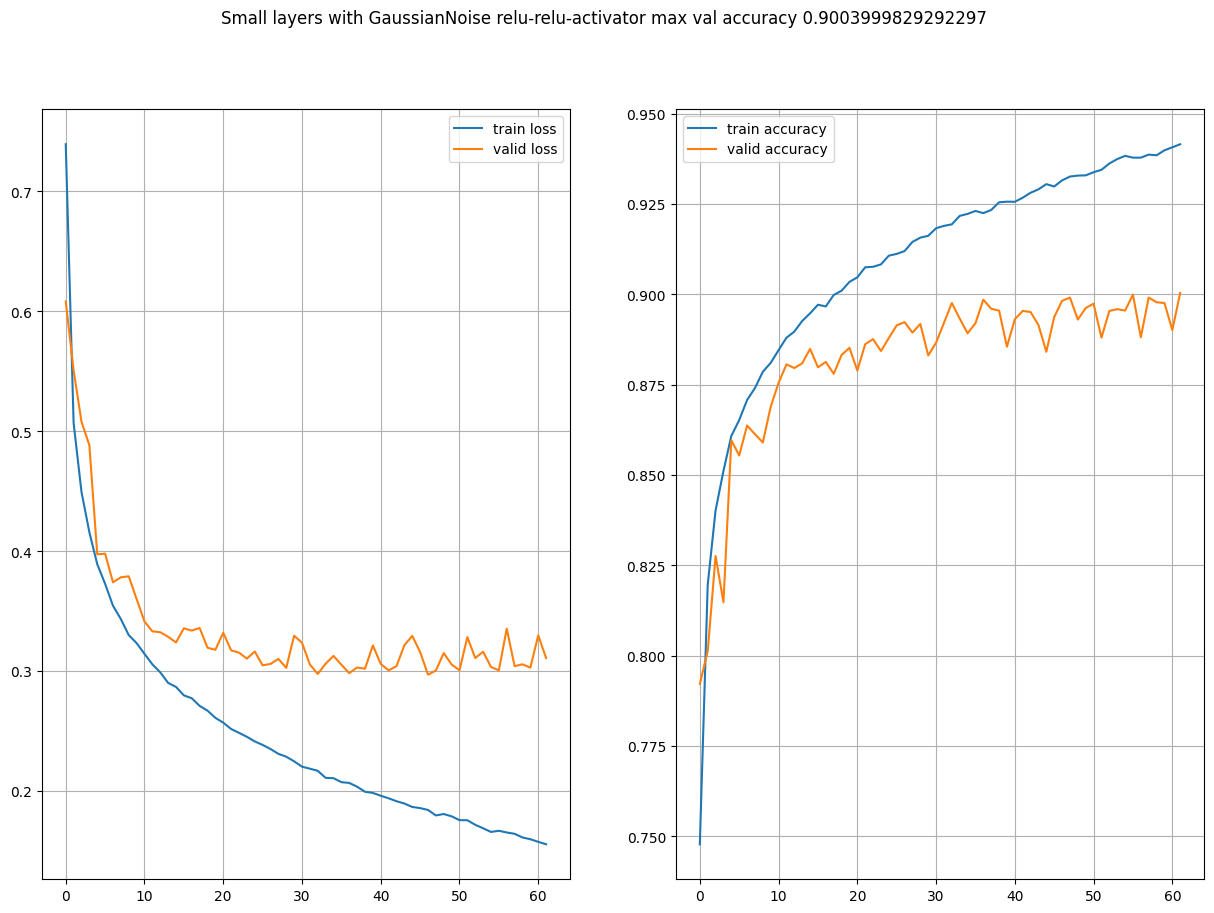

In [44]:

momentums = [1]
idx = 100

for momentum in momentums:
    small_layers_GN = [
        Dense(1024, activation="relu", input_shape=(28*28,)),
        GaussianNoise(0.2),
        #Dense(1024, activation="relu"),
        #GaussianNoise(.2),
        Dense(10, activation="softmax"),
    ]

    ds = MyDataset(train_X, train_Y, batch_size=500)
    small_model_GN = create_model_2(small_layers_GN, RMSprop(learning_rate=.0005, rho=.95))
    history = fit_and_present_2(small_model_GN, ds, val_dataset, description=f"Small layers with GaussianNoise relu-relu-activator", filepath=f"small_la_gn_cp_{idx}", patience=15)

    idx+=1

А оце вже було несподівано: нейромережа на 1 прихований шар з точністю 90+ відсотків.

Ок, пограємось тільки з кількістю нейронів

Epoch 1/100
119/120 [============================>.] - ETA: 0s - loss: 0.8201 - accuracy: 0.7120 - categorical_crossentropy: 0.8201INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


120/120 [==============================] - 3s 25ms/step - loss: 0.8179 - accuracy: 0.7129 - categorical_crossentropy: 0.8179 - val_loss: 0.5632 - val_accuracy: 0.8087 - val_categorical_crossentropy: 0.5632
Epoch 2/100
115/120 [===========================>..] - ETA: 0s - loss: 0.5703 - accuracy: 0.7988 - categorical_crossentropy: 0.5703INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


120/120 [==============================] - 3s 22ms/step - loss: 0.5677 - accuracy: 0.7996 - categorical_crossentropy: 0.5677 - val_loss: 0.5165 - val_accuracy: 0.8215 - val_categorical_crossentropy: 0.5165
Epoch 3/100
120/120 [==============================] - 2s 15ms/step - loss: 0.5086 - accuracy: 0.8191 - categorical_crossentropy: 0.5086 - val_loss: 0.5403 - val_accuracy: 0.7981 - val_categorical_crossentropy: 0.5403
Epoch 4/100
115/120 [===========================>..] - ETA: 0s - loss: 0.4740 - accuracy: 0.8316 - categorical_crossentropy: 0.4740INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


120/120 [==============================] - 3s 25ms/step - loss: 0.4754 - accuracy: 0.8312 - categorical_crossentropy: 0.4754 - val_loss: 0.4477 - val_accuracy: 0.8440 - val_categorical_crossentropy: 0.4477
Epoch 5/100
120/120 [==============================] - 2s 16ms/step - loss: 0.4509 - accuracy: 0.8407 - categorical_crossentropy: 0.4509 - val_loss: 0.4584 - val_accuracy: 0.8387 - val_categorical_crossentropy: 0.4584
Epoch 6/100
120/120 [==============================] - ETA: 0s - loss: 0.4394 - accuracy: 0.8437 - categorical_crossentropy: 0.4394INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


120/120 [==============================] - 3s 22ms/step - loss: 0.4394 - accuracy: 0.8437 - categorical_crossentropy: 0.4394 - val_loss: 0.4274 - val_accuracy: 0.8484 - val_categorical_crossentropy: 0.4274
Epoch 7/100
120/120 [==============================] - 2s 15ms/step - loss: 0.4227 - accuracy: 0.8487 - categorical_crossentropy: 0.4227 - val_loss: 0.4319 - val_accuracy: 0.8454 - val_categorical_crossentropy: 0.4319
Epoch 8/100
120/120 [==============================] - 2s 15ms/step - loss: 0.4077 - accuracy: 0.8538 - categorical_crossentropy: 0.4077 - val_loss: 0.4326 - val_accuracy: 0.8444 - val_categorical_crossentropy: 0.4326
Epoch 9/100
117/120 [============================>.] - ETA: 0s - loss: 0.3995 - accuracy: 0.8573 - categorical_crossentropy: 0.3995INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


120/120 [==============================] - 3s 21ms/step - loss: 0.3996 - accuracy: 0.8570 - categorical_crossentropy: 0.3996 - val_loss: 0.4032 - val_accuracy: 0.8569 - val_categorical_crossentropy: 0.4032
Epoch 10/100
120/120 [==============================] - 2s 17ms/step - loss: 0.3897 - accuracy: 0.8593 - categorical_crossentropy: 0.3897 - val_loss: 0.4171 - val_accuracy: 0.8530 - val_categorical_crossentropy: 0.4171
Epoch 11/100
120/120 [==============================] - ETA: 0s - loss: 0.3815 - accuracy: 0.8631 - categorical_crossentropy: 0.3815INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


120/120 [==============================] - 3s 21ms/step - loss: 0.3815 - accuracy: 0.8631 - categorical_crossentropy: 0.3815 - val_loss: 0.4024 - val_accuracy: 0.8610 - val_categorical_crossentropy: 0.4024
Epoch 12/100
120/120 [==============================] - 2s 15ms/step - loss: 0.3735 - accuracy: 0.8654 - categorical_crossentropy: 0.3735 - val_loss: 0.3928 - val_accuracy: 0.8602 - val_categorical_crossentropy: 0.3928
Epoch 13/100
119/120 [============================>.] - ETA: 0s - loss: 0.3672 - accuracy: 0.8669 - categorical_crossentropy: 0.3672INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


120/120 [==============================] - 3s 23ms/step - loss: 0.3675 - accuracy: 0.8668 - categorical_crossentropy: 0.3675 - val_loss: 0.3755 - val_accuracy: 0.8664 - val_categorical_crossentropy: 0.3755
Epoch 14/100
120/120 [==============================] - ETA: 0s - loss: 0.3590 - accuracy: 0.8694 - categorical_crossentropy: 0.3590INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


120/120 [==============================] - 3s 21ms/step - loss: 0.3590 - accuracy: 0.8694 - categorical_crossentropy: 0.3590 - val_loss: 0.3737 - val_accuracy: 0.8671 - val_categorical_crossentropy: 0.3737
Epoch 15/100
120/120 [==============================] - 2s 15ms/step - loss: 0.3532 - accuracy: 0.8734 - categorical_crossentropy: 0.3532 - val_loss: 0.3744 - val_accuracy: 0.8649 - val_categorical_crossentropy: 0.3744
Epoch 16/100
120/120 [==============================] - 2s 16ms/step - loss: 0.3484 - accuracy: 0.8737 - categorical_crossentropy: 0.3484 - val_loss: 0.3737 - val_accuracy: 0.8657 - val_categorical_crossentropy: 0.3737
Epoch 17/100
116/120 [============================>.] - ETA: 0s - loss: 0.3423 - accuracy: 0.8742 - categorical_crossentropy: 0.3423INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


120/120 [==============================] - 3s 22ms/step - loss: 0.3414 - accuracy: 0.8746 - categorical_crossentropy: 0.3414 - val_loss: 0.3639 - val_accuracy: 0.8696 - val_categorical_crossentropy: 0.3639
Epoch 18/100
120/120 [==============================] - 2s 15ms/step - loss: 0.3420 - accuracy: 0.8764 - categorical_crossentropy: 0.3420 - val_loss: 0.3857 - val_accuracy: 0.8599 - val_categorical_crossentropy: 0.3857
Epoch 19/100
120/120 [==============================] - ETA: 0s - loss: 0.3334 - accuracy: 0.8773 - categorical_crossentropy: 0.3334INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


120/120 [==============================] - 3s 24ms/step - loss: 0.3334 - accuracy: 0.8773 - categorical_crossentropy: 0.3334 - val_loss: 0.3603 - val_accuracy: 0.8698 - val_categorical_crossentropy: 0.3603
Epoch 20/100
119/120 [============================>.] - ETA: 0s - loss: 0.3307 - accuracy: 0.8794 - categorical_crossentropy: 0.3307INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


120/120 [==============================] - 3s 20ms/step - loss: 0.3306 - accuracy: 0.8796 - categorical_crossentropy: 0.3306 - val_loss: 0.3491 - val_accuracy: 0.8752 - val_categorical_crossentropy: 0.3491
Epoch 21/100
120/120 [==============================] - 2s 15ms/step - loss: 0.3265 - accuracy: 0.8812 - categorical_crossentropy: 0.3265 - val_loss: 0.3668 - val_accuracy: 0.8659 - val_categorical_crossentropy: 0.3668
Epoch 22/100
120/120 [==============================] - ETA: 0s - loss: 0.3219 - accuracy: 0.8823 - categorical_crossentropy: 0.3219INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


120/120 [==============================] - 3s 24ms/step - loss: 0.3219 - accuracy: 0.8823 - categorical_crossentropy: 0.3219 - val_loss: 0.3507 - val_accuracy: 0.8758 - val_categorical_crossentropy: 0.3507
Epoch 23/100
118/120 [============================>.] - ETA: 0s - loss: 0.3181 - accuracy: 0.8842 - categorical_crossentropy: 0.3181INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


120/120 [==============================] - 3s 23ms/step - loss: 0.3180 - accuracy: 0.8842 - categorical_crossentropy: 0.3180 - val_loss: 0.3459 - val_accuracy: 0.8764 - val_categorical_crossentropy: 0.3459
Epoch 24/100
120/120 [==============================] - ETA: 0s - loss: 0.3152 - accuracy: 0.8850 - categorical_crossentropy: 0.3152INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


120/120 [==============================] - 3s 21ms/step - loss: 0.3152 - accuracy: 0.8850 - categorical_crossentropy: 0.3152 - val_loss: 0.3416 - val_accuracy: 0.8768 - val_categorical_crossentropy: 0.3416
Epoch 25/100
120/120 [==============================] - 2s 17ms/step - loss: 0.3125 - accuracy: 0.8851 - categorical_crossentropy: 0.3125 - val_loss: 0.3521 - val_accuracy: 0.8741 - val_categorical_crossentropy: 0.3521
Epoch 26/100
120/120 [==============================] - 2s 15ms/step - loss: 0.3098 - accuracy: 0.8863 - categorical_crossentropy: 0.3098 - val_loss: 0.3468 - val_accuracy: 0.8759 - val_categorical_crossentropy: 0.3468
Epoch 27/100
120/120 [==============================] - 2s 16ms/step - loss: 0.3061 - accuracy: 0.8873 - categorical_crossentropy: 0.3061 - val_loss: 0.3424 - val_accuracy: 0.8745 - val_categorical_crossentropy: 0.3424
Epoch 28/100
120/120 [==============================] - 2s 17ms/step - loss: 0.3042 - accuracy: 0.8890 - categorical_crossentropy: 0.3042

INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


120/120 [==============================] - 3s 22ms/step - loss: 0.2931 - accuracy: 0.8910 - categorical_crossentropy: 0.2931 - val_loss: 0.3315 - val_accuracy: 0.8813 - val_categorical_crossentropy: 0.3315
Epoch 33/100
120/120 [==============================] - ETA: 0s - loss: 0.2940 - accuracy: 0.8915 - categorical_crossentropy: 0.2940INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


120/120 [==============================] - 2s 20ms/step - loss: 0.2940 - accuracy: 0.8915 - categorical_crossentropy: 0.2940 - val_loss: 0.3334 - val_accuracy: 0.8814 - val_categorical_crossentropy: 0.3334
Epoch 34/100
120/120 [==============================] - 2s 17ms/step - loss: 0.2888 - accuracy: 0.8937 - categorical_crossentropy: 0.2888 - val_loss: 0.3347 - val_accuracy: 0.8814 - val_categorical_crossentropy: 0.3347
Epoch 35/100
120/120 [==============================] - 2s 15ms/step - loss: 0.2867 - accuracy: 0.8937 - categorical_crossentropy: 0.2867 - val_loss: 0.3398 - val_accuracy: 0.8740 - val_categorical_crossentropy: 0.3398
Epoch 36/100
120/120 [==============================] - 2s 16ms/step - loss: 0.2843 - accuracy: 0.8947 - categorical_crossentropy: 0.2843 - val_loss: 0.3315 - val_accuracy: 0.8810 - val_categorical_crossentropy: 0.3315
Epoch 37/100
120/120 [==============================] - ETA: 0s - loss: 0.2826 - accuracy: 0.8953 - categorical_crossentropy: 0.2826INFO:

INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


120/120 [==============================] - 3s 24ms/step - loss: 0.2826 - accuracy: 0.8953 - categorical_crossentropy: 0.2826 - val_loss: 0.3283 - val_accuracy: 0.8817 - val_categorical_crossentropy: 0.3283
Epoch 38/100
120/120 [==============================] - 2s 15ms/step - loss: 0.2821 - accuracy: 0.8960 - categorical_crossentropy: 0.2821 - val_loss: 0.3273 - val_accuracy: 0.8812 - val_categorical_crossentropy: 0.3273
Epoch 39/100
120/120 [==============================] - 2s 15ms/step - loss: 0.2776 - accuracy: 0.8974 - categorical_crossentropy: 0.2776 - val_loss: 0.3357 - val_accuracy: 0.8789 - val_categorical_crossentropy: 0.3357
Epoch 40/100
120/120 [==============================] - 2s 16ms/step - loss: 0.2760 - accuracy: 0.8975 - categorical_crossentropy: 0.2760 - val_loss: 0.3429 - val_accuracy: 0.8790 - val_categorical_crossentropy: 0.3429
Epoch 41/100
119/120 [============================>.] - ETA: 0s - loss: 0.2737 - accuracy: 0.8996 - categorical_crossentropy: 0.2737INFO:

INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


120/120 [==============================] - 3s 23ms/step - loss: 0.2741 - accuracy: 0.8995 - categorical_crossentropy: 0.2741 - val_loss: 0.3312 - val_accuracy: 0.8837 - val_categorical_crossentropy: 0.3312
Epoch 42/100
120/120 [==============================] - ETA: 0s - loss: 0.2721 - accuracy: 0.8992 - categorical_crossentropy: 0.2721INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


120/120 [==============================] - 2s 20ms/step - loss: 0.2721 - accuracy: 0.8992 - categorical_crossentropy: 0.2721 - val_loss: 0.3236 - val_accuracy: 0.8840 - val_categorical_crossentropy: 0.3236
Epoch 43/100
120/120 [==============================] - ETA: 0s - loss: 0.2708 - accuracy: 0.8992 - categorical_crossentropy: 0.2708INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


120/120 [==============================] - 3s 22ms/step - loss: 0.2708 - accuracy: 0.8992 - categorical_crossentropy: 0.2708 - val_loss: 0.3227 - val_accuracy: 0.8852 - val_categorical_crossentropy: 0.3227
Epoch 44/100
120/120 [==============================] - 2s 15ms/step - loss: 0.2696 - accuracy: 0.8996 - categorical_crossentropy: 0.2696 - val_loss: 0.3246 - val_accuracy: 0.8820 - val_categorical_crossentropy: 0.3246
Epoch 45/100
120/120 [==============================] - 2s 16ms/step - loss: 0.2656 - accuracy: 0.9030 - categorical_crossentropy: 0.2656 - val_loss: 0.3276 - val_accuracy: 0.8802 - val_categorical_crossentropy: 0.3276
Epoch 46/100
120/120 [==============================] - 2s 15ms/step - loss: 0.2661 - accuracy: 0.9003 - categorical_crossentropy: 0.2661 - val_loss: 0.3256 - val_accuracy: 0.8825 - val_categorical_crossentropy: 0.3256
Epoch 47/100
119/120 [============================>.] - ETA: 0s - loss: 0.2634 - accuracy: 0.9025 - categorical_crossentropy: 0.2634INFO:

INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


120/120 [==============================] - 3s 21ms/step - loss: 0.2634 - accuracy: 0.9025 - categorical_crossentropy: 0.2634 - val_loss: 0.3175 - val_accuracy: 0.8868 - val_categorical_crossentropy: 0.3175
Epoch 48/100
120/120 [==============================] - 2s 16ms/step - loss: 0.2620 - accuracy: 0.9031 - categorical_crossentropy: 0.2620 - val_loss: 0.3199 - val_accuracy: 0.8863 - val_categorical_crossentropy: 0.3199
Epoch 49/100
120/120 [==============================] - 2s 15ms/step - loss: 0.2604 - accuracy: 0.9040 - categorical_crossentropy: 0.2604 - val_loss: 0.3205 - val_accuracy: 0.8856 - val_categorical_crossentropy: 0.3205
Epoch 50/100
119/120 [============================>.] - ETA: 0s - loss: 0.2606 - accuracy: 0.9031 - categorical_crossentropy: 0.2606INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


120/120 [==============================] - 3s 21ms/step - loss: 0.2601 - accuracy: 0.9032 - categorical_crossentropy: 0.2601 - val_loss: 0.3166 - val_accuracy: 0.8886 - val_categorical_crossentropy: 0.3166
Epoch 51/100
120/120 [==============================] - 2s 14ms/step - loss: 0.2558 - accuracy: 0.9050 - categorical_crossentropy: 0.2558 - val_loss: 0.3189 - val_accuracy: 0.8875 - val_categorical_crossentropy: 0.3189
Epoch 52/100
120/120 [==============================] - 2s 15ms/step - loss: 0.2559 - accuracy: 0.9044 - categorical_crossentropy: 0.2559 - val_loss: 0.3276 - val_accuracy: 0.8830 - val_categorical_crossentropy: 0.3276
Epoch 53/100
120/120 [==============================] - 2s 14ms/step - loss: 0.2564 - accuracy: 0.9049 - categorical_crossentropy: 0.2564 - val_loss: 0.3182 - val_accuracy: 0.8854 - val_categorical_crossentropy: 0.3182
Epoch 54/100
120/120 [==============================] - 2s 16ms/step - loss: 0.2516 - accuracy: 0.9068 - categorical_crossentropy: 0.2516

INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


120/120 [==============================] - 2s 20ms/step - loss: 0.2503 - accuracy: 0.9064 - categorical_crossentropy: 0.2503 - val_loss: 0.3186 - val_accuracy: 0.8890 - val_categorical_crossentropy: 0.3186
Epoch 57/100
120/120 [==============================] - 2s 16ms/step - loss: 0.2476 - accuracy: 0.9075 - categorical_crossentropy: 0.2476 - val_loss: 0.3184 - val_accuracy: 0.8879 - val_categorical_crossentropy: 0.3184
Epoch 58/100
120/120 [==============================] - 2s 15ms/step - loss: 0.2473 - accuracy: 0.9072 - categorical_crossentropy: 0.2473 - val_loss: 0.3197 - val_accuracy: 0.8859 - val_categorical_crossentropy: 0.3197
Epoch 59/100
120/120 [==============================] - 2s 14ms/step - loss: 0.2446 - accuracy: 0.9095 - categorical_crossentropy: 0.2446 - val_loss: 0.3148 - val_accuracy: 0.8886 - val_categorical_crossentropy: 0.3148
Epoch 60/100
120/120 [==============================] - 2s 16ms/step - loss: 0.2424 - accuracy: 0.9097 - categorical_crossentropy: 0.2424

INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


120/120 [==============================] - 2s 20ms/step - loss: 0.2412 - accuracy: 0.9102 - categorical_crossentropy: 0.2412 - val_loss: 0.3141 - val_accuracy: 0.8901 - val_categorical_crossentropy: 0.3141
Epoch 63/100
120/120 [==============================] - 2s 16ms/step - loss: 0.2399 - accuracy: 0.9107 - categorical_crossentropy: 0.2399 - val_loss: 0.3333 - val_accuracy: 0.8835 - val_categorical_crossentropy: 0.3333
Epoch 64/100
120/120 [==============================] - 2s 15ms/step - loss: 0.2397 - accuracy: 0.9109 - categorical_crossentropy: 0.2397 - val_loss: 0.3180 - val_accuracy: 0.8887 - val_categorical_crossentropy: 0.3180
Epoch 65/100
118/120 [============================>.] - ETA: 0s - loss: 0.2372 - accuracy: 0.9111 - categorical_crossentropy: 0.2372INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


120/120 [==============================] - 3s 23ms/step - loss: 0.2376 - accuracy: 0.9108 - categorical_crossentropy: 0.2376 - val_loss: 0.3173 - val_accuracy: 0.8905 - val_categorical_crossentropy: 0.3173
Epoch 66/100
120/120 [==============================] - 2s 14ms/step - loss: 0.2372 - accuracy: 0.9119 - categorical_crossentropy: 0.2372 - val_loss: 0.3240 - val_accuracy: 0.8838 - val_categorical_crossentropy: 0.3240
Epoch 67/100
120/120 [==============================] - 2s 15ms/step - loss: 0.2357 - accuracy: 0.9111 - categorical_crossentropy: 0.2357 - val_loss: 0.3211 - val_accuracy: 0.8854 - val_categorical_crossentropy: 0.3211
Epoch 68/100
120/120 [==============================] - 2s 16ms/step - loss: 0.2349 - accuracy: 0.9136 - categorical_crossentropy: 0.2349 - val_loss: 0.3271 - val_accuracy: 0.8850 - val_categorical_crossentropy: 0.3271
Epoch 69/100
116/120 [============================>.] - ETA: 0s - loss: 0.2326 - accuracy: 0.9135 - categorical_crossentropy: 0.2326INFO:

INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


120/120 [==============================] - 3s 23ms/step - loss: 0.2328 - accuracy: 0.9135 - categorical_crossentropy: 0.2328 - val_loss: 0.3084 - val_accuracy: 0.8924 - val_categorical_crossentropy: 0.3084
Epoch 70/100
120/120 [==============================] - 2s 14ms/step - loss: 0.2303 - accuracy: 0.9137 - categorical_crossentropy: 0.2303 - val_loss: 0.3247 - val_accuracy: 0.8865 - val_categorical_crossentropy: 0.3247
Epoch 71/100
120/120 [==============================] - 2s 14ms/step - loss: 0.2315 - accuracy: 0.9133 - categorical_crossentropy: 0.2315 - val_loss: 0.3192 - val_accuracy: 0.8896 - val_categorical_crossentropy: 0.3192
Epoch 72/100
120/120 [==============================] - 2s 14ms/step - loss: 0.2297 - accuracy: 0.9137 - categorical_crossentropy: 0.2297 - val_loss: 0.3128 - val_accuracy: 0.8906 - val_categorical_crossentropy: 0.3128
Epoch 73/100
120/120 [==============================] - 2s 15ms/step - loss: 0.2276 - accuracy: 0.9156 - categorical_crossentropy: 0.2276

INFO:tensorflow:Assets written to: small_la_gn_cp_120\assets


120/120 [==============================] - 2s 20ms/step - loss: 0.2225 - accuracy: 0.9173 - categorical_crossentropy: 0.2225 - val_loss: 0.3095 - val_accuracy: 0.8934 - val_categorical_crossentropy: 0.3095
Epoch 79/100
120/120 [==============================] - 2s 14ms/step - loss: 0.2224 - accuracy: 0.9174 - categorical_crossentropy: 0.2224 - val_loss: 0.3193 - val_accuracy: 0.8899 - val_categorical_crossentropy: 0.3193
Epoch 80/100
120/120 [==============================] - 2s 16ms/step - loss: 0.2228 - accuracy: 0.9169 - categorical_crossentropy: 0.2228 - val_loss: 0.3151 - val_accuracy: 0.8901 - val_categorical_crossentropy: 0.3151
Epoch 81/100
120/120 [==============================] - 2s 15ms/step - loss: 0.2201 - accuracy: 0.9185 - categorical_crossentropy: 0.2201 - val_loss: 0.3142 - val_accuracy: 0.8908 - val_categorical_crossentropy: 0.3142
Epoch 82/100
120/120 [==============================] - 2s 15ms/step - loss: 0.2183 - accuracy: 0.9187 - categorical_crossentropy: 0.2183

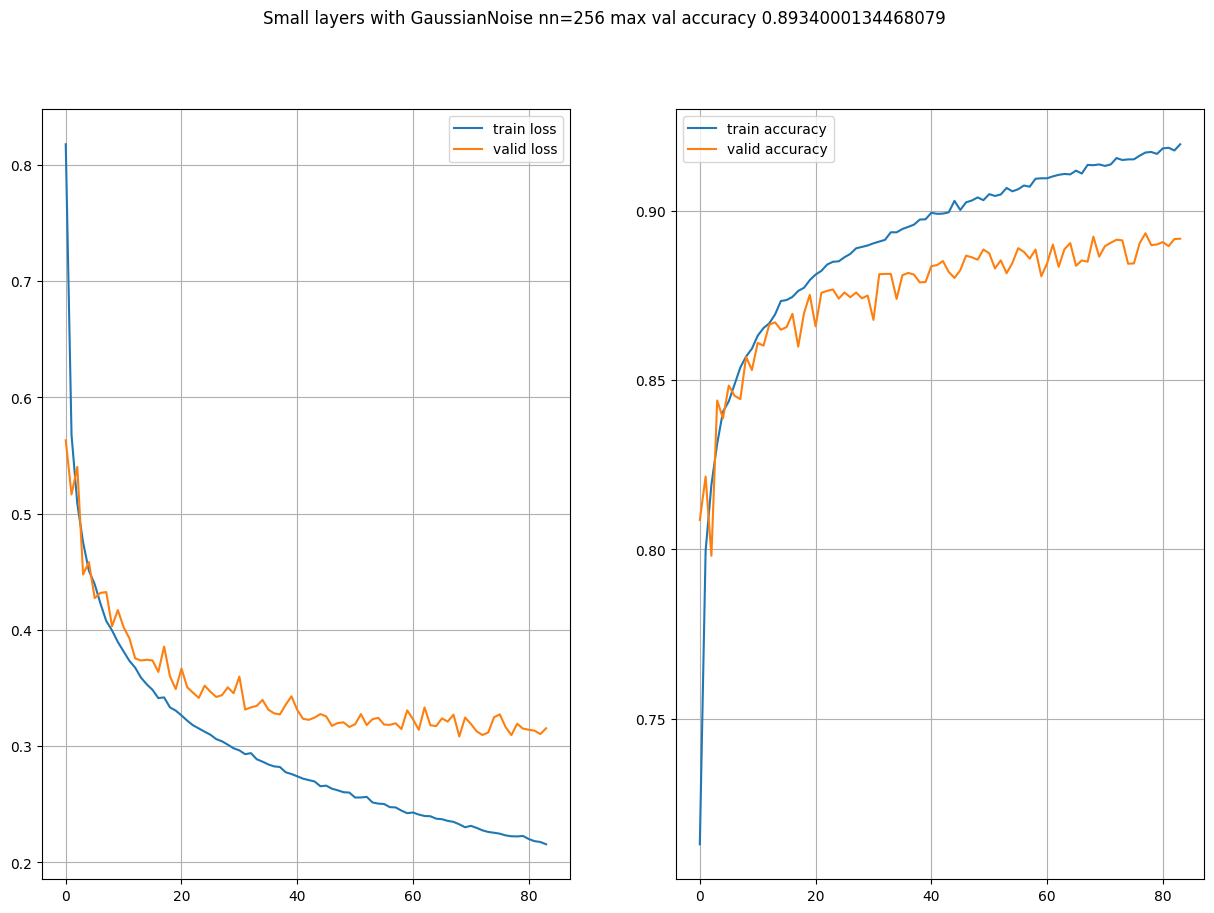

Epoch 1/100
120/120 [==============================] - ETA: 0s - loss: 0.7758 - accuracy: 0.7284 - categorical_crossentropy: 0.7758INFO:tensorflow:Assets written to: small_la_gn_cp_121\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_121\assets


120/120 [==============================] - 6s 46ms/step - loss: 0.7758 - accuracy: 0.7284 - categorical_crossentropy: 0.7758 - val_loss: 0.6668 - val_accuracy: 0.7681 - val_categorical_crossentropy: 0.6668
Epoch 2/100
120/120 [==============================] - ETA: 0s - loss: 0.5380 - accuracy: 0.8100 - categorical_crossentropy: 0.5380INFO:tensorflow:Assets written to: small_la_gn_cp_121\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_121\assets


120/120 [==============================] - 5s 43ms/step - loss: 0.5380 - accuracy: 0.8100 - categorical_crossentropy: 0.5380 - val_loss: 0.4840 - val_accuracy: 0.8286 - val_categorical_crossentropy: 0.4840
Epoch 3/100
119/120 [============================>.] - ETA: 0s - loss: 0.4784 - accuracy: 0.8280 - categorical_crossentropy: 0.4784INFO:tensorflow:Assets written to: small_la_gn_cp_121\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_121\assets


120/120 [==============================] - 5s 43ms/step - loss: 0.4779 - accuracy: 0.8281 - categorical_crossentropy: 0.4779 - val_loss: 0.4317 - val_accuracy: 0.8477 - val_categorical_crossentropy: 0.4317
Epoch 4/100
120/120 [==============================] - 4s 36ms/step - loss: 0.4465 - accuracy: 0.8388 - categorical_crossentropy: 0.4465 - val_loss: 0.4558 - val_accuracy: 0.8380 - val_categorical_crossentropy: 0.4558
Epoch 5/100
120/120 [==============================] - ETA: 0s - loss: 0.4239 - accuracy: 0.8475 - categorical_crossentropy: 0.4239INFO:tensorflow:Assets written to: small_la_gn_cp_121\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_121\assets


120/120 [==============================] - 6s 46ms/step - loss: 0.4239 - accuracy: 0.8475 - categorical_crossentropy: 0.4239 - val_loss: 0.4026 - val_accuracy: 0.8560 - val_categorical_crossentropy: 0.4026
Epoch 6/100
120/120 [==============================] - 4s 36ms/step - loss: 0.4042 - accuracy: 0.8546 - categorical_crossentropy: 0.4042 - val_loss: 0.4089 - val_accuracy: 0.8537 - val_categorical_crossentropy: 0.4089
Epoch 7/100
120/120 [==============================] - ETA: 0s - loss: 0.3872 - accuracy: 0.8604 - categorical_crossentropy: 0.3872INFO:tensorflow:Assets written to: small_la_gn_cp_121\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_121\assets


120/120 [==============================] - 5s 44ms/step - loss: 0.3872 - accuracy: 0.8604 - categorical_crossentropy: 0.3872 - val_loss: 0.3837 - val_accuracy: 0.8639 - val_categorical_crossentropy: 0.3837
Epoch 8/100
120/120 [==============================] - ETA: 0s - loss: 0.3745 - accuracy: 0.8637 - categorical_crossentropy: 0.3745INFO:tensorflow:Assets written to: small_la_gn_cp_121\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_121\assets


120/120 [==============================] - 6s 46ms/step - loss: 0.3745 - accuracy: 0.8637 - categorical_crossentropy: 0.3745 - val_loss: 0.3706 - val_accuracy: 0.8660 - val_categorical_crossentropy: 0.3706
Epoch 9/100
120/120 [==============================] - 4s 35ms/step - loss: 0.3626 - accuracy: 0.8686 - categorical_crossentropy: 0.3626 - val_loss: 0.3866 - val_accuracy: 0.8561 - val_categorical_crossentropy: 0.3866
Epoch 10/100
120/120 [==============================] - 5s 36ms/step - loss: 0.3522 - accuracy: 0.8702 - categorical_crossentropy: 0.3522 - val_loss: 0.4029 - val_accuracy: 0.8520 - val_categorical_crossentropy: 0.4029
Epoch 11/100
120/120 [==============================] - ETA: 0s - loss: 0.3459 - accuracy: 0.8722 - categorical_crossentropy: 0.3459INFO:tensorflow:Assets written to: small_la_gn_cp_121\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_121\assets


120/120 [==============================] - 6s 46ms/step - loss: 0.3459 - accuracy: 0.8722 - categorical_crossentropy: 0.3459 - val_loss: 0.3676 - val_accuracy: 0.8692 - val_categorical_crossentropy: 0.3676
Epoch 12/100
120/120 [==============================] - 4s 36ms/step - loss: 0.3374 - accuracy: 0.8763 - categorical_crossentropy: 0.3374 - val_loss: 0.3769 - val_accuracy: 0.8637 - val_categorical_crossentropy: 0.3769
Epoch 13/100
120/120 [==============================] - ETA: 0s - loss: 0.3318 - accuracy: 0.8778 - categorical_crossentropy: 0.3318INFO:tensorflow:Assets written to: small_la_gn_cp_121\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_121\assets


120/120 [==============================] - 6s 46ms/step - loss: 0.3318 - accuracy: 0.8778 - categorical_crossentropy: 0.3318 - val_loss: 0.3500 - val_accuracy: 0.8746 - val_categorical_crossentropy: 0.3500
Epoch 14/100
120/120 [==============================] - 4s 37ms/step - loss: 0.3255 - accuracy: 0.8804 - categorical_crossentropy: 0.3255 - val_loss: 0.3697 - val_accuracy: 0.8651 - val_categorical_crossentropy: 0.3697
Epoch 15/100
120/120 [==============================] - 4s 36ms/step - loss: 0.3222 - accuracy: 0.8813 - categorical_crossentropy: 0.3222 - val_loss: 0.3527 - val_accuracy: 0.8738 - val_categorical_crossentropy: 0.3527
Epoch 16/100
120/120 [==============================] - 5s 39ms/step - loss: 0.3159 - accuracy: 0.8833 - categorical_crossentropy: 0.3159 - val_loss: 0.3570 - val_accuracy: 0.8711 - val_categorical_crossentropy: 0.3570
Epoch 17/100
120/120 [==============================] - ETA: 0s - loss: 0.3103 - accuracy: 0.8853 - categorical_crossentropy: 0.3103INFO:

INFO:tensorflow:Assets written to: small_la_gn_cp_121\assets


120/120 [==============================] - 6s 46ms/step - loss: 0.3103 - accuracy: 0.8853 - categorical_crossentropy: 0.3103 - val_loss: 0.3331 - val_accuracy: 0.8810 - val_categorical_crossentropy: 0.3331
Epoch 18/100
120/120 [==============================] - 4s 36ms/step - loss: 0.3082 - accuracy: 0.8853 - categorical_crossentropy: 0.3082 - val_loss: 0.3543 - val_accuracy: 0.8733 - val_categorical_crossentropy: 0.3543
Epoch 19/100
120/120 [==============================] - 5s 36ms/step - loss: 0.3018 - accuracy: 0.8880 - categorical_crossentropy: 0.3018 - val_loss: 0.3438 - val_accuracy: 0.8772 - val_categorical_crossentropy: 0.3438
Epoch 20/100
120/120 [==============================] - 5s 38ms/step - loss: 0.2972 - accuracy: 0.8894 - categorical_crossentropy: 0.2972 - val_loss: 0.3303 - val_accuracy: 0.8795 - val_categorical_crossentropy: 0.3303
Epoch 21/100
120/120 [==============================] - 4s 36ms/step - loss: 0.2942 - accuracy: 0.8905 - categorical_crossentropy: 0.2942

INFO:tensorflow:Assets written to: small_la_gn_cp_121\assets


120/120 [==============================] - 6s 48ms/step - loss: 0.2758 - accuracy: 0.8982 - categorical_crossentropy: 0.2758 - val_loss: 0.3320 - val_accuracy: 0.8817 - val_categorical_crossentropy: 0.3320
Epoch 27/100
119/120 [============================>.] - ETA: 0s - loss: 0.2737 - accuracy: 0.8987 - categorical_crossentropy: 0.2737INFO:tensorflow:Assets written to: small_la_gn_cp_121\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_121\assets


120/120 [==============================] - 5s 42ms/step - loss: 0.2735 - accuracy: 0.8987 - categorical_crossentropy: 0.2735 - val_loss: 0.3217 - val_accuracy: 0.8828 - val_categorical_crossentropy: 0.3217
Epoch 28/100
119/120 [============================>.] - ETA: 0s - loss: 0.2721 - accuracy: 0.8989 - categorical_crossentropy: 0.2721INFO:tensorflow:Assets written to: small_la_gn_cp_121\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_121\assets


120/120 [==============================] - 5s 44ms/step - loss: 0.2722 - accuracy: 0.8988 - categorical_crossentropy: 0.2722 - val_loss: 0.3203 - val_accuracy: 0.8873 - val_categorical_crossentropy: 0.3203
Epoch 29/100
120/120 [==============================] - 4s 36ms/step - loss: 0.2694 - accuracy: 0.8997 - categorical_crossentropy: 0.2694 - val_loss: 0.3206 - val_accuracy: 0.8864 - val_categorical_crossentropy: 0.3206
Epoch 30/100
119/120 [============================>.] - ETA: 0s - loss: 0.2660 - accuracy: 0.9005 - categorical_crossentropy: 0.2660INFO:tensorflow:Assets written to: small_la_gn_cp_121\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_121\assets


120/120 [==============================] - 5s 43ms/step - loss: 0.2661 - accuracy: 0.9004 - categorical_crossentropy: 0.2661 - val_loss: 0.3113 - val_accuracy: 0.8898 - val_categorical_crossentropy: 0.3113
Epoch 31/100
120/120 [==============================] - 4s 35ms/step - loss: 0.2632 - accuracy: 0.9028 - categorical_crossentropy: 0.2632 - val_loss: 0.3267 - val_accuracy: 0.8844 - val_categorical_crossentropy: 0.3267
Epoch 32/100
120/120 [==============================] - 4s 37ms/step - loss: 0.2610 - accuracy: 0.9027 - categorical_crossentropy: 0.2610 - val_loss: 0.3159 - val_accuracy: 0.8897 - val_categorical_crossentropy: 0.3159
Epoch 33/100
120/120 [==============================] - 5s 38ms/step - loss: 0.2590 - accuracy: 0.9038 - categorical_crossentropy: 0.2590 - val_loss: 0.3238 - val_accuracy: 0.8873 - val_categorical_crossentropy: 0.3238
Epoch 34/100
120/120 [==============================] - 5s 40ms/step - loss: 0.2601 - accuracy: 0.9026 - categorical_crossentropy: 0.2601

INFO:tensorflow:Assets written to: small_la_gn_cp_121\assets


120/120 [==============================] - 6s 49ms/step - loss: 0.2425 - accuracy: 0.9094 - categorical_crossentropy: 0.2425 - val_loss: 0.3105 - val_accuracy: 0.8916 - val_categorical_crossentropy: 0.3105
Epoch 41/100
120/120 [==============================] - 4s 35ms/step - loss: 0.2410 - accuracy: 0.9107 - categorical_crossentropy: 0.2410 - val_loss: 0.3121 - val_accuracy: 0.8900 - val_categorical_crossentropy: 0.3121
Epoch 42/100
120/120 [==============================] - 5s 38ms/step - loss: 0.2412 - accuracy: 0.9109 - categorical_crossentropy: 0.2412 - val_loss: 0.3282 - val_accuracy: 0.8827 - val_categorical_crossentropy: 0.3282
Epoch 43/100
120/120 [==============================] - 5s 38ms/step - loss: 0.2370 - accuracy: 0.9112 - categorical_crossentropy: 0.2370 - val_loss: 0.3128 - val_accuracy: 0.8903 - val_categorical_crossentropy: 0.3128
Epoch 44/100
120/120 [==============================] - 4s 37ms/step - loss: 0.2357 - accuracy: 0.9123 - categorical_crossentropy: 0.2357

INFO:tensorflow:Assets written to: small_la_gn_cp_121\assets


120/120 [==============================] - 6s 49ms/step - loss: 0.2278 - accuracy: 0.9160 - categorical_crossentropy: 0.2278 - val_loss: 0.3166 - val_accuracy: 0.8918 - val_categorical_crossentropy: 0.3166
Epoch 49/100
120/120 [==============================] - 4s 36ms/step - loss: 0.2281 - accuracy: 0.9153 - categorical_crossentropy: 0.2281 - val_loss: 0.3153 - val_accuracy: 0.8881 - val_categorical_crossentropy: 0.3153
Epoch 50/100
120/120 [==============================] - 4s 36ms/step - loss: 0.2235 - accuracy: 0.9170 - categorical_crossentropy: 0.2235 - val_loss: 0.3118 - val_accuracy: 0.8900 - val_categorical_crossentropy: 0.3118
Epoch 51/100
120/120 [==============================] - 5s 38ms/step - loss: 0.2247 - accuracy: 0.9157 - categorical_crossentropy: 0.2247 - val_loss: 0.3106 - val_accuracy: 0.8911 - val_categorical_crossentropy: 0.3106
Epoch 52/100
119/120 [============================>.] - ETA: 0s - loss: 0.2242 - accuracy: 0.9154 - categorical_crossentropy: 0.2242INFO:

INFO:tensorflow:Assets written to: small_la_gn_cp_121\assets


120/120 [==============================] - 6s 46ms/step - loss: 0.2241 - accuracy: 0.9155 - categorical_crossentropy: 0.2241 - val_loss: 0.3017 - val_accuracy: 0.8953 - val_categorical_crossentropy: 0.3017
Epoch 53/100
120/120 [==============================] - 5s 38ms/step - loss: 0.2208 - accuracy: 0.9177 - categorical_crossentropy: 0.2208 - val_loss: 0.3319 - val_accuracy: 0.8810 - val_categorical_crossentropy: 0.3319
Epoch 54/100
120/120 [==============================] - 4s 36ms/step - loss: 0.2188 - accuracy: 0.9179 - categorical_crossentropy: 0.2188 - val_loss: 0.3135 - val_accuracy: 0.8913 - val_categorical_crossentropy: 0.3135
Epoch 55/100
120/120 [==============================] - 4s 36ms/step - loss: 0.2194 - accuracy: 0.9182 - categorical_crossentropy: 0.2194 - val_loss: 0.3103 - val_accuracy: 0.8911 - val_categorical_crossentropy: 0.3103
Epoch 56/100
120/120 [==============================] - 4s 36ms/step - loss: 0.2142 - accuracy: 0.9199 - categorical_crossentropy: 0.2142

INFO:tensorflow:Assets written to: small_la_gn_cp_121\assets


120/120 [==============================] - 6s 47ms/step - loss: 0.2100 - accuracy: 0.9204 - categorical_crossentropy: 0.2100 - val_loss: 0.3087 - val_accuracy: 0.8964 - val_categorical_crossentropy: 0.3087
Epoch 60/100
120/120 [==============================] - 5s 38ms/step - loss: 0.2115 - accuracy: 0.9209 - categorical_crossentropy: 0.2115 - val_loss: 0.3017 - val_accuracy: 0.8954 - val_categorical_crossentropy: 0.3017
Epoch 61/100
120/120 [==============================] - 4s 37ms/step - loss: 0.2091 - accuracy: 0.9215 - categorical_crossentropy: 0.2091 - val_loss: 0.3040 - val_accuracy: 0.8943 - val_categorical_crossentropy: 0.3040
Epoch 62/100
120/120 [==============================] - 4s 36ms/step - loss: 0.2089 - accuracy: 0.9218 - categorical_crossentropy: 0.2089 - val_loss: 0.3033 - val_accuracy: 0.8945 - val_categorical_crossentropy: 0.3033
Epoch 63/100
120/120 [==============================] - ETA: 0s - loss: 0.2058 - accuracy: 0.9217 - categorical_crossentropy: 0.2058INFO:

INFO:tensorflow:Assets written to: small_la_gn_cp_121\assets


120/120 [==============================] - 6s 45ms/step - loss: 0.2058 - accuracy: 0.9217 - categorical_crossentropy: 0.2058 - val_loss: 0.3051 - val_accuracy: 0.8967 - val_categorical_crossentropy: 0.3051
Epoch 64/100
120/120 [==============================] - 4s 36ms/step - loss: 0.2064 - accuracy: 0.9234 - categorical_crossentropy: 0.2064 - val_loss: 0.3189 - val_accuracy: 0.8916 - val_categorical_crossentropy: 0.3189
Epoch 65/100
120/120 [==============================] - 5s 37ms/step - loss: 0.2041 - accuracy: 0.9228 - categorical_crossentropy: 0.2041 - val_loss: 0.3141 - val_accuracy: 0.8899 - val_categorical_crossentropy: 0.3141
Epoch 66/100
120/120 [==============================] - 5s 38ms/step - loss: 0.2049 - accuracy: 0.9234 - categorical_crossentropy: 0.2049 - val_loss: 0.3259 - val_accuracy: 0.8879 - val_categorical_crossentropy: 0.3259
Epoch 67/100
120/120 [==============================] - 4s 36ms/step - loss: 0.2021 - accuracy: 0.9239 - categorical_crossentropy: 0.2021

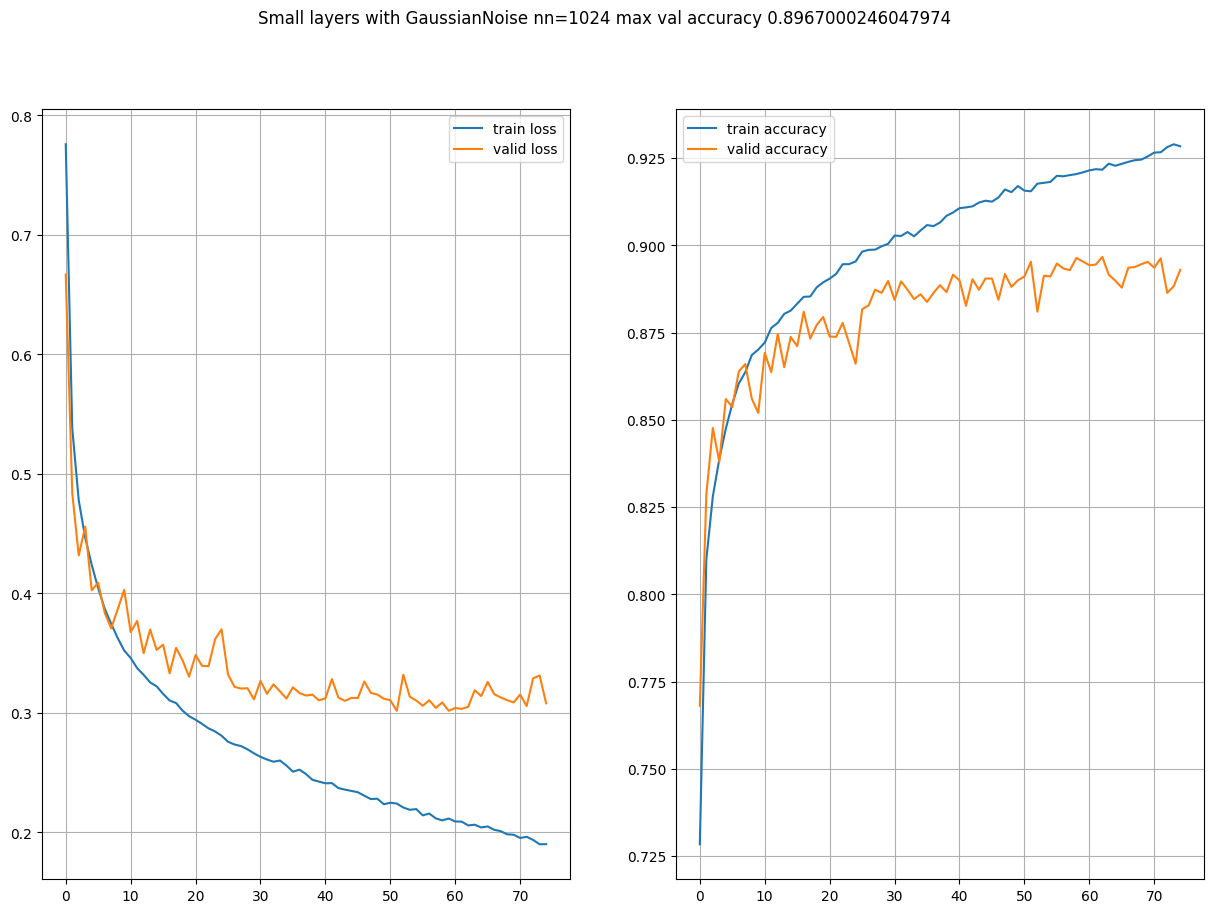

Epoch 1/100
120/120 [==============================] - ETA: 0s - loss: 0.7831 - accuracy: 0.7311 - categorical_crossentropy: 0.7831INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


120/120 [==============================] - 12s 94ms/step - loss: 0.7831 - accuracy: 0.7311 - categorical_crossentropy: 0.7831 - val_loss: 0.5343 - val_accuracy: 0.8149 - val_categorical_crossentropy: 0.5343
Epoch 2/100
120/120 [==============================] - ETA: 0s - loss: 0.5348 - accuracy: 0.8074 - categorical_crossentropy: 0.5348INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


120/120 [==============================] - 11s 88ms/step - loss: 0.5348 - accuracy: 0.8074 - categorical_crossentropy: 0.5348 - val_loss: 0.4608 - val_accuracy: 0.8332 - val_categorical_crossentropy: 0.4608
Epoch 3/100
120/120 [==============================] - ETA: 0s - loss: 0.4725 - accuracy: 0.8288 - categorical_crossentropy: 0.4725INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


120/120 [==============================] - 11s 91ms/step - loss: 0.4725 - accuracy: 0.8288 - categorical_crossentropy: 0.4725 - val_loss: 0.4435 - val_accuracy: 0.8372 - val_categorical_crossentropy: 0.4435
Epoch 4/100
120/120 [==============================] - 10s 82ms/step - loss: 0.4330 - accuracy: 0.8441 - categorical_crossentropy: 0.4330 - val_loss: 0.5113 - val_accuracy: 0.7984 - val_categorical_crossentropy: 0.5113
Epoch 5/100
120/120 [==============================] - ETA: 0s - loss: 0.4098 - accuracy: 0.8514 - categorical_crossentropy: 0.4098INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


120/120 [==============================] - 11s 89ms/step - loss: 0.4098 - accuracy: 0.8514 - categorical_crossentropy: 0.4098 - val_loss: 0.3951 - val_accuracy: 0.8588 - val_categorical_crossentropy: 0.3951
Epoch 6/100
120/120 [==============================] - ETA: 0s - loss: 0.3891 - accuracy: 0.8585 - categorical_crossentropy: 0.3891INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


120/120 [==============================] - 11s 90ms/step - loss: 0.3891 - accuracy: 0.8585 - categorical_crossentropy: 0.3891 - val_loss: 0.3875 - val_accuracy: 0.8596 - val_categorical_crossentropy: 0.3875
Epoch 7/100
120/120 [==============================] - ETA: 0s - loss: 0.3752 - accuracy: 0.8628 - categorical_crossentropy: 0.3752INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


120/120 [==============================] - 11s 92ms/step - loss: 0.3752 - accuracy: 0.8628 - categorical_crossentropy: 0.3752 - val_loss: 0.3781 - val_accuracy: 0.8640 - val_categorical_crossentropy: 0.3781
Epoch 8/100
120/120 [==============================] - 10s 81ms/step - loss: 0.3609 - accuracy: 0.8677 - categorical_crossentropy: 0.3609 - val_loss: 0.3909 - val_accuracy: 0.8594 - val_categorical_crossentropy: 0.3909
Epoch 9/100
120/120 [==============================] - ETA: 0s - loss: 0.3536 - accuracy: 0.8703 - categorical_crossentropy: 0.3536INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


120/120 [==============================] - 11s 90ms/step - loss: 0.3536 - accuracy: 0.8703 - categorical_crossentropy: 0.3536 - val_loss: 0.3586 - val_accuracy: 0.8667 - val_categorical_crossentropy: 0.3586
Epoch 10/100
120/120 [==============================] - 10s 81ms/step - loss: 0.3427 - accuracy: 0.8732 - categorical_crossentropy: 0.3427 - val_loss: 0.4060 - val_accuracy: 0.8510 - val_categorical_crossentropy: 0.4060
Epoch 11/100
120/120 [==============================] - ETA: 0s - loss: 0.3367 - accuracy: 0.8757 - categorical_crossentropy: 0.3367INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


120/120 [==============================] - 11s 90ms/step - loss: 0.3367 - accuracy: 0.8757 - categorical_crossentropy: 0.3367 - val_loss: 0.3495 - val_accuracy: 0.8754 - val_categorical_crossentropy: 0.3495
Epoch 12/100
120/120 [==============================] - ETA: 0s - loss: 0.3285 - accuracy: 0.8790 - categorical_crossentropy: 0.3285INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


120/120 [==============================] - 11s 89ms/step - loss: 0.3285 - accuracy: 0.8790 - categorical_crossentropy: 0.3285 - val_loss: 0.3394 - val_accuracy: 0.8778 - val_categorical_crossentropy: 0.3394
Epoch 13/100
120/120 [==============================] - 10s 79ms/step - loss: 0.3219 - accuracy: 0.8807 - categorical_crossentropy: 0.3219 - val_loss: 0.3504 - val_accuracy: 0.8722 - val_categorical_crossentropy: 0.3504
Epoch 14/100
120/120 [==============================] - 10s 83ms/step - loss: 0.3152 - accuracy: 0.8827 - categorical_crossentropy: 0.3152 - val_loss: 0.3377 - val_accuracy: 0.8778 - val_categorical_crossentropy: 0.3377
Epoch 15/100
120/120 [==============================] - ETA: 0s - loss: 0.3131 - accuracy: 0.8817 - categorical_crossentropy: 0.3131INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


120/120 [==============================] - 11s 93ms/step - loss: 0.3131 - accuracy: 0.8817 - categorical_crossentropy: 0.3131 - val_loss: 0.3311 - val_accuracy: 0.8793 - val_categorical_crossentropy: 0.3311
Epoch 16/100
120/120 [==============================] - ETA: 0s - loss: 0.3044 - accuracy: 0.8877 - categorical_crossentropy: 0.3044INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


120/120 [==============================] - 11s 88ms/step - loss: 0.3044 - accuracy: 0.8877 - categorical_crossentropy: 0.3044 - val_loss: 0.3310 - val_accuracy: 0.8797 - val_categorical_crossentropy: 0.3310
Epoch 17/100
120/120 [==============================] - 10s 79ms/step - loss: 0.3016 - accuracy: 0.8889 - categorical_crossentropy: 0.3016 - val_loss: 0.3436 - val_accuracy: 0.8734 - val_categorical_crossentropy: 0.3436
Epoch 18/100
120/120 [==============================] - 10s 82ms/step - loss: 0.2979 - accuracy: 0.8892 - categorical_crossentropy: 0.2979 - val_loss: 0.3330 - val_accuracy: 0.8763 - val_categorical_crossentropy: 0.3330
Epoch 19/100
120/120 [==============================] - 10s 79ms/step - loss: 0.2924 - accuracy: 0.8911 - categorical_crossentropy: 0.2924 - val_loss: 0.3532 - val_accuracy: 0.8682 - val_categorical_crossentropy: 0.3532
Epoch 20/100
120/120 [==============================] - ETA: 0s - loss: 0.2886 - accuracy: 0.8928 - categorical_crossentropy: 0.2886I

INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


120/120 [==============================] - 11s 95ms/step - loss: 0.2886 - accuracy: 0.8928 - categorical_crossentropy: 0.2886 - val_loss: 0.3350 - val_accuracy: 0.8811 - val_categorical_crossentropy: 0.3350
Epoch 21/100
120/120 [==============================] - ETA: 0s - loss: 0.2865 - accuracy: 0.8935 - categorical_crossentropy: 0.2865INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


120/120 [==============================] - 11s 88ms/step - loss: 0.2865 - accuracy: 0.8935 - categorical_crossentropy: 0.2865 - val_loss: 0.3272 - val_accuracy: 0.8835 - val_categorical_crossentropy: 0.3272
Epoch 22/100
120/120 [==============================] - ETA: 0s - loss: 0.2824 - accuracy: 0.8942 - categorical_crossentropy: 0.2824INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


120/120 [==============================] - 10s 86ms/step - loss: 0.2824 - accuracy: 0.8942 - categorical_crossentropy: 0.2824 - val_loss: 0.3183 - val_accuracy: 0.8860 - val_categorical_crossentropy: 0.3183
Epoch 23/100
120/120 [==============================] - 10s 81ms/step - loss: 0.2775 - accuracy: 0.8966 - categorical_crossentropy: 0.2775 - val_loss: 0.3369 - val_accuracy: 0.8789 - val_categorical_crossentropy: 0.3369
Epoch 24/100
120/120 [==============================] - 10s 80ms/step - loss: 0.2741 - accuracy: 0.8975 - categorical_crossentropy: 0.2741 - val_loss: 0.3278 - val_accuracy: 0.8797 - val_categorical_crossentropy: 0.3278
Epoch 25/100
120/120 [==============================] - 10s 82ms/step - loss: 0.2738 - accuracy: 0.8984 - categorical_crossentropy: 0.2738 - val_loss: 0.3329 - val_accuracy: 0.8808 - val_categorical_crossentropy: 0.3329
Epoch 26/100
120/120 [==============================] - ETA: 0s - loss: 0.2657 - accuracy: 0.9017 - categorical_crossentropy: 0.2657I

INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


120/120 [==============================] - 11s 94ms/step - loss: 0.2657 - accuracy: 0.9017 - categorical_crossentropy: 0.2657 - val_loss: 0.3151 - val_accuracy: 0.8863 - val_categorical_crossentropy: 0.3151
Epoch 27/100
120/120 [==============================] - ETA: 0s - loss: 0.2653 - accuracy: 0.9001 - categorical_crossentropy: 0.2653INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


120/120 [==============================] - 11s 87ms/step - loss: 0.2653 - accuracy: 0.9001 - categorical_crossentropy: 0.2653 - val_loss: 0.3136 - val_accuracy: 0.8868 - val_categorical_crossentropy: 0.3136
Epoch 28/100
120/120 [==============================] - 10s 83ms/step - loss: 0.2648 - accuracy: 0.9002 - categorical_crossentropy: 0.2648 - val_loss: 0.3346 - val_accuracy: 0.8823 - val_categorical_crossentropy: 0.3346
Epoch 29/100
120/120 [==============================] - ETA: 0s - loss: 0.2600 - accuracy: 0.9024 - categorical_crossentropy: 0.2600INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


120/120 [==============================] - 11s 90ms/step - loss: 0.2600 - accuracy: 0.9024 - categorical_crossentropy: 0.2600 - val_loss: 0.3100 - val_accuracy: 0.8884 - val_categorical_crossentropy: 0.3100
Epoch 30/100
120/120 [==============================] - 10s 81ms/step - loss: 0.2583 - accuracy: 0.9035 - categorical_crossentropy: 0.2583 - val_loss: 0.3164 - val_accuracy: 0.8870 - val_categorical_crossentropy: 0.3164
Epoch 31/100
120/120 [==============================] - 10s 82ms/step - loss: 0.2541 - accuracy: 0.9051 - categorical_crossentropy: 0.2541 - val_loss: 0.3432 - val_accuracy: 0.8753 - val_categorical_crossentropy: 0.3432
Epoch 32/100
120/120 [==============================] - ETA: 0s - loss: 0.2529 - accuracy: 0.9042 - categorical_crossentropy: 0.2529INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


120/120 [==============================] - 11s 92ms/step - loss: 0.2529 - accuracy: 0.9042 - categorical_crossentropy: 0.2529 - val_loss: 0.3097 - val_accuracy: 0.8896 - val_categorical_crossentropy: 0.3097
Epoch 33/100
120/120 [==============================] - 9s 79ms/step - loss: 0.2494 - accuracy: 0.9067 - categorical_crossentropy: 0.2494 - val_loss: 0.3304 - val_accuracy: 0.8856 - val_categorical_crossentropy: 0.3304
Epoch 34/100
120/120 [==============================] - ETA: 0s - loss: 0.2474 - accuracy: 0.9072 - categorical_crossentropy: 0.2474INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


120/120 [==============================] - 10s 87ms/step - loss: 0.2474 - accuracy: 0.9072 - categorical_crossentropy: 0.2474 - val_loss: 0.3066 - val_accuracy: 0.8907 - val_categorical_crossentropy: 0.3066
Epoch 35/100
120/120 [==============================] - 10s 82ms/step - loss: 0.2450 - accuracy: 0.9079 - categorical_crossentropy: 0.2450 - val_loss: 0.3167 - val_accuracy: 0.8858 - val_categorical_crossentropy: 0.3167
Epoch 36/100
120/120 [==============================] - 10s 81ms/step - loss: 0.2414 - accuracy: 0.9087 - categorical_crossentropy: 0.2414 - val_loss: 0.3263 - val_accuracy: 0.8829 - val_categorical_crossentropy: 0.3263
Epoch 37/100
120/120 [==============================] - 10s 81ms/step - loss: 0.2416 - accuracy: 0.9101 - categorical_crossentropy: 0.2416 - val_loss: 0.3444 - val_accuracy: 0.8735 - val_categorical_crossentropy: 0.3444
Epoch 38/100
120/120 [==============================] - 10s 83ms/step - loss: 0.2393 - accuracy: 0.9100 - categorical_crossentropy: 0

INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


120/120 [==============================] - 11s 92ms/step - loss: 0.2304 - accuracy: 0.9142 - categorical_crossentropy: 0.2304 - val_loss: 0.2993 - val_accuracy: 0.8949 - val_categorical_crossentropy: 0.2993
Epoch 42/100
120/120 [==============================] - 9s 78ms/step - loss: 0.2322 - accuracy: 0.9132 - categorical_crossentropy: 0.2322 - val_loss: 0.3147 - val_accuracy: 0.8890 - val_categorical_crossentropy: 0.3147
Epoch 43/100
120/120 [==============================] - 10s 82ms/step - loss: 0.2298 - accuracy: 0.9146 - categorical_crossentropy: 0.2298 - val_loss: 0.3010 - val_accuracy: 0.8943 - val_categorical_crossentropy: 0.3010
Epoch 44/100
120/120 [==============================] - ETA: 0s - loss: 0.2266 - accuracy: 0.9146 - categorical_crossentropy: 0.2266INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


120/120 [==============================] - 11s 93ms/step - loss: 0.2266 - accuracy: 0.9146 - categorical_crossentropy: 0.2266 - val_loss: 0.2987 - val_accuracy: 0.8964 - val_categorical_crossentropy: 0.2987
Epoch 45/100
120/120 [==============================] - 10s 79ms/step - loss: 0.2249 - accuracy: 0.9151 - categorical_crossentropy: 0.2249 - val_loss: 0.3115 - val_accuracy: 0.8902 - val_categorical_crossentropy: 0.3115
Epoch 46/100
120/120 [==============================] - 10s 82ms/step - loss: 0.2247 - accuracy: 0.9158 - categorical_crossentropy: 0.2247 - val_loss: 0.3026 - val_accuracy: 0.8943 - val_categorical_crossentropy: 0.3026
Epoch 47/100
120/120 [==============================] - 10s 81ms/step - loss: 0.2206 - accuracy: 0.9166 - categorical_crossentropy: 0.2206 - val_loss: 0.3101 - val_accuracy: 0.8921 - val_categorical_crossentropy: 0.3101
Epoch 48/100
120/120 [==============================] - 10s 81ms/step - loss: 0.2208 - accuracy: 0.9167 - categorical_crossentropy: 0

INFO:tensorflow:Assets written to: small_la_gn_cp_122\assets


120/120 [==============================] - 11s 90ms/step - loss: 0.2119 - accuracy: 0.9205 - categorical_crossentropy: 0.2119 - val_loss: 0.2959 - val_accuracy: 0.9001 - val_categorical_crossentropy: 0.2959
Epoch 54/100
120/120 [==============================] - 10s 81ms/step - loss: 0.2118 - accuracy: 0.9201 - categorical_crossentropy: 0.2118 - val_loss: 0.2967 - val_accuracy: 0.8970 - val_categorical_crossentropy: 0.2967
Epoch 55/100
120/120 [==============================] - 10s 83ms/step - loss: 0.2074 - accuracy: 0.9215 - categorical_crossentropy: 0.2074 - val_loss: 0.3231 - val_accuracy: 0.8864 - val_categorical_crossentropy: 0.3231
Epoch 56/100
120/120 [==============================] - 10s 80ms/step - loss: 0.2075 - accuracy: 0.9220 - categorical_crossentropy: 0.2075 - val_loss: 0.3322 - val_accuracy: 0.8872 - val_categorical_crossentropy: 0.3322
Epoch 57/100
120/120 [==============================] - 10s 82ms/step - loss: 0.2073 - accuracy: 0.9225 - categorical_crossentropy: 0

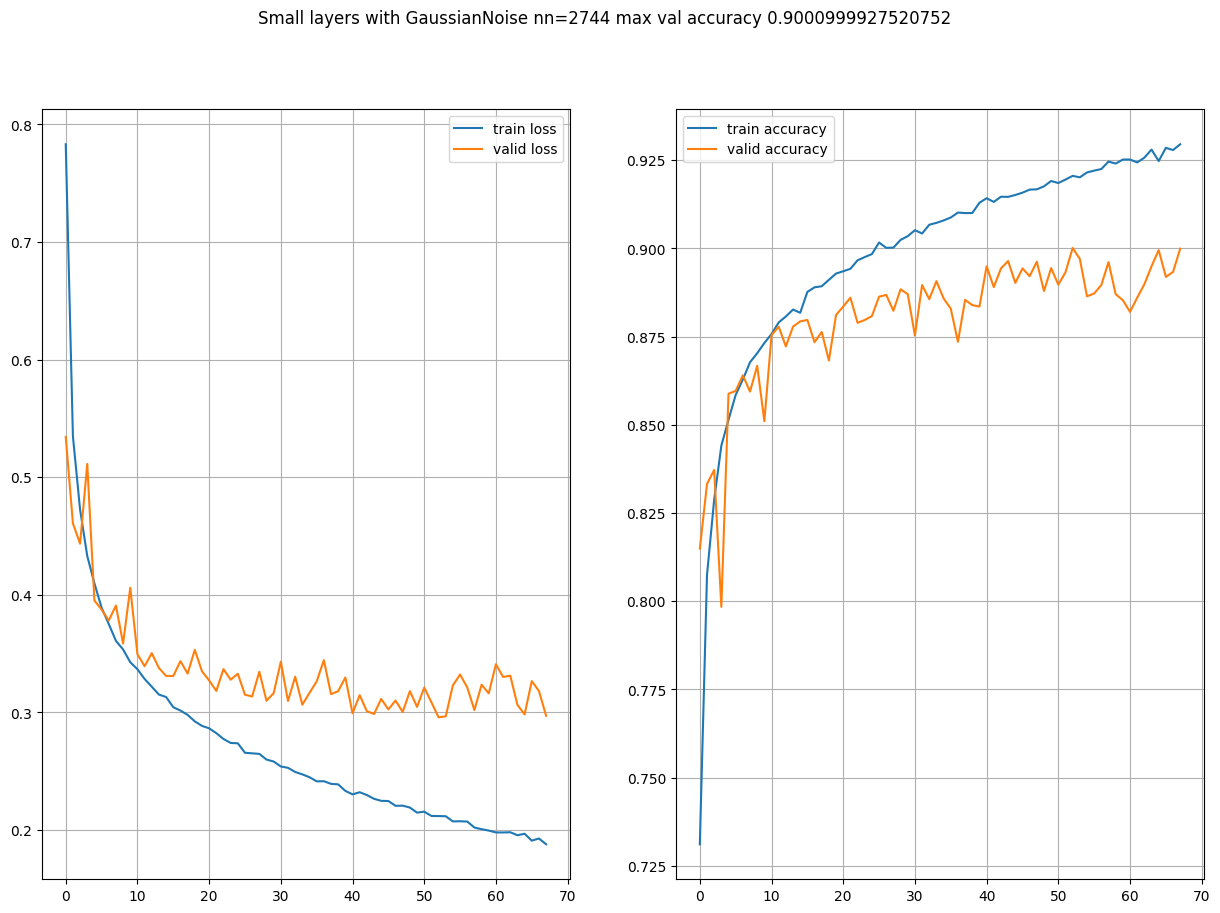

In [45]:

nns = [256, 1024, 2744]
idx = 120

for nn in nns:
    small_layers_GN = [
        Dense(nn, activation="relu", input_shape=(28*28,)),
        GaussianNoise(0.4),
        #Dense(1024, activation="relu"),
        #GaussianNoise(.2),
        Dense(10, activation="softmax"),
    ]

    ds = MyDataset(train_X, train_Y, batch_size=500)
    small_model_GN = create_model_2(small_layers_GN, RMSprop(learning_rate=.0005, rho=.95))
    history = fit_and_present_2(small_model_GN, ds, val_dataset, description=f"Small layers with GaussianNoise nn={nn}", filepath=f"small_la_gn_cp_{idx}", patience=15)

    idx+=1

Моделі на 256 та 1024 нейронів не завершили своє навчання (ранньої зупинки не відбулося)б модель на 2744 нейрони не дійшла до порогу в 91 відсоток.

Збільшимо кількість епох для двох моделей

Epoch 1/200
120/120 [==============================] - ETA: 0s - loss: 0.7598 - accuracy: 0.7401 - categorical_crossentropy: 0.7598INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


120/120 [==============================] - 4s 28ms/step - loss: 0.7598 - accuracy: 0.7401 - categorical_crossentropy: 0.7598 - val_loss: 0.5791 - val_accuracy: 0.7939 - val_categorical_crossentropy: 0.5791
Epoch 2/200
117/120 [============================>.] - ETA: 0s - loss: 0.5291 - accuracy: 0.8128 - categorical_crossentropy: 0.5291INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


120/120 [==============================] - 2s 20ms/step - loss: 0.5268 - accuracy: 0.8137 - categorical_crossentropy: 0.5268 - val_loss: 0.4974 - val_accuracy: 0.8239 - val_categorical_crossentropy: 0.4974
Epoch 3/200
118/120 [============================>.] - ETA: 0s - loss: 0.4738 - accuracy: 0.8338 - categorical_crossentropy: 0.4738INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


120/120 [==============================] - 3s 22ms/step - loss: 0.4734 - accuracy: 0.8338 - categorical_crossentropy: 0.4734 - val_loss: 0.4892 - val_accuracy: 0.8247 - val_categorical_crossentropy: 0.4892
Epoch 4/200
120/120 [==============================] - ETA: 0s - loss: 0.4428 - accuracy: 0.8432 - categorical_crossentropy: 0.4428INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


120/120 [==============================] - 3s 23ms/step - loss: 0.4428 - accuracy: 0.8432 - categorical_crossentropy: 0.4428 - val_loss: 0.4415 - val_accuracy: 0.8442 - val_categorical_crossentropy: 0.4415
Epoch 5/200
120/120 [==============================] - ETA: 0s - loss: 0.4216 - accuracy: 0.8507 - categorical_crossentropy: 0.4216INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


120/120 [==============================] - 3s 21ms/step - loss: 0.4216 - accuracy: 0.8507 - categorical_crossentropy: 0.4216 - val_loss: 0.4236 - val_accuracy: 0.8526 - val_categorical_crossentropy: 0.4236
Epoch 6/200
120/120 [==============================] - 2s 15ms/step - loss: 0.4036 - accuracy: 0.8559 - categorical_crossentropy: 0.4036 - val_loss: 0.4264 - val_accuracy: 0.8459 - val_categorical_crossentropy: 0.4264
Epoch 7/200
119/120 [============================>.] - ETA: 0s - loss: 0.3888 - accuracy: 0.8611 - categorical_crossentropy: 0.3888INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


120/120 [==============================] - 3s 21ms/step - loss: 0.3888 - accuracy: 0.8611 - categorical_crossentropy: 0.3888 - val_loss: 0.4089 - val_accuracy: 0.8555 - val_categorical_crossentropy: 0.4089
Epoch 8/200
120/120 [==============================] - 2s 15ms/step - loss: 0.3749 - accuracy: 0.8665 - categorical_crossentropy: 0.3749 - val_loss: 0.4406 - val_accuracy: 0.8351 - val_categorical_crossentropy: 0.4406
Epoch 9/200
120/120 [==============================] - ETA: 0s - loss: 0.3669 - accuracy: 0.8691 - categorical_crossentropy: 0.3669INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


120/120 [==============================] - 3s 24ms/step - loss: 0.3669 - accuracy: 0.8691 - categorical_crossentropy: 0.3669 - val_loss: 0.4007 - val_accuracy: 0.8568 - val_categorical_crossentropy: 0.4007
Epoch 10/200
119/120 [============================>.] - ETA: 0s - loss: 0.3574 - accuracy: 0.8711 - categorical_crossentropy: 0.3574INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


120/120 [==============================] - 3s 23ms/step - loss: 0.3573 - accuracy: 0.8712 - categorical_crossentropy: 0.3573 - val_loss: 0.3798 - val_accuracy: 0.8636 - val_categorical_crossentropy: 0.3798
Epoch 11/200
120/120 [==============================] - 2s 15ms/step - loss: 0.3495 - accuracy: 0.8746 - categorical_crossentropy: 0.3495 - val_loss: 0.3947 - val_accuracy: 0.8559 - val_categorical_crossentropy: 0.3947
Epoch 12/200
120/120 [==============================] - 2s 15ms/step - loss: 0.3403 - accuracy: 0.8762 - categorical_crossentropy: 0.3403 - val_loss: 0.3855 - val_accuracy: 0.8592 - val_categorical_crossentropy: 0.3855
Epoch 13/200
120/120 [==============================] - ETA: 0s - loss: 0.3331 - accuracy: 0.8791 - categorical_crossentropy: 0.3331INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


120/120 [==============================] - 3s 24ms/step - loss: 0.3331 - accuracy: 0.8791 - categorical_crossentropy: 0.3331 - val_loss: 0.3639 - val_accuracy: 0.8701 - val_categorical_crossentropy: 0.3639
Epoch 14/200
120/120 [==============================] - 2s 15ms/step - loss: 0.3238 - accuracy: 0.8827 - categorical_crossentropy: 0.3238 - val_loss: 0.3752 - val_accuracy: 0.8655 - val_categorical_crossentropy: 0.3752
Epoch 15/200
120/120 [==============================] - 2s 15ms/step - loss: 0.3221 - accuracy: 0.8840 - categorical_crossentropy: 0.3221 - val_loss: 0.3651 - val_accuracy: 0.8688 - val_categorical_crossentropy: 0.3651
Epoch 16/200
120/120 [==============================] - 2s 15ms/step - loss: 0.3167 - accuracy: 0.8855 - categorical_crossentropy: 0.3167 - val_loss: 0.3666 - val_accuracy: 0.8641 - val_categorical_crossentropy: 0.3666
Epoch 17/200
120/120 [==============================] - ETA: 0s - loss: 0.3100 - accuracy: 0.8859 - categorical_crossentropy: 0.3100INFO:

INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


120/120 [==============================] - 3s 23ms/step - loss: 0.3100 - accuracy: 0.8859 - categorical_crossentropy: 0.3100 - val_loss: 0.3513 - val_accuracy: 0.8736 - val_categorical_crossentropy: 0.3513
Epoch 18/200
120/120 [==============================] - ETA: 0s - loss: 0.3048 - accuracy: 0.8884 - categorical_crossentropy: 0.3048INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


120/120 [==============================] - 3s 22ms/step - loss: 0.3048 - accuracy: 0.8884 - categorical_crossentropy: 0.3048 - val_loss: 0.3484 - val_accuracy: 0.8771 - val_categorical_crossentropy: 0.3484
Epoch 19/200
120/120 [==============================] - 2s 15ms/step - loss: 0.3008 - accuracy: 0.8899 - categorical_crossentropy: 0.3008 - val_loss: 0.3521 - val_accuracy: 0.8756 - val_categorical_crossentropy: 0.3521
Epoch 20/200
117/120 [============================>.] - ETA: 0s - loss: 0.2956 - accuracy: 0.8926 - categorical_crossentropy: 0.2956INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


120/120 [==============================] - 3s 21ms/step - loss: 0.2970 - accuracy: 0.8922 - categorical_crossentropy: 0.2970 - val_loss: 0.3361 - val_accuracy: 0.8789 - val_categorical_crossentropy: 0.3361
Epoch 21/200
120/120 [==============================] - ETA: 0s - loss: 0.2913 - accuracy: 0.8935 - categorical_crossentropy: 0.2913INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


120/120 [==============================] - 3s 24ms/step - loss: 0.2913 - accuracy: 0.8935 - categorical_crossentropy: 0.2913 - val_loss: 0.3397 - val_accuracy: 0.8795 - val_categorical_crossentropy: 0.3397
Epoch 22/200
120/120 [==============================] - ETA: 0s - loss: 0.2901 - accuracy: 0.8927 - categorical_crossentropy: 0.2901INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


120/120 [==============================] - 3s 23ms/step - loss: 0.2901 - accuracy: 0.8927 - categorical_crossentropy: 0.2901 - val_loss: 0.3327 - val_accuracy: 0.8800 - val_categorical_crossentropy: 0.3327
Epoch 23/200
119/120 [============================>.] - ETA: 0s - loss: 0.2839 - accuracy: 0.8957 - categorical_crossentropy: 0.2839INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


120/120 [==============================] - 2s 20ms/step - loss: 0.2836 - accuracy: 0.8958 - categorical_crossentropy: 0.2836 - val_loss: 0.3316 - val_accuracy: 0.8804 - val_categorical_crossentropy: 0.3316
Epoch 24/200
120/120 [==============================] - 2s 15ms/step - loss: 0.2810 - accuracy: 0.8973 - categorical_crossentropy: 0.2810 - val_loss: 0.3490 - val_accuracy: 0.8763 - val_categorical_crossentropy: 0.3490
Epoch 25/200
120/120 [==============================] - 2s 17ms/step - loss: 0.2766 - accuracy: 0.8991 - categorical_crossentropy: 0.2766 - val_loss: 0.3520 - val_accuracy: 0.8728 - val_categorical_crossentropy: 0.3520
Epoch 26/200
120/120 [==============================] - 2s 15ms/step - loss: 0.2750 - accuracy: 0.8985 - categorical_crossentropy: 0.2750 - val_loss: 0.3368 - val_accuracy: 0.8802 - val_categorical_crossentropy: 0.3368
Epoch 27/200
120/120 [==============================] - ETA: 0s - loss: 0.2700 - accuracy: 0.9003 - categorical_crossentropy: 0.2700INFO:

INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


120/120 [==============================] - 3s 22ms/step - loss: 0.2700 - accuracy: 0.9003 - categorical_crossentropy: 0.2700 - val_loss: 0.3311 - val_accuracy: 0.8816 - val_categorical_crossentropy: 0.3311
Epoch 28/200
120/120 [==============================] - ETA: 0s - loss: 0.2698 - accuracy: 0.9003 - categorical_crossentropy: 0.2698INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


120/120 [==============================] - 3s 23ms/step - loss: 0.2698 - accuracy: 0.9003 - categorical_crossentropy: 0.2698 - val_loss: 0.3228 - val_accuracy: 0.8835 - val_categorical_crossentropy: 0.3228
Epoch 29/200
120/120 [==============================] - 2s 15ms/step - loss: 0.2642 - accuracy: 0.9032 - categorical_crossentropy: 0.2642 - val_loss: 0.3225 - val_accuracy: 0.8825 - val_categorical_crossentropy: 0.3225
Epoch 30/200
120/120 [==============================] - 2s 16ms/step - loss: 0.2612 - accuracy: 0.9036 - categorical_crossentropy: 0.2612 - val_loss: 0.3281 - val_accuracy: 0.8823 - val_categorical_crossentropy: 0.3281
Epoch 31/200
119/120 [============================>.] - ETA: 0s - loss: 0.2605 - accuracy: 0.9038 - categorical_crossentropy: 0.2605INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


120/120 [==============================] - 3s 24ms/step - loss: 0.2605 - accuracy: 0.9038 - categorical_crossentropy: 0.2605 - val_loss: 0.3214 - val_accuracy: 0.8844 - val_categorical_crossentropy: 0.3214
Epoch 32/200
120/120 [==============================] - 2s 15ms/step - loss: 0.2571 - accuracy: 0.9047 - categorical_crossentropy: 0.2571 - val_loss: 0.3333 - val_accuracy: 0.8785 - val_categorical_crossentropy: 0.3333
Epoch 33/200
120/120 [==============================] - 2s 17ms/step - loss: 0.2549 - accuracy: 0.9074 - categorical_crossentropy: 0.2549 - val_loss: 0.3236 - val_accuracy: 0.8836 - val_categorical_crossentropy: 0.3236
Epoch 34/200
120/120 [==============================] - 2s 15ms/step - loss: 0.2513 - accuracy: 0.9070 - categorical_crossentropy: 0.2513 - val_loss: 0.3246 - val_accuracy: 0.8812 - val_categorical_crossentropy: 0.3246
Epoch 35/200
120/120 [==============================] - 2s 16ms/step - loss: 0.2494 - accuracy: 0.9081 - categorical_crossentropy: 0.2494

INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


120/120 [==============================] - 3s 21ms/step - loss: 0.2435 - accuracy: 0.9105 - categorical_crossentropy: 0.2435 - val_loss: 0.3274 - val_accuracy: 0.8856 - val_categorical_crossentropy: 0.3274
Epoch 39/200
120/120 [==============================] - ETA: 0s - loss: 0.2395 - accuracy: 0.9122 - categorical_crossentropy: 0.2395INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


120/120 [==============================] - 3s 23ms/step - loss: 0.2395 - accuracy: 0.9122 - categorical_crossentropy: 0.2395 - val_loss: 0.3150 - val_accuracy: 0.8886 - val_categorical_crossentropy: 0.3150
Epoch 40/200
120/120 [==============================] - 2s 15ms/step - loss: 0.2367 - accuracy: 0.9124 - categorical_crossentropy: 0.2367 - val_loss: 0.3201 - val_accuracy: 0.8855 - val_categorical_crossentropy: 0.3201
Epoch 41/200
120/120 [==============================] - 2s 15ms/step - loss: 0.2362 - accuracy: 0.9134 - categorical_crossentropy: 0.2362 - val_loss: 0.3401 - val_accuracy: 0.8810 - val_categorical_crossentropy: 0.3401
Epoch 42/200
120/120 [==============================] - 2s 16ms/step - loss: 0.2347 - accuracy: 0.9141 - categorical_crossentropy: 0.2347 - val_loss: 0.3233 - val_accuracy: 0.8844 - val_categorical_crossentropy: 0.3233
Epoch 43/200
120/120 [==============================] - ETA: 0s - loss: 0.2312 - accuracy: 0.9147 - categorical_crossentropy: 0.2312INFO:

INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


120/120 [==============================] - 3s 23ms/step - loss: 0.2312 - accuracy: 0.9147 - categorical_crossentropy: 0.2312 - val_loss: 0.3102 - val_accuracy: 0.8902 - val_categorical_crossentropy: 0.3102
Epoch 44/200
120/120 [==============================] - 2s 16ms/step - loss: 0.2301 - accuracy: 0.9144 - categorical_crossentropy: 0.2301 - val_loss: 0.3129 - val_accuracy: 0.8879 - val_categorical_crossentropy: 0.3129
Epoch 45/200
120/120 [==============================] - 2s 15ms/step - loss: 0.2287 - accuracy: 0.9151 - categorical_crossentropy: 0.2287 - val_loss: 0.3176 - val_accuracy: 0.8889 - val_categorical_crossentropy: 0.3176
Epoch 46/200
120/120 [==============================] - ETA: 0s - loss: 0.2261 - accuracy: 0.9164 - categorical_crossentropy: 0.2261INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


120/120 [==============================] - 3s 22ms/step - loss: 0.2261 - accuracy: 0.9164 - categorical_crossentropy: 0.2261 - val_loss: 0.3162 - val_accuracy: 0.8909 - val_categorical_crossentropy: 0.3162
Epoch 47/200
120/120 [==============================] - ETA: 0s - loss: 0.2252 - accuracy: 0.9171 - categorical_crossentropy: 0.2252INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


120/120 [==============================] - 3s 23ms/step - loss: 0.2252 - accuracy: 0.9171 - categorical_crossentropy: 0.2252 - val_loss: 0.3092 - val_accuracy: 0.8913 - val_categorical_crossentropy: 0.3092
Epoch 48/200
120/120 [==============================] - 2s 15ms/step - loss: 0.2221 - accuracy: 0.9176 - categorical_crossentropy: 0.2221 - val_loss: 0.3171 - val_accuracy: 0.8876 - val_categorical_crossentropy: 0.3171
Epoch 49/200
120/120 [==============================] - 2s 15ms/step - loss: 0.2191 - accuracy: 0.9181 - categorical_crossentropy: 0.2191 - val_loss: 0.3149 - val_accuracy: 0.8898 - val_categorical_crossentropy: 0.3149
Epoch 50/200
120/120 [==============================] - 2s 17ms/step - loss: 0.2183 - accuracy: 0.9194 - categorical_crossentropy: 0.2183 - val_loss: 0.3120 - val_accuracy: 0.8889 - val_categorical_crossentropy: 0.3120
Epoch 51/200
120/120 [==============================] - 2s 16ms/step - loss: 0.2177 - accuracy: 0.9197 - categorical_crossentropy: 0.2177

INFO:tensorflow:Assets written to: small_la_gn_cp_130\assets


120/120 [==============================] - 3s 21ms/step - loss: 0.2094 - accuracy: 0.9232 - categorical_crossentropy: 0.2094 - val_loss: 0.3100 - val_accuracy: 0.8937 - val_categorical_crossentropy: 0.3100
Epoch 57/200
120/120 [==============================] - 2s 15ms/step - loss: 0.2071 - accuracy: 0.9237 - categorical_crossentropy: 0.2071 - val_loss: 0.3396 - val_accuracy: 0.8776 - val_categorical_crossentropy: 0.3396
Epoch 58/200
120/120 [==============================] - 2s 17ms/step - loss: 0.2042 - accuracy: 0.9254 - categorical_crossentropy: 0.2042 - val_loss: 0.3122 - val_accuracy: 0.8905 - val_categorical_crossentropy: 0.3122
Epoch 59/200
120/120 [==============================] - 2s 15ms/step - loss: 0.2028 - accuracy: 0.9255 - categorical_crossentropy: 0.2028 - val_loss: 0.3181 - val_accuracy: 0.8891 - val_categorical_crossentropy: 0.3181
Epoch 60/200
120/120 [==============================] - 2s 15ms/step - loss: 0.2039 - accuracy: 0.9242 - categorical_crossentropy: 0.2039

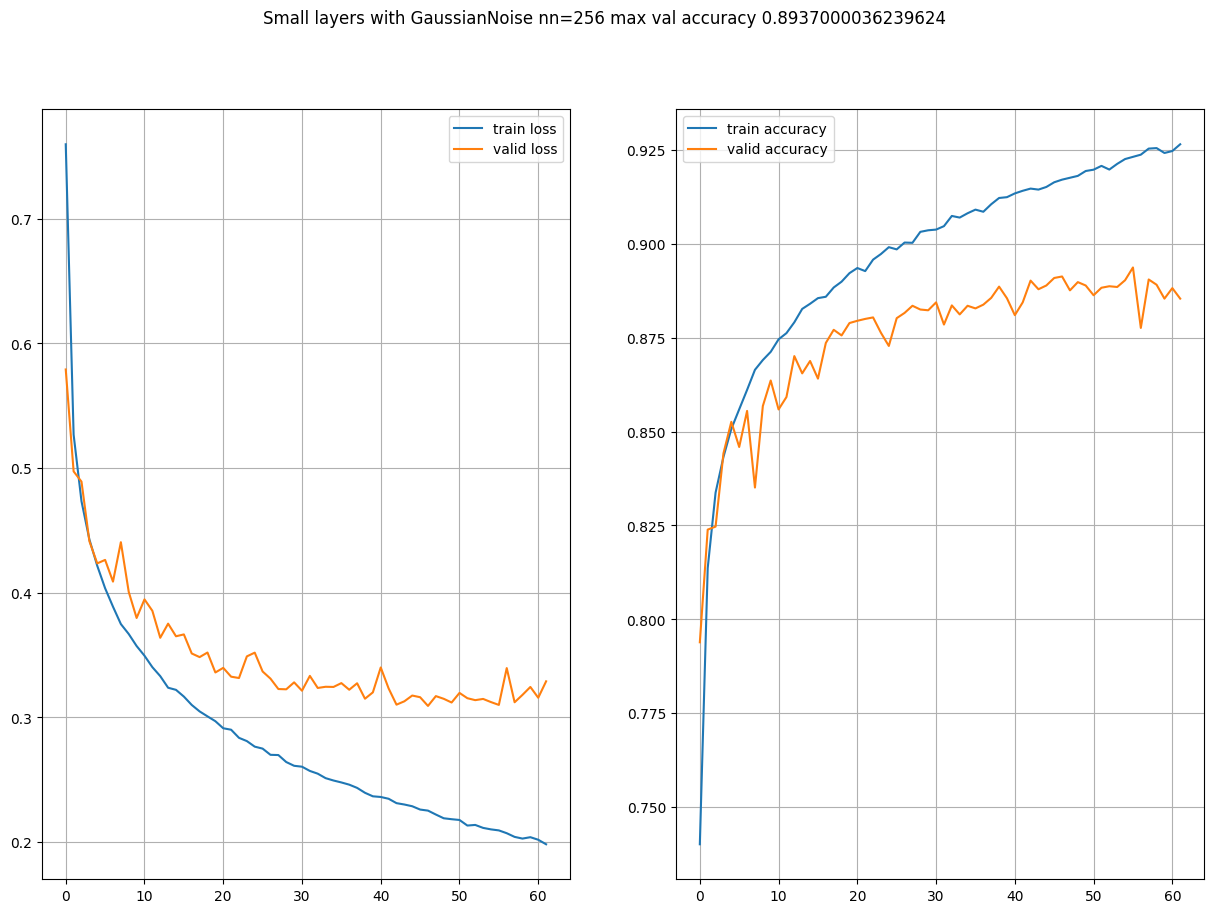

Epoch 1/200
119/120 [============================>.] - ETA: 0s - loss: 0.7222 - accuracy: 0.7526 - categorical_crossentropy: 0.7222INFO:tensorflow:Assets written to: small_la_gn_cp_131\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_131\assets


120/120 [==============================] - 6s 46ms/step - loss: 0.7212 - accuracy: 0.7530 - categorical_crossentropy: 0.7212 - val_loss: 0.5571 - val_accuracy: 0.7971 - val_categorical_crossentropy: 0.5571
Epoch 2/200
120/120 [==============================] - ETA: 0s - loss: 0.5017 - accuracy: 0.8220 - categorical_crossentropy: 0.5017INFO:tensorflow:Assets written to: small_la_gn_cp_131\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_131\assets


120/120 [==============================] - 5s 45ms/step - loss: 0.5017 - accuracy: 0.8220 - categorical_crossentropy: 0.5017 - val_loss: 0.4956 - val_accuracy: 0.8213 - val_categorical_crossentropy: 0.4956
Epoch 3/200
119/120 [============================>.] - ETA: 0s - loss: 0.4488 - accuracy: 0.8405 - categorical_crossentropy: 0.4488INFO:tensorflow:Assets written to: small_la_gn_cp_131\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_131\assets


120/120 [==============================] - 5s 43ms/step - loss: 0.4486 - accuracy: 0.8406 - categorical_crossentropy: 0.4486 - val_loss: 0.4614 - val_accuracy: 0.8357 - val_categorical_crossentropy: 0.4614
Epoch 4/200
119/120 [============================>.] - ETA: 0s - loss: 0.4175 - accuracy: 0.8496 - categorical_crossentropy: 0.4175INFO:tensorflow:Assets written to: small_la_gn_cp_131\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_131\assets


120/120 [==============================] - 5s 44ms/step - loss: 0.4172 - accuracy: 0.8497 - categorical_crossentropy: 0.4172 - val_loss: 0.4209 - val_accuracy: 0.8503 - val_categorical_crossentropy: 0.4209
Epoch 5/200
120/120 [==============================] - 5s 37ms/step - loss: 0.3870 - accuracy: 0.8601 - categorical_crossentropy: 0.3870 - val_loss: 0.4271 - val_accuracy: 0.8449 - val_categorical_crossentropy: 0.4271
Epoch 6/200
120/120 [==============================] - ETA: 0s - loss: 0.3703 - accuracy: 0.8657 - categorical_crossentropy: 0.3703INFO:tensorflow:Assets written to: small_la_gn_cp_131\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_131\assets


120/120 [==============================] - 5s 44ms/step - loss: 0.3703 - accuracy: 0.8657 - categorical_crossentropy: 0.3703 - val_loss: 0.3748 - val_accuracy: 0.8630 - val_categorical_crossentropy: 0.3748
Epoch 7/200
120/120 [==============================] - ETA: 0s - loss: 0.3548 - accuracy: 0.8718 - categorical_crossentropy: 0.3548INFO:tensorflow:Assets written to: small_la_gn_cp_131\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_131\assets


120/120 [==============================] - 5s 43ms/step - loss: 0.3548 - accuracy: 0.8718 - categorical_crossentropy: 0.3548 - val_loss: 0.3681 - val_accuracy: 0.8676 - val_categorical_crossentropy: 0.3681
Epoch 8/200
120/120 [==============================] - 5s 38ms/step - loss: 0.3413 - accuracy: 0.8751 - categorical_crossentropy: 0.3413 - val_loss: 0.3773 - val_accuracy: 0.8627 - val_categorical_crossentropy: 0.3773
Epoch 9/200
120/120 [==============================] - 4s 36ms/step - loss: 0.3314 - accuracy: 0.8788 - categorical_crossentropy: 0.3314 - val_loss: 0.3712 - val_accuracy: 0.8622 - val_categorical_crossentropy: 0.3712
Epoch 10/200
120/120 [==============================] - 5s 39ms/step - loss: 0.3231 - accuracy: 0.8822 - categorical_crossentropy: 0.3231 - val_loss: 0.3667 - val_accuracy: 0.8665 - val_categorical_crossentropy: 0.3667
Epoch 11/200
120/120 [==============================] - 4s 37ms/step - loss: 0.3129 - accuracy: 0.8852 - categorical_crossentropy: 0.3129 -

INFO:tensorflow:Assets written to: small_la_gn_cp_131\assets


120/120 [==============================] - 5s 43ms/step - loss: 0.3062 - accuracy: 0.8881 - categorical_crossentropy: 0.3062 - val_loss: 0.3414 - val_accuracy: 0.8767 - val_categorical_crossentropy: 0.3414
Epoch 13/200
120/120 [==============================] - 5s 38ms/step - loss: 0.2970 - accuracy: 0.8912 - categorical_crossentropy: 0.2970 - val_loss: 0.3465 - val_accuracy: 0.8758 - val_categorical_crossentropy: 0.3465
Epoch 14/200
120/120 [==============================] - ETA: 0s - loss: 0.2906 - accuracy: 0.8934 - categorical_crossentropy: 0.2906INFO:tensorflow:Assets written to: small_la_gn_cp_131\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_131\assets


120/120 [==============================] - 6s 45ms/step - loss: 0.2906 - accuracy: 0.8934 - categorical_crossentropy: 0.2906 - val_loss: 0.3433 - val_accuracy: 0.8770 - val_categorical_crossentropy: 0.3433
Epoch 15/200
119/120 [============================>.] - ETA: 0s - loss: 0.2848 - accuracy: 0.8947 - categorical_crossentropy: 0.2848INFO:tensorflow:Assets written to: small_la_gn_cp_131\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_131\assets


120/120 [==============================] - 5s 44ms/step - loss: 0.2846 - accuracy: 0.8948 - categorical_crossentropy: 0.2846 - val_loss: 0.3272 - val_accuracy: 0.8824 - val_categorical_crossentropy: 0.3272
Epoch 16/200
120/120 [==============================] - 5s 38ms/step - loss: 0.2824 - accuracy: 0.8948 - categorical_crossentropy: 0.2824 - val_loss: 0.3294 - val_accuracy: 0.8806 - val_categorical_crossentropy: 0.3294
Epoch 17/200
120/120 [==============================] - 4s 36ms/step - loss: 0.2753 - accuracy: 0.8979 - categorical_crossentropy: 0.2753 - val_loss: 0.3348 - val_accuracy: 0.8809 - val_categorical_crossentropy: 0.3348
Epoch 18/200
120/120 [==============================] - 4s 37ms/step - loss: 0.2699 - accuracy: 0.9007 - categorical_crossentropy: 0.2699 - val_loss: 0.3462 - val_accuracy: 0.8784 - val_categorical_crossentropy: 0.3462
Epoch 19/200
120/120 [==============================] - 5s 38ms/step - loss: 0.2645 - accuracy: 0.9014 - categorical_crossentropy: 0.2645

INFO:tensorflow:Assets written to: small_la_gn_cp_131\assets


120/120 [==============================] - 6s 51ms/step - loss: 0.2535 - accuracy: 0.9055 - categorical_crossentropy: 0.2535 - val_loss: 0.3153 - val_accuracy: 0.8899 - val_categorical_crossentropy: 0.3153
Epoch 23/200
120/120 [==============================] - 4s 35ms/step - loss: 0.2483 - accuracy: 0.9081 - categorical_crossentropy: 0.2483 - val_loss: 0.3163 - val_accuracy: 0.8870 - val_categorical_crossentropy: 0.3163
Epoch 24/200
120/120 [==============================] - 5s 38ms/step - loss: 0.2452 - accuracy: 0.9091 - categorical_crossentropy: 0.2452 - val_loss: 0.3092 - val_accuracy: 0.8891 - val_categorical_crossentropy: 0.3092
Epoch 25/200
119/120 [============================>.] - ETA: 0s - loss: 0.2395 - accuracy: 0.9127 - categorical_crossentropy: 0.2395INFO:tensorflow:Assets written to: small_la_gn_cp_131\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_131\assets


120/120 [==============================] - 6s 47ms/step - loss: 0.2396 - accuracy: 0.9126 - categorical_crossentropy: 0.2396 - val_loss: 0.3033 - val_accuracy: 0.8931 - val_categorical_crossentropy: 0.3033
Epoch 26/200
120/120 [==============================] - 4s 36ms/step - loss: 0.2385 - accuracy: 0.9125 - categorical_crossentropy: 0.2385 - val_loss: 0.3046 - val_accuracy: 0.8905 - val_categorical_crossentropy: 0.3046
Epoch 27/200
120/120 [==============================] - 5s 39ms/step - loss: 0.2339 - accuracy: 0.9125 - categorical_crossentropy: 0.2339 - val_loss: 0.3163 - val_accuracy: 0.8886 - val_categorical_crossentropy: 0.3163
Epoch 28/200
120/120 [==============================] - 4s 37ms/step - loss: 0.2310 - accuracy: 0.9151 - categorical_crossentropy: 0.2310 - val_loss: 0.3057 - val_accuracy: 0.8919 - val_categorical_crossentropy: 0.3057
Epoch 29/200
120/120 [==============================] - ETA: 0s - loss: 0.2279 - accuracy: 0.9154 - categorical_crossentropy: 0.2279INFO:

INFO:tensorflow:Assets written to: small_la_gn_cp_131\assets


120/120 [==============================] - 5s 43ms/step - loss: 0.2279 - accuracy: 0.9154 - categorical_crossentropy: 0.2279 - val_loss: 0.3056 - val_accuracy: 0.8944 - val_categorical_crossentropy: 0.3056
Epoch 30/200
120/120 [==============================] - 5s 38ms/step - loss: 0.2250 - accuracy: 0.9166 - categorical_crossentropy: 0.2250 - val_loss: 0.3069 - val_accuracy: 0.8921 - val_categorical_crossentropy: 0.3069
Epoch 31/200
120/120 [==============================] - 4s 36ms/step - loss: 0.2210 - accuracy: 0.9175 - categorical_crossentropy: 0.2210 - val_loss: 0.3124 - val_accuracy: 0.8909 - val_categorical_crossentropy: 0.3124
Epoch 32/200
120/120 [==============================] - 5s 37ms/step - loss: 0.2201 - accuracy: 0.9178 - categorical_crossentropy: 0.2201 - val_loss: 0.3469 - val_accuracy: 0.8798 - val_categorical_crossentropy: 0.3469
Epoch 33/200
120/120 [==============================] - 5s 38ms/step - loss: 0.2161 - accuracy: 0.9204 - categorical_crossentropy: 0.2161

INFO:tensorflow:Assets written to: small_la_gn_cp_131\assets


120/120 [==============================] - 6s 46ms/step - loss: 0.2135 - accuracy: 0.9216 - categorical_crossentropy: 0.2135 - val_loss: 0.2957 - val_accuracy: 0.8974 - val_categorical_crossentropy: 0.2957
Epoch 35/200
120/120 [==============================] - 4s 35ms/step - loss: 0.2096 - accuracy: 0.9214 - categorical_crossentropy: 0.2096 - val_loss: 0.3001 - val_accuracy: 0.8953 - val_categorical_crossentropy: 0.3001
Epoch 36/200
120/120 [==============================] - 5s 38ms/step - loss: 0.2070 - accuracy: 0.9232 - categorical_crossentropy: 0.2070 - val_loss: 0.3392 - val_accuracy: 0.8805 - val_categorical_crossentropy: 0.3392
Epoch 37/200
120/120 [==============================] - 5s 38ms/step - loss: 0.2075 - accuracy: 0.9228 - categorical_crossentropy: 0.2075 - val_loss: 0.3056 - val_accuracy: 0.8933 - val_categorical_crossentropy: 0.3056
Epoch 38/200
119/120 [============================>.] - ETA: 0s - loss: 0.2011 - accuracy: 0.9250 - categorical_crossentropy: 0.2011INFO:

INFO:tensorflow:Assets written to: small_la_gn_cp_131\assets


120/120 [==============================] - 5s 45ms/step - loss: 0.2007 - accuracy: 0.9251 - categorical_crossentropy: 0.2007 - val_loss: 0.3005 - val_accuracy: 0.8975 - val_categorical_crossentropy: 0.3005
Epoch 39/200
120/120 [==============================] - 4s 36ms/step - loss: 0.1989 - accuracy: 0.9266 - categorical_crossentropy: 0.1989 - val_loss: 0.3223 - val_accuracy: 0.8882 - val_categorical_crossentropy: 0.3223
Epoch 40/200
120/120 [==============================] - 4s 36ms/step - loss: 0.1989 - accuracy: 0.9261 - categorical_crossentropy: 0.1989 - val_loss: 0.3104 - val_accuracy: 0.8904 - val_categorical_crossentropy: 0.3104
Epoch 41/200
119/120 [============================>.] - ETA: 0s - loss: 0.1938 - accuracy: 0.9271 - categorical_crossentropy: 0.1938INFO:tensorflow:Assets written to: small_la_gn_cp_131\assets


INFO:tensorflow:Assets written to: small_la_gn_cp_131\assets


120/120 [==============================] - 5s 45ms/step - loss: 0.1936 - accuracy: 0.9272 - categorical_crossentropy: 0.1936 - val_loss: 0.2984 - val_accuracy: 0.8985 - val_categorical_crossentropy: 0.2984
Epoch 42/200
120/120 [==============================] - 5s 38ms/step - loss: 0.1965 - accuracy: 0.9274 - categorical_crossentropy: 0.1965 - val_loss: 0.2996 - val_accuracy: 0.8973 - val_categorical_crossentropy: 0.2996
Epoch 43/200
120/120 [==============================] - 5s 37ms/step - loss: 0.1918 - accuracy: 0.9276 - categorical_crossentropy: 0.1918 - val_loss: 0.3103 - val_accuracy: 0.8953 - val_categorical_crossentropy: 0.3103
Epoch 44/200
120/120 [==============================] - 5s 36ms/step - loss: 0.1917 - accuracy: 0.9288 - categorical_crossentropy: 0.1917 - val_loss: 0.2971 - val_accuracy: 0.8963 - val_categorical_crossentropy: 0.2971
Epoch 45/200
120/120 [==============================] - 5s 38ms/step - loss: 0.1870 - accuracy: 0.9308 - categorical_crossentropy: 0.1870

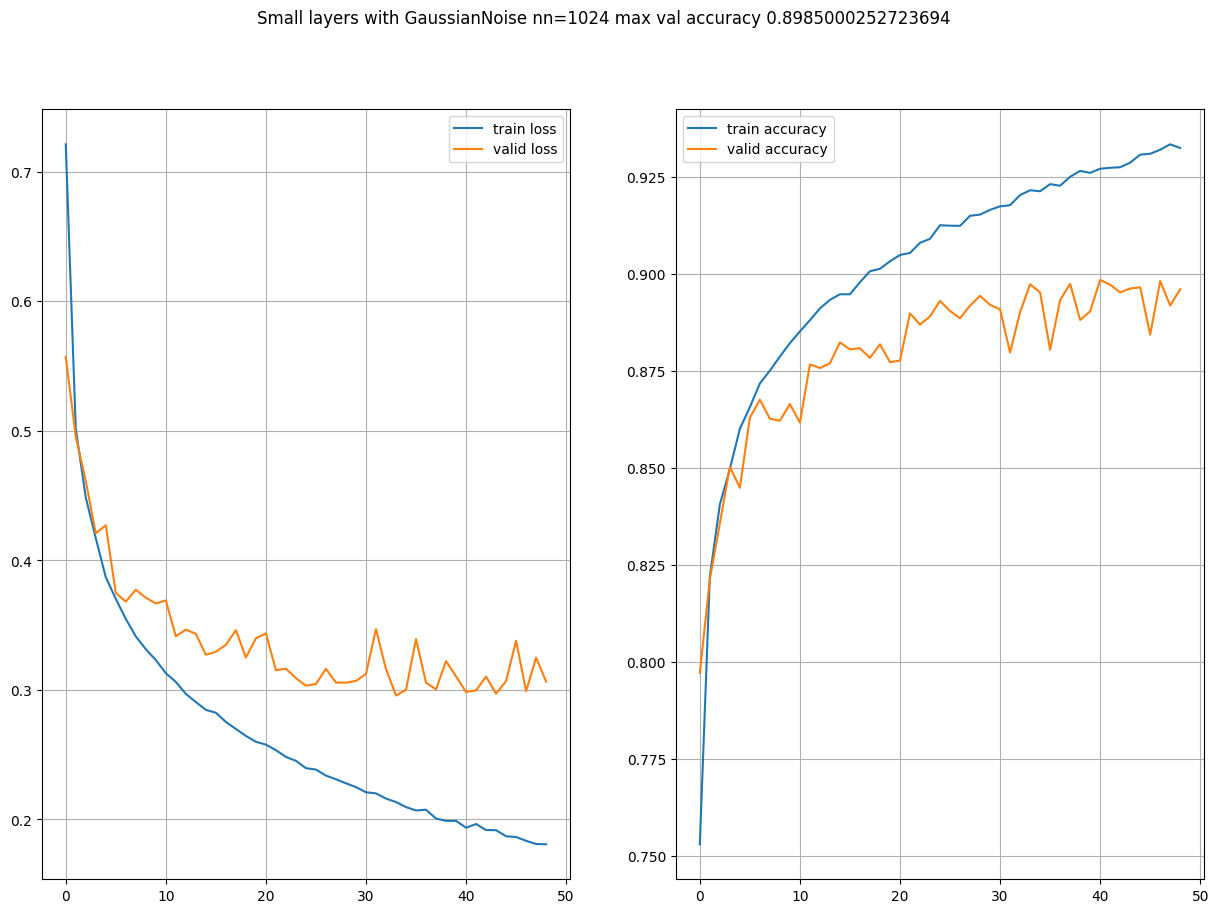

In [46]:

nns = [256, 1024]
idx = 130

for nn in nns:
    small_layers_GN = [
        Dense(nn, activation="relu", input_shape=(28*28,)),
        GaussianNoise(0.2),
        #Dense(1024, activation="relu"),
        #GaussianNoise(.2),
        Dense(10, activation="softmax"),
    ]

    ds = MyDataset(train_X, train_Y, batch_size=500)
    small_model_GN = create_model_2(small_layers_GN, RMSprop(learning_rate=.0005, rho=.95))
    history = fit_and_present_2(small_model_GN, ds, val_dataset, description=f"Small layers with GaussianNoise nn={nn}", filepath=f"small_la_gn_cp_{idx}", patience=15, epochs=200)

    idx+=1

Так сталося, що був змушений перезапустити цей ноутбук, тож наразі висновки стосовно результатів окремих кроків не завжди відповідають даним оновлених графіків: зміни, які при першому проході давали позитивні результати, зараз такими не є, а відкинуті моделі й параметри дали кращі результати. Як вже писав раніше, я це пов'язую з початковою ініціалізацією параметрів при створенні моделі, а також сортуванням даних перед епохами.

За результатами даної роботи я хотів би зробити такі висновки:
1. Складна модель не обов'язково краща, але однозначно повільніша. Не варто занадто ускладнювати моделі.
2. Кожен підхід має технологічні межі.
3. Працюючи з колбеками типу EarlyStopping можна виставляти величезну кількість епох і не боятися, що модель звалиться в перенавчання. Але слід пам'ятати про особливості роботи оптимізаторів. SGD йде повільно, його графік втрат більш "спокійний", і тенденція до перенавчання може бути виявлена за декілька епох. RMSprop живе за принципом "на болоті п'яний крок надійніший", тож зростання втрат протягом 10 епох не виключає, що він повернеться на "путь істинну"
4. Зміна гіперпараметрів оптимізатора, якщо не говорити про екстремальні значення, несуттєво впливає на швидкість/якість навчання.
5. Застосування регуляризаторів вцілому добре впливає на навчання моделі. Занадто багато регуляризаторів, так само як і їх відсутність небажані.

В даній задачі я не зміг подолати бар'єр в 91%